In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
from ast import literal_eval
import json
import plotly.express as px
from ast import literal_eval

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [20, 8]


In [2]:
train = pd.read_csv('../data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [3]:
test = pd.read_csv('../data/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

#### Thoughts on variables:
- A big **budget** does not necessarily leads to a big revenue, money needs to be spent on the right places.
- a **language** might not influence the revenue, but the **number of spoken languages** might do. (check if the number of spoken languages influences the revenue)
- **popularity** is a floating varible; it does not seem to influence the revenue so I decided to drop it
- **Crew** is definitely an very important factor in predicting the box office. I can import some external data to measure the influence of an individual actor/producer, like the number of followers on Twitter.
- Does **ratings** of the movies influence revenues?


#### Unused columns for modeling:
- id
- imdb_id
- original_title
- (overview0)
- popularity (what is it exactly?)
- poster_path

### Thoughts about external datasets:
- Box offices of movies increasingly rely on their performance in foreign markets; is it possible to integrate the information of foreign market distribution?
- Missing budget/revenue data, it can be recovered(scrapped from imdbpro)
- 

In [4]:
# drop these columns, for now
train = train.drop(columns=['id', 'popularity', 'homepage', 'poster_path', 'status', 'original_title', 'overview', 'tagline'])
test = test.drop(columns=['id', 'popularity', 'homepage', 'poster_path', 'status', 'original_title', 'overview', 'tagline'])

# save imdb_id, title for now

In [5]:
train['budget'] = train['budget'].replace(0, np.nan)
test['budget'] = test['budget'].replace(0, np.nan)
train['revenue'] = train['revenue'].replace(0, np.nan)

## EDA

In [6]:
train.head(100)

belongs_to_collection       budget  \
0   [{'id': 313576, 'name': 'Hot Tub Time Machine ...   14000000.0   
1   [{'id': 107674, 'name': 'The Princess Diaries ...   40000000.0   
2                                                 NaN    3300000.0   
3                                                 NaN    1200000.0   
4                                                 NaN          NaN   
5                                                 NaN    8000000.0   
6                                                 NaN   14000000.0   
7                                                 NaN          NaN   
8   [{'id': 256377, 'name': 'The Muppet Collection...          NaN   
9                                                 NaN    6000000.0   
10  [{'id': 1575, 'name': 'Rocky Collection', 'pos...    1000000.0   
11  [{'id': 48190, 'name': 'Revenge of the Nerds C...          NaN   
12                                                NaN   15000000.0   
13  [{'id': 91698, 'name': 'Chili Palmer Collectio...   53000000.0   
14                                                NaN  102000000.0   
15                                                NaN     500000.0   
16                                                NaN   26000000.0   
17                                                NaN          NaN   
18                                                NaN    8000000.0   
19  [{'id': 9518, 'name': 'The Transporter Collect...   32000000.0   
20                                                NaN   80000000.0   
21  [{'id': 9735, 'name': 'Friday the 13th Collect...    4000000.0   
22  [{'id': 207621, 'name': 'V/H/S Collection', 'p...          NaN   
23                                                NaN          NaN   
24                                                NaN          NaN   
25                                                NaN          NaN   
26                                                NaN   10000000.0   
27                                                NaN   11000000.0   
28                                                NaN    6000000.0   
29                                                NaN   45000000.0   
..                                                ...          ...   
70                                                NaN   29000000.0   
71                                                NaN          NaN   
72                                                NaN   11000000.0   
73                                                NaN          NaN   
74                                                NaN     445000.0   
75  [{'id': 230161, 'name': 'Fright Night (Reboot)...   17000000.0   
76                                                NaN     500000.0   
77  [{'id': 104847, 'name': 'Caddyshack Collection...    6000000.0   
78                                                NaN          NaN   
79                                                NaN    1500000.0   
80                                                NaN   15000000.0   
81                                                NaN   10284523.0   
82                                                NaN   43000000.0   
83  [{'id': 4438, 'name': 'The Space Odyssey Serie...   28000000.0   
84                                                NaN    2000000.0   
85                                                NaN   50000000.0   
86                                                NaN    8000000.0   
87                                                NaN    7500000.0   
88                                                NaN   20000000.0   
89                                                NaN          NaN   
90  [{'id': 2883, 'name': 'Kill Bill Collection', ...   30000000.0   
91                                                NaN          NaN   
92                                                NaN   35000000.0   
93                                                NaN          NaN   
94                                                NaN   15000000.0   
95                                        

In [7]:
train.describe()

budget      runtime       revenue
count  2.188000e+03  2998.000000  3.000000e+03
mean   3.089305e+07   107.856571  6.672585e+07
std    4.026785e+07    22.086434  1.375323e+08
min    1.000000e+00     0.000000  1.000000e+00
25%    5.150000e+06    94.000000  2.379808e+06
50%    1.600000e+07   104.000000  1.680707e+07
75%    4.000000e+07   118.000000  6.891920e+07
max    3.800000e+08   338.000000  1.519558e+09

In [8]:
train.isna().sum()

belongs_to_collection    2396
budget                    812
genres                      7
imdb_id                     0
original_language           0
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [9]:
test.isna().sum()

belongs_to_collection    3521
budget                   1211
genres                     16
imdb_id                     0
original_language           0
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [10]:
# introduce new variable: earn_money, try to figure out what cause a movie to lose revenue
train['earn_money'] = train['budget'] < train['revenue']

### Numerical Variables:

In [11]:
train[['budget', 'runtime', 'revenue']].corr()

budget   runtime   revenue
budget   1.000000  0.219426  0.739841
runtime  0.219426  1.000000  0.216380
revenue  0.739841  0.216380  1.000000

We can see that the correlation between revenue and budget is most obvious.

#### Budget:

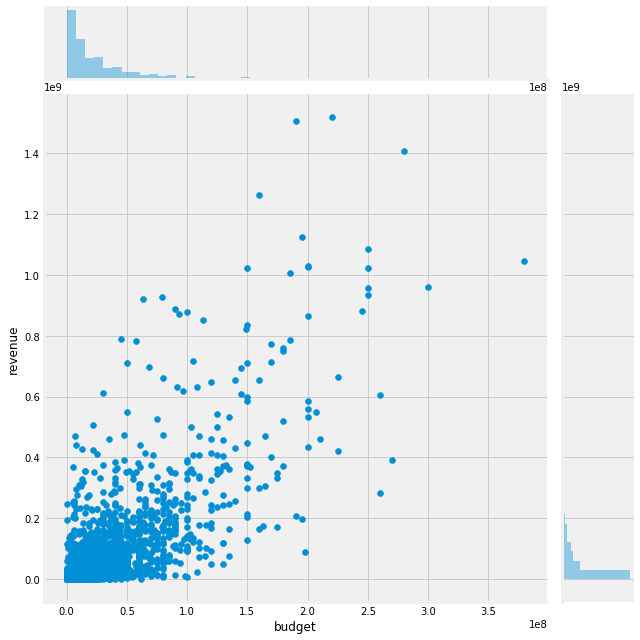

In [12]:
sns.jointplot(x=train['budget'], y=train['revenue'], height=9, ratio=6)

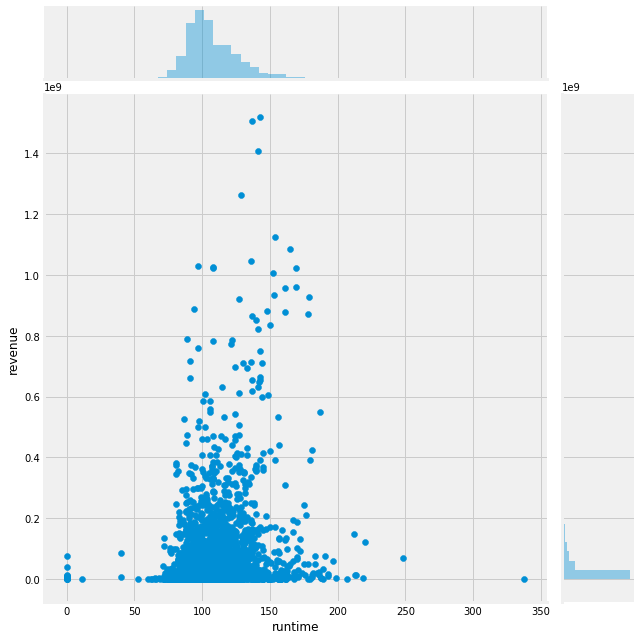

In [13]:
sns.jointplot(x=train['runtime'], y=train['revenue'], height=9, ratio=6)

### Date_released:
I found date_released to be an really interesting variable. It can be a lens by which we can discover the trends and patterns of the movie market. Before digging into the dataset, I have these questions in mind:
- How do revenues fluctuate along these years?
- How do revenues fluctuate between different months of each year? 
- Do lengths of films change?  

In [14]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

**A General View:**

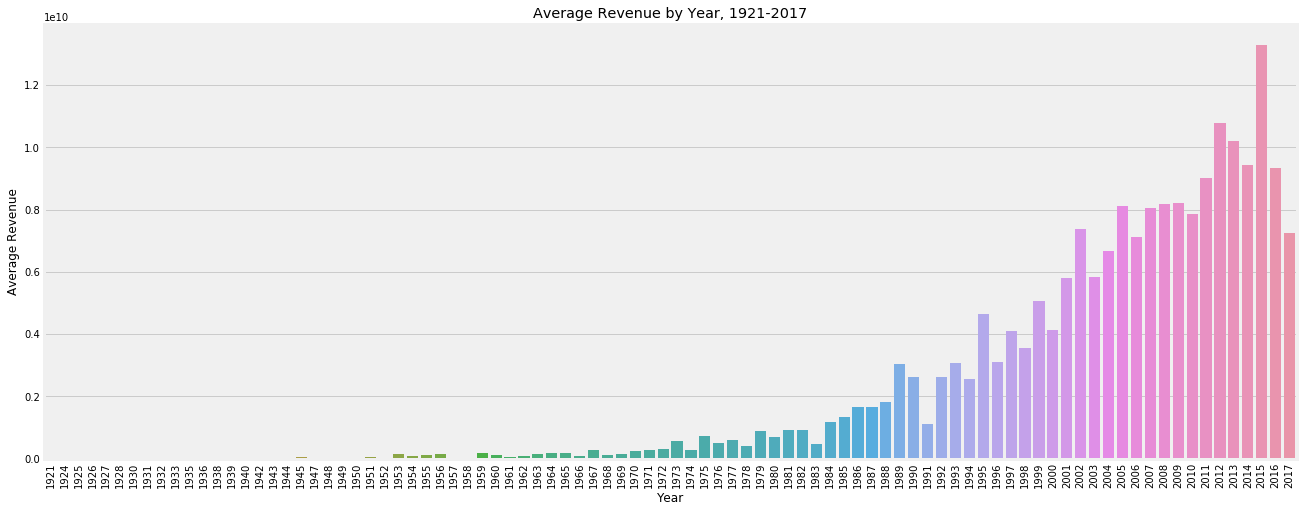

In [15]:
plt.rcParams['figure.figsize'] = [20, 8]

avg_rev_by_year = train.groupby('release_year')['revenue'].sum()
avg_rev_by_year_plot = sns.barplot(x=avg_rev_by_year.index, y=avg_rev_by_year.values)
avg_rev_by_year_plot.set_xticklabels(labels=avg_rev_by_year.index, rotation=90)
avg_rev_by_year_plot.set(xlabel='Year', ylabel='Average Revenue', title='Average Revenue by Year, 1921-2017')
plt.show()

**We can see that there can be huge difference between average revenues between the years. Interestingly, if you take a look at the history of Hollywood,(TODO)**

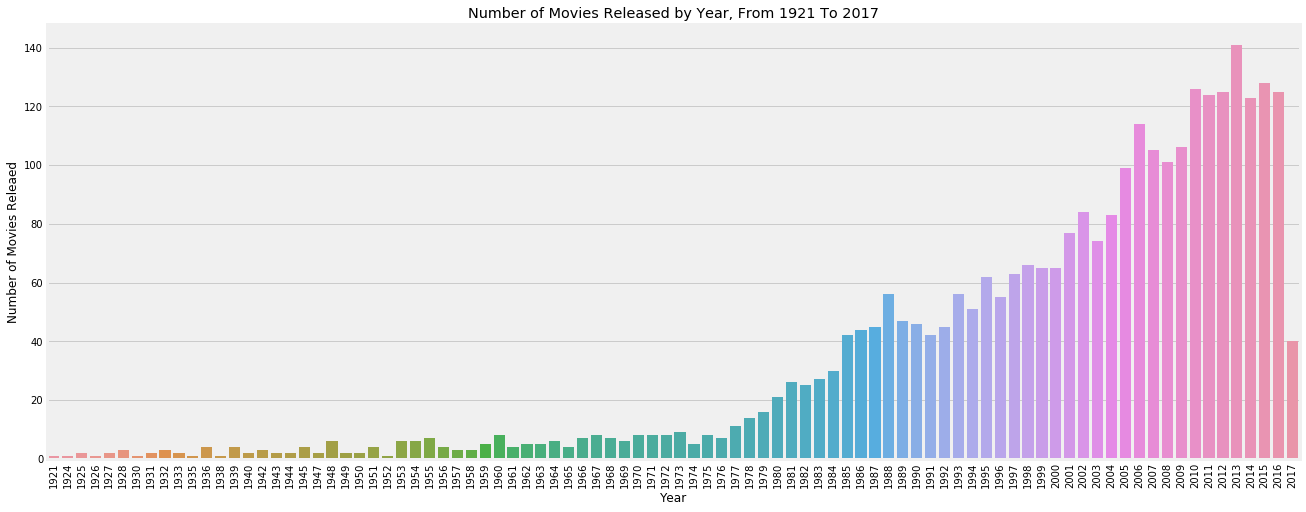

In [16]:
num_by_year = train.groupby('release_year')['imdb_id'].count()
num_by_year_plot = sns.barplot(x=num_by_year.index, y=num_by_year.values)
num_by_year_plot.set_xticklabels(labels=num_by_year.index, rotation=90)
num_by_year_plot.set(xlabel='Year', ylabel='Number of Movies Releaed', title='Number of Movies Released by Year, From 1921 To 2017')
plt.show()

#### Total number of movies released per year increased along the years obviously.

### Runtime:

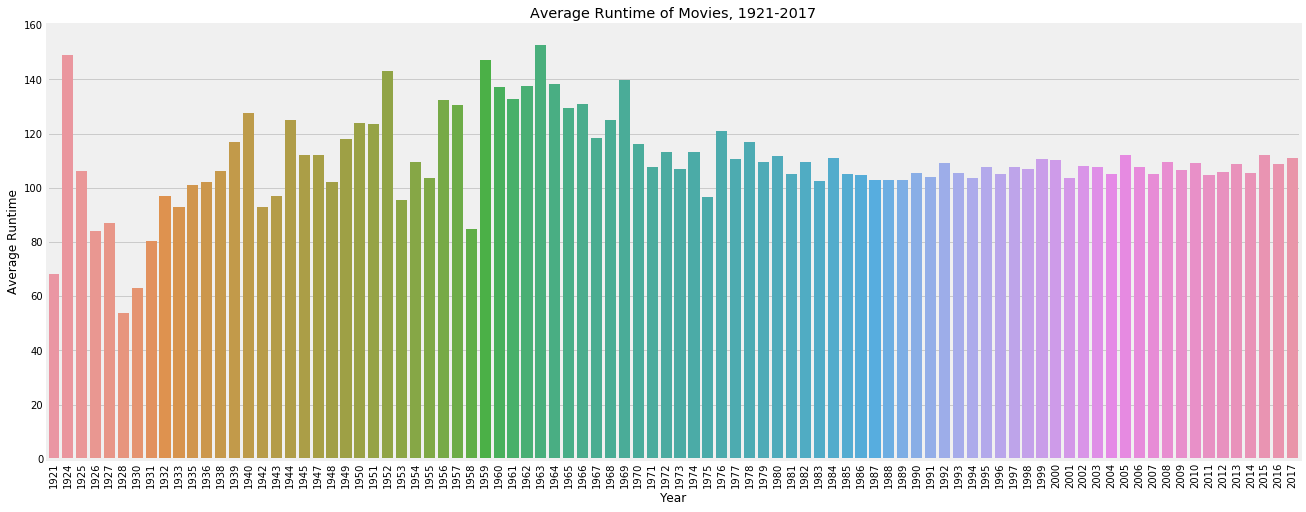

In [17]:
avg_runtime_by_year = train.groupby('release_year')['runtime'].mean()
avg_runtime_by_year_plot = sns.barplot(x=avg_runtime_by_year.index, y =avg_runtime_by_year.values)
avg_runtime_by_year_plot.set_xticklabels(labels=avg_runtime_by_year.index, rotation=90)
avg_runtime_by_year_plot.set(xlabel='Year', ylabel='Average Runtime', title='Average Runtime of Movies, 1921-2017')
plt.show()

**There no clear trend for the length of movies.**

### Revenue by Month / Number of Movies Released by Month: (Release_Date)

[Text(0,0.5,'Average Revenue'),
 Text(0.5,0,'Month'),
 Text(0.5,1,'Average Revenues by Month, 1921-2017')]

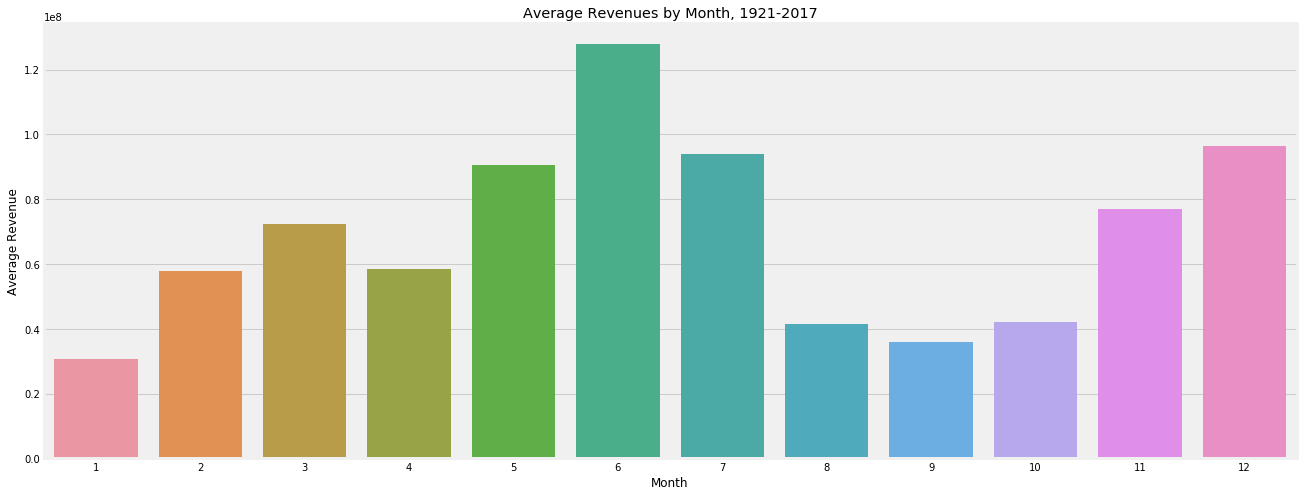

In [18]:
avg_rev_by_month = train.groupby('release_month')['revenue'].mean()
avg_rev_by_month_plot = sns.barplot(x= avg_rev_by_month.index, y=avg_rev_by_month.values)
avg_rev_by_month_plot.set(xlabel='Month', ylabel='Average Revenue', title='Average Revenues by Month, 1921-2017')

#### By observing the average monthly revenues through 1921 to 2017, a trend can be found that average revenues were lowest between Jan to Feb and again Aug to Sept.

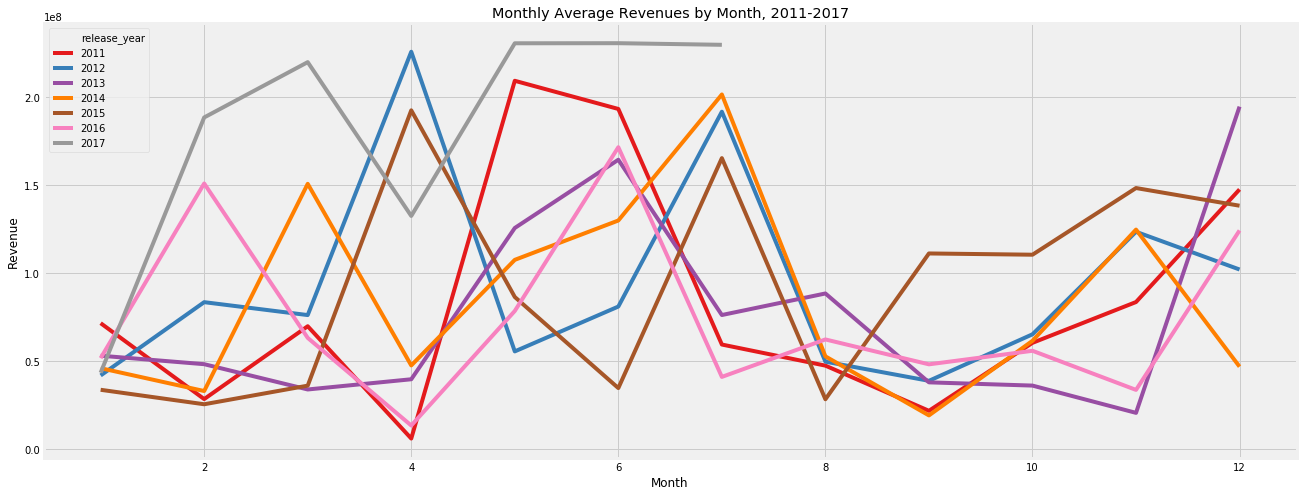

In [19]:
df = train[train['release_year'] > 2010]
avg_rev_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['revenue'].mean()
avg_rev_by_year_and_month_plot = sns.lineplot(data=avg_rev_by_year_and_month, x='release_month', y='revenue', hue = 'release_year', legend = 'full', palette='Set1')
avg_rev_by_year_and_month_plot.set(xlabel='Month', ylabel='Revenue', title='Monthly Average Revenues by Month, 2011-2017')
avg_rev_by_year_and_month_plot

**The same trend can be found when taking a closer look at monthly average revenues between 2010-2017.**

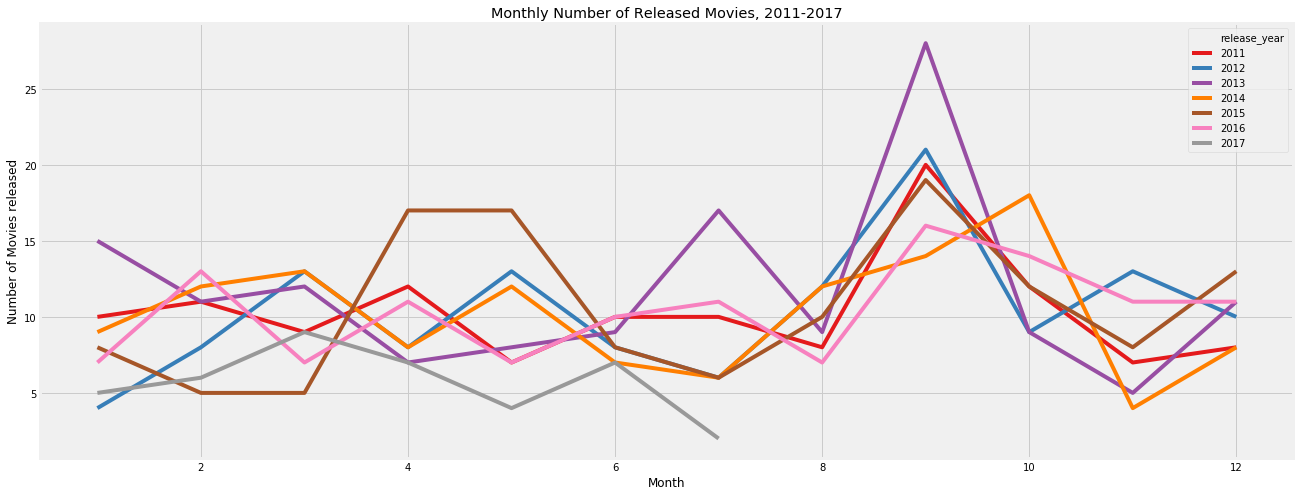

In [20]:
num_of_movies_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['imdb_id'].count()
num_of_movies_by_year_and_month_plot = sns.lineplot(data=num_of_movies_by_year_and_month, x='release_month', y='imdb_id', hue='release_year', legend='full', palette='Set1')
num_of_movies_by_year_and_month_plot.set(xlabel='Month', ylabel='Number of Movies released', title='Monthly Number of Released Movies, 2011-2017')
plt.show()

**By contrast, August to October see the most number of movies released when we look at the data from 2011-2017. (The same pattern persists for previous years also.)**


**A closer look at this trend is provided below, where we can compare the average revenues with number of releases each year:**

In [21]:
def display_monthly_avg_rev_by_year(year):
    df = train[train['release_year'] == year]
    table = df.groupby('release_month')['revenue'].mean()
    avg_rev_by_month_plot = sns.barplot(x=table.index, y=table.values)
    avg_rev_by_month_plot.set(xlabel='Month', ylabel='Average Revenue', title='Average Revenues by Month in '+ str(year))
    plt.show()
    
def display_monthly_num_of_movies_by_year(year):
    df = train[train['release_year'] == year]
    table = df.groupby('release_month', as_index=False)['imdb_id'].count()
    plot = sns.barplot(data=table, x='release_month', y='imdb_id')
    plot.set(xlabel='Month', ylabel='Number of Movies released', title='Number of Released Movies by Month in ' + str(year))
    plt.show()

def compare_num_with_rev_by_year(year):
    display_monthly_avg_rev_by_year(year)
    display_monthly_num_of_movies_by_year(year)


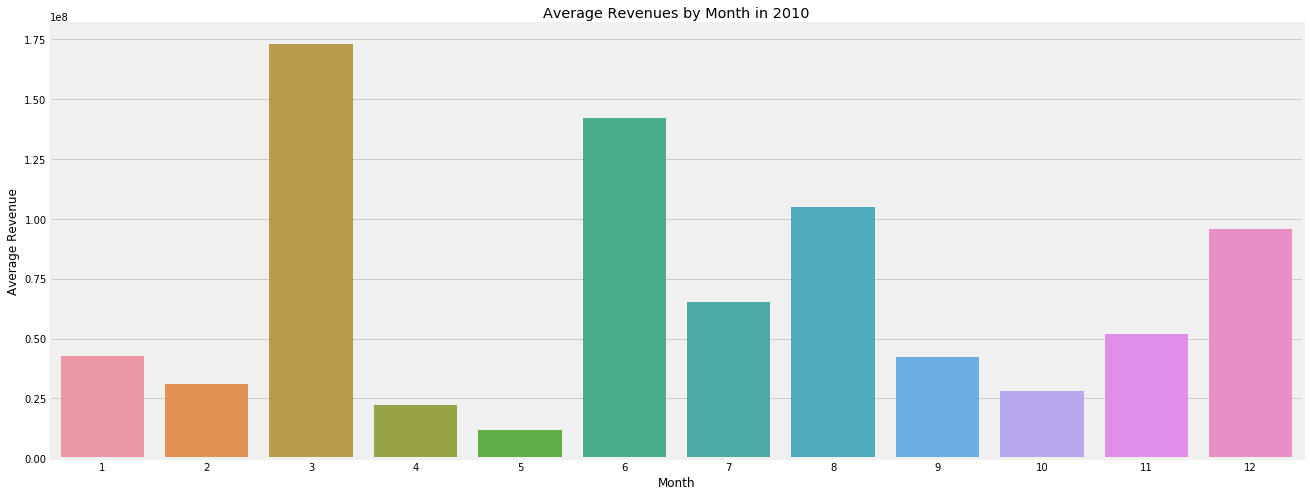

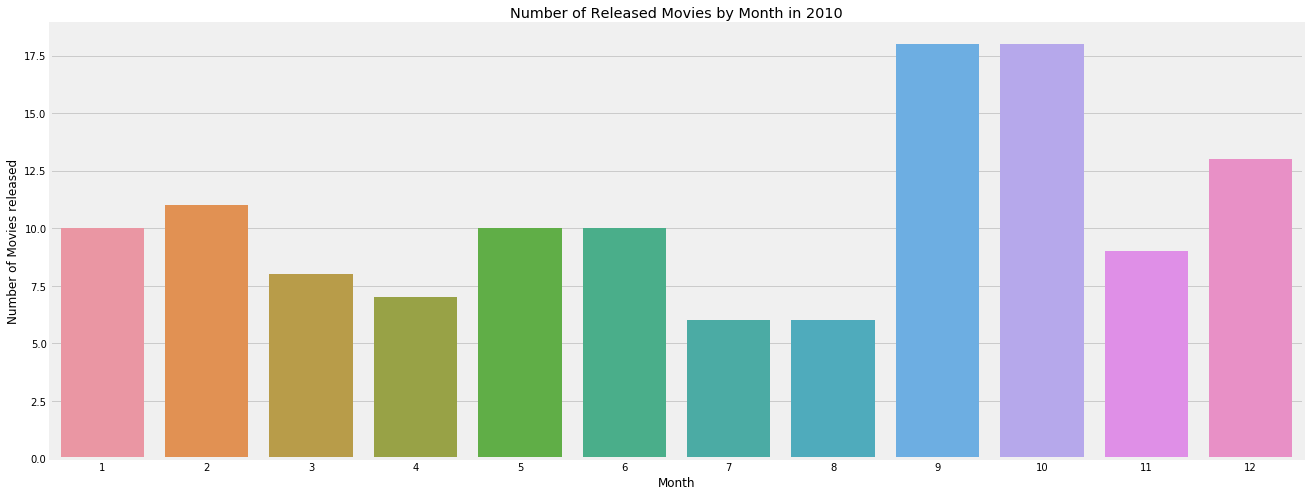

In [22]:
compare_num_with_rev_by_year(2010)

A trend can be identified by comparing monthly number of movies released and monthly average revenues: they seem to be inversely correlated.

### Genre:

In [23]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
train = train
train['genres'] = train['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

genres = train.genres.str.get_dummies(sep=',')
# # train = pd.concat([train, genres], axis=1, sort=False)
# print("Action:", train[train['Action'] == 1].shape[0])
# print("Adventure:", train[train.Adventure == 1].shape[0])
# print("Animation:", train[train.Animation == 1].shape[0])
# print("Comedy:", train[train.Comedy == 1].shape[0])
# print("Crime:", train[train.Crime == 1].shape[0])
# print("Documentary:", train[train.Documentary == 1].shape[0])
# print("Drama:", train[train.Drama == 1].shape[0])
# print("Family:", train[train.Family == 1].shape[0])
# print("Fantasy:", train[train.Fantasy == 1].shape[0])
# print("Foreign:", train[train.Foreign == 1].shape[0])
# print("History:", train[train.History == 1].shape[0])
# print("Music:", train[train.Music == 1].shape[0])
# print("Mystery ", train[train.Mystery == 1].shape[0])
# print("Romance", train[train.Romance == 1].shape[0])
# print("Science ", train[train['Science Fiction'] == 1].shape[0])
# print("TV: ", train[train['TV Movie'] == 1].shape[0])
# print("Thriller: ", train[train.Thriller == 1].shape[0])
# print("War:", train[train.War == 1].shape[0])
# print("Western: ", train[train.Western == 1].shape[0])

In [24]:
train = pd.concat([train, genres], axis=1, sort=False)
genres = train.genres.str.get_dummies(sep=',')
genres.columns

Index([u'Action', u'Adventure', u'Animation', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Family', u'Fantasy', u'Foreign', u'History',
       u'Horror', u'Music', u'Mystery', u'Romance', u'Science Fiction',
       u'TV Movie', u'Thriller', u'War', u'Western'],
      dtype='object')

In [25]:
train[train['genres'].str.contains('TV')]

belongs_to_collection     budget  \
1693                   NaN  5000000.0   

                                        genres    imdb_id original_language  \
1693  Adventure,Drama,Science Fiction,TV Movie  tt0116118                en   

                                   production_companies  \
1693  [{'name': 'Universal TV', 'id': 537}, {'name':...   

                                   production_countries release_date  runtime  \
1693  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...      3/31/96     89.0   

                              spoken_languages  ... History Horror Music  \
1693  [{'iso_639_1': 'en', 'name': 'English'}]  ...       0      0     0   

     Mystery  Romance  Science Fiction  TV Movie  Thriller  War  Western  
1693       0        0                1         1         0    0        0  

[1 rows x 41 columns]

**Only one movie has genre 'TV', so I decided to remove this genre.** 

In [26]:
train.loc[train['genres'].str.contains('TV'), 'genres'] = 'Adventure,Drama,Science Fiction'

**Compare the revenues between different genres throughout the years:**

In [27]:
# calculate the total revenue and avg revenue for each genre in each year, in order to plot the animation plot:
# colnames: 'genre', 'year', 'avg_rev', 'total_rev', 'num_of_productions'
def get_genre_animation_df(dataset, years, genres):
    result =[]
    for year in years:
        df_by_year = dataset[dataset['release_year'] == year]
        for genre in genres:
            df_by_year_and_genre = df_by_year[df_by_year[genre] == 1]
            result.append([year, genre, df_by_year_and_genre['revenue'].mean(), 
                           df_by_year_and_genre['revenue'].sum(),df_by_year_and_genre.shape[0]])
            
    return result
         

In [28]:
df = get_genre_animation_df(train, np.arange(1912,2018), genres.columns)
genre_animation_plot_df = pd.DataFrame(df, columns=['year', 'genre', 'avg_rev', 'total_rev', 'num_of_productions'])
genre_animation_plot_df = genre_animation_plot_df.fillna(0)
px.scatter(genre_animation_plot_df, x='avg_rev', y = 'total_rev', animation_frame = 'year',
          size = 'num_of_productions', color='genre', hover_name = 'genre',
          size_max=55, range_x = [-3e+8, 7e+08], range_y = [-3e+8, 9e+09])

NameError: name 'px' is not defined

In [ ]:
# Here we count movies multiple times if it has multiple genres
def get_unpacked_df_by_genre(dataset, genres):
    result = pd.DataFrame(columns=['title', 'genre', 'revenue','budget'])
    for genre in genres:
        genre_df = dataset[dataset[genre] == 1][['title', 'genres', 'revenue', 'budget']]
        genre_df['genres'] = genre
        genre_df.columns = ['title', 'genre', 'revenue', 'budget']
        result = pd.concat([result, genre_df], ignore_index=True)
    return result

df_by_genre = get_unpacked_df_by_genre(train, genres.columns)
px.box(df_by_genre, x= 'genre', y='revenue')

    

**As it can be seen from both the animation plot and boxplot, genres like Advenure/Animation/Action/Fantasy are likely to make more revenues, as expected.**

### Language:

#### Exploring language related variables

In [30]:
#count
[train['original_language'].count(), train['spoken_languages'].count()]

[3000, 2980]

In [31]:
#NA count
[(train['original_language'].isna()).any(),(train['spoken_languages'].isna()).sum()]

[False, 20]

In [32]:
#NaN columns of spoken_languages variable

#train['spoken_languages'].index('')
#print(train[train["spoken_languages"].isnull()][null_columns])
#NaN in train['spoken_languages']
train[train['spoken_languages'].isnull()]

belongs_to_collection      budget  \
150                                                 NaN         NaN   
177                                                 NaN         NaN   
454                                                 NaN         NaN   
470                                                 NaN   2000000.0   
979                                                 NaN         NaN   
1101                                                NaN         NaN   
1333                                                NaN         NaN   
1335                                                NaN   6000000.0   
1483                                                NaN  23000000.0   
1503                                                NaN         NaN   
1537                                                NaN         NaN   
1622                                                NaN    400000.0   
1648                                                NaN    500000.0   
1760                                                NaN    290000.0   
1917                                                NaN       592.0   
1923                                                NaN         NaN   
2427                                                NaN         NaN   
2629  [{'id': 43058, 'name': 'Homeward Bound Collect...         NaN   
2686                                                NaN         NaN   
2785                                                NaN         NaN   

                                      genres    imdb_id original_language  \
150                  Adventure,Drama,Western  tt0081760                en   
177                            Drama,Romance  tt0118762                en   
454                     Comedy,Drama,Romance  tt0096200                en   
470                                           tt0349159                en   
979                             Drama,Family  tt0093898                en   
1101            Comedy,Drama,Foreign,Romance  tt0092794                en   
1333                             Documentary  tt0468528                en   
1335                                   Drama  tt1107828                ru   
1483                                  Comedy  tt0884732                en   
1503                                  Comedy  tt0092717                en   
1537        Action,Animation,Science Fiction  tt1483025                en   
1622                                          tt0261755                en   
1648                             Crime,Drama  tt0117724                en   
1760                         Adventure,Drama  tt0018618                en   
1917                           Drama,Romance  tt0016104                en   
1923                  Comedy,Foreign,Romance  tt0460892                en   
2427                                   Drama  tt0271582                en   
2629           Adventure,Comedy,Drama,Family  tt0116552                en   
2686                                          tt0833448                ru   
2785  Fantasy,Foreign,Horror,Science Fiction  tt0278675                fr   

                                   production_companies  \
150   [{'name': 'Windwalker', 'id': 55840}, {'name':...   
177                [{'name': 'Stand See', 'id': 15889}]   
454           [{'name': 'TriStar Pictures', 'id': 559}]   
470                                                 NaN   
979                                                 NaN   
1101                                                NaN   
1333                                                NaN   
1335                                                NaN   
1483                                                NaN   
1503                                                NaN   
1537        [{'name': 'Marvel Animation', 'id': 13252}]   
1622                                                NaN   
1648                                                NaN   
1760  [{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...   
1917  [{'name': 'Metro-Goldwyn-Mayer (M

In [33]:
train['original_language'].head(15)

0     en
1     en
2     en
3     hi
4     ko
5     en
6     en
7     en
8     en
9     en
10    en
11    en
12    en
13    en
14    en
Name: original_language, dtype: object

In [34]:
train['spoken_languages'].head(15)

0              [{'iso_639_1': 'en', 'name': 'English'}]
1              [{'iso_639_1': 'en', 'name': 'English'}]
2              [{'iso_639_1': 'en', 'name': 'English'}]
3     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4              [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5              [{'iso_639_1': 'en', 'name': 'English'}]
6              [{'iso_639_1': 'en', 'name': 'English'}]
7     [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...
8              [{'iso_639_1': 'en', 'name': 'English'}]
9              [{'iso_639_1': 'en', 'name': 'English'}]
10             [{'iso_639_1': 'en', 'name': 'English'}]
11             [{'iso_639_1': 'en', 'name': 'English'}]
12             [{'iso_639_1': 'en', 'name': 'English'}]
13    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
14    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
Name: spoken_languages, dtype: object

In [35]:
#engineering spoken_languages column

#train['spoken_languages'].map(lambda x: sorted([d['iso_639_1'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str,x)))
train['spoken_languages_two'] = train['spoken_languages'].map(lambda x: sorted([d['iso_639_1'] for d in get_dictionary(x)]))

In [36]:
train['spoken_languages_two'].head(15)
train['spoken_languages_two'][3]
train['spoken_languages_two'][3][1]
train['spoken_languages_two'][150] #empty for original NaN

[]

In [37]:
train['spoken_languages_two'].isna().sum() #0
train['spoken_languages_two'].count() #3000

3000

In [38]:
train['original_language'][1] in train['spoken_languages_two'][1]
train['orig_in_spok_language'] = np.array(0)

#for i in train['original_language']:
 #   if (train['original_language'][i] in train['spoken_languages_two'][i] == TRUE):
  #      train['orig_in_spok_language'] = 1
   # else:
    #    train['orig_in_spok_language'] = 0

In [39]:
index_list = []
for idx, row in train.iterrows():
    index_list.append(row['original_language'] in row['spoken_languages_two'])

index_list #True means the original language is contained in spoken languages
len(index_list)

3000

In [40]:
not_index_list = [not i for i in index_list]
not_index_list #reverse of index_list

train[not_index_list] #those whose original language is not a part of spoken languages
len(train[not_index_list].index)

76

In [41]:
#index_list.index(False) #92: first row of the one that is false
sum(not_index_list)
index_list.count(False)

76

#### Distribution of movies according to original languages usage

In [42]:
train['original_language'].unique()

array(['en', 'hi', 'ko', 'sr', 'fr', 'it', 'nl', 'zh', 'es', 'cs', 'ta',
       'cn', 'ru', 'tr', 'ja', 'fa', 'sv', 'de', 'te', 'pt', 'mr', 'da',
       'fi', 'el', 'ur', 'he', 'no', 'ar', 'nb', 'ro', 'vi', 'pl', 'hu',
       'ml', 'bn', 'id'], dtype=object)

In [43]:
len(train['original_language'].unique())

36

In [44]:
#plt.figure(figsize=(20,15))
#sns.countplot(train['original_language'].sort_values())#alphabetical order
#plt.ylabel('Number of Movies')
#plt.xlabel('Original Languages')
#plt.title("Counts for Original Languages of Movies (alphabetical order)",fontsize=20)
#plt.show()

In [45]:
train.groupby(['original_language']).original_language.count().nlargest(36) #top 5 of all 36 languages

original_language
en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
ko      20
cn      20
zh      19
de      18
ta      16
sv       8
pt       6
nl       6
fa       5
da       5
ro       4
tr       3
hu       3
fi       2
te       2
pl       2
no       2
ml       2
nb       1
mr       1
cs       1
sr       1
bn       1
id       1
el       1
he       1
ur       1
vi       1
ar       1
Name: original_language, dtype: int64

In [46]:
#plt.figure(figsize=(20,15))
#train_OrigLang=train.groupby(['original_language']).original_language.count().nlargest(36)
#bar1=sns.barplot(train_OrigLang.index, train_OrigLang.values,alpha=0.8)

#plt.ylabel('Number of Movies')
#plt.xlabel('Original Languages')
#plt.title("Counts for Original Languages of Movies (descending order)",fontsize=20)
#plt.show()

In [47]:
#y_pos = train['original_language']
#performance = train['revenue']

#plt.bar(y_pos, performance, align='center', alpha=0.5)
#plt.ylabel('Revenue')
#plt.title('Revenue of Movies with Different Original Languages')

#plt.show()

In [48]:
train_RevByOrigLang=train.groupby(['original_language']).revenue.mean()
train_RevByOrigLang.nlargest(5) 

original_language
en    7.466591e+07
zh    7.037637e+07
tr    5.166341e+07
ja    3.065180e+07
cn    2.977289e+07
Name: revenue, dtype: float64

Text(0.5,1,'Mean Revenue of Movies with Different Original Languages')

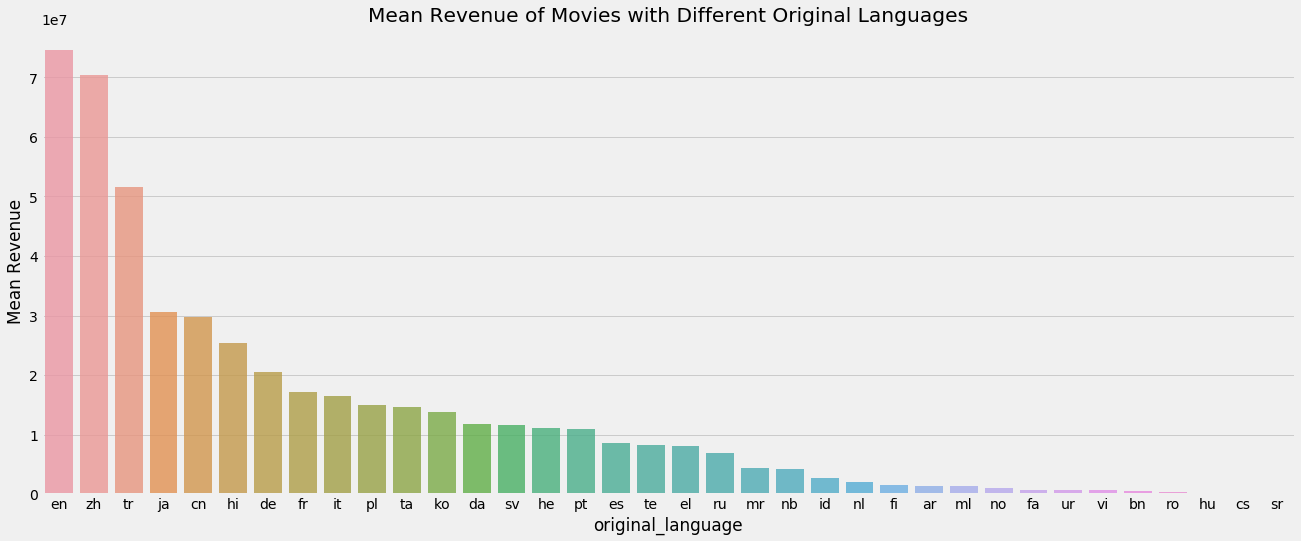

In [49]:
train_RevByOrigLang=train.groupby(['original_language']).revenue.mean()
train_RevByOrigLang=train_RevByOrigLang.nlargest(36) #descending order, 36 original languages in total

#plt.figure(figsize=(13,5))
bar2=sns.barplot(train_RevByOrigLang.index, train_RevByOrigLang.values,alpha=0.8)
#bar2.set_ylim([0,100000000])
plt.ylabel("Mean Revenue")
plt.title("Mean Revenue of Movies with Different Original Languages")

### Cast/Crew

In [50]:
# TODO: 1. scrape data online to fill in the nan
crew_cast_dataset = train[pd.notnull(train['cast']) & pd.notnull(train['crew'])]
crew_cast_dataset['cast'] = crew_cast_dataset['cast'].apply(literal_eval)
crew_cast_dataset['crew'] = crew_cast_dataset['crew'].apply(literal_eval)

/anaconda3/envs/py36/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/py36/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [87]:
# contruct two features:
# economic_idx: total revenues of the top five cast/crew members, ranked by the average revenue of their most recent five films
# artistic_idx: the number of crew/cast members who are involved in the production of a film nominated for Academy Award
def was_involved(dict_list, name):
    """
    Check if the name got involved in the production of this film.
    """
    was_involved = False
    for name_dict in dict_list:
        if name_dict['name'] == name:
            was_involved = True
    return was_involved
    
    
def get_recent_five_avg_rev(name, cast_or_crew, year, month):
    """
    Get a list of the revenues of 5 most recent films by name.
    The list length can be shorter than 5.
    """
    # filter the dataset by time to find the most recent five films
    target_df = crew_cast_dataset[crew_cast_dataset['release_year'] <= year]
    # drop the rows with year equal to target year but month larger than target month
    drop_idx = target_df[(target_df['release_year'] == year) & (target_df['release_month'] > month)].index
    target_df = target_df.drop(drop_idx)
    
    
    # subset the target_df to get the rows that contain the cast/crew
    if cast_or_crew == 'cast':
        target_df = target_df[target_df.apply(lambda row: was_involved(row['cast'], name), axis=1)]
    
    if cast_or_crew == 'crew':
        target_df = target_df[target_df.apply(lambda row: was_involved(row['crew'], name), axis=1)]
    
    # sort the dataframe by release date:
    target_df.sort_values(by=['release_year', 'release_month', 'release_day'], ascending = False)
    
    avg_rev = target_df['revenue'][:5].mean()
    
    if math.isnan(avg_rev):
        return 0
    else:
        return avg_rev
    
    

def get_economic_idx(row):
    cast_rev_list = []
    crew_rev_list = []
    for cast_dict in row['cast']:
        print("=============================\nName: " + str(cast_dict['name']) + str(row['release_year']) + str(row['release_month']))
        rev = get_recent_five_avg_rev(cast_dict['name'], 'cast', row['release_year'], row['release_month'])
        print("Revenue: " + str(rev))
        cast_rev_list.append(rev)              
    for crew_dict in row['crew']:
        crew_rev_list.append(get_recent_five_avg_rev(crew_dict['name'], 'crew', row['release_year'], row['release_month']))
        
    return (sum(sorted(cast_rev_list, reverse=False)[:5]) + sum(sorted(crew_rev_list, reverse=False)[:5]))

In [88]:
crew_cast_dataset['economic_idx'] = crew_cast_dataset.apply(lambda row: get_economic_idx(row), axis=1)


Name: Rob Corddry20152
Revenue: 53164965.8
Name: Craig Robinson20152
Revenue: 60263451.0
Name: Clark Duke20152
Revenue: 61884543.2
Name: Adam Scott20152
Revenue: 70193371.6
Name: Chevy Chase20152
Revenue: 57094546.4
Name: Gillian Jacobs20152
Revenue: 6186930.0
Name: Bianca Haase20152
Revenue: 12314651.0
Name: Collette Wolfe20152
Revenue: 88024174.0
Name: Kumail Nanjiani20152
Revenue: 12314651.0
Name: Kellee Stewart20152
Revenue: 40615269.5
Name: Josh Heald20152
Revenue: 27903887.0
Name: Gretchen Koerner20152
Revenue: 12314651.0
Name: Lisa Loeb20152
Revenue: 26027656.666666668
Name: Jessica Williams20152
Revenue: 15747310.0
Name: Bruce Buffer20152
Revenue: 12314651.0
Name: Mariana Paola Vicente20152
Revenue: 12314651.0
Name: Christian Slater20152
Revenue: 15968104.4
Name: Jason Jones20152
Revenue: 55923539.666666664
Name: Olivia Jordan20152
Revenue: 280841483.0
Name: Christine Bently20152
Revenue: 11220554.5
Name: Stacey Asaro20152
Revenue: 12314651.0
Name: John Cusack20152
Revenue: 203

Name: Jeffrey Dean Morgan20128
Revenue: 41406425.2
Name: Natasha Calis20128
Revenue: 85446075.0
Name: Madison Davenport20128
Revenue: 191292044.5
Name: Kyra Sedgwick20128
Revenue: 63638052.0
Name: Rob LaBelle20128
Revenue: 57800157.333333336
Name: Nana Gbewonyo 20128
Revenue: 85446075.0
Name: Jim Thorburn 20128
Revenue: 85446075.0
Name: Matisyahu 20128
Revenue: 85446075.0
Name: Quinn Lord20128
Revenue: 85446075.0
Name: Jay Brazeau20128
Revenue: 59527595.4
Name: Erin Simms20128
Revenue: 85446075.0
Name: John Cassini20128
Revenue: 52429534.0
Name: Grant Show20128
Revenue: 85446075.0
Name: Tim Perez20128
Revenue: 85446075.0
Name: Samir Khader20041
Revenue: 2586511.0
Name: Josh Rushing20041
Revenue: 2586511.0
Name: George W. Bush20041
Revenue: 2586511.0
Name: Hassan Ibrahim20041
Revenue: 2586511.0
Name: Tim Curry19962
Revenue: 57692268.6
Name: Kevin Bishop19962
Revenue: 34327391.0
Name: Jennifer Saunders19962
Revenue: 34327391.0
Name: Billy Connolly19962
Revenue: 190203582.0
Name: Dave Goe

Revenue: 188188225.5
Name: John Cho19999
Revenue: 295889802.5
Name: Hal Fort Atkinson19999
Revenue: 356296601.0
Name: Kent Faulcon19999
Revenue: 356296601.0
Name: Ara Celi19999
Revenue: 356296601.0
Name: Sue Casey19999
Revenue: 356296601.0
Name: Brenda Wehle19999
Revenue: 356296601.0
Name: Lisa Cloud19999
Revenue: 356296601.0
Name: Amber Smith19999
Revenue: 183043250.5
Name: Joel McCrary19999
Revenue: 356296601.0
Name: Marissa Jaret Winokur19999
Revenue: 356296601.0
Name: Dennis Anderson19999
Revenue: 356296601.0
Name: Matthew Kimbrough19999
Revenue: 137058167.0
Name: Erin Cathryn Strubbe19999
Revenue: 356296601.0
Name: Alison Faulk19999
Revenue: 356296601.0
Name: Krista Goodsitt19999
Revenue: 356296601.0
Name: Lily Houtkin19999
Revenue: 356296601.0
Name: Carolina Lancaster19999
Revenue: 356296601.0
Name: Mona Leah19999
Revenue: 356296601.0
Name: Chekesha Van Putten19999
Revenue: 356296601.0
Name: Emily Zachary19999
Revenue: 356296601.0
Name: Nancy Anderson19999
Revenue: 356296601.0
Na

Revenue: 213534848.0
Name: Cameron Diaz20026
Revenue: 162137476.4
Name: William Mapother20026
Revenue: 168743587.33333334
Name: Jason Antoon20026
Revenue: 358372926.0
Name: Nikola Rakoƒçeviƒá201010
Revenue: 198.0
Name: Viktor Saviƒá201010
Revenue: 198.0
Name: Nata≈°a Tapu≈°koviƒá201010
Revenue: 198.0
Name: Nikola Kojo201010
Revenue: 198.0
Name: Bojana Novakoviƒá201010
Revenue: 37450768.5
Name: Dragan Miƒáanoviƒá201010
Revenue: 198.0
Name: Srƒëan Miletiƒá201010
Revenue: 198.0
Name: Predrag Ejdus201010
Revenue: 198.0
Name: Milan 'Caci' Mihailoviƒá201010
Revenue: 198.0
Name: Branislav Jevic201010
Revenue: 198.0
Name: Jasmina Avramoviƒá201010
Revenue: 198.0
Name: Dimitrije Vojnov201010
Revenue: 198.0
Name: Nikola Gli≈°iƒá201010
Revenue: 198.0
Name: Rachel McAdams20058
Revenue: 157370471.66666666
Name: Cillian Murphy20058
Revenue: 143862131.8
Name: Brian Cox20058
Revenue: 141152049.6
Name: Jayma Mays20058
Revenue: 57891803.0
Name: Jack Scalia20058
Revenue: 57891803.0
Name: Robert Pine20058


Revenue: 136159423.0
Name: Gary A. Hecker19984
Revenue: 136159423.0
Name: Edward Fox19984
Revenue: 56852154.8
Name: Dana Kimmell19828
Revenue: 36690067.0
Name: Paul Kratka19828
Revenue: 36690067.0
Name: Tracie Savage19828
Revenue: 36690067.0
Name: Jeffrey Rogers19828
Revenue: 36690067.0
Name: Catherine Parks19828
Revenue: 36690067.0
Name: Larry Zerner19828
Revenue: 36690067.0
Name: Rachel Howard19828
Revenue: 36690067.0
Name: David Katims19828
Revenue: 36690067.0
Name: Nick Savage19828
Revenue: 36690067.0
Name: Gloria Charles19828
Revenue: 36690067.0
Name: Kevin O'Brien19828
Revenue: 36690067.0
Name: Richard Brooker19828
Revenue: 36690067.0
Name: Steve Susskind19828
Revenue: 36690067.0
Name: David Wiley19828
Revenue: 36690067.0
Name: Perla Walter19828
Revenue: 36690067.0
Name: Anne Gaybis19828
Revenue: 36690067.0
Name: Calvin Lee Reeder20127
Revenue: 7223672.5
Name: Lane Hughes20127
Revenue: 7223672.5
Name: Adam Wingard20127
Revenue: 100345.0
Name: Hannah Fierman20127
Revenue: 100345.0

Revenue: 177640589.0
Name: Sarah Gadon20139
Revenue: 20951600.0
Name: Lucius Hoyos20139
Revenue: 7847000.0
Name: Tommie-Amber Pirie20139
Revenue: 7847000.0
Name: Jonathan Cherry20139
Revenue: 29643887.25
Name: Rebecca Northan20139
Revenue: 7847000.0
Name: Oona Chaplin20139
Revenue: 296968863.5
Name: Adam Fergus20139
Revenue: 7847000.0
Name: Sam Moses20139
Revenue: 7847000.0
Name: Ennis Esmer20139
Revenue: 7847000.0
Name: Mike Wilmot20139
Revenue: 3983810.0
Name: George Tchortov20139
Revenue: 7165481.5
Name: Tamara Duarte20139
Revenue: 7847000.0
Name: Rosalind Feldman20139
Revenue: 7847000.0
Name: Don Ritter20139
Revenue: 7847000.0
Name: Judd Nelson19868
Revenue: 21826759.5
Name: Peter Cullen19868
Revenue: 48232046.0
Name: Frank Welker19868
Revenue: 5849647.0
Name: Leonard Nimoy19868
Revenue: 46424823.5
Name: Orson Welles19868
Revenue: 17388142.8
Name: Eric Idle19868
Revenue: 25086461.0
Name: Robert Stack19868
Revenue: 16874823.5
Name: Norman Alden19868
Revenue: 5849647.0
Name: Jack Ang

Revenue: 146936910.0
Name: Rena Owen201510
Revenue: 411585119.5
Name: Julie Engelbrecht201510
Revenue: 146936910.0
Name: Michael Caine201510
Revenue: 153588756.2
Name: Joseph Gilgun201510
Revenue: 62439161.333333336
Name: Isaach De Bankol√©201510
Revenue: 204305968.8
Name: Sloane Coombs201510
Revenue: 146936910.0
Name: Dawn Olivieri201510
Revenue: 199054358.5
Name: Inbar Lavi201510
Revenue: 146936910.0
Name: Bex Taylor-Klaus201510
Revenue: 146936910.0
Name: Aimee Carrero201510
Revenue: 146936910.0
Name: Armani Jackson201510
Revenue: 146936910.0
Name: Samara Lee201510
Revenue: 146936910.0
Name: Stephanie Bertoni201510
Revenue: 146936910.0
Name: Kurt Angle201510
Revenue: 58209362.333333336
Name: David Whalen201510
Revenue: 224148113.0
Name: Jack Erdie201510
Revenue: 68014842.5
Name: Toussaint Raphael Abessolo201510
Revenue: 146936910.0
Name: Allegra Carpenter201510
Revenue: 228809290.66666666
Name: Eric Jacobus201410
Revenue: 7171.0
Name: Julian Barratt201410
Revenue: 40342.333333333336


Name: Jah Shams20139
Revenue: 92100.0
Name: Mary Grace20139
Revenue: 92100.0
Name: Masashi Nagadoi20139
Revenue: 92100.0
Name: Dave Edwards20139
Revenue: 92100.0
Name: Jon Briddell20139
Revenue: 92100.0
Name: Charlton Heston19654
Revenue: 69903718.25
Name: Richard Harris19654
Revenue: 14457436.5
Name: Jim Hutton19654
Revenue: 14873.0
Name: James Coburn19654
Revenue: 2459936.5
Name: Michael Anderson Jr.19654
Revenue: 14873.0
Name: Senta Berger19654
Revenue: 14873.0
Name: Mario Adorf19654
Revenue: 14873.0
Name: Brock Peters19654
Revenue: 6572359.5
Name: Warren Oates19654
Revenue: 14873.0
Name: Ben Johnson19654
Revenue: 1427936.5
Name: R. G. Armstrong19654
Revenue: 14873.0
Name: Slim Pickens19654
Revenue: 14873.0
Name: Karl Swenson19654
Revenue: 5709201.0
Name: Michael Pate19654
Revenue: 1607436.5
Name: Jon Roberts20064
Revenue: 163000.0
Name: Jorge Ayala20064
Revenue: 163000.0
Name: Mickey Munday20064
Revenue: 163000.0
Name: Toni Mooney20064
Revenue: 163000.0
Name: Nelson Andreu20064
Rev

Revenue: 4300000.0
Name: Gaetano Bruno200910
Revenue: 4300000.0
Name: Fausto Russo Alesi200910
Revenue: 4300000.0
Name: Michele Di Mauro200910
Revenue: 4300000.0
Name: Lorenzo Gioielli200910
Revenue: 4300000.0
Name: Lidia Vitale200910
Revenue: 4300000.0
Name: Giampiero Judica200910
Revenue: 4300000.0
Name: Roberto Accornero200910
Revenue: 4300000.0
Name: Lucia Poli200910
Revenue: 4300000.0
Name: Giorgio Colangeli200910
Revenue: 4300000.0
Name: Deborah Bernuzzi200910
Revenue: 4300000.0
Name: Barbara Braconi200910
Revenue: 4300000.0
Name: Federica Cassini200910
Revenue: 4300000.0
Name: Ray Romano20063
Revenue: 348980723.0
Name: John Leguizamo20063
Revenue: 220621404.0
Name: Denis Leary20063
Revenue: 316877549.25
Name: Queen Latifah20063
Revenue: 239503156.75
Name: Seann William Scott20063
Revenue: 268842690.2
Name: Josh Peck20063
Revenue: 226279034.66666666
Name: Jay Leno20063
Revenue: 170932781.2
Name: Will Arnett20063
Revenue: 660940780.0
Name: Chris Wedge20063
Revenue: 522098958.0
Nam

Revenue: 653951.0
Name: Alec George20173
Revenue: 653951.0
Name: Nate Mooney20173
Revenue: 60515890.666666664
Name: Paul Cram20173
Revenue: 653951.0
Name: Adam Farabee20173
Revenue: 653951.0
Name: Peter Moore20173
Revenue: 653951.0
Name: Gene Larche20173
Revenue: 653951.0
Name: Loren Lazerine20173
Revenue: 181909108.0
Name: Sally Wingert20173
Revenue: 30632963.0
Name: Patrick Stewart199411
Revenue: 51094470.0
Name: Jonathan Frakes199411
Revenue: 120000000.0
Name: Brent Spiner199411
Revenue: 68277349.5
Name: LeVar Burton199411
Revenue: 120000000.0
Name: Michael Dorn199411
Revenue: 118617573.5
Name: Gates McFadden199411
Revenue: 120000000.0
Name: Marina Sirtis199411
Revenue: 120000000.0
Name: William Shatner199411
Revenue: 85440000.0
Name: James Doohan199411
Revenue: 102550000.0
Name: Walter Koenig199411
Revenue: 102550000.0
Name: Malcolm McDowell199411
Revenue: 42688749.0
Name: Alan Ruck199411
Revenue: 59979297.0
Name: Whoopi Goldberg199411
Revenue: 292680470.4
Name: Thomas Dekker199411

Name: Sandrine Bonnaire20098
Revenue: 1056938.0
Name: Kevin Kline20098
Revenue: 19342184.0
Name: Val√©rie Lagrange20098
Revenue: 1056938.0
Name: Francis Renaud20098
Revenue: 1056938.0
Name: Alexandra Gentil20098
Revenue: 1056938.0
Name: Alice Pol20098
Revenue: 1056938.0
Name: √âlisabeth Vitali20098
Revenue: 1056938.0
Name: Jennifer Beals20098
Revenue: 40605539.0
Name: Dominic Gould20098
Revenue: 1056938.0
Name: George Clooney19976
Revenue: 132021869.0
Name: Chris O'Donnell19976
Revenue: 92691329.2
Name: Arnold Schwarzenegger19976
Revenue: 165200952.4
Name: Uma Thurman19976
Revenue: 124644354.0
Name: Alicia Silverstone19976
Revenue: 238207122.0
Name: Michael Gough19976
Revenue: 166575339.5
Name: Pat Hingle19976
Revenue: 72083386.6
Name: Elle Macpherson19976
Revenue: 238207122.0
Name: John Glover19976
Revenue: 76473105.4
Name: Vivica A. Fox19976
Revenue: 238207122.0
Name: Robert Swenson19976
Revenue: 238207122.0
Name: Coolio19976
Revenue: 238207122.0
Name: Jesse Ventura19976
Revenue: 103

Revenue: 599045960.0
Name: Tara Cardinal200611
Revenue: 599045960.0
Name: Ben Cooke200611
Revenue: 599045960.0
Name: Nigel Pilkington200611
Revenue: 395749396.0
Name: Simona Roman200611
Revenue: 599045960.0
Name: Victor Sobchak200611
Revenue: 379188120.0
Name: Valarie Trapp200611
Revenue: 599045960.0
Name: Greg Bennett200611
Revenue: 599045960.0
Name: Burt Lancaster19565
Revenue: 14400000.0
Name: Tony Curtis19565
Revenue: 14400000.0
Name: Gina Lollobrigida19565
Revenue: 14400000.0
Name: Katy Jurado19565
Revenue: 14400000.0
Name: Thomas Gomez19565
Revenue: 14400000.0
Name: Johnny Puleo19565
Revenue: 14400000.0
Name: Minor Watson19565
Revenue: 14400000.0
Name: G√©rard Landry19565
Revenue: 14400000.0
Name: Jean-Pierre K√©rien19565
Revenue: 14400000.0
Name: Sid James19565
Revenue: 14400000.0
Name: Gimma Boys19565
Revenue: 14400000.0
Name: Los Arriolas19565
Revenue: 14400000.0
Name: Gamil Ratib19565
Revenue: 14400000.0
Name: Pierre Tabard19565
Revenue: 14400000.0
Name: Edward Hagopian19565


Revenue: 53776615.333333336
Name: R.L. Armstrong196212
Revenue: 13129846.0
Name: Eddie Baker196212
Revenue: 13129846.0
Name: Bobby Barber196212
Revenue: 10814923.0
Name: Danny Borzage196212
Revenue: 6411201.0
Name: John Breen196212
Revenue: 13129846.0
Name: Jess Cavin196212
Revenue: 13129846.0
Name: Steve Condit196212
Revenue: 13129846.0
Name: David Crawford196212
Revenue: 13129846.0
Name: Frank Ellis196212
Revenue: 13129846.0
Name: Charles Fredericks196212
Revenue: 13129846.0
Name: Herman Hack196212
Revenue: 13129846.0
Name: Jester Hairston196212
Revenue: 10514923.0
Name: Chuck Hamilton196212
Revenue: 7394558.0
Name: Kim Hamilton196212
Revenue: 13129846.0
Name: Michael Jeffers196212
Revenue: 13129846.0
Name: Dick Johnstone196212
Revenue: 13202423.0
Name: Colin Kenny196212
Revenue: 13202423.0
Name: Ethan Laidlaw196212
Revenue: 13129846.0
Name: Nancy Marshall196212
Revenue: 13129846.0
Name: Charles Morton196212
Revenue: 13129846.0
Name: Paulene Myers196212
Revenue: 13129846.0
Name: Will

Revenue: 21126225.0
Name: Ian Porter20053
Revenue: 21126225.0
Name: Angus MacInnes20053
Revenue: 74416629.75
Name: Richard Durden20053
Revenue: 21126225.0
Name: Tristan Gemmill20053
Revenue: 21126225.0
Name: Colin Stinton20053
Revenue: 177068646.5
Name: Tara Summers20053
Revenue: 17261082.0
Name: Gael Garc√≠a Bernal20042
Revenue: 18832419.5
Name: Rodrigo de la Serna20042
Revenue: 16756372.0
Name: Mercedes Mor√°n20042
Revenue: 16756372.0
Name: M√≠a Maestro20042
Revenue: 36527423.0
Name: Jean Pierre Noher20042
Revenue: 16756372.0
Name: Lucas Oro20042
Revenue: 16756372.0
Name: Marina Glezer20042
Revenue: 16756372.0
Name: Sofia Bertolotto20042
Revenue: 16756372.0
Name: Franco Solazzi20042
Revenue: 16756372.0
Name: Ricardo D√≠az Mourelle20042
Revenue: 16756372.0
Name: Gustavo Bueno20042
Revenue: 16756372.0
Name: Antonella Costa20042
Revenue: 16756372.0
Name: Natalia Lobo20042
Revenue: 16756372.0
Name: Johnny Depp19904
Revenue: 4299079.5
Name: Amy Locane19904
Revenue: 8266343.0
Name: Polly B

Revenue: 39846344.0
Name: Marcus Breece19807
Revenue: 39846344.0
Name: Mark Chiriboga19807
Revenue: 39846344.0
Name: Fred Buch19807
Revenue: 39846344.0
Name: Frank Schuller19807
Revenue: 39846344.0
Name: Mel Pape19807
Revenue: 39846344.0
Name: Marge McKenna19807
Revenue: 39846344.0
Name: Bruce McLaughlin19807
Revenue: 39846344.0
Name: Dennis McCormack19807
Revenue: 39846344.0
Name: Violet Ramis19807
Revenue: 39846344.0
Name: Judy Arman19807
Revenue: 39846344.0
Name: Dr. Dow19807
Revenue: 39846344.0
Name: Paige Coffman19807
Revenue: 39846344.0
Name: Donna M. Wiggin19807
Revenue: 39846344.0
Name: James Hotchkiss19807
Revenue: 39846344.0
Name: Debbie Howard19807
Revenue: 39846344.0
Name: Douglas Kenney19807
Revenue: 90423172.0
Name: John Murray19807
Revenue: 39846344.0
Name: Ted Swanson19807
Revenue: 39846344.0
Name: Anna Upstrom19807
Revenue: 39846344.0
Name: Burt Reynolds198112
Revenue: 63463171.6
Name: Rachel Ward198112
Revenue: 35610100.0
Name: Henry Silva198112
Revenue: 21355050.0
Na

Revenue: 91974818.0
Name: Jeryl Prescott20057
Revenue: 91974818.0
Name: Roy Scheider198412
Revenue: 115642682.8
Name: John Lithgow198412
Revenue: 26200328.5
Name: Helen Mirren198412
Revenue: 37684047.0
Name: Bob Balaban198412
Revenue: 40400657.0
Name: Keir Dullea198412
Revenue: 40400657.0
Name: Douglas Rain198412
Revenue: 40400657.0
Name: Madolyn Smith Osborne198412
Revenue: 40400657.0
Name: Savely Kramarov198412
Revenue: 40400657.0
Name: Taliesin Jaffe198412
Revenue: 40400657.0
Name: James McEachin198412
Revenue: 40400657.0
Name: Mary Jo Deschanel198412
Revenue: 40400657.0
Name: Elya Baskin198412
Revenue: 40400657.0
Name: Dana Elcar198412
Revenue: 25700328.5
Name: Oleg Rudnik198412
Revenue: 40400657.0
Name: Natasha Shneider198412
Revenue: 40400657.0
Name: Vladimir Skomarovsky198412
Revenue: 40400657.0
Name: Victor Steinbach198412
Revenue: 40400657.0
Name: Candice Bergen198412
Revenue: 46046182.0
Name: Elizabeth Olsen20111
Revenue: 13101672.0
Name: Adam Trese20111
Revenue: 13101672.0
N

Revenue: 13162475.0
Name: V√°clav Neuzil20173
Revenue: 8881237.5
Name: Brian Caspe20173
Revenue: 162041335.75
Name: Ester Koƒçiƒçkov√°20173
Revenue: 13162475.0
Name: Roman Hor√°k20173
Revenue: 7716566.5
Name: Jakub ≈†m√≠d20173
Revenue: 13162475.0
Name: Gabriel Cohen20173
Revenue: 13162475.0
Name: Josef Guruncz20173
Revenue: 13162475.0
Name: Jodie Foster19932
Revenue: 140081992.0
Name: Richard Gere19932
Revenue: 68690132.0
Name: Bill Pullman19932
Revenue: 57872312.75
Name: James Earl Jones19932
Revenue: 95577186.2
Name: Lanny Flaherty19932
Revenue: 72581200.5
Name: William Windom19932
Revenue: 76605919.0
Name: Wendell Wellman19932
Revenue: 103862342.5
Name: Brett Kelley19932
Revenue: 140081992.0
Name: Clarice Taylor19932
Revenue: 140081992.0
Name: Frankie Faison19932
Revenue: 214417146.5
Name: R. Lee Ermey19932
Revenue: 88231111.0
Name: Ray McKinnon19932
Revenue: 140081992.0
Name: Richard Hamilton19932
Revenue: 90746280.0
Name: Uma Thurman200310
Revenue: 143412569.33333334
Name: Lucy Li

Revenue: 2724474.0
Name: Liam McMahon20085
Revenue: 43141173.0
Name: Karen Hassan20085
Revenue: 2724474.0
Name: Frank McCusker20085
Revenue: 2724474.0
Name: Lalor Roddy20085
Revenue: 2724474.0
Name: Helen Madden20085
Revenue: 2724474.0
Name: Paddy Jenkins20085
Revenue: 2724474.0
Name: Naomi Watts20015
Revenue: 10140254.0
Name: Laura Harring20015
Revenue: 13479454.5
Name: Ann Miller20015
Revenue: 20117339.0
Name: Dan Hedaya20015
Revenue: 44985667.6
Name: Justin Theroux20015
Revenue: 17032516.666666668
Name: Brent Briscoe20015
Revenue: 20478710.75
Name: Robert Forster20015
Revenue: 19927617.5
Name: Katharine Towne20015
Revenue: 31022674.6
Name: Lee Grant20015
Revenue: 9379577.0
Name: Scott Coffey20015
Revenue: 20117339.0
Name: Billy Ray Cyrus20015
Revenue: 20117339.0
Name: Chad Everett20015
Revenue: 20117339.0
Name: Rita Taggart20015
Revenue: 20117339.0
Name: James Karen20015
Revenue: 77363668.2
Name: Lori Heuring20015
Revenue: 20117339.0
Name: Angelo Badalamenti20015
Revenue: 20117339.0

Name: Sean Penn19884
Revenue: 29688954.75
Name: Robert Duvall19884
Revenue: 64649864.8
Name: Mar√≠a Conchita Alonso19884
Revenue: 26322945.5
Name: Randy Brooks19884
Revenue: 46616067.0
Name: Grand L. Bush19884
Revenue: 73958033.5
Name: Don Cheadle19884
Revenue: 46616067.0
Name: Damon Wayans19884
Revenue: 46616067.0
Name: Glenn Plummer19884
Revenue: 46616067.0
Name: Sy Richardson19884
Revenue: 19746562.666666668
Name: Tony Todd19884
Revenue: 46616067.0
Name: Courtney Gains19884
Revenue: 30308033.5
Name: Dolph Lundgren19901
Revenue: 45796542.75
Name: Brian Benben19901
Revenue: 9229401.0
Name: Betsy Brantley19901
Revenue: 20043607.5
Name: Matthias Hues19901
Revenue: 9229401.0
Name: Jay Bilas19901
Revenue: 9229401.0
Name: Jim Haynie19901
Revenue: 44048954.5
Name: David Ackroyd19901
Revenue: 9229401.0
Name: Sherman Howard19901
Revenue: 43738524.0
Name: Sam Anderson19901
Revenue: 31722408.5
Name: Michael J. Pollard19901
Revenue: 34778700.5
Name: Jesse Vint19901
Revenue: 9229401.0
Name: Mark 

Revenue: 27575457.8
Name: Penelope Wilton20139
Revenue: 50905917.0
Name: Emily Watson20139
Revenue: 45053379.0
Name: Sarah Gadon20139
Revenue: 20951600.0
Name: Sam Reid20139
Revenue: 15950273.5
Name: Matthew Goode20139
Revenue: 24076633.4
Name: Tom Felton20139
Revenue: 609051046.3333334
Name: James Norton20139
Revenue: 21301156.0
Name: Alan McKenna20139
Revenue: 21537961.5
Name: Lauren Julien-Box20139
Revenue: 16505460.0
Name: Andrew Woodall20139
Revenue: 16505460.0
Name: Daniel Wilde20139
Revenue: 16505460.0
Name: Harrison Ford20101
Revenue: 207433900.2
Name: Brendan Fraser20101
Revenue: 62541085.2
Name: Keri Russell20101
Revenue: 50658169.0
Name: Courtney B. Vance20101
Revenue: 14138339.2
Name: Meredith Droeger20101
Revenue: 15134293.0
Name: Diego Velazquez20101
Revenue: 15134293.0
Name: Jared Harris20101
Revenue: 32833512.4
Name: Patrick Bauchau20101
Revenue: 35672882.8
Name: Alan Ruck20101
Revenue: 81852892.2
Name: David Clennon20101
Revenue: 8770622.5
Name: Dee Wallace20101
Revenu

Revenue: 34562222.0
Name: Don Doolittle196610
Revenue: 34562222.0
Name: Bette Midler196610
Revenue: 34562222.0
Name: Bruce Willis200110
Revenue: 166829872.8
Name: Billy Bob Thornton200110
Revenue: 33090544.5
Name: Cate Blanchett200110
Revenue: 45081594.5
Name: Troy Garity200110
Revenue: 67631903.0
Name: William Converse-Roberts200110
Revenue: 64079888.0
Name: Br√≠an F. O'Byrne200110
Revenue: 67631903.0
Name: Stacey Travis200110
Revenue: 63221758.6
Name: Azura Skye200110
Revenue: 67631903.0
Name: Peggy Miley200110
Revenue: 67631903.0
Name: January Jones200110
Revenue: 45625756.0
Name: Brittany Murphy20048
Revenue: 34154419.8
Name: Holly Hunter20048
Revenue: 13413776.8
Name: Kathy Bates20048
Revenue: 32512644.4
Name: Ron Livingston20048
Revenue: 11137363.0
Name: Kevin Sussman20048
Revenue: 101328628.0
Name: Josie Maran20048
Revenue: 161146153.5
Name: Julianne Nicholson20048
Revenue: 22034832.0
Name: Rashida Jones20048
Revenue: 22034832.0
Name: Jason Antoon20048
Revenue: 190203879.0
Name:

Name: Adrien Brody201211
Revenue: 63059664.2
Name: Tim Robbins201211
Revenue: 85251661.6
Name: Xu Fan201211
Revenue: 311.0
Name: Chen Dao-Ming201211
Revenue: 311.0
Name: Alec Su201211
Revenue: 311.0
Name: Zhang Hanyu201211
Revenue: 13541648.333333334
Name: Alfred Hsing201211
Revenue: 311.0
Name: Duan Yihong201211
Revenue: 311.0
Name: Zhang Guoli201211
Revenue: 311.0
Name: Mo Zhang201211
Revenue: 311.0
Name: Li Xuejian201211
Revenue: 120202.0
Name: Wang Zi Wen201211
Revenue: 311.0
Name: Lu Zhong201211
Revenue: 666271.0
Name: Zhang Guo-Qiang201211
Revenue: 311.0
Name: Chun Du201211
Revenue: 311.0
Name: Qiao Zhenyu201211
Revenue: 311.0
Name: Feng Yuanzheng201211
Revenue: 311.0
Name: Tim Allen20073
Revenue: 293415682.75
Name: John Travolta20073
Revenue: 129495813.6
Name: Martin Lawrence20073
Revenue: 138118882.0
Name: William H. Macy20073
Revenue: 167794681.2
Name: Ray Liotta20073
Revenue: 72351963.6
Name: Marisa Tomei20073
Revenue: 167513481.2
Name: John C. McGinley20073
Revenue: 14294157

Revenue: 5585154.0
Name: Kevin McClarnon19902
Revenue: 5585154.0
Name: Debbee Hinchcliffe19902
Revenue: 5585154.0
Name: Jay Ingram19902
Revenue: 5585154.0
Name: Arthur French19902
Revenue: 5585154.0
Name: Clem Moorman19902
Revenue: 5585154.0
Name: Brad Greenquist19902
Revenue: 31527310.5
Name: Ira Lewis19902
Revenue: 5585154.0
Name: Margaret Klenck19902
Revenue: 5585154.0
Name: John Bolger19902
Revenue: 5585154.0
Name: Bill Fagerbakke19902
Revenue: 58291016.5
Name: Robert Pentz19902
Revenue: 5585154.0
Name: Erik Cord19902
Revenue: 5585154.0
Name: George P. Wilbur19902
Revenue: 63739527.0
Name: Gene LeBell19902
Revenue: 14292577.0
Name: Danny Aiello III19902
Revenue: 5585154.0
Name: Bill Anagnos19902
Revenue: 5585154.0
Name: Gary Tacon19902
Revenue: 5585154.0
Name: Dean Mumford19902
Revenue: 5585154.0
Name: John Finn19902
Revenue: 16206759.5
Name: Adrienne Hampton19902
Revenue: 5585154.0
Name: Dutch Miller19902
Revenue: 5585154.0
Name: Greg Goossen19902
Revenue: 5585154.0
Name: Chris S.

Revenue: 46201432.0
Name: Sara Botsford200510
Revenue: 46201432.0
Name: Cole Heppell200510
Revenue: 46201432.0
Name: Mary Black200510
Revenue: 95208950.0
Name: Jonathon Young200510
Revenue: 32198521.0
Name: R. Nelson Brown200510
Revenue: 24446734.5
Name: Ossie Davis199610
Revenue: 5731103.0
Name: Charles S. Dutton199610
Revenue: 106965305.25
Name: Andre Braugher199610
Revenue: 16279734.0
Name: Richard Belzer199610
Revenue: 29462088.0
Name: De'Aundre Bonds199610
Revenue: 5731103.0
Name: Thomas Jefferson Byrd199610
Revenue: 9401310.5
Name: Isaiah Washington199610
Revenue: 9401310.5
Name: Bernie Mac199610
Revenue: 16973510.5
Name: Wendell Pierce199610
Revenue: 6647415.5
Name: Harry Lennix199610
Revenue: 9401310.5
Name: Roger Guenveur Smith199610
Revenue: 6282814.0
Name: Hill Harper199610
Revenue: 5731103.0
Name: Gabriel Casseus199610
Revenue: 5731103.0
Name: Steve White199610
Revenue: 9401310.5
Name: Albert Hall199610
Revenue: 33818455.666666664
Name: Kristen Wilson199610
Revenue: 5731103

Revenue: 33000000.0
Name: Anna Tolputt20079
Revenue: 33000000.0
Name: Simon Lenagan20079
Revenue: 33000000.0
Name: David Cann20079
Revenue: 33000000.0
Name: T.R. Bowen20079
Revenue: 33000000.0
Name: Margaret John20079
Revenue: 33000000.0
Name: Floella Benjamin20079
Revenue: 33000000.0
Name: David Milner20079
Revenue: 33000000.0
Name: Henrietta Clemett20079
Revenue: 33000000.0
Name: Peter Serafinowicz20079
Revenue: 33000000.0
Name: Crusoe Kurddal20066
Revenue: 300000.0
Name: Jamie Gulpilil20066
Revenue: 300000.0
Name: Richard Birrinbirrin20066
Revenue: 300000.0
Name: David Gulpilil20066
Revenue: 779000.0
Name: Peter Minygululu 20066
Revenue: 300000.0
Name: Frances Djulibing20066
Revenue: 300000.0
Name: Sonia Djarrabalminym20066
Revenue: 300000.0
Name: Cassandra Malangarri Baker20066
Revenue: 300000.0
Name: Philip Gudthaykudthay20066
Revenue: 300000.0
Name: Alicia Witt20125
Revenue: 44920582.25
Name: Jackson Rathbone20125
Revenue: 353134872.25
Name: James Cromwell20125
Revenue: 88147670.

Name: Julie Andrews19687
Revenue: 50278316.333333336
Name: Richard Crenna19687
Revenue: 15000000.0
Name: Michael Craig19687
Revenue: 14000000.0
Name: Daniel Massey19687
Revenue: 14000000.0
Name: Robert Reed19687
Revenue: 14000000.0
Name: Bruce Forsyth19687
Revenue: 14000000.0
Name: Beryl Reid19687
Revenue: 14000000.0
Name: John Collin19687
Revenue: 14000000.0
Name: Alan Oppenheimer19687
Revenue: 14000000.0
Name: Richard Karlan19687
Revenue: 14000000.0
Name: Jenny Agutter19687
Revenue: 14000000.0
Name: Roy Scheider19687
Revenue: 14000000.0
Name: Ian Abercrombie19687
Revenue: 14000000.0
Name: Scarlett Johansson20038
Revenue: 112691402.66666667
Name: Colin Firth20038
Revenue: 31466789.0
Name: Cillian Murphy20038
Revenue: 57093337.0
Name: Tom Wilkinson20038
Revenue: 103757646.25
Name: Judy Parfitt20038
Revenue: 31466789.0
Name: Essie Davis20038
Revenue: 31466789.0
Name: Joanna Scanlan20038
Revenue: 31466789.0
Name: Gabrielle Reidy20038
Revenue: 31466789.0
Name: Chris McHallem20038
Revenue:

Name: Chris Evans20138
Revenue: 388993356.0
Name: Song Kang-ho20138
Revenue: 37505719.0
Name: Ed Harris20138
Revenue: 151301282.4
Name: John Hurt20138
Revenue: 100368640.0
Name: Tilda Swinton20138
Revenue: 297604241.4
Name: Jamie Bell20138
Revenue: 67263275.2
Name: Octavia Spencer20138
Revenue: 78920629.8
Name: Ewen Bremner20138
Revenue: 88048784.6
Name: Ko Ah-sung20138
Revenue: 86758912.0
Name: Alison Pill20138
Revenue: 74438711.8
Name: Luke Pasqualino20138
Revenue: 86758912.0
Name: Vlad Ivanov20138
Revenue: 29330997.666666668
Name: Adnan Haskovic20138
Revenue: 86758912.0
Name: Emma Levie20138
Revenue: 86758912.0
Name: Steve Park20138
Revenue: 62758160.0
Name: Clark Middleton20138
Revenue: 122746366.0
Name: Marcanthonee Reis20138
Revenue: 86758912.0
Name: Paul Lazar20138
Revenue: 38007861.666666664
Name: T√≥mas Lemarquis20138
Revenue: 86758912.0
Name: Kenny Doughty20138
Revenue: 59692018.666666664
Name: Robert Russell20138
Revenue: 71373116.5
Name: Magda Weigertov√°20138
Revenue: 8675

Revenue: 13790963.5
Name: Woody Strode19831
Revenue: 41179129.0
Name: Frank Pesce19831
Revenue: 61163517.5
Name: Vincent Russo19831
Revenue: 5091888.0
Name: Mike Miller19831
Revenue: 5091888.0
Name: Harriet Owen20022
Revenue: 109862682.0
Name: Blayne Weaver20022
Revenue: 109862682.0
Name: Jeff Bennett20022
Revenue: 109862682.0
Name: Kath Soucie20022
Revenue: 70151522.33333333
Name: Corey Burton20022
Revenue: 75466564.0
Name: Corey Burton20022
Revenue: 75466564.0
Name: Andrew McDonough20022
Revenue: 109862682.0
Name: Roger Rees20022
Revenue: 50691809.0
Name: Spencer Breslin20022
Revenue: 109862682.0
Name: Bradley Pierce20022
Revenue: 186329965.5
Name: Quinn Beswick20022
Revenue: 109862682.0
Name: Aaron Spann20022
Revenue: 109862682.0
Name: Andrei Panin20053
Revenue: 8262833.0
Name: Elena Panova20053
Revenue: 8262833.0
Name: Denis Nikiforov20053
Revenue: 8262833.0
Name: Dmitriy Shevchenko20053
Revenue: 8262833.0
Name: Alexander Kuznetsov20053
Revenue: 8262833.0
Name: John Amos20053
Reven

Revenue: 8828061.0
Name: Stephen McCole19989
Revenue: 8572777.0
Name: Kumar Pallana19989
Revenue: 17096053.0
Name: Alexis Bledel19989
Revenue: 17096053.0
Name: Andrew Wilson19989
Revenue: 8828061.0
Name: Hilary Swank20074
Revenue: 33857877.5
Name: David Morrissey20074
Revenue: 62771059.0
Name: Idris Elba20074
Revenue: 47190151.0
Name: AnnaSophia Robb20074
Revenue: 62771059.0
Name: Stephen Rea20074
Revenue: 96903455.6
Name: Andrea Frankle20074
Revenue: 62771059.0
Name: William Ragsdale20074
Revenue: 33261742.5
Name: John McConnell20074
Revenue: 33925734.0
Name: David Jensen20074
Revenue: 48938794.75
Name: Yvonne Landry20074
Revenue: 62771059.0
Name: Samuel Garland20074
Revenue: 62771059.0
Name: Myles Cleveland20074
Revenue: 62771059.0
Name: Mark Lynch20074
Revenue: 62771059.0
Name: Stuart Greer20074
Revenue: 94178596.5
Name: Lara Grice20074
Revenue: 62771059.0
Name: Bo Derek19891
Revenue: 17102711.333333332
Name: Anthony Quinn19891
Revenue: 14462500.0
Name: Don Murray19891
Revenue: 1703

Name: Milla Jovovich19918
Revenue: 2177625.5
Name: Brian Krause19918
Revenue: 2807854.0
Name: Lisa Pelikan19918
Revenue: 13443025.0
Name: Courtney Barilla19918
Revenue: 2807854.0
Name: Garette Ratliff Henson19918
Revenue: 28008017.0
Name: Brian Blain19918
Revenue: 2807854.0
Name: Emma James19918
Revenue: 2807854.0
Name: Jackson Barton19918
Revenue: 2807854.0
Name: Nana Coburn19918
Revenue: 2807854.0
Name: Peter Hehir19918
Revenue: 2807854.0
Name: Alexander Petersons19918
Revenue: 2807854.0
Name: John Mann19918
Revenue: 2807854.0
Name: Wayne Pygram19918
Revenue: 2807854.0
Name: John Dicks19918
Revenue: 2807854.0
Name: Gus Mercurio19918
Revenue: 30830480.0
Name: Rebel Wilson201110
Revenue: 29007412.0
Name: Xavier Samuel201110
Revenue: 247631282.0
Name: Olivia Newton-John201110
Revenue: 17519577.666666668
Name: Kris Marshall201110
Revenue: 10426038.666666666
Name: Kevin Bishop201110
Revenue: 22739975.75
Name: Laura Brent201110
Revenue: 29007412.0
Name: Tim Draxl201110
Revenue: 29007412.0


Revenue: 156167015.0
Name: Benicio del Toro19897
Revenue: 156167015.0
Name: Anthony Starke19897
Revenue: 156167015.0
Name: Everett McGill19897
Revenue: 99445516.0
Name: Desmond Llewelyn19897
Revenue: 160247818.4
Name: Pedro Armend√°riz Jr.19897
Revenue: 117916834.0
Name: Robert Brown19897
Revenue: 161670218.0
Name: Grand L. Bush19897
Revenue: 101361027.33333333
Name: Priscilla Barnes19897
Revenue: 156167015.0
Name: Don Stroud19897
Revenue: 85265207.5
Name: Caroline Bliss19897
Revenue: 173676456.0
Name: Cary-Hiroyuki Tagawa19897
Revenue: 138921877.66666666
Name: Alejandro Bracho19897
Revenue: 156167015.0
Name: Guy De Saint Cyr19897
Revenue: 156167015.0
Name: Rafer Johnson19897
Revenue: 156167015.0
Name: Diane Hsu19897
Revenue: 156167015.0
Name: Christopher Neame19897
Revenue: 84436746.5
Name: Edward Norton20089
Revenue: 45047305.0
Name: Jon Voight20089
Revenue: 221366063.6
Name: Colin Farrell20089
Revenue: 114528435.0
Name: Noah Emmerich20089
Revenue: 115659905.6
Name: Jennifer Ehle2008

Name: Holly Marie Combs19972
Revenue: 57731874.666666664
Name: David Lipper19972
Revenue: 161001698.0
Name: Cassidy Rae19972
Revenue: 161001698.0
Name: Dee Wallace19972
Revenue: 71786971.33333333
Name: Gary Grubbs19972
Revenue: 161001698.0
Name: Kurt Fuller19972
Revenue: 82172317.8
Name: Joanna Canton19972
Revenue: 161001698.0
Name: Chad Carlberg19972
Revenue: 161001698.0
Name: Jack Landry19972
Revenue: 161001698.0
Name: Karyn Beach19972
Revenue: 161001698.0
Name: R. Keith Harris19972
Revenue: 161001698.0
Name: Derin Altay19972
Revenue: 161001698.0
Name: Andrew Masset19972
Revenue: 161001698.0
Name: Wilmer Calderon19972
Revenue: 161001698.0
Name: JoAnna Garcia19972
Revenue: 161001698.0
Name: John Paul Tremblay200610
Revenue: 3833507.0
Name: Robb Wells200610
Revenue: 3833507.0
Name: Mike Smith200610
Revenue: 3833507.0
Name: Patrick Roach200610
Revenue: 3833507.0
Name: Lucy Decoutere200610
Revenue: 3833507.0
Name: Jeanna Harrison200610
Revenue: 3833507.0
Name: Cory Bowles200610
Revenue: 

Revenue: 43384073.2
Name: Chace Crawford20125
Revenue: 40119948.0
Name: Chris Rock20125
Revenue: 80337832.2
Name: Rob Huebel20125
Revenue: 92315703.33333333
Name: Thomas Lennon20125
Revenue: 52326451.0
Name: Amir Talai20125
Revenue: 102307421.0
Name: Rebel Wilson20125
Revenue: 88560656.33333333
Name: Joe Manganiello20125
Revenue: 79700000.0
Name: Wendi McLendon-Covey20125
Revenue: 55348055.0
Name: Kim Fields20125
Revenue: 39935416.0
Name: G√©nesis Rodr√≠guez20125
Revenue: 62960594.5
Name: Megan Mullally20125
Revenue: 79700000.0
Name: Mimi Gianopulos20125
Revenue: 79700000.0
Name: Cheryl Cole20125
Revenue: 79700000.0
Name: Tyce Diorio20125
Revenue: 124984375.0
Name: Taboo20125
Revenue: 87463058.0
Name: Dwyane Wade20125
Revenue: 79700000.0
Name: Whitney Port20125
Revenue: 79700000.0
Name: Taylor Kowalski20125
Revenue: 79700000.0
Name: Jesse Burch20125
Revenue: 120575769.0
Name: Julie Ivey20125
Revenue: 79700000.0
Name: Kate Kneeland20125
Revenue: 72306455.66666667
Name: Jennifer Saunders

Revenue: 53535623.8
Name: Mohammad Amir Naji200810
Revenue: 507802.5
Name: Hamid Aghazi200810
Revenue: 115605.0
Name: Kamran Dehghan200810
Revenue: 115605.0
Name: Maryam Akbari200810
Revenue: 115605.0
Name: Hamid Aghazi200810
Revenue: 115605.0
Name: Schabnam Akhlaghi200810
Revenue: 115605.0
Name: Neshat Nazari200810
Revenue: 115605.0
Name: Hassan Rezaee200810
Revenue: 115605.0
Name: Ponya Salehi200810
Revenue: 115605.0
Name: Cotter Smith198812
Revenue: 136203.0
Name: Mel Harris198812
Revenue: 136203.0
Name: Chuck McCann198812
Revenue: 136203.0
Name: Leigh McCloskey198812
Revenue: 136203.0
Name: Kim Lankford198812
Revenue: 136203.0
Name: Gary Hudson198812
Revenue: 136203.0
Name: Tab Hunter198812
Revenue: 136203.0
Name: Dort Clark198812
Revenue: 136203.0
Name: Michael Douglas20064
Revenue: 191778570.2
Name: Kiefer Sutherland20064
Revenue: 55169059.0
Name: Eva Longoria20064
Revenue: 41943692.0
Name: Martin Donovan20064
Revenue: 38327946.5
Name: Kim Basinger20064
Revenue: 21800289.8
Name: 

Revenue: 62629130.8
Name: Andr√© Benjamin200612
Revenue: 110533596.66666667
Name: Dominic Scott Kay200612
Revenue: 144000000.0
Name: Sam Shepard200612
Revenue: 122671118.66666667
Name: Abraham Benrubi200612
Revenue: 57908099.333333336
Name: Dakota Fanning200612
Revenue: 110513097.66666667
Name: Kevin Anderson200612
Revenue: 106961273.0
Name: Essie Davis200612
Revenue: 87733394.5
Name: Siobhan Fallon200612
Revenue: 119628391.33333333
Name: Louis Corbett200612
Revenue: 144000000.0
Name: Robyn Arthur200612
Revenue: 144000000.0
Name: Julian O'Donnell200612
Revenue: 144000000.0
Name: Gary Basaraba200612
Revenue: 76186792.5
Name: Nate Mooney200612
Revenue: 144000000.0
Name: Nicholas Bell200612
Revenue: 46988083.5
Name: Beau Bridges200612
Revenue: 36791437.0
Name: Teague Rook200612
Revenue: 144000000.0
Name: Julia Zemiro200612
Revenue: 144000000.0
Name: Denise Kirby200612
Revenue: 144000000.0
Name: Robert Plazek200612
Revenue: 144000000.0
Name: Joseph Lotesto200612
Revenue: 144000000.0
Name: 

Revenue: 109264607.25
Name: Kevin J. O'Connor20159
Revenue: 70756807.0
Name: Matt Lowe20159
Revenue: 2801508.0
Name: Jessica Oyelowo20159
Revenue: 514146309.0
Name: J. Karen Thomas20159
Revenue: 1463829.0
Name: Melissa Eastwood20159
Revenue: 2801508.0
Name: Marlo Scheitler20159
Revenue: 2801508.0
Name: Michael Mercaldi20159
Revenue: 2801508.0
Name: Michael Harding20159
Revenue: 2801508.0
Name: Fred Galle20159
Revenue: 17524874.5
Name: Scott Parks20159
Revenue: 2801508.0
Name: Sydelle Noel20159
Revenue: 2801508.0
Name: Elle Graham20159
Revenue: 2801508.0
Name: Leon Pridgen20159
Revenue: 2801508.0
Name: Johanna Jowett20159
Revenue: 54205816.0
Name: Jeffry Winkler20159
Revenue: 2801508.0
Name: Chris Matheny20159
Revenue: 2801508.0
Name: Claudia Church20159
Revenue: 2801508.0
Name: Bill Paxton19925
Revenue: 81130217.0
Name: Billy Bob Thornton19925
Revenue: 1543112.0
Name: Cynda Williams19925
Revenue: 1543112.0
Name: Michael Beach19925
Revenue: 14638751.5
Name: Jim Metzler19925
Revenue: 154

Revenue: 470654000.0
Name: Beverly Powers19756
Revenue: 470654000.0
Name: Ayn Ruymen19756
Revenue: 470654000.0
Name: Christopher Sands19756
Revenue: 470654000.0
Name: Rex Trailer19756
Revenue: 470654000.0
Name: Philip Ettington19756
Revenue: 157160386.75
Name: Patrick Swayze19938
Revenue: 155086566.6
Name: Halle Berry19938
Revenue: 3418141.0
Name: Sabrina Lloyd19938
Revenue: 3418141.0
Name: Brian Bonsall19938
Revenue: 3418141.0
Name: Michael Ironside19938
Revenue: 106437445.2
Name: Diane Ladd19938
Revenue: 9615772.666666666
Name: Adrienne Barbeau19938
Revenue: 36717793.75
Name: Akshay Kumar20126
Revenue: 10971192.4
Name: Sonakshi Sinha20126
Revenue: 31000000.0
Name: Nassar20126
Revenue: 12425000.0
Name: Darshan Jariwala20126
Revenue: 23500000.0
Name: Supreet20126
Revenue: 31000000.0
Name: Gurdeep Kohli20126
Revenue: 31000000.0
Name: Yashpal Sharma20126
Revenue: 31000000.0
Name: Jayant Gadekar20126
Revenue: 31000000.0
Name: Paresh Ganatra20126
Revenue: 31000000.0
Name: Anant Jog20126
Re

Name: Wasabi Mizuta20148
Revenue: 83061158.0
Name: Yumi Kakazu20148
Revenue: 83061158.0
Name: Tomokazu Seki20148
Revenue: 83061158.0
Name: Satoshi Tsumabuki20148
Revenue: 120764725.0
Name: Vanilla Yamazaki20148
Revenue: 83061158.0
Name: Sachi Matsumoto20148
Revenue: 83061158.0
Name: Shihoko Hagino20148
Revenue: 83061158.0
Name: Aruno Tahara20148
Revenue: 83061158.0
Name: Kotono Mitsuishi20148
Revenue: 48074399.666666664
Name: Miyako Takeuchi20148
Revenue: 83061158.0
Name: Wataru Takagi20148
Revenue: 83061158.0
Name: Èô≥ÁæéË≤û20148
Revenue: 83061158.0
Name: Ê•äÂá±Âá±20148
Revenue: 83061158.0
Name: Ë®±Ê∑ëÂ¨™20148
Revenue: 83061158.0
Name: ‰∫éÊ≠£Êòá20148
Revenue: 83061158.0
Name: ÂäâÂÇë20148
Revenue: 83061158.0
Name: Â∫∑ÊÆøÂÆè20148
Revenue: 83061158.0
Name: ÂÆãÊò±ÁíÅ20148
Revenue: 83061158.0
Name: Ë®±Ê∑ëÂ¨™20148
Revenue: 83061158.0
Name: ÂäâÂÇë20148
Revenue: 83061158.0
Name: ÂäâÂÇë20148
Revenue: 83061158.0
Name: Subaru Kimura20148
Revenue: 83061158.0
Name: Megumi Oohara20148
Revenue: 8306

Revenue: 352927224.0
Name: Peter Appel19923
Revenue: 352927224.0
Name: Michael Halton19923
Revenue: 352927224.0
Name: Keith McDaniel19923
Revenue: 352927224.0
Name: Eric Poppick19923
Revenue: 352927224.0
Name: Ron Cacas19923
Revenue: 352927224.0
Name: Kayla Blake19923
Revenue: 352927224.0
Name: Bradford English19923
Revenue: 352927224.0
Name: Gary Gulman20165
Revenue: 500.0
Name: Heath Ledger20033
Revenue: 59183718.333333336
Name: Orlando Bloom20033
Revenue: 601413760.0
Name: Geoffrey Rush20033
Revenue: 43128545.0
Name: Naomi Watts20033
Revenue: 8955341.333333334
Name: Joel Edgerton20033
Revenue: 327991922.0
Name: Laurence Kinlan20033
Revenue: 6585516.0
Name: Philip Barantini20033
Revenue: 6585516.0
Name: Kerry Condon20033
Revenue: 6585516.0
Name: Kris McQuade20033
Revenue: 6585516.0
Name: Emily Browning20033
Revenue: 37467700.0
Name: Kiri Paramore20033
Revenue: 6585516.0
Name: Rachel Griffiths20033
Revenue: 5678224.75
Name: Geoff Morrell20033
Revenue: 6585516.0
Name: Charles Tingwell2

Revenue: 26096852.0
Name: Beth Rowley200910
Revenue: 26096852.0
Name: Ben Castle200910
Revenue: 26096852.0
Name: Mark Edwards200910
Revenue: 26096852.0
Name: Tom Rees-Roberts200910
Revenue: 26096852.0
Name: Arne Somogyi200910
Revenue: 26096852.0
Name: Paul Pilot200910
Revenue: 26096852.0
Name: Phil Wilkinson200910
Revenue: 26096852.0
Name: Kate Duch√™ne200910
Revenue: 26096852.0
Name: William Holden19696
Revenue: 18645839.75
Name: Ernest Borgnine19696
Revenue: 2213320.5
Name: Robert Ryan19696
Revenue: 18175547.0
Name: Edmond O'Brien19696
Revenue: 17946213.666666668
Name: Warren Oates19696
Revenue: 326757.0
Name: Jaime S√°nchez19696
Revenue: 638641.0
Name: Ben Johnson19696
Revenue: 1164838.0
Name: Emilio Fern√°ndez19696
Revenue: 638641.0
Name: Strother Martin19696
Revenue: 9618804.666666666
Name: L.Q. Jones19696
Revenue: 4819320.5
Name: Albert Dekker19696
Revenue: 2909661.5
Name: Bo Hopkins19696
Revenue: 638641.0
Name: Dub Taylor19696
Revenue: 638641.0
Name: Paul Harper19696
Revenue: 63

Revenue: 2225098.0
Name: Denis Sebbah201310
Revenue: 2225098.0
Name: Sophie-Charlotte Husson201310
Revenue: 2225098.0
Name: Judith Davis201310
Revenue: 2225098.0
Name: Lee Michelsen201310
Revenue: 2225098.0
Name: S√©bastien Siroux201310
Revenue: 2225098.0
Name: Charlie Hunnam201610
Revenue: 60551399.666666664
Name: Robert Pattinson201610
Revenue: 285498366.4
Name: Sienna Miller201610
Revenue: 14645302.0
Name: Tom Holland201610
Revenue: 28361600.2
Name: Angus Macfadyen201610
Revenue: 112885393.33333333
Name: Ian McDiarmid201610
Revenue: 502657555.6666667
Name: Franco Nero201610
Revenue: 152010615.0
Name: Bobby Smalldridge201610
Revenue: 4932168.5
Name: Tom Mulheron201610
Revenue: 8574339.0
Name: Edward Ashley201610
Revenue: 51197548.5
Name: Harry Melling201610
Revenue: 442631410.5
Name: Daniel Huttlestone201610
Revenue: 8574339.0
Name: Johann Myers201610
Revenue: 8574339.0
Name: Michael Ford-FitzGerald201610
Revenue: 8574339.0
Name: Aleksandar Jovanoviƒá201610
Revenue: 6692932.0
Name: M

Revenue: 505000000.0
Name: Nick Cannon200212
Revenue: 33745300.0
Name: Zoe Saldana200212
Revenue: 59364757.5
Name: Orlando Jones200212
Revenue: 51999554.666666664
Name: Leonard Roberts200212
Revenue: 57588485.0
Name: GQ200212
Revenue: 57588485.0
Name: Earl Poitier200212
Revenue: 57588485.0
Name: Jason Weaver200212
Revenue: 422915130.5
Name: Candace Carey200212
Revenue: 57588485.0
Name: Shay Roundtree200212
Revenue: 57588485.0
Name: Miguel A. Gaetan200212
Revenue: 57588485.0
Name: J. Anthony Brown200212
Revenue: 57588485.0
Name: Afemo Omilami200212
Revenue: 30140192.0
Name: Tyreese Burnett200212
Revenue: 57588485.0
Name: Brandon Hirsch200212
Revenue: 57588485.0
Name: Angela Elayne Gibbs200212
Revenue: 57588485.0
Name: Jim Belushi199710
Revenue: 66700135.6
Name: Tupac Amaru Shakur199710
Revenue: 5790448.0
Name: Lela Rochon199710
Revenue: 36594321.0
Name: Dennis Quaid199710
Revenue: 26995317.8
Name: James Earl Jones199710
Revenue: 187969970.8
Name: Gary Cole199710
Revenue: 91393808.0
Name

Name: Bruno Ganz20049
Revenue: 48074332.25
Name: Alexandra Maria Lara20049
Revenue: 92180910.0
Name: Corinna Harfouch20049
Revenue: 92180910.0
Name: Ulrich Matthes20049
Revenue: 92180910.0
Name: Juliane K√∂hler20049
Revenue: 92180910.0
Name: Heino Ferch20049
Revenue: 51570192.5
Name: Christian Berkel20049
Revenue: 92180910.0
Name: Thomas Kretschmann20049
Revenue: 80489441.66666667
Name: Ulrich Noethen20049
Revenue: 92180910.0
Name: Birgit Minichmayr20049
Revenue: 92180910.0
Name: Rolf Kanies20049
Revenue: 92180910.0
Name: Justus von Dohn√°nyi20049
Revenue: 47972564.5
Name: Michael Mendl20049
Revenue: 92180910.0
Name: Andr√© Hennicke20049
Revenue: 92180910.0
Name: Christian Redl20049
Revenue: 92180910.0
Name: G√∂tz Otto20049
Revenue: 212595989.0
Name: Thomas Limpinsel20049
Revenue: 92180910.0
Name: Thomas Thieme20049
Revenue: 92180910.0
Name: Donevan Gunia20049
Revenue: 92180910.0
Name: Matthias Habich20049
Revenue: 92180910.0
Name: Alexander Held20049
Revenue: 47972564.5
Name: Devid St

Revenue: 147080413.0
Name: Michael Arias20016
Revenue: 147080413.0
Name: Brenda Eimers20016
Revenue: 147080413.0
Name: Timothy Omundson20016
Revenue: 147080413.0
Name: Astrid Veillon20016
Revenue: 147080413.0
Name: Dean Rader Duval20016
Revenue: 115955462.66666667
Name: Peter Ustinov197810
Revenue: 21363310.2
Name: Mia Farrow197810
Revenue: 23977755.0
Name: Simon MacCorkindale197810
Revenue: 14560084.0
Name: Lois Chiles197810
Revenue: 14560084.0
Name: Angela Lansbury197810
Revenue: 14560084.0
Name: Bette Davis197810
Revenue: 7311773.5
Name: Jane Birkin197810
Revenue: 14560084.0
Name: David Niven197810
Revenue: 19763781.8
Name: Jon Finch197810
Revenue: 14560084.0
Name: Olivia Hussey197810
Revenue: 26730651.0
Name: Maggie Smith197810
Revenue: 14560084.0
Name: George Kennedy197810
Revenue: 54186732.2
Name: Jack Warden197810
Revenue: 42580042.0
Name: I.S. Johar197810
Revenue: 14560084.0
Name: Harry Andrews197810
Revenue: 11653361.333333334
Name: Sam Wanamaker197810
Revenue: 14560084.0
Name

Revenue: 11747008.5
Name: Tanja Reichert20042
Revenue: 5001655.0
Name: Bill Paxton20042
Revenue: 55391522.2
Name: Brittany Daniel20042
Revenue: 5001655.0
Name: Jordan Ladd20042
Revenue: 40040093.0
Name: Nat Faxon20042
Revenue: 5001655.0
Name: Julio Bekhor20042
Revenue: 5001655.0
Name: Karolina Gruszka201211
Revenue: 30292.0
Name: Eddie Garcia20129
Revenue: 119735756.66666667
Name: Armida Siguion-Reyna20129
Revenue: 34659.0
Name: Joey Paras20129
Revenue: 34659.0
Name: Soxy Topacio20129
Revenue: 34659.0
Name: Rez Cortez20129
Revenue: 5100580.5
Name: Bibeth Orteza20129
Revenue: 34659.0
Name: Beverly Salviejo20129
Revenue: 34659.0
Name: Luz Valdez20129
Revenue: 34659.0
Name: Gardo Versoza20129
Revenue: 34659.0
Name: Jason Bateman20139
Revenue: 101733928.2
Name: Kathryn Hahn20139
Revenue: 85125156.4
Name: Rohan Chand20139
Revenue: 7800000.0
Name: Philip Baker Hall20139
Revenue: 130740666.4
Name: Allison Janney20139
Revenue: 116463916.6
Name: Ben Falcone20139
Revenue: 87155003.33333333
Name:

Revenue: 21174099.0
Name: Bill Pullman19889
Revenue: 30469086.333333332
Name: Kevin Spacey19889
Revenue: 187349.0
Name: John Bell19889
Revenue: 187349.0
Name: Nicky Bronson19889
Revenue: 187349.0
Name: Danny Corkill19889
Revenue: 4014111.0
Name: Macaulay Culkin19889
Revenue: 187349.0
Name: Angela Goethals19889
Revenue: 187349.0
Name: Sara Goethals19889
Revenue: 187349.0
Name: Emily Poe19889
Revenue: 187349.0
Name: Sara Rue19889
Revenue: 187349.0
Name: George Martin19889
Revenue: 5658203.0
Name: Matt Norklun19889
Revenue: 187349.0
Name: Robert Compono19889
Revenue: 187349.0
Name: James McDaniel19889
Revenue: 187349.0
Name: David Hyde Pierce19889
Revenue: 187349.0
Name: Ren√©e Coleman19889
Revenue: 187349.0
Name: Robin Williams20064
Revenue: 126240990.6
Name: Cheryl Hines20064
Revenue: 108497854.33333333
Name: Joanna 'JoJo' Levesque20064
Revenue: 87528173.0
Name: Josh Hutcherson20064
Revenue: 48238842.0
Name: Jeff Daniels20064
Revenue: 42410156.4
Name: Kristin Chenoweth20064
Revenue: 875

Revenue: 13060843.0
Name: Al Palagonia200212
Revenue: 13060843.0
Name: Aaron Stanford200212
Revenue: 7976065.5
Name: Dania Ramirez200212
Revenue: 13060843.0
Name: Larissa Drekonja200212
Revenue: 13060843.0
Name: Michole Briana White200212
Revenue: 13060843.0
Name: Tony Devon200212
Revenue: 13060843.0
Name: Emile Hirsch20079
Revenue: 25509619.75
Name: Marcia Gay Harden20079
Revenue: 66911515.8
Name: William Hurt20079
Revenue: 88251778.8
Name: Jena Malone20079
Revenue: 100275318.5
Name: Brian H. Dierker20079
Revenue: 56255142.0
Name: Catherine Keener20079
Revenue: 53549224.2
Name: Vince Vaughn20079
Revenue: 35943552.6
Name: Kristen Stewart20079
Revenue: 38622338.0
Name: Hal Holbrook20079
Revenue: 88888813.4
Name: Thure Lindhardt20079
Revenue: 56255142.0
Name: Signe Egholm Olsen20079
Revenue: 56255142.0
Name: Cheryl Francis Harrington20079
Revenue: 56255142.0
Name: Zach Galifianakis20079
Revenue: 23881126.666666668
Name: Robin Mathews20079
Revenue: 56255142.0
Name: Steven Wiig20079
Revenu

Revenue: 81488129.5
Name: John D. King20068
Revenue: 162966177.0
Name: Luke Bigham20068
Revenue: 162966177.0
Name: Pat Hingle20068
Revenue: 91148083.4
Name: Yasiin Bey20068
Revenue: 134877277.66666666
Name: Elvis Costello20068
Revenue: 131483088.5
Name: Ed Lauter20068
Revenue: 71138197.4
Name: Steven Seagal199010
Revenue: 46727200.0
Name: Basil Wallace199010
Revenue: 46044400.0
Name: Keith David199010
Revenue: 27566197.0
Name: Tom Wright199010
Revenue: 46044400.0
Name: Joanna Pacula199010
Revenue: 46044400.0
Name: Elizabeth Gracen199010
Revenue: 46044400.0
Name: Bette Ford199010
Revenue: 56843546.5
Name: Danielle Harris199010
Revenue: 25151803.666666668
Name: Al Israel199010
Revenue: 55964551.5
Name: Arlen Dean Snyder199010
Revenue: 44384208.5
Name: Victor Romero Evans199010
Revenue: 46044400.0
Name: Tony DiBenedetto199010
Revenue: 46044400.0
Name: Kevin Dunn199010
Revenue: 130719569.0
Name: Danny Trejo199010
Revenue: 26990206.0
Name: Elena Sahagun199010
Revenue: 46044400.0
Name: Rita 

Revenue: 164000000.0
Name: Long Nguyen19986
Revenue: 164000000.0
Name: John Koyama19986
Revenue: 164000000.0
Name: Jen Sung19986
Revenue: 164000000.0
Name: Jake Feagai19986
Revenue: 164000000.0
Name: Michael Chapman19986
Revenue: 164000000.0
Name: E. Kalani Flores19986
Revenue: 164000000.0
Name: Ping Wu19986
Revenue: 85083409.5
Name: Greg Gorman19986
Revenue: 164000000.0
Name: Hoyt Richards19986
Revenue: 164000000.0
Name: Odile Corso19986
Revenue: 164000000.0
Name: Cynthia Langbridge19986
Revenue: 164000000.0
Name: Jody Kono19986
Revenue: 164000000.0
Name: Michael Lushing19986
Revenue: 164000000.0
Name: Pua Kaholokula19986
Revenue: 164000000.0
Name: Roy Dinson Jr.19986
Revenue: 164000000.0
Name: Don Nahaku19986
Revenue: 164000000.0
Name: Reri Tava Jobe19986
Revenue: 164000000.0
Name: Natalie Goss19986
Revenue: 164000000.0
Name: Christian Martson19986
Revenue: 164000000.0
Name: James Edward Sclafani19986
Revenue: 164000000.0
Name: Jason S. Nichols19986
Revenue: 164000000.0
Name: Taj Mah

Revenue: 66486080.0
Name: Jodelle Ferland20124
Revenue: 264659142.33333334
Name: Dan Shea20124
Revenue: 66486080.0
Name: Maya Massar20124
Revenue: 66486080.0
Name: Matt Drake20124
Revenue: 66486080.0
Name: Nels Lennarson20124
Revenue: 66486080.0
Name: Rukiya Bernard20124
Revenue: 89474294.0
Name: Peter Kelamis20124
Revenue: 89474294.0
Name: Adrian Holmes20124
Revenue: 77824121.0
Name: Chelah Horsdal20124
Revenue: 66486080.0
Name: Terry Chen20124
Revenue: 99195912.5
Name: Heather Doerksen20124
Revenue: 66486080.0
Name: Patrick Sabongui20124
Revenue: 66486080.0
Name: Phillip Mitchell20124
Revenue: 47743040.0
Name: Naomi Dane20124
Revenue: 66486080.0
Name: Ellie Harvie20124
Revenue: 89474294.0
Name: Patrick Gilmore20124
Revenue: 66486080.0
Name: Brad Dryborough20124
Revenue: 66486080.0
Name: Emili Kawashima20124
Revenue: 66486080.0
Name: Aya Furukawa20124
Revenue: 66486080.0
Name: Maria Go20124
Revenue: 66486080.0
Name: Serena Akane Chi20124
Revenue: 66486080.0
Name: Abbey Imai20124
Reven

Revenue: 98780487.33333333
Name: Jessica Sula201611
Revenue: 276921998.0
Name: Brad William Henke201611
Revenue: 89847087.5
Name: Sebastian Arcelus201611
Revenue: 246972293.0
Name: Neal Huff201611
Revenue: 276921998.0
Name: Kim Director201611
Revenue: 276921998.0
Name: Lyne Renee201611
Revenue: 276921998.0
Name: M. Night Shyamalan201611
Revenue: 282857904.6666667
Name: Bruce Willis201611
Revenue: 72897279.6
Name: Maria Breyman201611
Revenue: 194632755.5
Name: Peter Patrikios201611
Revenue: 276921998.0
Name: Roy James Wilson201611
Revenue: 276921998.0
Name: Robert Bizik201611
Revenue: 276921998.0
Name: Kerry Dutka201611
Revenue: 276921998.0
Name: Izzie Coffey201611
Revenue: 276921998.0
Name: Rosemary Howard201611
Revenue: 78773217.0
Name: Jon Douglas Rainey201611
Revenue: 187686030.0
Name: Junnie Lopez201611
Revenue: 276921998.0
Name: Steven Dennis201611
Revenue: 276921998.0
Name: Matthew Nadu201611
Revenue: 276921998.0
Name: Barbara Edwards201611
Revenue: 276921998.0
Name: Gary Ayash20

Revenue: 254700832.0
Name: Struan Rodger19943
Revenue: 254700832.0
Name: David Haig19943
Revenue: 254700832.0
Name: Sophie Thompson19943
Revenue: 130971006.0
Name: Corin Redgrave19943
Revenue: 106006089.66666667
Name: Amanda Mealing19943
Revenue: 254700832.0
Name: Anna Chancellor19943
Revenue: 254700832.0
Name: Bernice Stegers19943
Revenue: 254700832.0
Name: Robert Lang19943
Revenue: 254700832.0
Name: Jeremy Kemp19943
Revenue: 111116944.0
Name: Ken Drury19943
Revenue: 254700832.0
Name: Struan Rodger19943
Revenue: 254700832.0
Name: Polly Kemp19943
Revenue: 254700832.0
Name: Joseph Gordon-Levitt20073
Revenue: 13021871.0
Name: Jeff Daniels20073
Revenue: 30209041.2
Name: Matthew Goode20073
Revenue: 30224472.0
Name: Isla Fisher20073
Revenue: 145271885.5
Name: Carla Gugino20073
Revenue: 61709084.2
Name: Bruce McGill20073
Revenue: 87420540.6
Name: Alberta Watson20073
Revenue: 5530838.333333333
Name: Alex Borstein20073
Revenue: 29983515.0
Name: Sergio Di Zio20073
Revenue: 56953470.5
Name: Davi

Revenue: 163442937.0
Name: Connor Clarke201412
Revenue: 163442937.0
Name: Steven Carnuccio201412
Revenue: 163442937.0
Name: Matthew Crocker201412
Revenue: 163442937.0
Name: Connor Zegenhagen201412
Revenue: 163442937.0
Name: Nicholas Farris201412
Revenue: 163442937.0
Name: Sarah Alison201412
Revenue: 163442937.0
Name: Mathew Hislop201412
Revenue: 163442937.0
Name: Matthew McConnell201412
Revenue: 163442937.0
Name: Dougal Walker201412
Revenue: 163442937.0
Name: Jack Alcock201412
Revenue: 163442937.0
Name: Darren Wyer201412
Revenue: 163442937.0
Name: Andy de Lore201412
Revenue: 163442937.0
Name: Mitch Christen201412
Revenue: 163442937.0
Name: Matt Clayton201412
Revenue: 163442937.0
Name: Graeme Ford201412
Revenue: 186721468.5
Name: Darren Gallagher201412
Revenue: 163442937.0
Name: Kent Lee201412
Revenue: 163442937.0
Name: Beau Paley201412
Revenue: 163442937.0
Name: Craig Walker201412
Revenue: 83295559.5
Name: Alan Arkin19975
Revenue: 5922084.666666667
Name: Pedro Cardoso19975
Revenue: 310

Revenue: 3107091.5
Name: Aleksey Gorbunov20094
Revenue: 11342127.0
Name: Aleksandr Feklistov20094
Revenue: 5873871.0
Name: Leonid Gromov20094
Revenue: 3304910.3333333335
Name: Aleksandr Oleshko20094
Revenue: 5873871.0
Name: Marietta Tsigal-Polishchuk20094
Revenue: 5873871.0
Name: Aleksey Dmitriev20094
Revenue: 5873871.0
Name: Elena Podkaminskaya20094
Revenue: 5873871.0
Name: Aleksey Panin20094
Revenue: 5873871.0
Name: Yuriy Vaksman20094
Revenue: 5873871.0
Name: Roman Radov20094
Revenue: 5873871.0
Name: Vyacheslav Razbegaev20094
Revenue: 3107091.5
Name: Dinmukhamet Akhimov20094
Revenue: 5873871.0
Name: Boris Romanov20094
Revenue: 5873871.0
Name: Ignat Akrachkov20094
Revenue: 5873871.0
Name: Elena Morozova20094
Revenue: 5873871.0
Name: Daniil Spivakovskiy20094
Revenue: 5873871.0
Name: Olga Dolinina20094
Revenue: 5873871.0
Name: Kevin Costner20022
Revenue: 126047061.4
Name: Joe Morton20022
Revenue: 56186221.8
Name: Ron Rifkin20022
Revenue: 29334736.0
Name: Susanna Thompson20022
Revenue: 5

Revenue: 13460046.6
Name: Eddie Izzard20059
Revenue: 7486207.0
Name: Aida Turturro20059
Revenue: 31491745.8
Name: Bobby Cannavale20059
Revenue: 83311792.75
Name: John Turturro20059
Revenue: 50690920.4
Name: Rebecca De Mornay19936
Revenue: 38457544.0
Name: Don Johnson19936
Revenue: 11600769.0
Name: Dana Ivey19936
Revenue: 125343053.0
Name: Stephen Lang19936
Revenue: 44240853.5
Name: Jack Warden19936
Revenue: 29940406.75
Name: Ron White19936
Revenue: 22886222.0
Name: Norma Dell'Agnese19936
Revenue: 22886222.0
Name: Sean McCann19936
Revenue: 13647775.0
Name: Luis Guzm√°n19936
Revenue: 109362639.0
Name: Chuck Norris19881
Revenue: 12788774.2
Name: Aki Aleong19881
Revenue: 6193901.0
Name: Roland Harrah III19881
Revenue: 6193901.0
Name: Miki Kim19881
Revenue: 6193901.0
Name: Yehuda Efroni19881
Revenue: 8435047.5
Name: Ron Barker19881
Revenue: 6193901.0
Name: Floyd Levine19881
Revenue: 6193901.0
Name: Jack Rader19881
Revenue: 5816414.0
Name: Melinda Betron19881
Revenue: 6193901.0
Name: Rick Pr

Name: Bernie Mac20046
Revenue: 15747040.0
Name: Angela Bassett20046
Revenue: 60812052.4
Name: Michael Rispoli20046
Revenue: 45330758.0
Name: Brian J. White20046
Revenue: 21800302.0
Name: Dondre Whitfield20046
Revenue: 21800302.0
Name: Paul Sorvino20046
Revenue: 10675036.25
Name: Tom Arnold20046
Revenue: 34541535.0
Name: Dane Cook20046
Revenue: 21800302.0
Name: John Judd20046
Revenue: 36275151.0
Name: Nathan Geist20046
Revenue: 21800302.0
Name: Keegan-Michael Key20046
Revenue: 21800302.0
Name: Jamie Lee Curtis20038
Revenue: 44333267.25
Name: Lindsay Lohan20038
Revenue: 110230332.0
Name: Mark Harmon20038
Revenue: 48595908.333333336
Name: Harold Gould20038
Revenue: 36786099.5
Name: Haley Hudson20038
Revenue: 110230332.0
Name: Chad Michael Murray20038
Revenue: 110230332.0
Name: Dina Spybey-Waters20038
Revenue: 82845387.0
Name: Stephen Tobolowsky20038
Revenue: 108272412.8
Name: Christina Vidal20038
Revenue: 110230332.0
Name: Ryan Malgarini20038
Revenue: 110230332.0
Name: Rosalind Chao20038


Revenue: 270651440.8
Name: Kerry Washington20176
Revenue: 152029171.2
Name: Lea DeLaria20176
Revenue: 350170057.0
Name: Tony Shalhoub20176
Revenue: 240869420.4
Name: Guido Quaroni20176
Revenue: 457335200.6666667
Name: Lloyd Sherr20176
Revenue: 455011226.5
Name: Paul Dooley20176
Revenue: 248313238.4
Name: Cheech Marin20176
Revenue: 240052643.0
Name: Jenifer Lewis20176
Revenue: 203916871.2
Name: Lewis Hamilton20176
Revenue: 455011226.5
Name: Bob Costas20176
Revenue: 277384402.0
Name: Bob Peterson20176
Revenue: 670061012.6666666
Name: Katherine Helmond20176
Revenue: 353592795.75
Name: John Ratzenberger20176
Revenue: 299891781.6
Name: Michael Wallis20176
Revenue: 457335200.6666667
Name: Ray Magliozzi20176
Revenue: 406076603.0
Name: Tom Magliozzi20176
Revenue: 406076603.0
Name: Isiah Whitlock Jr.20176
Revenue: 123364000.66666667
Name: Junior Johnson20176
Revenue: 350170057.0
Name: Margo Martindale20176
Revenue: 104495636.8
Name: Chase Elliott20176
Revenue: 350170057.0
Name: Ryan Blaney20176

Name: Hugh Grant20123
Revenue: 200185774.2
Name: Brendan Gleeson20123
Revenue: 112201217.2
Name: Jeremy Piven20123
Revenue: 106108564.4
Name: Brian Blessed20123
Revenue: 246308067.25
Name: Salma Hayek20123
Revenue: 95056345.8
Name: Imelda Staunton20123
Revenue: 255949033.4
Name: David Tennant20123
Revenue: 71630299.0
Name: Lenny Henry20123
Revenue: 118338361.0
Name: Martin Freeman20123
Revenue: 60895702.0
Name: Russell Tovey20123
Revenue: 118338361.0
Name: Anton Yelchin20123
Revenue: 52943855.4
Name: Al Roker20123
Revenue: 189517677.5
Name: David Schneider20123
Revenue: 87532655.0
Name: Matt Damon20138
Revenue: 158164263.2
Name: Jodie Foster20138
Revenue: 139678035.8
Name: Sharlto Copley20138
Revenue: 224733035.66666666
Name: Alice Braga20138
Revenue: 249693964.5
Name: Diego Luna20138
Revenue: 154110753.25
Name: Wagner Moura20138
Revenue: 286140700.0
Name: William Fichtner20138
Revenue: 303840499.2
Name: Faran Tahir20138
Revenue: 286140700.0
Name: Jose Pablo Cantillo20138
Revenue: 1336

Revenue: 218678954.8
Name: Leonardo DiCaprio201512
Revenue: 183231936.0
Name: Tom Hardy201512
Revenue: 192247538.4
Name: Will Poulter201512
Revenue: 532950503.0
Name: Domhnall Gleeson201512
Revenue: 160522391.4
Name: Paul Anderson201512
Revenue: 163435527.0
Name: Brad Carter201512
Revenue: 532950503.0
Name: Kristoffer Joner201512
Revenue: 266493988.0
Name: Lukas Haas201512
Revenue: 143074318.2
Name: Brendan Fletcher201512
Revenue: 186457578.5
Name: Joshua Burge201512
Revenue: 532950503.0
Name: Robert Moloney201512
Revenue: 299306889.5
Name: Grace Dove201512
Revenue: 532950503.0
Name: Timothy Lyle201512
Revenue: 532950503.0
Name: Kory Grim201512
Revenue: 532950503.0
Name: Forrest Goodluck201512
Revenue: 532950503.0
Name: Duane Howard201512
Revenue: 532950503.0
Name: Arthur RedCloud201512
Revenue: 532950503.0
Name: Vincent Leclerc201512
Revenue: 324965582.5
Name: Emmanuel Bilodeau201512
Revenue: 532950503.0
Name: Mel Gibson19992
Revenue: 83405080.8
Name: Kris Kristofferson19992
Revenue: 

Revenue: 120650005.4
Name: Hugh Jackman200611
Revenue: 216077756.4
Name: Nicole Kidman200611
Revenue: 123561900.4
Name: Hugo Weaving200611
Revenue: 513727463.4
Name: Anthony LaPaglia200611
Revenue: 384335608.0
Name: E.G. Daily200611
Revenue: 109395339.0
Name: Magda Szubanski200611
Revenue: 223851022.0
Name: Miriam Margolyes200611
Revenue: 137713449.8
Name: Carlos Alazraqui200611
Revenue: 232635920.0
Name: Lombardo Boyar200611
Revenue: 384335608.0
Name: Jeffrey Garcia200611
Revenue: 232635920.0
Name: Johnny A. Sanchez200611
Revenue: 384335608.0
Name: Fat Joe200611
Revenue: 201463440.0
Name: Alyssa Shafer200611
Revenue: 274384737.5
Name: Cesar Flores200611
Revenue: 274384737.5
Name: Danny Mann200611
Revenue: 138780647.4
Name: Mark Klastorin200611
Revenue: 384335608.0
Name: Michael Cornacchia200611
Revenue: 384335608.0
Name: Willie Aames19823
Revenue: 5588800.0
Name: Phoebe Cates19823
Revenue: 5588800.0
Name: Tuvia Tavi19823
Revenue: 5588800.0
Name: Richard Curnock19823
Revenue: 5588800.0

Revenue: 117698894.0
Name: Caitriona Balfe20135
Revenue: 58854947.0
Name: Stephanie Honor√©20135
Revenue: 64143998.0
Name: Elias Koteas20135
Revenue: 39496899.0
Name: Odessa Sykes20135
Revenue: 68700029.0
Name: Justine Wachsberger20135
Revenue: 413763178.0
Name: Nanako Matsushima201011
Revenue: 9261991.0
Name: Song Seung-heon201011
Revenue: 9833553.0
Name: Sawa Suzuki201011
Revenue: 9833553.0
Name: Kirin Kiki201011
Revenue: 9833553.0
Name: Kuno Becker20056
Revenue: 27610873.0
Name: Alessandro Nivola20056
Revenue: 15352600.0
Name: Anna Friel20056
Revenue: 27610873.0
Name: Stephen Dillane20056
Revenue: 29973051.333333332
Name: Gary Lewis20056
Revenue: 66307069.8
Name: Kieran O'Brien20056
Revenue: 27610873.0
Name: Sean Pertwee20056
Revenue: 21089378.0
Name: Marcel Iure»ô20056
Revenue: 29948958.5
Name: Tony Plana20056
Revenue: 78703213.5
Name: Miriam Col√≥n20056
Revenue: 35588513.0
Name: Kate Tomlinson20056
Revenue: 27610873.0
Name: Emma Field-Rayner20056
Revenue: 27610873.0
Name: Zachary 

Revenue: 146106318.0
Name: David Paymer20141
Revenue: 127081373.4
Name: David Hayman20141
Revenue: 70901970.0
Name: Amy J. Kim20141
Revenue: 50549107.0
Name: Bogdan Kominowski20141
Revenue: 101488533.5
Name: Maggie Daniels20141
Revenue: 50549107.0
Name: Annika Pergament20141
Revenue: 89482228.75
Name: Seth Ayott20141
Revenue: 50549107.0
Name: Andrew Byron20141
Revenue: 50549107.0
Name: Derek Lea20141
Revenue: 31825701.0
Name: Andy Butcher20141
Revenue: 50549107.0
Name: Pat Kiernan20141
Revenue: 785053508.5
Name: Ian Bonar20141
Revenue: 50549107.0
Name: Dudley Moore19887
Revenue: 16973247.0
Name: Liza Minnelli19887
Revenue: 14681192.0
Name: John Gielgud19887
Revenue: 36516165.25
Name: Geraldine Fitzgerald19887
Revenue: 27838928.5
Name: Stephen Elliott19887
Revenue: 14681192.0
Name: Paul Benedict19887
Revenue: 58340596.0
Name: Cynthia Sikes19887
Revenue: 14681192.0
Name: Kathy Bates19887
Revenue: 7760596.0
Name: Jack Gilford19887
Revenue: 49997158.0
Name: Ted Ross19887
Revenue: 17865122.

Name: Mark Wahlberg20169
Revenue: 116067353.4
Name: Kurt Russell20169
Revenue: 61131168.6
Name: John Malkovich20169
Revenue: 92654130.4
Name: Gina Rodriguez20169
Revenue: 71599700.5
Name: Dylan O'Brien20169
Revenue: 159015766.33333334
Name: Kate Hudson20169
Revenue: 43146644.4
Name: David Maldonado20169
Revenue: 73413161.5
Name: Ethan Suplee20169
Revenue: 48962163.2
Name: Henry Frost20169
Revenue: 75959168.0
Name: Jeremy Sande20169
Revenue: 121790373.0
Name: Brad Leland20169
Revenue: 121790373.0
Name: J.D. Evermore20169
Revenue: 81220400.0
Name: Sue-Lynn Ansari20169
Revenue: 191957970.8
Name: Douglas M. Griffin20169
Revenue: 50169033.6
Name: Joe Chrest20169
Revenue: 166166554.6
Name: James DuMont20169
Revenue: 38337800.8
Name: Chris Ashworth20169
Revenue: 121790373.0
Name: Rob Steinberg20169
Revenue: 30530490.0
Name: Sean Connery197112
Revenue: 84219998.4
Name: Jill St. John197112
Revenue: 116019547.0
Name: Charles Gray197112
Revenue: 113802167.0
Name: Lana Wood197112
Revenue: 11601954

Revenue: 170957480.4
Name: Jim Cummings19946
Revenue: 788241776.0
Name: Madge Sinclair19946
Revenue: 788241776.0
Name: Joseph Williams19946
Revenue: 788241776.0
Name: Jason Weaver19946
Revenue: 788241776.0
Name: Sally Dworsky19946
Revenue: 788241776.0
Name: Laura Williams19946
Revenue: 788241776.0
Name: Zoe Leader19946
Revenue: 788241776.0
Name: Frank Welker19946
Revenue: 278524543.3333333
Name: Judi M. Durand19946
Revenue: 788241776.0
Name: Daamen J. Krall19946
Revenue: 788241776.0
Name: David McCharen19946
Revenue: 788241776.0
Name: Mary Linda Phillips19946
Revenue: 788241776.0
Name: Phil Proctor19946
Revenue: 788241776.0
Name: David J. Randolph19946
Revenue: 788241776.0
Name: Evan Saucedo19946
Revenue: 788241776.0
Name: Brian Tochi19946
Revenue: 286627427.3333333
Name: Kurt Russell199810
Revenue: 24460878.4
Name: Jason Scott Lee199810
Revenue: 173283941.5
Name: Jason Isaacs199810
Revenue: 14567883.0
Name: Connie Nielsen199810
Revenue: 15831968.0
Name: Sean Pertwee199810
Revenue: 145

Revenue: 5249225.0
Name: Marion Cotillard20125
Revenue: 103441847.6
Name: Matthias Schoenaerts20125
Revenue: 25762027.0
Name: Bouli Lanners20125
Revenue: 79331013.5
Name: C√©line Sallette20125
Revenue: 25762027.0
Name: Corinne Masiero20125
Revenue: 25762027.0
Name: Mourad Frarema20125
Revenue: 25762027.0
Name: Jean-Michel Correia20125
Revenue: 25762027.0
Name: Armand Verdure20125
Revenue: 25762027.0
Name: Yannick Choirat20125
Revenue: 25762027.0
Name: Fred Menut20125
Revenue: 25762027.0
Name: Duncan Versteegh20125
Revenue: 25762027.0
Name: Katia Chaperon20125
Revenue: 25762027.0
Name: Catherine Fa20125
Revenue: 25762027.0
Name: Fran√ßoise Michaud20125
Revenue: 25762027.0
Name: Al Pacino199910
Revenue: 128420468.2
Name: Russell Crowe199910
Revenue: 22460636.6
Name: Christopher Plummer199910
Revenue: 23363471.4
Name: Diane Venora199910
Revenue: 63143602.25
Name: Bruce McGill199910
Revenue: 45593072.6
Name: Lindsay Crouse199910
Revenue: 29888715.2
Name: Philip Baker Hall199910
Revenue: 22

Revenue: 1644060.0
Name: Marianne S√§gebrecht19992
Revenue: 872302.0
Name: Jean-Pierre Castaldi19992
Revenue: 1644060.0
Name: Jean-Roger Milo19992
Revenue: 1644060.0
Name: Jean-Jacques Devaux19992
Revenue: 1644060.0
Name: Hardy Kr√ºger Jr.19992
Revenue: 1644060.0
Name: Michel Muller19992
Revenue: 1644060.0
Name: Jean-Yves Tual19992
Revenue: 1644060.0
Name: Olivier Achard19992
Revenue: 1644060.0
Name: Sim19992
Revenue: 1644060.0
Name: Ga√´tan Bloom19992
Revenue: 1644060.0
Name: Greta Gerwig20164
Revenue: 46189462.6
Name: Ethan Hawke20164
Revenue: 7150931.0
Name: Julianne Moore20164
Revenue: 140019843.6
Name: Bill Hader20164
Revenue: 97134455.8
Name: Travis Fimmel20164
Revenue: 3351735.0
Name: Maya Rudolph20164
Revenue: 77016419.2
Name: Wallace Shawn20164
Revenue: 126188998.2
Name: Alex Morf20164
Revenue: 3351735.0
Name: Jackson Frazer20164
Revenue: 3351735.0
Name: Mina Sundwall20164
Revenue: 1962535.0
Name: Sue Jean Kim20164
Revenue: 3351735.0
Name: Monte Greene20164
Revenue: 2569830.5


Name: Sean Connery19815
Revenue: 42795771.6
Name: Peter Boyle19815
Revenue: 12016986.0
Name: Frances Sternhagen19815
Revenue: 17374595.0
Name: James Sikking19815
Revenue: 39588283.0
Name: Kika Markham19815
Revenue: 17374595.0
Name: Clarke Peters19815
Revenue: 17374595.0
Name: Steven Berkoff19815
Revenue: 17374595.0
Name: John Ratzenberger19815
Revenue: 86194433.66666667
Name: Nicholas Barnes19815
Revenue: 17374595.0
Name: Manning Redwood19815
Revenue: 17374595.0
Name: Pat Starr19815
Revenue: 17374595.0
Name: Hal Galili19815
Revenue: 103916650.5
Name: Angus MacInnes19815
Revenue: 103916650.5
Name: Stuart Milligan19815
Revenue: 17374595.0
Name: Eugene Lipinski19815
Revenue: 103916650.5
Name: P.H. Moriarty19815
Revenue: 17374595.0
Name: Gary Olsen19815
Revenue: 17374595.0
Name: Whoopi Goldberg199811
Revenue: 303866691.8
Name: David Spade199811
Revenue: 33110501.0
Name: E.G. Daily199811
Revenue: 38797442.5
Name: Tara Strong199811
Revenue: 100491683.0
Name: Christine Cavanaugh199811
Revenue

Revenue: 170877916.0
Name: Benu Mabhena200612
Revenue: 170877916.0
Name: Anointing Lukola200612
Revenue: 170877916.0
Name: David Harewood200612
Revenue: 170877916.0
Name: Basil Wallace200612
Revenue: 84521718.0
Name: Jimi Mistry200612
Revenue: 170877916.0
Name: Michael Sheen200612
Revenue: 147131022.0
Name: Marius Weyers200612
Revenue: 85586343.33333333
Name: Stephen Collins200612
Revenue: 94529511.0
Name: Ntare Guma Mbaho Mwine 200612
Revenue: 170877916.0
Name: Ato Essandoh200612
Revenue: 170877916.0
Name: David S. Lee200612
Revenue: 170877916.0
Name: Percy Matsemela200612
Revenue: 170877916.0
Name: Klemens Becker200612
Revenue: 170877916.0
Name: Grant Swanby200612
Revenue: 170877916.0
Name: Adetokumboh M'Cormack200612
Revenue: 170877916.0
Name: Tyrone Keogh200612
Revenue: 170877916.0
Name: Ma√Ø Anh Le20044
Revenue: 62172050.0
Name: Guy Pearce20044
Revenue: 36696360.0
Name: Oanh Nguyen20044
Revenue: 62172050.0
Name: Jaran 'See Tao' Petcharoen20044
Revenue: 62172050.0
Name: St√©phanie 

Revenue: 100230832.0
Name: Lawrence Taylor199912
Revenue: 100230832.0
Name: Bill Bellamy199912
Revenue: 100230832.0
Name: Aaron Eckhart199912
Revenue: 52470790.5
Name: John C. McGinley199912
Revenue: 91692770.4
Name: Andrew Bryniarski199912
Revenue: 61636516.0
Name: Lauren Holly199912
Revenue: 55848460.0
Name: Ann-Margret199912
Revenue: 100230832.0
Name: Lela Rochon199912
Revenue: 44485489.0
Name: Ron Madoff199912
Revenue: 138558245.0
Name: Elizabeth Berkley199912
Revenue: 108315416.0
Name: Charlton Heston199912
Revenue: 75056926.4
Name: Delia Sheppard199912
Revenue: 110088595.0
Name: Mary Fanaro199912
Revenue: 100230832.0
Name: James Karen199912
Revenue: 91675250.5
Name: Gianni Russo199912
Revenue: 172648621.5
Name: Duane Martin199912
Revenue: 54128901.5
Name: Clifton Davis199912
Revenue: 100230832.0
Name: John Daniel199912
Revenue: 100230832.0
Name: Patrick O'Hara199912
Revenue: 100230832.0
Name: Jerry A. Sharp199912
Revenue: 100230832.0
Name: Marty Wright199912
Revenue: 100230832.0


Revenue: 50355033.0
Name: Rory Markham201111
Revenue: 2128186.0
Name: Brett Granstaff201111
Revenue: 2128186.0
Name: Ralph Lister201111
Revenue: 2128186.0
Name: Alex Safi201111
Revenue: 2128186.0
Name: Rich Komenich201111
Revenue: 56794883.666666664
Name: Adam Sandler20034
Revenue: 73042479.6
Name: Jack Nicholson20034
Revenue: 181606852.33333334
Name: Luis Guzm√°n20034
Revenue: 135065479.0
Name: Marisa Tomei20034
Revenue: 190182013.33333334
Name: January Jones20034
Revenue: 72375945.25
Name: Krista Allen20034
Revenue: 114379814.0
Name: Kurt Fuller20034
Revenue: 118183244.0
Name: Woody Harrelson20034
Revenue: 75966898.75
Name: John Turturro20034
Revenue: 60560668.4
Name: Kevin Nealon20034
Revenue: 79898391.66666667
Name: Allen Covert20034
Revenue: 107172050.66666667
Name: Derek Jeter20034
Revenue: 195745823.0
Name: John McEnroe20034
Revenue: 195745823.0
Name: Lynne Thigpen20034
Revenue: 88283586.0
Name: Jonathan Loughran20034
Revenue: 195745823.0
Name: Conrad Goode20034
Revenue: 1478829

Name: John Malkovich20081
Revenue: 103695489.4
Name: Colin Hanks20081
Revenue: 118659246.4
Name: Emily Blunt20081
Revenue: 900689.0
Name: Ricky Jay20081
Revenue: 31351956.0
Name: Steve Zahn20081
Revenue: 85362965.6
Name: Tom Hanks20081
Revenue: 234675467.0
Name: Griffin Dunne20081
Revenue: 3966504.3333333335
Name: Debra Monk20081
Revenue: 19759210.25
Name: Adam Scott20081
Revenue: 80486803.4
Name: Patrick Fischler20081
Revenue: 17656133.25
Name: Wallace Langham20081
Revenue: 88619245.66666667
Name: Jonathan Ames20081
Revenue: 900689.0
Name: Jon Stewart20081
Revenue: 900689.0
Name: Kelly Ripa20081
Revenue: 6851997.0
Name: Jacquie Barnbrook20081
Revenue: 900689.0
Name: Casey Wilson20081
Revenue: 900689.0
Name: Stacey Travis20081
Revenue: 60847403.6
Name: Dale Waddington20081
Revenue: 900689.0
Name: Jay Leno20081
Revenue: 170926842.0
Name: Conan O'Brien20081
Revenue: 900689.0
Name: Gary Coleman20081
Revenue: 900689.0
Name: Michael Winslow20081
Revenue: 26231488.0
Name: Jack Carter20081
Re

Revenue: 7820688.0
Name: Shelbi Clarke19944
Revenue: 7820688.0
Name: Nat Benchley19944
Revenue: 7820688.0
Name: Kyf Brewer19944
Revenue: 7820688.0
Name: Teresa R. Pete19944
Revenue: 7820688.0
Name: Zachary S. Pete19944
Revenue: 7820688.0
Name: Richard Pelzman19944
Revenue: 7820688.0
Name: Chad Bankerd19944
Revenue: 7820688.0
Name: Robert Roser19944
Revenue: 7820688.0
Name: Mike Offenheiser19944
Revenue: 7820688.0
Name: Lee Hunsaker19944
Revenue: 7820688.0
Name: Michael S. Walter19944
Revenue: 7820688.0
Name: Mojo Gentry19944
Revenue: 7820688.0
Name: Gwendolyn Briley-Strand19944
Revenue: 7820688.0
Name: Jennifer Mendenhall19944
Revenue: 7820688.0
Name: Catherine Anne Hayes19944
Revenue: 7820688.0
Name: Susan Duvall19944
Revenue: 7820688.0
Name: Valerie Yarborough19944
Revenue: 7820688.0
Name: Jordan Young19944
Revenue: 7820688.0
Name: L719944
Revenue: 7820688.0
Name: Jennifer Finch19944
Revenue: 7820688.0
Name: Suzi Gardner19944
Revenue: 7820688.0
Name: Demetra Plakas19944
Revenue: 7820

Name: Kim Basinger19927
Revenue: 9890210.0
Name: Gabriel Byrne19927
Revenue: 11714038.4
Name: Brad Pitt19927
Revenue: 14110589.0
Name: Michele Abrams19927
Revenue: 14110589.0
Name: Deirdre O'Connell19927
Revenue: 14110589.0
Name: Janni Brenn19927
Revenue: 14110589.0
Name: William Frankfather19927
Revenue: 14110589.0
Name: Greg Collins19927
Revenue: 14110589.0
Name: Maurice LaMarche19927
Revenue: 14110589.0
Name: Michael David Lally19927
Revenue: 183518906.5
Name: Carrie Hamilton19927
Revenue: 14110589.0
Name: Stephen Worth19927
Revenue: 14110589.0
Name: Murray Podwal19927
Revenue: 14110589.0
Name: Jenine Jennings19927
Revenue: 14110589.0
Name: Joey Camen19927
Revenue: 14110589.0
Name: Sean Penn199710
Revenue: 25087583.4
Name: Nick Nolte199710
Revenue: 27180198.8
Name: Jennifer Lopez199710
Revenue: 33578061.333333336
Name: Joaquin Phoenix199710
Revenue: 30158568.4
Name: Claire Danes199710
Revenue: 12100633.5
Name: Powers Boothe199710
Revenue: 41478457.75
Name: Billy Bob Thornton199710
R

Revenue: 77111951.0
Name: Julianne Hough20132
Revenue: 97594140.0
Name: Josh Duhamel20132
Revenue: 332141013.2
Name: Cobie Smulders20132
Revenue: 808576025.0
Name: David Lyons20132
Revenue: 97594140.0
Name: Mike Pniewski20132
Revenue: 71566311.5
Name: Tora Hallstr√∂m20132
Revenue: 97594140.0
Name: Noah Lomax20132
Revenue: 97594140.0
Name: Mimi Kirkland20132
Revenue: 97594140.0
Name: Juan Piedrahita20132
Revenue: 97594140.0
Name: Robin Mullins20132
Revenue: 97594140.0
Name: Irene Ziegler20132
Revenue: 97594140.0
Name: Daniel Cochran Donovan20132
Revenue: 97594140.0
Name: Tim Parati20132
Revenue: 39601086.5
Name: Jon Kohler20132
Revenue: 97594140.0
Name: Jasper Grey20132
Revenue: 97594140.0
Name: Giulia Pagano20132
Revenue: 97594140.0
Name: Nick Basta20132
Revenue: 97594140.0
Name: Ric Reitz20132
Revenue: 57146404.0
Name: Cullen Moss20132
Revenue: 54974969.0
Name: James Nalitz20132
Revenue: 97594140.0
Name: Jan Hartsell20132
Revenue: 97594140.0
Name: Ad van Kempen200612
Revenue: 966214.0

Revenue: 4601043.0
Name: Kip Pardue20038
Revenue: 17961974.0
Name: Cece Tsou20038
Revenue: 4601043.0
Name: Jamison Yang20038
Revenue: 4601043.0
Name: Mo McRae20038
Revenue: 4601043.0
Name: Ajay Devgn20102
Revenue: 5500000.0
Name: Sanjay Mishra20102
Revenue: 9000000.0
Name: Paresh Rawal20102
Revenue: 1785388.6666666667
Name: Konkona Sen Sharma20102
Revenue: 5000000.0
Name: Mukesh Tiwari20102
Revenue: 5500000.0
Name: Owen Wilson20115
Revenue: 98000413.0
Name: Rachel McAdams20115
Revenue: 142202965.6
Name: Kurt Fuller20115
Revenue: 148377579.4
Name: Mimi Kennedy20115
Revenue: 78634505.0
Name: Michael Sheen20115
Revenue: 491475694.0
Name: Nina Arianda20115
Revenue: 80886802.0
Name: Tom Hiddleston20115
Revenue: 151119219.0
Name: Carla Bruni20115
Revenue: 81209936.0
Name: Maurice Sonnenberg20115
Revenue: 151119219.0
Name: Thierry Hancisse20115
Revenue: 151119219.0
Name: Audrey Fleurot20115
Revenue: 151119219.0
Name: Marie-Sohna Conde20115
Revenue: 151119219.0
Name: Yves Heck20115
Revenue: 15

Revenue: 14353000.0
Name: Joan O'Hara200711
Revenue: 706000.0
Name: Imelda Staunton200711
Revenue: 67853000.0
Name: Eva Mendes20127
Revenue: 60570606.4
Name: Kylie Minogue20127
Revenue: 641100.0
Name: Michel Piccoli20127
Revenue: 3320550.0
Name: Edith Scob20127
Revenue: 641100.0
Name: Denis Lavant20127
Revenue: 641100.0
Name: Jean-Fran√ßois Balmer20127
Revenue: 1291761.5
Name: Fran√ßois Rimbau20127
Revenue: 641100.0
Name: Karl Hoffmeister20127
Revenue: 641100.0
Name: Big John20127
Revenue: 641100.0
Name: Elise Lhomeau20127
Revenue: 641100.0
Name: Jeanne Disson20127
Revenue: 641100.0
Name: Leos Carax20127
Revenue: 641100.0
Name: Nastya Golubeva Carax20127
Revenue: 641100.0
Name: Reda Oumouzoune20127
Revenue: 641100.0
Name: Zlata20127
Revenue: 641100.0
Name: Geoffrey Carey20127
Revenue: 641100.0
Name: Annabelle Dexter-Jones20127
Revenue: 641100.0
Name: Elise Caron20127
Revenue: 641100.0
Name: Corinne Yam20127
Revenue: 641100.0
Name: Cuba Gooding Jr.20078
Revenue: 113302512.6
Name: Tamala

Revenue: 3400278.0
Name: Austin Amelio20163
Revenue: 3400278.0
Name: Tanner Kalina20163
Revenue: 3400278.0
Name: Forrest Vickery20163
Revenue: 3400278.0
Name: Courtney Tailor20163
Revenue: 3400278.0
Name: Taylor Ashley Murphy20163
Revenue: 3400278.0
Name: Christina Burdette20163
Revenue: 3400278.0
Name: Sophia Taylor Ali20163
Revenue: 3400278.0
Name: Jonathan Breck20163
Revenue: 31309033.5
Name: Ernest James20163
Revenue: 3400278.0
Name: Jason Liebrecht20163
Revenue: 3400278.0
Name: Justin Alexio20163
Revenue: 3400278.0
Name: Celina Chapin20163
Revenue: 3400278.0
Name: Shailaun Manning20163
Revenue: 3400278.0
Name: Lynden Orr20163
Revenue: 3400278.0
Name: Laura Ritz20163
Revenue: 3400278.0
Name: Zoey Brooks20163
Revenue: 3400278.0
Name: Asjha Cooper20163
Revenue: 3400278.0
Name: Olivia Griswald20163
Revenue: 3400278.0
Name: Dora Madison20163
Revenue: 4532582.666666667
Name: Anna Vanston20163
Revenue: 3400278.0
Name: Tess Cline20163
Revenue: 3400278.0
Name: Adriene Mishler20163
Revenue:

Name: Brad Pitt20013
Revenue: 102396506.4
Name: Julia Roberts20013
Revenue: 211536098.0
Name: James Gandolfini20013
Revenue: 85625608.0
Name: J.K. Simmons20013
Revenue: 109506679.0
Name: Gene Hackman20013
Revenue: 51322635.8
Name: Bob Balaban20013
Revenue: 65457094.0
Name: Michael Cerveris20013
Revenue: 147845033.0
Name: Richard Coca20013
Revenue: 80557498.0
Name: David Krumholtz20013
Revenue: 100661599.5
Name: Castulo Guerra20013
Revenue: 147845033.0
Name: Salvador S√°nchez20013
Revenue: 147845033.0
Name: Jeremy Roberts20013
Revenue: 138355910.25
Name: Jos√© Carlos Rodr√≠guez20013
Revenue: 147845033.0
Name: Daniel Escobar20013
Revenue: 147845033.0
Name: Billy Bob Thornton200610
Revenue: 28698613.4
Name: Virginia Madsen200610
Revenue: 45719960.6
Name: Max Thieriot200610
Revenue: 62068884.5
Name: Jasper Polish200610
Revenue: 11130889.0
Name: Logan Polish200610
Revenue: 11130889.0
Name: Jon Gries200610
Revenue: 6986149.5
Name: Mark Polish200610
Revenue: 9283202.666666666
Name: Bruce Dern

Revenue: 50888000.0
Name: Tom Silardi19886
Revenue: 50888000.0
Name: Lloyd T. Williams19886
Revenue: 50888000.0
Name: Rick Marzan19886
Revenue: 50888000.0
Name: George Buck19886
Revenue: 23157877.333333332
Name: Garland Bunting19886
Revenue: 50888000.0
Name: Robert Dickman19886
Revenue: 50888000.0
Name: Jenny Robertson19886
Revenue: 50888000.0
Name: Henry G. Sanders19886
Revenue: 35399001.0
Name: S√¥nia Braga20169
Revenue: 14992965.0
Name: Maeve Jinkings20169
Revenue: 285930.0
Name: Irandhir Santos20169
Revenue: 285930.0
Name: Humberto Carr√£o20169
Revenue: 285930.0
Name: Fernando Teixeira20169
Revenue: 285930.0
Name: Zoraide Coleto20169
Revenue: 285930.0
Name: Buda Lira20169
Revenue: 285930.0
Name: Paula De Renor20169
Revenue: 285930.0
Name: B√°rbara Colen20169
Revenue: 285930.0
Name: Daniel Porpino20169
Revenue: 285930.0
Name: Pedro Queiroz20169
Revenue: 285930.0
Name: Carla Ribas20169
Revenue: 285930.0
Name: Germano Melo20169
Revenue: 285930.0
Name: Julia Bernat20169
Revenue: 285930

Revenue: 22073172.0
Name: Bruce McLaughlin19852
Revenue: 22073172.0
Name: Marshall B. Gage19852
Revenue: 4300000.0
Name: Jill Beach19852
Revenue: 4300000.0
Name: Peter Lundquist19852
Revenue: 4300000.0
Name: Connie Hicks19852
Revenue: 4300000.0
Name: Bill Rutherford19852
Revenue: 4300000.0
Name: Nancy Duerr19852
Revenue: 4300000.0
Name: Mary Lou Simo19852
Revenue: 4300000.0
Name: Joan Murphy19852
Revenue: 4300000.0
Name: Richard Liberty19852
Revenue: 4300000.0
Name: Paul Nagel Jr.19852
Revenue: 4300000.0
Name: Morris Zuckerman19852
Revenue: 4300000.0
Name: Lillian Zuckerman19852
Revenue: 4300000.0
Name: Ann Browning19852
Revenue: 4300000.0
Name: Robert Gwaltney19852
Revenue: 4300000.0
Name: Christine Page19852
Revenue: 4300000.0
Name: Raymond Forchion19852
Revenue: 4300000.0
Name: Bobby Harwell19852
Revenue: 4300000.0
Name: David Joseph Martinez19852
Revenue: 4300000.0
Name: Marion Cotillard201610
Revenue: 49857411.0
Name: Louis Garrel201610
Revenue: 55366.5
Name: √Älex Brendem√ºhl2016

Revenue: 160086091.33333334
Name: Ilia Volok19977
Revenue: 315156409.0
Name: Chris Howell19977
Revenue: 315156409.0
Name: Spencer Garrett19977
Revenue: 315156409.0
Name: Bill Smitrovich19977
Revenue: 166228649.0
Name: Philip Baker Hall19977
Revenue: 315156409.0
Name: Willard E. Pugh19977
Revenue: 315156409.0
Name: Michael Monks19977
Revenue: 315156409.0
Name: Fenton Lawless19977
Revenue: 315156409.0
Name: Dan Shor19977
Revenue: 97660362.0
Name: David Gianopoulos19977
Revenue: 315156409.0
Name: Glenn Morshower19977
Revenue: 157686287.5
Name: Don McManus19977
Revenue: 115368626.0
Name: Brian Libby19977
Revenue: 135188005.25
Name: Diana Bellamy19977
Revenue: 315156409.0
Name: Thom Barry19977
Revenue: 335197171.0
Name: E.E. Bell19977
Revenue: 315156409.0
Name: Boris Lee Krutonog19977
Revenue: 315156409.0
Name: Alex Veadov19977
Revenue: 243138369.0
Name: Heike Makatsch20055
Revenue: 54487251.0
Name: Armin Rohde20055
Revenue: 5989640.0
Name: David Oyelowo20055
Revenue: 5989640.0
Name: Wilfri

Revenue: 4910682.0
Name: Jack Huston20078
Revenue: 4910682.0
Name: Max Kasch20078
Revenue: 21615396.333333332
Name: Maya Hazen20078
Revenue: 4910682.0
Name: Alice Greczyn20078
Revenue: 4910682.0
Name: Robert Hoffman20078
Revenue: 19399920.5
Name: Laurence Olivier19404
Revenue: 6000000.0
Name: Joan Fontaine19404
Revenue: 4135000.0
Name: George Sanders19404
Revenue: 6000000.0
Name: Judith Anderson19404
Revenue: 6000000.0
Name: Nigel Bruce19404
Revenue: 4368000.0
Name: Reginald Denny19404
Revenue: 6000000.0
Name: Gladys Cooper19404
Revenue: 6000000.0
Name: Florence Bates19404
Revenue: 6000000.0
Name: Leo G. Carroll19404
Revenue: 6000000.0
Name: Leonard Carey19404
Revenue: 6000000.0
Name: Lumsden Hare19404
Revenue: 4368000.0
Name: Edward Fielding19404
Revenue: 6000000.0
Name: Forrester Harvey19404
Revenue: 6000000.0
Name: Philip Winter19404
Revenue: 6000000.0
Name: Alfred Hitchcock19404
Revenue: 6000000.0
Name: C. Aubrey Smith19404
Revenue: 4305000.0
Name: Billy Bevan19404
Revenue: 6000000

Name: Jodie Foster19977
Revenue: 155601160.5
Name: Matthew McConaughey19977
Revenue: 43203845.8
Name: James Woods19977
Revenue: 98309676.8
Name: John Hurt19977
Revenue: 44254600.4
Name: Tom Skerritt19977
Revenue: 128856094.0
Name: William Fichtner19977
Revenue: 171120329.0
Name: David Morse19977
Revenue: 104750846.2
Name: Angela Bassett19977
Revenue: 69801752.5
Name: Geoffrey Blake19977
Revenue: 67944731.0
Name: Max Martini19977
Revenue: 171120329.0
Name: Rob Lowe19977
Revenue: 68817630.25
Name: Jake Busey19977
Revenue: 68276773.0
Name: Jena Malone19977
Revenue: 171120329.0
Name: Tucker Smallwood19977
Revenue: 98524525.0
Name: Sami Chester19977
Revenue: 171120329.0
Name: Henry Strozier19977
Revenue: 86637434.5
Name: Haynes Brooke19977
Revenue: 171120329.0
Name: Timothy McNeil19977
Revenue: 171120329.0
Name: Laura Elena Surillo19977
Revenue: 171120329.0
Name: Michael Chaban19977
Revenue: 171120329.0
Name: Larry King19977
Revenue: 90218675.0
Name: Thomas Garner 19977
Revenue: 171120329.0

Name: Steve Martin19897
Revenue: 80567741.66666667
Name: Mary Steenburgen19897
Revenue: 126297830.0
Name: Dianne Wiest19897
Revenue: 52433373.75
Name: Jason Robards19897
Revenue: 98448915.0
Name: Rick Moranis19897
Revenue: 80449896.8
Name: Tom Hulce19897
Revenue: 106423619.66666667
Name: Martha Plimpton19897
Revenue: 126297830.0
Name: Keanu Reeves19897
Revenue: 56225336.0
Name: Harley Jane Kozak19897
Revenue: 109560688.0
Name: Dennis Dugan19897
Revenue: 126297830.0
Name: Joaquin Phoenix19897
Revenue: 46061538.666666664
Name: Eileen Ryan19897
Revenue: 126297830.0
Name: Helen Shaw19897
Revenue: 126297830.0
Name: Jasen Fisher19897
Revenue: 126297830.0
Name: Paul Linke19897
Revenue: 126297830.0
Name: Alisan Porter19897
Revenue: 126297830.0
Name: Zachary La Voy19897
Revenue: 126297830.0
Name: Ivyann Schwan19897
Revenue: 126297830.0
Name: Alex Burrall19897
Revenue: 126297830.0
Name: Lowell Ganz19897
Revenue: 126297830.0
Name: Rance Howard19897
Revenue: 58066829.4
Name: Max Elliott Slade19897

Revenue: 132728499.75
Name: Justin Bartha20096
Revenue: 317837972.5
Name: Heather Graham20096
Revenue: 173627287.8
Name: Sasha Barrese20096
Revenue: 347376811.5
Name: Jeffrey Tambor20096
Revenue: 188942440.5
Name: Ken Jeong20096
Revenue: 339173568.5
Name: Rachael Harris20096
Revenue: 171293031.2
Name: Mike Tyson20096
Revenue: 233852382.5
Name: Mike Epps20096
Revenue: 134351083.75
Name: Jernard Burks20096
Revenue: 191696170.8
Name: Rob Riggle20096
Revenue: 459270619.0
Name: Cleo King20096
Revenue: 249113108.5
Name: Bryan Callen20096
Revenue: 459270619.0
Name: Matt Walsh20096
Revenue: 240392118.33333334
Name: Ian Anthony Dale20096
Revenue: 459270619.0
Name: Michael Li20096
Revenue: 459270619.0
Name: Sondra Currie20096
Revenue: 459270619.0
Name: Gillian Vigman20096
Revenue: 284359928.0
Name: Nathalie Fay20096
Revenue: 459270619.0
Name: Chuck Pacheco20096
Revenue: 237289960.5
Name: Jesse Erwin20096
Revenue: 237289960.5
Name: Dan Finnerty20096
Revenue: 314769684.5
Name: Keith Lyle20096
Reve

Revenue: 6500000.0
Name: Evgeny Mironov20103
Revenue: 3598340.5
Name: Sergey Garmash20103
Revenue: 8828463.0
Name: Aleksandr Bashirov20103
Revenue: 3310564.5
Name: Elena Yakovleva20103
Revenue: 3452392.5
Name: Chlo√´ Grace Moretz20103
Revenue: 81943566.0
Name: Dorothy Elias-Fahn20103
Revenue: 6500000.0
Name: Spike Spencer20103
Revenue: 6500000.0
Name: Richard Epcar20103
Revenue: 6500000.0
Name: J. B. Blanc20103
Revenue: 17250000.0
Name: Ir√°n Castillo20128
Revenue: 1612100.0
Name: Alejandra Adame20128
Revenue: 1612100.0
Name: Lilia Arag√≥n20128
Revenue: 1612100.0
Name: Eugenio Becker20128
Revenue: 1612100.0
Name: Siouzana Melikian20128
Revenue: 1612100.0
Name: David Ostrosky20128
Revenue: 1612100.0
Name: Alejandra Toussaint20128
Revenue: 1612100.0
Name: Ana Julieta R√©camier20128
Revenue: 1612100.0
Name: Luis Felipe Tovar20128
Revenue: 1612100.0
Name: Ray Liotta19923
Revenue: 33056857.666666668
Name: Kiefer Sutherland19923
Revenue: 22510993.2
Name: Forest Whitaker19923
Revenue: 2096135

Name: Jeremy Irvine20159
Revenue: 187674.0
Name: Jonny Beauchamp20159
Revenue: 187674.0
Name: Jonathan Rhys Meyers20159
Revenue: 52007622.0
Name: Ron Perlman20159
Revenue: 55662565.6
Name: Caleb Landry Jones20159
Revenue: 187674.0
Name: Karl Glusman20159
Revenue: 187674.0
Name: Vladimir Alexis20159
Revenue: 187674.0
Name: Alexandre Nachi20159
Revenue: 187674.0
Name: Joey King20159
Revenue: 140872237.4
Name: Matt Craven20159
Revenue: 73322600.2
Name: Atticus Mitchell20159
Revenue: 187674.0
Name: David Cubitt20159
Revenue: 57183143.5
Name: Mark Camacho20159
Revenue: 37654028.2
Name: Andrea Frankle20159
Revenue: 29212403.2
Name: Kwasi Songui20159
Revenue: 61090849.0
Name: Joanne Vannicola20159
Revenue: 187674.0
Name: Wilson Gonzalez Ochsenknecht20159
Revenue: 187674.0
Name: Andrew Lowery19938
Revenue: 3335984.0
Name: Traci Lind19938
Revenue: 2897939.5
Name: Danny Zorn19938
Revenue: 3335984.0
Name: Edward Herrmann19938
Revenue: 23529157.6
Name: Mary Beth Hurt19938
Revenue: 5588428.5
Name: 

Revenue: 108782847.0
Name: Cortney Palm20147
Revenue: 418579061.0
Name: Edith Meeks19914
Revenue: 609524.0
Name: Millie White19914
Revenue: 609524.0
Name: Buck Smith19914
Revenue: 609524.0
Name: Anne Giotta 19914
Revenue: 609524.0
Name: John Leguizamo19914
Revenue: 20141342.5
Name: Toni Collette20092
Revenue: 63900092.6
Name: Philip Seymour Hoffman20092
Revenue: 30652457.0
Name: Eric Bana20092
Revenue: 1725381.0
Name: Barry Humphries20092
Revenue: 50862690.5
Name: Bethany Whitmore20092
Revenue: 1725381.0
Name: Ren√©e Geyer20092
Revenue: 1725381.0
Name: Ian 'Molly' Meldrum20092
Revenue: 1725381.0
Name: Julie Forsyth20092
Revenue: 1725381.0
Name: John Flaus20092
Revenue: 1725381.0
Name: Christopher Massey20092
Revenue: 1725381.0
Name: Carolyn Shakespeare-Allen20092
Revenue: 1725381.0
Name: Michael Ienna20092
Revenue: 1725381.0
Name: Robert Redford200710
Revenue: 118639728.0
Name: Meryl Streep200710
Revenue: 80086894.2
Name: Tom Cruise200710
Revenue: 209695534.4
Name: Michael Pe√±a200710


Revenue: 3600000.0
Name: Ana Dela Cruz20174
Revenue: 155383417.0
Name: Jay Pirouznia20174
Revenue: 3600000.0
Name: Marc Marron20174
Revenue: 3600000.0
Name: Wesley Snipes199211
Revenue: 46931400.5
Name: Bruce Payne199211
Revenue: 44065653.0
Name: Tom Sizemore199211
Revenue: 44065653.0
Name: Alex Datcher199211
Revenue: 44065653.0
Name: Bruce Greenwood199211
Revenue: 84639278.5
Name: Robert Hooks199211
Revenue: 44065653.0
Name: Elizabeth Hurley199211
Revenue: 44065653.0
Name: Michael Horse199211
Revenue: 44065653.0
Name: Marc Macaulay199211
Revenue: 44065653.0
Name: Ernie Lively199211
Revenue: 24089294.5
Name: Duchess Tomasello199211
Revenue: 44065653.0
Name: William Edward Roberts199211
Revenue: 44065653.0
Name: James Short199211
Revenue: 44065653.0
Name: Joel Fogel199211
Revenue: 44065653.0
Name: Jane McPherson199211
Revenue: 44065653.0
Name: Noam Chomsky20069
Revenue: 25.0
Name: Bill Baird20069
Revenue: 25.0
Name: Flip Benham20069
Revenue: 25.0
Name: Adam Sandler20159
Revenue: 2207196

Revenue: 13071518.0
Name: Donald Stephenson19959
Revenue: 13071518.0
Name: John Fletcher19959
Revenue: 13071518.0
Name: J.C. MacKenzie19959
Revenue: 13071518.0
Name: David Evanson19959
Revenue: 13071518.0
Name: Norman Matlock19959
Revenue: 13071518.0
Name: Isaac Flower19959
Revenue: 13071518.0
Name: Leonard L. Thomas19959
Revenue: 13071518.0
Name: Maurice Sneed19959
Revenue: 13071518.0
Name: Calvin Hart19959
Revenue: 13071518.0
Name: Ginny Yang19959
Revenue: 13071518.0
Name: Michael Badalucco19959
Revenue: 13717309.0
Name: Rick Aiello19959
Revenue: 7708834.0
Name: Scot Anthony Robinson19959
Revenue: 13071518.0
Name: Richard Ziman19959
Revenue: 13071518.0
Name: David Batiste19959
Revenue: 13071518.0
Name: Mar'qus Sample19959
Revenue: 13071518.0
Name: Mar'rece Sample19959
Revenue: 13071518.0
Name: Ron Brice19959
Revenue: 13071518.0
Name: Ken Garito19959
Revenue: 13071518.0
Name: Anthony Nocerino19959
Revenue: 13071518.0
Name: Brian Konowal19959
Revenue: 13071518.0
Name: Michael McGruther

Revenue: 52183680.0
Name: Kate Nelligan19983
Revenue: 102367405.0
Name: Patrick Malahide19983
Revenue: 67280496.0
Name: Rick Snyder19983
Revenue: 102367405.0
Name: Michael Paul Chan19983
Revenue: 71635499.0
Name: Johnny Lee Davenport19983
Revenue: 81288369.5
Name: Donald Li19983
Revenue: 56683702.5
Name: Marc Vann19983
Revenue: 102367405.0
Name: Richard Lexsee19983
Revenue: 102367405.0
Name: Tony Fitzpatrick19983
Revenue: 102367405.0
Name: Vaitiare Hirshon19983
Revenue: 102367405.0
Name: Donald Gibb19983
Revenue: 45605185.666666664
Name: Karen Vaccaro19983
Revenue: 102367405.0
Name: Len Bajenski19983
Revenue: 102367405.0
Name: Matt Decaro19983
Revenue: 102367405.0
Name: Thomas Rosales, Jr.19983
Revenue: 57597426.666666664
Name: James Sie19983
Revenue: 81288369.5
Name: Tracy Letts19983
Revenue: 102367405.0
Name: Rose Abdoo19983
Revenue: 102367405.0
Name: Lorenzo Clemons19983
Revenue: 59288432.0
Name: Meg Thalken19983
Revenue: 102367405.0
Name: Lennox Brown19983
Revenue: 102367405.0
Name

Revenue: 194647323.0
Name: Violet Haas20171
Revenue: 194647323.0
Name: Darcy Higginbotham20171
Revenue: 194647323.0
Name: Danesha Lee20171
Revenue: 194647323.0
Name: Dan De Jaeger20171
Revenue: 194647323.0
Name: Reine Lecuyer20171
Revenue: 194647323.0
Name: Rayna Ens-Armstrong20171
Revenue: 194647323.0
Name: Mackenzie Thornton20171
Revenue: 194647323.0
Name: Avery Thompson20171
Revenue: 194647323.0
Name: Aidan Ritchie20171
Revenue: 194647323.0
Name: Kenyan Alexander Walcot20171
Revenue: 194647323.0
Name: Treyton Augustus Walcot20171
Revenue: 194647323.0
Name: John Bluethner20171
Revenue: 100007176.5
Name: James Janssens20171
Revenue: 194647323.0
Name: Paul Griggs20171
Revenue: 194647323.0
Name: Grant Burr20171
Revenue: 194647323.0
Name: Tom Young20171
Revenue: 194647323.0
Name: Ronald Boyd Johnson20171
Revenue: 194647323.0
Name: Chris Webb20171
Revenue: 194647323.0
Name: Jim Kirby20171
Revenue: 194647323.0
Name: Evan Martin20171
Revenue: 194647323.0
Name: Tyson Wagner20171
Revenue: 194

Revenue: 97952791.5
Name: Nicola Sloane201411
Revenue: 123726688.0
Name: Lottie Hamilton201411
Revenue: 123726688.0
Name: Enzo Cilenti201411
Revenue: 236384600.75
Name: Rufus Taylor201411
Revenue: 123726688.0
Name: Delilah Sexton201411
Revenue: 123726688.0
Name: Eileen Davies201411
Revenue: 70925475.0
Name: Simon Chandler201411
Revenue: 75553653.8
Name: Georg Nikoloff201411
Revenue: 123726688.0
Name: Oliver Payne201411
Revenue: 123726688.0
Name: Raffiella Chapman201411
Revenue: 123726688.0
Name: Sam Houston201411
Revenue: 123726688.0
Name: Victoria Emslie201411
Revenue: 123726688.0
Name: Frank Leboeuf201411
Revenue: 123726688.0
Name: Will Barton201411
Revenue: 123726688.0
Name: Lucy Challenger201411
Revenue: 123726688.0
Name: Nicola Victoria Buck201411
Revenue: 123726688.0
Name: Stuart Benson201411
Revenue: 123726688.0
Name: Andrew Bridgmont201411
Revenue: 123726688.0
Name: Jamie Edwards201411
Revenue: 123726688.0
Name: Jumaane Brown201411
Revenue: 123726688.0
Name: Joaquin Phoenix2012

Revenue: 28883511.0
Name: Pomaika'i Brown201412
Revenue: 112683196.5
Name: Julie Johnson201412
Revenue: 28883511.0
Name: Kari-Ann Wood201412
Revenue: 28883511.0
Name: Deni DeLory201412
Revenue: 28883511.0
Name: Heather Doerksen201412
Revenue: 47684795.5
Name: Eliza Norbury201412
Revenue: 43839662.5
Name: Patricia Mayen-Salazar201412
Revenue: 28883511.0
Name: Tony Alcantar201412
Revenue: 28883511.0
Name: Dale Wolfe201412
Revenue: 70673009.5
Name: Ryan Beil201412
Revenue: 28883511.0
Name: Sean Campbell201412
Revenue: 234057279.0
Name: Fiona Vroom201412
Revenue: 28883511.0
Name: Charlton Heston195610
Revenue: 122700000.0
Name: Yul Brynner195610
Revenue: 122700000.0
Name: Anne Baxter195610
Revenue: 41321154.333333336
Name: Edward G. Robinson195610
Revenue: 62824193.0
Name: Yvonne De Carlo195610
Revenue: 122700000.0
Name: Debra Paget195610
Revenue: 122700000.0
Name: John Derek195610
Revenue: 122700000.0
Name: Cedric Hardwicke195610
Revenue: 62450000.0
Name: Nina Foch195610
Revenue: 12270000

Revenue: 41819064.0
Name: Kanye West20086
Revenue: 41819064.0
Name: Trevor Heins20086
Revenue: 41819064.0
Name: John Oliver20086
Revenue: 41819064.0
Name: Samantha Bee20086
Revenue: 41819064.0
Name: Clive Owen20093
Revenue: 76655939.25
Name: Julia Roberts20093
Revenue: 178146743.2
Name: Paul Giamatti20093
Revenue: 125093766.6
Name: Tom Wilkinson20093
Revenue: 123014024.2
Name: Lisa Roberts Gillan20093
Revenue: 55446080.0
Name: Denis O'Hare20093
Revenue: 65778019.4
Name: Kathleen Chalfant20093
Revenue: 37774857.666666664
Name: Carrie Preston20093
Revenue: 49729713.5
Name: Dan Daily20093
Revenue: 60000000.0
Name: David Shumbris20093
Revenue: 60000000.0
Name: Rick Worthy20093
Revenue: 39566118.0
Name: Oleg Shtefanko20093
Revenue: 60000000.0
Name: Khan Baykal20093
Revenue: 60000000.0
Name: Tom McCarthy20093
Revenue: 148348015.0
Name: Wayne Duvall20093
Revenue: 40230039.333333336
Name: Fabrizio Brienza20093
Revenue: 60000000.0
Name: Lucia Grillo20093
Revenue: 60000000.0
Name: Conan McCarty2

Revenue: 63643074.0
Name: Daniel Radcliffe20079
Revenue: 438367478.0
Name: James Fraser20079
Revenue: 46474.0
Name: Christian Byers20079
Revenue: 46474.0
Name: Lee Cormie20079
Revenue: 46474.0
Name: Jack Thompson20079
Revenue: 216529267.33333334
Name: Teresa Palmer20079
Revenue: 46474.0
Name: Sullivan Stapleton20079
Revenue: 46474.0
Name: Carole-Anne Fooks20079
Revenue: 46474.0
Name: Derek Luke20089
Revenue: 38829144.6
Name: Michael Ealy20089
Revenue: 42552737.5
Name: Laz Alonso20089
Revenue: 85029835.75
Name: John Turturro20089
Revenue: 45233365.0
Name: Valentina Cervi20089
Revenue: 4674816.5
Name: Joseph Gordon-Levitt20089
Revenue: 14102786.8
Name: John Leguizamo20089
Revenue: 243507014.4
Name: Kerry Washington20089
Revenue: 97116815.6
Name: D. B. Sweeney20089
Revenue: 114168496.25
Name: Omar Benson Miller20089
Revenue: 89726146.5
Name: Pierfrancesco Favino20089
Revenue: 214487623.0
Name: Omari Hardwick20089
Revenue: 9323833.0
Name: Omero Antonutti20089
Revenue: 119361916.5
Name: Chr

Revenue: 251285903.0
Name: Tip Tipping19895
Revenue: 328744130.5
Name: Frederick Jaeger19895
Revenue: 474171806.0
Name: Morgan Spurlock20114
Revenue: 621951.0
Name: Peter Berg20114
Revenue: 64427043.0
Name: Paul Brennan20114
Revenue: 621951.0
Name: Ralph Nader20114
Revenue: 621951.0
Name: Brett Ratner20114
Revenue: 33253327.0
Name: J.J. Abrams20114
Revenue: 621951.0
Name: Donald Trump20114
Revenue: 5801371.333333333
Name: Levi Miller20159
Revenue: 128388320.0
Name: Garrett Hedlund20159
Revenue: 84341916.8
Name: Hugh Jackman20159
Revenue: 235438440.2
Name: Rooney Mara20159
Revenue: 64709781.5
Name: Amanda Seyfried20159
Revenue: 74072422.6
Name: Nonso Anozie20159
Revenue: 61451562.2
Name: Kathy Burke20159
Revenue: 105269481.0
Name: Adeel Akhtar20159
Revenue: 104012617.66666667
Name: Cara Delevingne20159
Revenue: 98658735.0
Name: Paul Kaye20159
Revenue: 107336128.75
Name: Emerald Fennell20159
Revenue: 98658735.0
Name: Lewis MacDougall20159
Revenue: 128388320.0
Name: Tae-joo Na20159
Revenu

Revenue: 102395902.66666667
Name: William L. Johnson20069
Revenue: 7000000.0
Name: Ele Bardha20069
Revenue: 7000000.0
Name: Gavin J. Behrman20069
Revenue: 7000000.0
Name: Shelli Boone20069
Revenue: 7000000.0
Name: Linda Boston20069
Revenue: 7000000.0
Name: Marvin Collins20069
Revenue: 7000000.0
Name: James Cowans20069
Revenue: 7000000.0
Name: Allan Cunningham20069
Revenue: 7000000.0
Name: Dave Daniels20069
Revenue: 7000000.0
Name: Rian English20069
Revenue: 7000000.0
Name: Tondy Gallant20069
Revenue: 7000000.0
Name: Dana Gamarra20069
Revenue: 7000000.0
Name: Nicholas Harvell20069
Revenue: 7000000.0
Name: Loretta Higgins20069
Revenue: 7000000.0
Name: Julia Ho20069
Revenue: 7000000.0
Name: Michael Kimbrew20069
Revenue: 7000000.0
Name: Michael Lamone Bivins20069
Revenue: 7000000.0
Name: Kristine Mansour20069
Revenue: 7000000.0
Name: Jason Martin20069
Revenue: 7000000.0
Name: Margaret Scott20069
Revenue: 7000000.0
Name: Tamer Werfali20069
Revenue: 7000000.0
Name: D.B. Dickerson20069
Revenu

Revenue: 104399548.0
Name: David Davadoss20153
Revenue: 104399548.0
Name: Anneli Muller20153
Revenue: 104399548.0
Name: Kendal Watt20153
Revenue: 104399548.0
Name: Chan Marti20153
Revenue: 104399548.0
Name: Vuyelwa Booi20153
Revenue: 104399548.0
Name: Mike Blomkamp20153
Revenue: 104399548.0
Name: Anthony Bishop20153
Revenue: 119096386.33333333
Name: Paul Dobson20153
Revenue: 53749774.0
Name: Max Poolman20153
Revenue: 104399548.0
Name: Alistair Prodgers20153
Revenue: 104399548.0
Name: Wandile Molebatsi20153
Revenue: 104399548.0
Name: Arran Henn20153
Revenue: 104399548.0
Name: Thami Ngubeni20153
Revenue: 104399548.0
Name: James Bitonti20153
Revenue: 90838939.5
Name: Andea Volschenk20153
Revenue: 104399548.0
Name: Hein De Vries20153
Revenue: 104399548.0
Name: Dan Hirst20153
Revenue: 104399548.0
Name: Paul Hampshire20153
Revenue: 104399548.0
Name: Graeme Duffy20153
Revenue: 104399548.0
Name: Miranda Frigon20153
Revenue: 104399548.0
Name: Edwin Gagiano20153
Revenue: 104399548.0
Name: Janus 

Name: Mia Wasikowska20143
Revenue: 274946457.25
Name: Adam Driver20143
Revenue: 5598356.0
Name: Emma Booth20143
Revenue: 25547441.5
Name: Jessica Tovey20143
Revenue: 2598612.0
Name: Lily Pearl20143
Revenue: 4878242.0
Name: Robert Coleby20143
Revenue: 18420559.666666668
Name: Bryan Probets20143
Revenue: 52477292.0
Name: John Flaus20143
Revenue: 3301811.5
Name: Melanie Zanetti20143
Revenue: 4878242.0
Name: Rainer Bock20143
Revenue: 88236736.0
Name: Paula Patton20139
Revenue: 246230202.66666666
Name: Adam Brody20139
Revenue: 78102247.4
Name: Djimon Hounsou20139
Revenue: 89548102.6
Name: Taye Diggs20139
Revenue: 25611779.0
Name: Christina Milian20139
Revenue: 95768328.5
Name: Derek Luke20139
Revenue: 34790956.6
Name: Tia Mowry-Hardrict20139
Revenue: 22456509.0
Name: Terrence Jenkins20139
Revenue: 22456509.0
Name: Lauren London20139
Revenue: 21813536.0
Name: La La Anthony20139
Revenue: 22456509.0
Name: Jill Scott20139
Revenue: 22456509.0
Name: Trey Songz20139
Revenue: 22456509.0
Name: Affio

Revenue: 1600000.0
Name: Jessica Nordahl20138
Revenue: 1600000.0
Name: Andrea Macias20138
Revenue: 1600000.0
Name: Kaily McCoy20138
Revenue: 1600000.0
Name: Thaddeus McRae20138
Revenue: 1600000.0
Name: Kenny Laubbacher20138
Revenue: 1600000.0
Name: Pamela Luna20138
Revenue: 1600000.0
Name: Valentina I. Valentini20138
Revenue: 1600000.0
Name: Brad Kester20138
Revenue: 1600000.0
Name: James Abraham20138
Revenue: 1600000.0
Name: Angelina Assereto20138
Revenue: 1600000.0
Name: Merrily Cretton20138
Revenue: 1600000.0
Name: Spring Cretton20138
Revenue: 1600000.0
Name: Patrick James20138
Revenue: 1600000.0
Name: Christopher Jun20138
Revenue: 1600000.0
Name: Adam Sandler20042
Revenue: 108939056.0
Name: Drew Barrymore20042
Revenue: 74651045.0
Name: Rob Schneider20042
Revenue: 138451218.25
Name: Sean Astin20042
Revenue: 403437973.6
Name: Lusia Strus20042
Revenue: 108807984.5
Name: Dan Aykroyd20042
Revenue: 48729863.2
Name: Blake Clark20042
Revenue: 88745626.0
Name: Amy Hill20042
Revenue: 1247264

Revenue: 930349.0
Name: Alfonso God√°198411
Revenue: 930349.0
Name: Luis Romero198411
Revenue: 788531.5
Name: Joaqu√≠n Carmona198411
Revenue: 930349.0
Name: √Ångel Garc√≠a198411
Revenue: 752429.0
Name: Chema Gil198411
Revenue: 930349.0
Name: Janfri Topera198411
Revenue: 930349.0
Name: Paco Racionero198411
Revenue: 930349.0
Name: Jos√© Antonio Rielo198411
Revenue: 930349.0
Name: Julio Ruano198411
Revenue: 752429.0
Name: Javier Garc√≠a198411
Revenue: 1132261.0
Name: Marta Molins198411
Revenue: 981582.0
Name: Ovidi Montllor198411
Revenue: 1132261.0
Name: Eloy de la Iglesia198411
Revenue: 981582.0
Name: Gonzalo Goicoechea198411
Revenue: 930349.0
Name: Pedro Mari S√°nchez198411
Revenue: 930349.0
Name: Jos√© Javier Mangado198411
Revenue: 930349.0
Name: Antonio Betancourt198411
Revenue: 752429.0
Name: Edward Hogg200911
Revenue: 81010.0
Name: Simon Farnaby200911
Revenue: 81010.0
Name: Ver√≥nica Echegui200911
Revenue: 81010.0
Name: Julian Barratt200911
Revenue: 81010.0
Name: Noel Fielding200911

Revenue: 82719885.0
Name: Christopher Eccleston200210
Revenue: 55317494.666666664
Name: Alex Palmer200210
Revenue: 82719885.0
Name: Bindu De Stoppani200210
Revenue: 82719885.0
Name: Jukka Hiltunen200210
Revenue: 82719885.0
Name: David Schneider200210
Revenue: 100103679.0
Name: Toby Sedgwick200210
Revenue: 82719885.0
Name: Sid Haig20034
Revenue: 43739813.5
Name: Bill Moseley20034
Revenue: 12538744.0
Name: Sheri Moon Zombie20034
Revenue: 16829545.0
Name: Karen Black20034
Revenue: 17349835.2
Name: Erin Daniels20034
Revenue: 16829545.0
Name: Chris Hardwick20034
Revenue: 16829545.0
Name: Rainn Wilson20034
Revenue: 16829545.0
Name: Jennifer Jostyn20034
Revenue: 16829545.0
Name: Tom Towles20034
Revenue: 13955565.5
Name: Walton Goggins20034
Revenue: 8961394.333333334
Name: Matthew McGrory20034
Revenue: 16829545.0
Name: Robert Allen Mukes20034
Revenue: 16829545.0
Name: Dennis Fimple20034
Revenue: 16829545.0
Name: Jake McKinnon20034
Revenue: 21333080.5
Name: Harrison Young20034
Revenue: 16829545

Revenue: 48878502.0
Name: John Landis19908
Revenue: 88845167.33333333
Name: Bruce Campbell19908
Revenue: 28067182.0
Name: William Lustig19908
Revenue: 48878502.0
Name: Scott Spiegel19908
Revenue: 48878502.0
Name: Professor Toru Tanaka19908
Revenue: 29816974.5
Name: Jenny Agutter19908
Revenue: 29292834.0
Name: Ethan Coen19908
Revenue: 48878502.0
Name: Joel Coen19908
Revenue: 48878502.0
Name: Omar Sy20172
Revenue: 172727218.25
Name: Louane Emera20172
Revenue: 7800000.0
Name: Franck Gastambide20172
Revenue: 7800000.0
Name: Vincent Lacoste20172
Revenue: 3912067.0
Name: Ramzy Bedia20172
Revenue: 7800000.0
Name: Clovis Cornillac20172
Revenue: 50235602.0
Name: Jean Dujardin20172
Revenue: 70616428.0
Name: Reem Kherici20172
Revenue: 7800000.0
Name: Jonathan Lambert20172
Revenue: 7800000.0
Name: Sabrina Ouazani20172
Revenue: 15675000.0
Name: Mathilde Seigner20172
Revenue: 7800000.0
Name: Micha√´l Youn20172
Revenue: 7800000.0
Name: Roschdy Zem20172
Revenue: 12331791.5
Name: Elana Dunkelman20172
R

Revenue: 52446340.5
Name: Dennis Haysbert201410
Revenue: 34198382.6
Name: Phil LaMarr201410
Revenue: 3281104.0
Name: J.K. Simmons201410
Revenue: 56210866.2
Name: Tina Parker201410
Revenue: 461162.0
Name: Colby Arps201410
Revenue: 461162.0
Name: Shane Lynch201410
Revenue: 461162.0
Name: Kaleb King201410
Revenue: 461162.0
Name: Richard Dillard201410
Revenue: 461162.0
Name: Nick W. Nicholson201410
Revenue: 461162.0
Name: Cate Blanchett200710
Revenue: 379166300.0
Name: Heath Ledger200710
Revenue: 38622616.4
Name: Julianne Moore200710
Revenue: 15067442.8
Name: Ben Whishaw200710
Revenue: 4001121.0
Name: Charlotte Gainsbourg200710
Revenue: 32214480.0
Name: Michelle Williams200710
Revenue: 31231007.6
Name: Christian Bale200710
Revenue: 100346285.2
Name: Marcus Carl Franklin200710
Revenue: 4001121.0
Name: Richard Gere200710
Revenue: 92783425.8
Name: David Cross200710
Revenue: 57607560.0
Name: Kris Kristofferson200710
Revenue: 72204686.0
Name: Don Francks200710
Revenue: 2850560.5
Name: Kim Rober

Name: Tenzin Thuthob Tsarong199712
Revenue: 5684789.0
Name: Tencho Gyalpo199712
Revenue: 5684789.0
Name: Tsewang Migyur Khangsar199712
Revenue: 5684789.0
Name: Gyurme Tethong199712
Revenue: 5684789.0
Name: Robert Lin199712
Revenue: 5684789.0
Name: Deon Richmond19995
Revenue: 9016377.0
Name: Donald Faison19995
Revenue: 17310696.0
Name: Guy Torry19995
Revenue: 16445752.0
Name: Maia Campbell19995
Revenue: 9016377.0
Name: Aloma Wright19995
Revenue: 9016377.0
Name: Sergey Garmash200312
Revenue: 234748.0
Name: –ò–≥–æ—Ä—å –ë–æ—á–∫–∏–Ω200312
Revenue: 234748.0
Name: Sergey Nikonenko200312
Revenue: 234748.0
Name: Vasiliy Mishchenko200312
Revenue: 234748.0
Name: –ï–≤–≥–µ–Ω–∏–π –°—Ç—ã—á–∫–∏–Ω200312
Revenue: 234748.0
Name: –í–ª–∞–¥–∏–º–∏—Ä –ë–æ–ª—å—à–æ–≤200312
Revenue: 234748.0
Name: –ò–≥–æ—Ä—å –•—Ä–∏—Å—Ç–µ–Ω–∫–æ200312
Revenue: 234748.0
Name: Boris Shcherbakov200312
Revenue: 234748.0
Name: Mickey Rourke20089
Revenue: 50054601.8
Name: Marisa Tomei20089
Revenue: 104075337.2
Name: Evan Rachel Wood2008

Revenue: 11176469.0
Name: Chris Farley19953
Revenue: 29568703.5
Name: David Spade19953
Revenue: 21686930.0
Name: Brian Dennehy19953
Revenue: 49951945.6
Name: Bo Derek19953
Revenue: 20989201.75
Name: Julie Warner19953
Revenue: 32648673.0
Name: Dan Aykroyd19953
Revenue: 52512234.4
Name: Rob Lowe19953
Revenue: 34716730.666666664
Name: Sean McCann19953
Revenue: 19981407.666666668
Name: Zach Grenier19953
Revenue: 53527548.666666664
Name: James Blendick19953
Revenue: 32648673.0
Name: Vincent P√©rez20131
Revenue: 214000.0
Name: Vahina Giocante20131
Revenue: 214000.0
Name: Jacques Weber20131
Revenue: 214000.0
Name: Nicole Calfan20131
Revenue: 14304667.666666666
Name: Chlo√© Coulloud20131
Revenue: 214000.0
Name: J√©r√¥me Kircher20131
Revenue: 214000.0
Name: Moussa Maaskri20131
Revenue: 32162016.666666668
Name: C√¥me Levin20131
Revenue: 214000.0
Name: Hal Holbrook198211
Revenue: 43798918.333333336
Name: Adrienne Barbeau198211
Revenue: 47817678.0
Name: Fritz Weaver198211
Revenue: 21028755.0
Name:

Revenue: 145482647.33333334
Name: Tim Robbins19865
Revenue: 356830601.0
Name: Meg Ryan19865
Revenue: 356830601.0
Name: Whip Hubley19865
Revenue: 356830601.0
Name: Adrian Pasdar19865
Revenue: 356830601.0
Name: James Tolkan19865
Revenue: 184165300.5
Name: Clarence Gilyard Jr.19865
Revenue: 356830601.0
Name: Michael Ealy20159
Revenue: 38885565.4
Name: Sanaa Lathan20159
Revenue: 38986116.0
Name: –ú–æ—Ä—Ä–∏—Å –ß–µ—Å—Ç–Ω–∞—Ç20159
Revenue: 102278220.8
Name: Kathryn Morris20159
Revenue: 209323049.5
Name: Rutina Wesley20159
Revenue: 60273173.0
Name: Holt McCallany20159
Revenue: 110153970.6
Name: Ronnie Gene Blevins20159
Revenue: 60273173.0
Name: Charles S. Dutton20159
Revenue: 93990434.6
Name: Stephanie Garvin20159
Revenue: 60273173.0
Name: Wilmer Calderon20159
Revenue: 146944341.0
Name: Michael Coons20159
Revenue: 60273173.0
Name: L. Scott Caldwell20159
Revenue: 50877012.0
Name: John Getz20159
Revenue: 45155060.0
Name: Tess Harper20159
Revenue: 55405591.75
Name: Jessica Parker Kennedy20159
Rev

Name: Lillian Gish20152
Revenue: 8100000.0
Name: Mae Marsh20152
Revenue: 6920500.0
Name: Henry B. Walthall20152
Revenue: 11000000.0
Name: Miriam Cooper20152
Revenue: 11000000.0
Name: Mary Alden20152
Revenue: 11000000.0
Name: Ralph Lewis20152
Revenue: 11000000.0
Name: Joseph Henabery20152
Revenue: 11000000.0
Name: Josephine Crowell20152
Revenue: 5500000.5
Name: Spottiswoode Aitken20152
Revenue: 11000000.0
Name: Jennie Lee20152
Revenue: 11000000.0
Name: George Siegmann20152
Revenue: 11000000.0
Name: Elmer Clifton20152
Revenue: 11000000.0
Name: George Beranger20152
Revenue: 11000000.0
Name: Maxfield Stanley20152
Revenue: 11000000.0
Name: Donald Crisp20152
Revenue: 7622666.666666667
Name: Howard Gaye20152
Revenue: 11000000.0
Name: Raoul Walsh20152
Revenue: 11000000.0
Name: Walter Long20152
Revenue: 11000000.0
Name: Robert Harron20152
Revenue: 11000000.0
Name: Wallace Reid20152
Revenue: 11000000.0
Name: Robert Harron20152
Revenue: 11000000.0
Name: Monte Blue20152
Revenue: 10731250.0
Name: H

Revenue: 273644.0
Name: Andre Gower19878
Revenue: 3769990.0
Name: Robby Kiger19878
Revenue: 8884995.0
Name: Stephen Macht19878
Revenue: 3769990.0
Name: Duncan Regehr19878
Revenue: 3769990.0
Name: Tom Noonan19878
Revenue: 3627160.5
Name: Brent Chalem19878
Revenue: 3769990.0
Name: Ryan Lambert19878
Revenue: 3769990.0
Name: Ashley Bank19878
Revenue: 3769990.0
Name: Michael Faustino19878
Revenue: 3769990.0
Name: Mary Ellen Trainor19878
Revenue: 61988558.5
Name: Leonardo Cimino19878
Revenue: 3769990.0
Name: Jon Gries19878
Revenue: 8384995.0
Name: Stan Shaw19878
Revenue: 60502568.5
Name: Lisa Fuller19878
Revenue: 3769990.0
Name: Jason Hervey19878
Revenue: 3769990.0
Name: Tom Woodruff Jr.19878
Revenue: 3769990.0
Name: Michael Reid MacKay19878
Revenue: 3769990.0
Name: Jack Gwillim19878
Revenue: 16059995.0
Name: David Proval19878
Revenue: 3384995.0
Name: Sonia Curtis19878
Revenue: 3769990.0
Name: Julie Merrill19878
Revenue: 3769990.0
Name: Kim Min-hee20166
Revenue: 1983204.0
Name: Kim Tae-Ri201

Name: Sean Penn19828
Revenue: 31474466.5
Name: Jennifer Jason Leigh19828
Revenue: 27092880.0
Name: Judge Reinhold19828
Revenue: 56196440.0
Name: Phoebe Cates19828
Revenue: 16340840.0
Name: Brian Backer19828
Revenue: 27092880.0
Name: Robert Romanus19828
Revenue: 27092880.0
Name: Ray Walston19828
Revenue: 39085972.0
Name: Scott Thomson19828
Revenue: 27092880.0
Name: Vincent Schiavelli19828
Revenue: 16546440.0
Name: Amanda Wyss19828
Revenue: 27092880.0
Name: D.W. Brown19828
Revenue: 27092880.0
Name: Forest Whitaker19828
Revenue: 27092880.0
Name: Kelli Maroney19828
Revenue: 27092880.0
Name: Tom Nolan19828
Revenue: 27092880.0
Name: Blair Tefkin19828
Revenue: 27092880.0
Name: Eric Stoltz19828
Revenue: 27092880.0
Name: James Russo19828
Revenue: 27092880.0
Name: Nicolas Cage19828
Revenue: 27092880.0
Name: Patrick Brennan19828
Revenue: 27092880.0
Name: James Bolt19828
Revenue: 27092880.0
Name: Anthony Edwards19828
Revenue: 27092880.0
Name: Pamela Springsteen19828
Revenue: 27092880.0
Name: Marti

Revenue: 4073489.0
Name: Paul Hunter20169
Revenue: 4073489.0
Name: Amanda Lawrence20169
Revenue: 10037954.5
Name: Edward Franklin20169
Revenue: 4073489.0
Name: Ziggy Heath20169
Revenue: 4073489.0
Name: Tom Clarke Hill20169
Revenue: 4073489.0
Name: Amber Batty20169
Revenue: 4073489.0
Name: Todd Boyce20169
Revenue: 79263568.75
Name: Sara Powell20169
Revenue: 4073489.0
Name: Nicholas Tennant20169
Revenue: 4073489.0
Name: Jeremy Paxman20169
Revenue: 20994730.0
Name: Arnold Schwarzenegger19936
Revenue: 158720399.6
Name: F. Murray Abraham19936
Revenue: 68289482.6
Name: Art Carney19936
Revenue: 82879595.5
Name: Charles Dance19936
Revenue: 164128278.66666666
Name: Frank McRae19936
Revenue: 95159861.2
Name: Tom Noonan19936
Revenue: 48184270.0
Name: Anthony Quinn19936
Revenue: 47013611.5
Name: Mercedes Ruehl19936
Revenue: 66833531.0
Name: Austin O'Brien19936
Revenue: 137298489.0
Name: Robert Prosky19936
Revenue: 46296567.4
Name: Ian McKellen19936
Revenue: 49920082.0
Name: Joan Plowright19936
Rev

Revenue: 8184243.5
Name: Mary Fogarty19933
Revenue: 5632086.0
Name: Kenneth Branagh19933
Revenue: 5632086.0
Name: Shah Rukh Khan20164
Revenue: 24470367.4
Name: Waluscha D' Souza20164
Revenue: 29251596.0
Name: Sayani Gupta20164
Revenue: 29251596.0
Name: Shriya Pilgaonkar20164
Revenue: 29251596.0
Name: Deepika Amin20164
Revenue: 29251596.0
Name: Yogendra Tiku20164
Revenue: 16115295.0
Name: Zachary Coffin20164
Revenue: 24090233.5
Name: Glenn Webster20164
Revenue: 29251596.0
Name: Mo Idriss20164
Revenue: 29251596.0
Name: James Richard Marshall20164
Revenue: 29251596.0
Name: Megha Gupta20164
Revenue: 29251596.0
Name: Indraneel Bhattacharya20164
Revenue: 29251596.0
Name: Miles Teller201611
Revenue: 31739148.8
Name: Aaron Eckhart201611
Revenue: 27334896.4
Name: Katey Sagal201611
Revenue: 6174491.0
Name: Ciar√°n Hinds201611
Revenue: 31446159.8
Name: Ted Levine201611
Revenue: 96469773.0
Name: Christine Evangelista201611
Revenue: 6174491.0
Name: Amanda Clayton201611
Revenue: 145156795.5
Name: Da

Revenue: 142744091.66666666
Name: Hamish Linklater20056
Revenue: 330579719.0
Name: Laurie Holden20056
Revenue: 330579719.0
Name: David Parker20056
Revenue: 330579719.0
Name: Kevin McNulty20056
Revenue: 216113150.0
Name: Maria Menounos20056
Revenue: 330579719.0
Name: Michael Kopsa20056
Revenue: 330579719.0
Name: Andrew Airlie20056
Revenue: 142640997.66666666
Name: Pascale Hutton20056
Revenue: 330579719.0
Name: Douglas Weston20056
Revenue: 247289859.5
Name: Stan Lee20056
Revenue: 330579719.0
Name: Sam Rubin20056
Revenue: 330579719.0
Name: G. Michael Gray20056
Revenue: 330579719.0
Name: Patrick Stoner20056
Revenue: 330579719.0
Name: Jack Lemmon19682
Revenue: 23965141.75
Name: Walter Matthau19682
Revenue: 44527234.0
Name: John Fiedler19682
Revenue: 44527234.0
Name: Herb Edelman19682
Revenue: 44527234.0
Name: David Sheiner19682
Revenue: 44527234.0
Name: Larry Haines19682
Revenue: 44527234.0
Name: Monica Evans19682
Revenue: 44527234.0
Name: Carole Shelley19682
Revenue: 44527234.0
Name: Iris 

Name: Denzel Washington19999
Revenue: 61490418.0
Name: Vicellous Reon Shannon19999
Revenue: 73956241.0
Name: Deborah Kara Unger19999
Revenue: 68109903.5
Name: Liev Schreiber19999
Revenue: 129691068.0
Name: John Hannah19999
Revenue: 109736118.0
Name: Dan Hedaya19999
Revenue: 45219102.6
Name: Debbi Morgan19999
Revenue: 88561615.0
Name: Clancy Brown19999
Revenue: 49959071.8
Name: David Paymer19999
Revenue: 78537719.6
Name: Harris Yulin19999
Revenue: 75010020.4
Name: Rod Steiger19999
Revenue: 31682868.4
Name: Badja Djola19999
Revenue: 35560540.333333336
Name: Vincent Pastore19999
Revenue: 54693677.0
Name: Al Waxman19999
Revenue: 73956241.0
Name: David Lansbury19999
Revenue: 104025747.0
Name: Garland Whitt19999
Revenue: 73956241.0
Name: Chuck Cooper19999
Revenue: 73956241.0
Name: Brenda Denmark19999
Revenue: 73956241.0
Name: Marcia Bennett19999
Revenue: 73956241.0
Name: Beatrice Winde19999
Revenue: 46104828.0
Name: Mitchell Taylor Jr.19999
Revenue: 73956241.0
Name: Bill Raymond19999
Revenue

Revenue: 288752301.0
Name: Calvin Lockhart19886
Revenue: 145876150.5
Name: Samuel L. Jackson19886
Revenue: 169628478.0
Name: Eriq La Salle19886
Revenue: 144562915.5
Name: Ralph Bellamy19886
Revenue: 161073863.5
Name: Ralph Bellamy19886
Revenue: 161073863.5
Name: Don Ameche19886
Revenue: 107016009.5
Name: Jim Abrahams19886
Revenue: 288752301.0
Name: Jada Pinkett Smith19985
Revenue: 8026971.0
Name: Tommy Davidson19985
Revenue: 110206252.0
Name: Duane Martin19985
Revenue: 8026971.0
Name: Michael Ralph19985
Revenue: 8026971.0
Name: Darrel Heath19985
Revenue: 7633904.0
Name: Dave Chappelle19985
Revenue: 21883363.0
Name: Paula Jai Parker19985
Revenue: 13991330.666666666
Name: LL Cool J19985
Revenue: 26954431.0
Name: Dartanyan Edmonds19985
Revenue: 8026971.0
Name: Foxy Brown19985
Revenue: 8026971.0
Name: Orlando Jones19985
Revenue: 8026971.0
Name: Billy Dee Williams19985
Revenue: 13966165.0
Name: Takashi Shimura195210
Revenue: 55240.0
Name: Haruo Tanaka195210
Revenue: 55240.0
Name: Nobuo Kane

Revenue: 234109336.5
Name: Jamey Sheridan200511
Revenue: 49910007.5
Name: Max Minghella200511
Revenue: 50428494.5
Name: Nadim Sawalha200511
Revenue: 102791940.4
Name: Akbar Kurtha200511
Revenue: 94000000.0
Name: Sonnell Dadral200511
Revenue: 94000000.0
Name: Tim Blake Nelson200511
Revenue: 211279919.66666666
Name: Mark Strong200511
Revenue: 47129232.0
Name: Badria Timimi200511
Revenue: 94000000.0
Name: Viola Davis200511
Revenue: 86526327.4
Name: Jane Fonda196810
Revenue: 2500000.0
Name: John Phillip Law196810
Revenue: 2500000.0
Name: Anita Pallenberg196810
Revenue: 2500000.0
Name: Marcel Marceau196810
Revenue: 2500000.0
Name: Claude Dauphin196810
Revenue: 2500000.0
Name: Milo O'Shea196810
Revenue: 20700609.0
Name: V√©ronique Vendell196810
Revenue: 2500000.0
Name: Serge Marquand196810
Revenue: 2500000.0
Name: Catherine Chevallier196810
Revenue: 2500000.0
Name: Marie Therese Chevallier196810
Revenue: 2500000.0
Name: David Hemmings196810
Revenue: 2500000.0
Name: Ugo Tognazzi196810
Revenue

Revenue: 12232628.0
Name: Aaron Norris19834
Revenue: 12232628.0
Name: Kane Hodder19834
Revenue: 12232628.0
Name: Deborah Shore19834
Revenue: 12232628.0
Name: Douglas Henshall19989
Revenue: 49501.0
Name: Gary Lewis19989
Revenue: 49501.0
Name: Rosemarie Stevenson19989
Revenue: 49501.0
Name: Stephen McCole19989
Revenue: 8572777.0
Name: Ann Swan19989
Revenue: 49501.0
Name: Frank Gallagher19989
Revenue: 49501.0
Name: Alex Norton19989
Revenue: 80047754.6
Name: Dave Anderson19989
Revenue: 49501.0
Name: Malcolm Shields19989
Revenue: 49501.0
Name: Laura O'Donnell19989
Revenue: 49501.0
Name: John Comerford19989
Revenue: 49501.0
Name: Deirdre Davis19989
Revenue: 49501.0
Name: Eric Barlow19989
Revenue: 49501.0
Name: Frances Carrigan19989
Revenue: 49501.0
Name: Judith A. Williams19989
Revenue: 49501.0
Name: Sheila Donald19989
Revenue: 49501.0
Name: Maureen Carr19989
Revenue: 49501.0
Name: Laurie Ventry19989
Revenue: 49501.0
Name: Steven Singleton19989
Revenue: 49501.0
Name: Seamus Ball19989
Revenue

Revenue: 144442336.33333334
Name: Udo Kier20123
Revenue: 25556169.4
Name: Stephanie Paul20123
Revenue: 8135031.0
Name: Peta Sergeant20123
Revenue: 8135031.0
Name: Tilo Pr√ºckner20123
Revenue: 14146919.5
Name: Nick Dong-Sik20123
Revenue: 8135031.0
Name: Yuki Iwamoto20123
Revenue: 8135031.0
Name: Claus Wilcke20123
Revenue: 8135031.0
Name: Irshad Panjatan20123
Revenue: 8135031.0
Name: Samir Fuchs20123
Revenue: 8135031.0
Name: Tom Ho√übach20123
Revenue: 8135031.0
Name: Kym Jackson20123
Revenue: 8135031.0
Name: Jim Knobeloch20123
Revenue: 279067515.5
Name: Monika Gossmann20123
Revenue: 8135031.0
Name: Martin Grelis20123
Revenue: 8135031.0
Name: Andrew Buchanan20123
Revenue: 8135031.0
Name: Fang Yu20123
Revenue: 51040398.5
Name: Natalie Portman20063
Revenue: 451230718.0
Name: Hugo Weaving20063
Revenue: 439104475.8
Name: Stephen Rea20063
Revenue: 86609374.4
Name: Stephen Fry20063
Revenue: 75393596.2
Name: John Hurt20063
Revenue: 84776857.6
Name: Tim Pigott-Smith20063
Revenue: 121909946.25
Nam

Revenue: 10016934.0
Name: Anne Oppenhagen Pagh20129
Revenue: 10016934.0
Name: Frederikke Thomassen20129
Revenue: 10016934.0
Name: Rikke Louise Andersson20129
Revenue: 10016934.0
Name: Thomas Voss20129
Revenue: 10016934.0
Name: William Salicath20129
Revenue: 10016934.0
Name: Sebastian Lund20129
Revenue: 10016934.0
Name: Maria Guggenheim20129
Revenue: 10016934.0
Name: Simone Nielsen20129
Revenue: 10016934.0
Name: Philip Zand√©n20129
Revenue: 10016934.0
Name: Maria Stenz20129
Revenue: 10016934.0
Name: Ellen Page20099
Revenue: 96704073.6
Name: Alia Shawkat20099
Revenue: 62316517.5
Name: Kristen Wiig20099
Revenue: 226718349.0
Name: Drew Barrymore20099
Revenue: 76775152.4
Name: Shannon Eagen20099
Revenue: 16633035.0
Name: Landon Pigg20099
Revenue: 16633035.0
Name: Zo√´ Bell20099
Revenue: 42277490.333333336
Name: Juliette Lewis20099
Revenue: 61965303.0
Name: Ari Graynor20099
Revenue: 16633035.0
Name: Sarah Habel20099
Revenue: 16633035.0
Name: Marcia Gay Harden20099
Revenue: 38873718.8
Name: J

Revenue: 340911.0
Name: Ashley Charles20139
Revenue: 340911.0
Name: Andrea Riseborough20122
Revenue: 419953.0
Name: Clive Owen20122
Revenue: 43881933.2
Name: Gillian Anderson20122
Revenue: 24223961.5
Name: Aidan Gillen20122
Revenue: 8850139.5
Name: Domhnall Gleeson20122
Revenue: 419953.0
Name: Brid Brennan20122
Revenue: 419953.0
Name: David Wilmot20122
Revenue: 957176.0
Name: Stuart Graham20122
Revenue: 1572213.5
Name: Martin McCann20122
Revenue: 419953.0
Name: Maria Laird20122
Revenue: 419953.0
Name: Barry Barnes20122
Revenue: 419953.0
Name: Michael McElhatton20122
Revenue: 528861.0
Name: Gary Lydon20122
Revenue: 419953.0
Name: Daniel Tatarsky20122
Revenue: 419953.0
Name: Tom Bennett20122
Revenue: 419953.0
Name: Nicholas Asbury20122
Revenue: 419953.0
Name: Morgan Watkins20122
Revenue: 419953.0
Name: Karl Shiels20122
Revenue: 187319313.0
Name: Mark Huberman20122
Revenue: 419953.0
Name: Ronnie McCann20122
Revenue: 419953.0
Name: Eoin Murtagh20122
Revenue: 419953.0
Name: Alan Devine20122

Revenue: 3485127.0
Name: Christiann Castellanos20143
Revenue: 21328525.666666668
Name: Eden Sher20143
Revenue: 3485127.0
Name: Christine Lakin20143
Revenue: 31798248.0
Name: Lisa Thornhill20143
Revenue: 3485127.0
Name: Charles Latibeaudiere20143
Revenue: 3485127.0
Name: Harvey Levin20143
Revenue: 3485127.0
Name: Adam Johnson20143
Revenue: 2185058.0
Name: Ira Glass20143
Revenue: 3485127.0
Name: Alejandro Escovedo20143
Revenue: 3485127.0
Name: Larry Bates20143
Revenue: 3485127.0
Name: Matthew Arkin20143
Revenue: 3485127.0
Name: Dave Allen20143
Revenue: 32313078.5
Name: Eddie Jemison20143
Revenue: 93100501.75
Name: Alex Poncio20143
Revenue: 3485127.0
Name: Helen Slayton-Hughes20143
Revenue: 29042563.5
Name: Patrick Cox20143
Revenue: 3485127.0
Name: Ryan Lane20143
Revenue: 3485127.0
Name: Ingo Neuhaus20143
Revenue: 3485127.0
Name: Jessica Camacho20143
Revenue: 3485127.0
Name: Meredith Eaton20143
Revenue: 3485127.0
Name: Robert Hallak20143
Revenue: 3485127.0
Name: Jamie Lee Curtis20143
Reve

Revenue: 5387279.666666667
Name: Dean Norris19989
Revenue: 107679930.25
Name: Billy Burke19989
Revenue: 777423.0
Name: Gabriel Olds19989
Revenue: 777423.0
Name: Judith Ivey19989
Revenue: 777423.0
Name: William Mapother19989
Revenue: 777423.0
Name: Amy Jo Johnson19989
Revenue: 33388711.5
Name: Katharine Towne19989
Revenue: 777423.0
Name: Kate Hudson20112
Revenue: 31141104.666666668
Name: Gael Garc√≠a Bernal20112
Revenue: 19807189.5
Name: Romany Malco20112
Revenue: 43302083.6
Name: Kathy Bates20112
Revenue: 61043463.8
Name: Lucy Punch20112
Revenue: 648473.5
Name: Whoopi Goldberg20112
Revenue: 303866691.8
Name: Peter Dinklage20112
Revenue: 86452969.4
Name: Rosemarie DeWitt20112
Revenue: 54918424.0
Name: Treat Williams20112
Revenue: 9933617.333333334
Name: Alan Dale20112
Revenue: 393966485.0
Name: Steven Weber20112
Revenue: 1296937.0
Name: Johann Urb20112
Revenue: 1296937.0
Name: Cary Grant19558
Revenue: 5800000.0
Name: Grace Kelly19558
Revenue: 22757156.5
Name: Jessie Royce Landis19558
Re

Revenue: 183293131.0
Name: Jackie Sandler20091
Revenue: 189888006.5
Name: Mookie Barker20091
Revenue: 183293131.0
Name: Jackie Flynn20091
Revenue: 165586837.0
Name: Richie Minervini20091
Revenue: 183293131.0
Name: Brie Hill Arbaugh20091
Revenue: 173863499.0
Name: Steffiana De La Cruz20091
Revenue: 183293131.0
Name: Dylan Clark Marshall20091
Revenue: 183293131.0
Name: Bernie McInerney20091
Revenue: 183293131.0
Name: Tyler Spindel20091
Revenue: 183293131.0
Name: Bas Rutten20091
Revenue: 183293131.0
Name: Teresa Zantua20091
Revenue: 183293131.0
Name: Dahlia Salem20091
Revenue: 183293131.0
Name: Zele Avradopoulos20091
Revenue: 183293131.0
Name: Maria Arc√©20091
Revenue: 183293131.0
Name: Robert Harvey20091
Revenue: 104746324.0
Name: Billy Concha20091
Revenue: 183293131.0
Name: Michael Burton20091
Revenue: 183293131.0
Name: Carl Randall20091
Revenue: 183293131.0
Name: Carla Antonino20091
Revenue: 183293131.0
Name: Ruby Wendell20091
Revenue: 183293131.0
Name: Lindsay MacDonald20091
Revenue: 

Revenue: 470797983.2
Name: Stanley Tucci20173
Revenue: 432745531.0
Name: Audra McDonald20173
Revenue: 1262886337.0
Name: Gugu Mbatha-Raw20173
Revenue: 268817745.4
Name: Ian McKellen20173
Revenue: 660213160.4
Name: Emma Thompson20173
Revenue: 82023435.4
Name: Nathan Mack20173
Revenue: 1262886337.0
Name: Hattie Morahan20173
Revenue: 554825468.0
Name: Adrian Schiller20173
Revenue: 639444378.5
Name: Gerard Horan20173
Revenue: 1262886337.0
Name: Haydn Gwynne20173
Revenue: 1262886337.0
Name: Ray Fearon20173
Revenue: 1262886337.0
Name: Clive Rowe20173
Revenue: 1262886337.0
Name: Thomas Padden20173
Revenue: 1262886337.0
Name: Alexis Loizon20173
Revenue: 1262886337.0
Name: Jimmy Johnston20173
Revenue: 1262886337.0
Name: Dean Street20173
Revenue: 1262886337.0
Name: Michael Jibson20173
Revenue: 440057071.6666667
Name: Zoe Rainey20173
Revenue: 646120770.0
Name: Jolyon Coy20173
Revenue: 1262886337.0
Name: Rudi Goodman20173
Revenue: 1262886337.0
Name: Henry Garrett20173
Revenue: 632354293.5
Name: Ha

Revenue: 1262886337.0
Name: Rebecca Mckinnis20173
Revenue: 1262886337.0
Name: Dawn Buckland20173
Revenue: 1262886337.0
Name: Ellen O'Grady20173
Revenue: 1262886337.0
Name: Alison Jenkins20173
Revenue: 1262886337.0
Name: Ebony Molina20173
Revenue: 1262886337.0
Name: Nicola Keen20173
Revenue: 1262886337.0
Name: Freddie August20173
Revenue: 1262886337.0
Name: Phil Grannel20173
Revenue: 1262886337.0
Name: Jak Allen-Anderson20173
Revenue: 1262886337.0
Name: William Bozier20173
Revenue: 1262886337.0
Name: Vivien Parry20173
Revenue: 1262886337.0
Name: Jacqui Jameson20173
Revenue: 1262886337.0
Name: Norma Atallah20173
Revenue: 1262886337.0
Name: Wendy Baldock20173
Revenue: 1262886337.0
Name: Peter Challis20173
Revenue: 1262886337.0
Name: Sandy Strallen20173
Revenue: 1262886337.0
Name: Jemma Alexander20173
Revenue: 1262886337.0
Name: Chris Andrew Mellon20173
Revenue: 1262886337.0
Name: Alison Harding20173
Revenue: 1262886337.0
Name: Obioma Ugoala20173
Revenue: 1262886337.0
Name: Gizmo20173
Reve

Revenue: 86234523.0
Name: Caroline Lowe20168
Revenue: 86234523.0
Name: Lita Lopez20168
Revenue: 86234523.0
Name: Vincent Teixeira20168
Revenue: 86234523.0
Name: Jimmy Badstibner20168
Revenue: 86234523.0
Name: Tamila Bilalova20168
Revenue: 106219693.66666667
Name: Maria F. Blanco20168
Revenue: 86234523.0
Name: Brian Blu20168
Revenue: 86234523.0
Name: Santos Caraballo20168
Revenue: 86234523.0
Name: Gina Beatriz Castro20168
Revenue: 86234523.0
Name: Nicole Chauvet20168
Revenue: 86234523.0
Name: Bryan Chesters20168
Revenue: 86234523.0
Name: Timothy Colangelo20168
Revenue: 86234523.0
Name: Xavier Cortes20168
Revenue: 86234523.0
Name: Tom Crisp20168
Revenue: 86234523.0
Name: Ellen Marguerite Cullivan20168
Revenue: 86234523.0
Name: Christopher De Stefano20168
Revenue: 86234523.0
Name: Lucas Di Medio20168
Revenue: 86234523.0
Name: Maxwell Acee Donovan20168
Revenue: 86234523.0
Name: Marquest Douglass20168
Revenue: 86234523.0
Name: Ely Feldman20168
Revenue: 86234523.0
Name: Robert J. Fox20168
Re

Revenue: 522656401.0
Name: Wayne Pygram20055
Revenue: 426403927.0
Name: Nick Gillard20055
Revenue: 662085903.0
Name: Aidan Barton20055
Revenue: 850000000.0
Name: James Earl Jones20055
Revenue: 187969970.8
Name: George Lucas20055
Revenue: 591500000.0
Name: Jett Lucas20055
Revenue: 850000000.0
Name: Amanda Lucas20055
Revenue: 850000000.0
Name: Katie Lucas20055
Revenue: 850000000.0
Name: Jay Laga'aia20055
Revenue: 749699164.0
Name: Rohan Nichol20055
Revenue: 850000000.0
Name: David Bowers20055
Revenue: 749699164.0
Name: Keisha Castle-Hughes20055
Revenue: 850000000.0
Name: Matt Sloan20055
Revenue: 749699164.0
Name: Rebecca Jackson Mendoza20055
Revenue: 850000000.0
Name: Tux Akindoyeni20055
Revenue: 850000000.0
Name: Matt Rowan20055
Revenue: 749699164.0
Name: Kenji Oates20055
Revenue: 850000000.0
Name: Amy Allen20055
Revenue: 850000000.0
Name: Bodie Taylor20055
Revenue: 749699164.0
Name: Graeme Blundell20055
Revenue: 850000000.0
Name: Trisha Noble20055
Revenue: 850000000.0
Name: Claudia Kar

Revenue: 5979292.0
Name: Salman Khan20038
Revenue: 2.0
Name: Bhumika Chawla20038
Revenue: 2.0
Name: Mahima Chaudhry20038
Revenue: 2.0
Name: Sachin Khedekar20038
Revenue: 2.0
Name: Savita Prabhune20038
Revenue: 2.0
Name: Anang Desai20038
Revenue: 38868945.5
Name: Tom Selleck199210
Revenue: 13156799.0
Name: Ken Takakura199210
Revenue: 20000000.0
Name: Aya Takanashi199210
Revenue: 20000000.0
Name: Dennis Haysbert199210
Revenue: 34898574.0
Name: Toshi Shioya199210
Revenue: 20000000.0
Name: Kosuke Toyohara199210
Revenue: 20000000.0
Name: Toshizo Fujiwara199210
Revenue: 20000000.0
Name: Mak Takano199210
Revenue: 20000000.0
Name: Kenji Morinaga199210
Revenue: 20000000.0
Name: Joh Nishimura199210
Revenue: 20000000.0
Name: Norihide Goto199210
Revenue: 20000000.0
Name: Kensuke Toita199210
Revenue: 20000000.0
Name: Naoki Fuji199210
Revenue: 20000000.0
Name: Takanobu Hozumi199210
Revenue: 20000000.0
Name: Leon Lee199210
Revenue: 20000000.0
Name: Jun Hamamura199210
Revenue: 20000000.0
Name: Mineko 

Revenue: 9077700.0
Name: Nataliah Andoh20159
Revenue: 9077700.0
Name: Kevin Hart20161
Revenue: 79062004.8
Name: Ice Cube20161
Revenue: 71207133.0
Name: Olivia Munn20161
Revenue: 77689405.5
Name: Tika Sumpter20161
Revenue: 78369457.0
Name: Ken Jeong20161
Revenue: 184612499.2
Name: Tyrese Gibson20161
Revenue: 367394302.8
Name: Nadine Velazquez20161
Revenue: 83878889.0
Name: Benjamin Bratt20161
Revenue: 72268564.0
Name: Glen Powell20161
Revenue: 120408668.0
Name: Sherri Shepherd20161
Revenue: 62385109.333333336
Name: Utkarsh Ambudkar20161
Revenue: 120088871.0
Name: Bruce McGill20161
Revenue: 87420540.6
Name: Arturo del Puerto20161
Revenue: 124827316.0
Name: Carlos G√≥mez20161
Revenue: 82466429.0
Name: Robert Pralgo20161
Revenue: 549452334.0
Name: Bresha Webb20161
Revenue: 124827316.0
Name: James Martin Kelly20161
Revenue: 267479510.0
Name: Eric Goins20161
Revenue: 124827316.0
Name: Michael Rose20161
Revenue: 64692265.0
Name: Michelle Pieroway20161
Revenue: 124827316.0
Name: Shelby Courtne

Revenue: 98450062.0
Name: Shawn Gonzalez20159
Revenue: 98450062.0
Name: Brian Gildea20159
Revenue: 98450062.0
Name: Shelby Lackman20159
Revenue: 98450062.0
Name: Jon Douglas Rainey20159
Revenue: 98450062.0
Name: Jason Biggs19997
Revenue: 235483004.0
Name: Chris Klein19997
Revenue: 235483004.0
Name: Thomas Ian Nicholas19997
Revenue: 235483004.0
Name: Alyson Hannigan19997
Revenue: 235483004.0
Name: Shannon Elizabeth19997
Revenue: 235483004.0
Name: Tara Reid19997
Revenue: 154005299.5
Name: Eddie Kaye Thomas19997
Revenue: 235483004.0
Name: Seann William Scott19997
Revenue: 235483004.0
Name: Eugene Levy19997
Revenue: 83776709.25
Name: Natasha Lyonne19997
Revenue: 235483004.0
Name: Mena Suvari19997
Revenue: 148005438.5
Name: Jennifer Coolidge19997
Revenue: 235483004.0
Name: Chris Owen19997
Revenue: 169324996.5
Name: Eric Lively19997
Revenue: 235483004.0
Name: Molly Cheek19997
Revenue: 235483004.0
Name: John Cho19997
Revenue: 235483004.0
Name: Justin Isfeld19997
Revenue: 235483004.0
Name: Eli

Revenue: 14363400.0
Name: Gloria Irizarry19785
Revenue: 14363400.0
Name: Jody Berry19785
Revenue: 14363400.0
Name: Richard Kennedy19785
Revenue: 14363400.0
Name: Jim Beach19785
Revenue: 14363400.0
Name: Gailard Sartain19785
Revenue: 14363400.0
Name: Albert Popwell19785
Revenue: 27065700.0
Name: Paul Mooney19785
Revenue: 14363400.0
Name: Zoe Kazan20142
Revenue: 25794470.0
Name: Jake Johnson20142
Revenue: 62225199.4
Name: Ron Livingston20142
Revenue: 78449391.6
Name: Danny Pudi20142
Revenue: 13769.0
Name: Sterling Beaumon20142
Revenue: 13769.0
Name: John Carroll Lynch20142
Revenue: 85970835.8
Name: Frankie Shaw20142
Revenue: 13769.0
Name: Sabrina Lloyd20142
Revenue: 1715955.0
Name: Jeremy Howard20142
Revenue: 58607279.75
Name: Shae D'Lyn20142
Revenue: 18207064.5
Name: Bronwyn Cornelius20142
Revenue: 13769.0
Name: Luka Jones20142
Revenue: 13769.0
Name: Dale Raoul20142
Revenue: 13769.0
Name: Mark Kelly20142
Revenue: 13769.0
Name: Jennifer Lafleur20142
Revenue: 13769.0
Name: Tyler Nunes2014

Revenue: 10166502.0
Name: Max Martini20058
Revenue: 90643415.5
Name: Logan Marshall-Green20058
Revenue: 10166502.0
Name: Robert Mammone20058
Revenue: 5154751.0
Name: Cesar Montano20058
Revenue: 10166502.0
Name: James Carpinello20058
Revenue: 10166502.0
Name: Clayne Crawford20058
Revenue: 6003881.0
Name: Motoki Kobayashi20058
Revenue: 10166502.0
Name: Gotaro Tsunashima20058
Revenue: 10166502.0
Name: Craig McLachlan20058
Revenue: 10166502.0
Name: Sam Worthington20058
Revenue: 21226773.0
Name: Kenny Doughty20058
Revenue: 46158572.0
Name: Natalie Mendoza20058
Revenue: 10166502.0
Name: Paolo Montalb√°n20058
Revenue: 5083253.0
Name: Masa Yamaguchi20058
Revenue: 10166502.0
Name: Paul Nakauchi20058
Revenue: 10166502.0
Name: Freddie Joe Farnsworth20058
Revenue: 10166502.0
Name: Laird Macintosh20058
Revenue: 10166502.0
Name: Jeremy Callaghan20058
Revenue: 10166502.0
Name: Scott McLean20058
Revenue: 10166502.0
Name: Royston Innes20058
Revenue: 10166502.0
Name: Diarmid Heidenreich20058
Revenue: 10

Revenue: 228459871.0
Name: Cheech Marin19924
Revenue: 56388072.8
Name: Tommy Chong19924
Revenue: 16636406.5
Name: Townsend Coleman19924
Revenue: 32710894.0
Name: Brian Cummings19924
Revenue: 32710894.0
Name: Kathleen Freeman19924
Revenue: 21217382.2
Name: Janet Gilmore19924
Revenue: 32710894.0
Name: Naomi Lewis19924
Revenue: 32710894.0
Name: Danny Mann19924
Revenue: 32710894.0
Name: Neil Ross19924
Revenue: 99113587.75
Name: Pamela Adlon19924
Revenue: 32710894.0
Name: Anderson Wong19924
Revenue: 32710894.0
Name: Manuela Velasco20149
Revenue: 16369226.666666666
Name: H√©ctor Colom√©20149
Revenue: 190000.0
Name: Mar√≠a Alfonsa Rosso20149
Revenue: 190000.0
Name: Paco Manzanedo20149
Revenue: 190000.0
Name: Mariano Venancio20149
Revenue: 190000.0
Name: Ismael Fritschi20149
Revenue: 190000.0
Name: Cr√≠spulo Cabezas20149
Revenue: 190000.0
Name: Carlos Zabala20149
Revenue: 190000.0
Name: Cristian Aquino20149
Revenue: 190000.0
Name: Emilio Buale20149
Revenue: 190000.0
Name: Paco Obreg√≥n20149
Re

Revenue: 151301282.4
Name: Joel Kinnaman20153
Revenue: 131412786.0
Name: Boyd Holbrook20153
Revenue: 114841158.4
Name: Bruce McGill20153
Revenue: 87420540.6
Name: G√©nesis Rodr√≠guez20153
Revenue: 92861960.75
Name: Vincent D'Onofrio20153
Revenue: 32724068.0
Name: Lois Smith20153
Revenue: 153376804.2
Name: Common20153
Revenue: 52584888.8
Name: Beau Knapp20153
Revenue: 35818281.0
Name: Patricia Kalember20153
Revenue: 130022394.75
Name: Daniel Stewart Sherman20153
Revenue: 108729033.0
Name: James Martinez20153
Revenue: 27111352.0
Name: Radivoje Bukviƒá20153
Revenue: 71561644.0
Name: Tony Naumovski20153
Revenue: 71561644.0
Name: Holt McCallany20153
Revenue: 101161196.4
Name: Malcolm Goodwin20153
Revenue: 36059822.0
Name: John Cenatiempo20153
Revenue: 48443297.666666664
Name: Nina Hoss20123
Revenue: 4129250.0
Name: Ronald Zehrfeld20123
Revenue: 4129250.0
Name: Jasna Fritzi Bauer20123
Revenue: 4129250.0
Name: Mark Waschke20123
Revenue: 4129250.0
Name: Rainer Bock20123
Revenue: 67457823.5
Nam

Revenue: 1999955.0
Name: Lorraine Evanoff19915
Revenue: 1999955.0
Name: Gilles Gaston-Dreyfus19915
Revenue: 1999955.0
Name: Alain Fr√©rot19915
Revenue: 1999955.0
Name: Youssef Hamid19915
Revenue: 1999955.0
Name: Thierry de Carbonni√®res19915
Revenue: 1999955.0
Name: Chantal Neuwirth19915
Revenue: 1999955.0
Name: Nausicaa Rampony19915
Revenue: 1999955.0
Name: Boguslawa Schubert19915
Revenue: 1999955.0
Name: Jacques Potin19915
Revenue: 1999955.0
Name: Spencer Tracy196712
Revenue: 21939222.333333332
Name: Sidney Poitier196712
Revenue: 31729333.5
Name: Katharine Hepburn196712
Revenue: 33708333.5
Name: Katharine Houghton196712
Revenue: 56666667.0
Name: Isabel Sanford196712
Revenue: 56666667.0
Name: Alexandra Hay196712
Revenue: 56666667.0
Name: Cecil Kellaway196712
Revenue: 30833333.5
Name: Beah Richards196712
Revenue: 56666667.0
Name: Roy Glenn196712
Revenue: 56666667.0
Name: Virginia Christine196712
Revenue: 56666667.0
Name: Barbara Randolph196712
Revenue: 56666667.0
Name: D'Urville Martin

Revenue: 30000000.0
Name: John Myhers195111
Revenue: 30000000.0
Name: Alfredo Rizzo195111
Revenue: 30000000.0
Name: Leslie Bradley195111
Revenue: 30000000.0
Name: Adrienne Corri195111
Revenue: 30000000.0
Name: Enzo Fiermonte195111
Revenue: 30000000.0
Name: Robin Hughes195111
Revenue: 30000000.0
Name: Helena Makowska195111
Revenue: 30000000.0
Name: Liana Del Balzo195111
Revenue: 30000000.0
Name: Joanna Griffiths195111
Revenue: 30000000.0
Name: Peter Miles195111
Revenue: 30000000.0
Name: Geoffrey Dunn195111
Revenue: 30000000.0
Name: Nicholas Hannen195111
Revenue: 30000000.0
Name: D.A. Clarke-Smith195111
Revenue: 30000000.0
Name: John Ruddock195111
Revenue: 30000000.0
Name: Strelsa Brown195111
Revenue: 30000000.0
Name: Alfredo Varelli195111
Revenue: 30000000.0
Name: William Tubbs195111
Revenue: 30000000.0
Name: Pietro Tordi195111
Revenue: 30000000.0
Name: Clelia Matania195111
Revenue: 30000000.0
Name: Alfred Baillou195111
Revenue: 30000000.0
Name: Scott R. Beal195111
Revenue: 30000000.0
N

Revenue: 37279439.0
Name: Olga Koda20169
Revenue: 37279439.0
Name: Alexandra Adomaitis20169
Revenue: 37279439.0
Name: Andreas Dubois20169
Revenue: 37279439.0
Name: Jessica Alba20054
Revenue: 82483760.0
Name: Devon Aoki20054
Revenue: 158733820.0
Name: Clive Owen20054
Revenue: 82207919.0
Name: Rosario Dawson20054
Revenue: 40573789.6
Name: Mickey Rourke20054
Revenue: 41210914.0
Name: Bruce Willis20054
Revenue: 189123236.6
Name: Benicio del Toro20054
Revenue: 64877571.0
Name: Michael Clarke Duncan20054
Revenue: 114663642.25
Name: Alexis Bledel20054
Revenue: 64995982.333333336
Name: Carla Gugino20054
Revenue: 90222514.2
Name: Josh Hartnett20054
Revenue: 46449592.25
Name: Powers Boothe20054
Revenue: 61822477.8
Name: Rutger Hauer20054
Revenue: 46555404.2
Name: Jaime King20054
Revenue: 158733820.0
Name: Michael Madsen20054
Revenue: 98885259.8
Name: Brittany Murphy20054
Revenue: 63786902.2
Name: Nick Stahl20054
Revenue: 206164719.33333334
Name: Elijah Wood20054
Revenue: 461693920.8
Name: Jude C

Revenue: 402539.0
Name: Susan Gibney199111
Revenue: 402539.0
Name: Gustav Vintas199111
Revenue: 402539.0
Name: A. J. Langer199111
Revenue: 402539.0
Name: Riz Ahmed20105
Revenue: 4270000.0
Name: Nigel Lindsay20105
Revenue: 17927450.5
Name: Kayvan Novak20105
Revenue: 49135000.0
Name: Adeel Akhtar20105
Revenue: 4270000.0
Name: Arsher Ali20105
Revenue: 4270000.0
Name: Preeya Kalidas20105
Revenue: 40424320.5
Name: Benedict Cumberbatch20105
Revenue: 4270000.0
Name: Julia Davis20105
Revenue: 4270000.0
Name: Craig Parkinson20105
Revenue: 8104042.0
Name: Wasim Zakir20105
Revenue: 4270000.0
Name: Mohammad Aqil20105
Revenue: 4270000.0
Name: Karl Seth20105
Revenue: 4270000.0
Name: Waleed Elgadi20105
Revenue: 4270000.0
Name: Alex MacQueen20105
Revenue: 4270000.0
Name: Shameem Ahmad20105
Revenue: 4270000.0
Name: Jonathan Maitland20105
Revenue: 4270000.0
Name: Marcus Garvey20105
Revenue: 4270000.0
Name: Darren Boyd20105
Revenue: 4270000.0
Name: Kevin Eldon20105
Revenue: 4270000.0
Name: Adil Mohammed 

Revenue: 19777647.0
Name: Th√©o Sampaio20075
Revenue: 19777647.0
Name: Fiorella Campanella20075
Revenue: 19777647.0
Name: Talina Boyaci20075
Revenue: 19777647.0
Name: Anne Alvaro20075
Revenue: 19777647.0
Name: Fran√ßoise Lebrun20075
Revenue: 19777647.0
Name: Zinedine Soualem20075
Revenue: 21752474.0
Name: Laure de Clermont-Tonnerre20075
Revenue: 19777647.0
Name: Agathe de La Fontaine20075
Revenue: 19777647.0
Name: Anessa Ramsey20072
Revenue: 249905.0
Name: Justin Welborn20072
Revenue: 249905.0
Name: AJ Bowen20072
Revenue: 249905.0
Name: Scott Poythress20072
Revenue: 249905.0
Name: Sahr Ngaujah20072
Revenue: 249905.0
Name: Lindsey Garrett20072
Revenue: 249905.0
Name: Chad McKnight20072
Revenue: 249905.0
Name: Christopher Thomas20072
Revenue: 249905.0
Name: Matthew Stanton20072
Revenue: 249905.0
Name: Suehyla El-Attar20072
Revenue: 249905.0
Name: Zac Efron20158
Revenue: 21104264.666666668
Name: Emily Ratajkowski20158
Revenue: 190226226.5
Name: Wes Bentley20158
Revenue: 122496536.33333333

Revenue: 113244290.0
Name: Reynaldo Gallegos20081
Revenue: 113244290.0
Name: Jake La Botz20081
Revenue: 113244290.0
Name: Tim Kang20081
Revenue: 113244290.0
Name: Aung Aay Noi20081
Revenue: 113244290.0
Name: Paul Schulze20081
Revenue: 60440773.0
Name: Ken Howard20081
Revenue: 113244290.0
Name: Graham McTavish20081
Revenue: 56622145.5
Name: Cameron Pearson20081
Revenue: 113244290.0
Name: Thomas Peterson20081
Revenue: 113244290.0
Name: Tony Skarberg20081
Revenue: 113244290.0
Name: James With20081
Revenue: 113244290.0
Name: Shaliew 'Lek' Bamrungbun20081
Revenue: 113244290.0
Name: Kasikorn Niyompattana20081
Revenue: 113244290.0
Name: Aung Theng20081
Revenue: 113244290.0
Name: Supakorn Kitsuwon20081
Revenue: 113244290.0
Name: Maung Maung Khin20081
Revenue: 113244290.0
Name: Robert De Niro199810
Revenue: 18118693.6
Name: Steve Allen199810
Revenue: 10863725.5
Name: Kitty Bruce199810
Revenue: 21350.0
Name: Lenny Bruce199810
Revenue: 21350.0
Name: Brooke Shields19807
Revenue: 58853106.0
Name: C

Revenue: 14649445.0
Name: Ren√©-Alban Fleury20159
Revenue: 9900146.5
Name: Antoine Lounguine20159
Revenue: 24134.0
Name: Christophe Vandevelde20159
Revenue: 24134.0
Name: Elise Larnicol20159
Revenue: 24134.0
Name: Christophe Canard20159
Revenue: 24134.0
Name: Nicolas Wanczycki20159
Revenue: 23866.0
Name: Rudy Milstein20159
Revenue: 24134.0
Name: Didier Duverger20159
Revenue: 24134.0
Name: Xavier Alcan20159
Revenue: 24134.0
Name: Fabienne Galula20159
Revenue: 24134.0
Name: Juliette Lamet20159
Revenue: 24134.0
Name: Tommy Lee Jones20078
Revenue: 64817380.4
Name: Charlize Theron20078
Revenue: 54423089.2
Name: Susan Sarandon20078
Revenue: 23127583.2
Name: Frances Fisher20078
Revenue: 58100174.0
Name: James Franco20078
Revenue: 74270008.0
Name: Jonathan Tucker20078
Revenue: 58868534.25
Name: Jason Patric20078
Revenue: 79319691.4
Name: Josh Brolin20078
Revenue: 18733760.666666668
Name: Wes Chatham20078
Revenue: 29541790.0
Name: Jake McLaughlin20078
Revenue: 29541790.0
Name: Mehcad Brooks2007

Revenue: 59209.0
Name: Bill Burr20145
Revenue: 59209.0
Name: P. J. Byrne20145
Revenue: 7596751.0
Name: Ann Reilly20145
Revenue: 59209.0
Name: Liz Carey20145
Revenue: 54754223.0
Name: Gary Sievers20145
Revenue: 54867760.0
Name: Jesse Erwin20145
Revenue: 158213043.33333334
Name: Chris Conner20145
Revenue: 59209.0
Name: Sam Upton20145
Revenue: 59209.0
Name: Martina Gedeck20063
Revenue: 70000000.0
Name: Ulrich M√ºhe20063
Revenue: 70000000.0
Name: Sebastian Koch20063
Revenue: 70000000.0
Name: Ulrich Tukur20063
Revenue: 50001379.0
Name: Thomas Thieme20063
Revenue: 81090455.0
Name: Hans-Uwe Bauer20063
Revenue: 70000000.0
Name: Volkmar Kleinert20063
Revenue: 70000000.0
Name: Matthias Brenner20063
Revenue: 70000000.0
Name: Bastian Trost20063
Revenue: 70000000.0
Name: Charly H√ºbner20063
Revenue: 70000000.0
Name: Herbert Knaup20063
Revenue: 70000000.0
Name: Marie Gruber20063
Revenue: 70000000.0
Name: Hinnerk Sch√∂nemann20063
Revenue: 70000000.0
Name: Thomas Arnold20063
Revenue: 70000000.0
Name: 

Revenue: 27313450.0
Name: Vinessa Shaw20122
Revenue: 42809227.4
Name: Dermot Mulroney20122
Revenue: 47255543.8
Name: Ted Danson20122
Revenue: 17878952.25
Name: Kathy Baker20122
Revenue: 12912851.6
Name: Tim Blake Nelson20122
Revenue: 133937972.6
Name: Stephen Root20122
Revenue: 317879186.2
Name: John Michael Higgins20122
Revenue: 87731490.4
Name: Bruce Altman20122
Revenue: 24719215.0
Name: Andrew Daly20122
Revenue: 259181281.2
Name: Thomas R. Daly20122
Revenue: 24719215.0
Name: Thom Van Dorp20122
Revenue: 24719215.0
Name: Kent Smith20122
Revenue: 14359607.5
Name: Rob Riggle20122
Revenue: 155372493.5
Name: James Le Gros20122
Revenue: 87018158.8
Name: Brett Baker20122
Revenue: 24719215.0
Name: Stefan Kapiƒçiƒá20122
Revenue: 24719215.0
Name: Mark Ivanir20122
Revenue: 158504540.25
Name: Shea Whigham20122
Revenue: 14965584.8
Name: Sarah Palin20122
Revenue: 24719215.0
Name: Michael Gaston20122
Revenue: 82653859.4
Name: John Chase20122
Revenue: 24719215.0
Name: Ahmaogak Sweeney20122
Revenue: 

Revenue: 10485606.666666666
Name: Brad Carter20166
Revenue: 278993226.5
Name: Jane McNeill20166
Revenue: 12533309.0
Name: Gary Grubbs20166
Revenue: 47173865.0
Name: Christopher Berry20166
Revenue: 31031459.333333332
Name: Joe Chrest20166
Revenue: 144279639.6
Name: David Jensen20166
Revenue: 29809213.4
Name: Kurt Krause20166
Revenue: 25035950.0
Name: Carlton Caudle20166
Revenue: 25035950.0
Name: Martin Bats Bradford20166
Revenue: 25035950.0
Name: Matthew Lintz20166
Revenue: 134336520.5
Name: Kerry Cahill20166
Revenue: 13945778.0
Name: Jessica Collins20166
Revenue: 78928333.0
Name: Juan Gaspard20166
Revenue: 25035950.0
Name: Liza J. Bennett20166
Revenue: 13028435.5
Name: David Maldonado20166
Revenue: 25035950.0
Name: Serenity Neil20166
Revenue: 25035950.0
Name: Lawrence Turner20166
Revenue: 25035950.0
Name: Lara Grice20166
Revenue: 57900929.6
Name: Wayne P√©re20166
Revenue: 35204877.4
Name: Jim Klock20166
Revenue: 18454449.666666668
Name: Emily Bossak20166
Revenue: 25035950.0
Name: P.J. 

Revenue: 49554002.0
Name: Anton Monsted200811
Revenue: 49554002.0
Name: William Gabriel200811
Revenue: 49554002.0
Name: Chris Polzot200811
Revenue: 49554002.0
Name: Matt Damon201612
Revenue: 162293159.4
Name: Jing Tian201612
Revenue: 331957105.0
Name: Willem Dafoe201612
Revenue: 118267816.8
Name: Andy Lau201612
Revenue: 107314902.25
Name: Pedro Pascal201612
Revenue: 331957105.0
Name: Zhang Hanyu201612
Revenue: 74562206.8
Name: Lu Han201612
Revenue: 331957105.0
Name: Lin Gengxin201612
Revenue: 120118468.0
Name: Eddie Peng201612
Revenue: 331957105.0
Name: Huang Xuan201612
Revenue: 331957105.0
Name: Ryan Zheng Kai201612
Revenue: 331957105.0
Name: Cheney Chen201612
Revenue: 165978592.0
Name: Pilou Asb√¶k201612
Revenue: 142377231.0
Name: Numan Acar201612
Revenue: 331957105.0
Name: Bing Liu201612
Revenue: 331957105.0
Name: Karry Wang201612
Revenue: 331957105.0
Name: Johnny Cicco201612
Revenue: 170047946.5
Name: Vicky Yu201612
Revenue: 331957105.0
Name: Amy Adams201611
Revenue: 59307152.8
Nam

Revenue: 3305592.0
Name: Maria Thayer20171
Revenue: 20905300.5
Name: Andrew Daly20171
Revenue: 252757434.4
Name: Andy Stahl20171
Revenue: 22915979.8
Name: Rya Meyers20171
Revenue: 3305592.0
Name: Chris Whitley20171
Revenue: 3305592.0
Name: Margo Martindale20171
Revenue: 37610033.8
Name: Megan Lawless20171
Revenue: 3305592.0
Name: Sheri Mann Stewart20171
Revenue: 3305592.0
Name: Tommy O'Brien20171
Revenue: 3305592.0
Name: Richard Haylor20171
Revenue: 3305592.0
Name: Carlos Aviles20171
Revenue: 3305592.0
Name: Chelle Ramos20171
Revenue: 3305592.0
Name: Tom Hiddleston20162
Revenue: 423155979.25
Name: Elizabeth Olsen20162
Revenue: 429693980.0
Name: David Krumholtz20162
Revenue: 65367134.4
Name: Bradley Whitford20162
Revenue: 45197614.8
Name: Maddie Hasson20162
Revenue: 1646788.0
Name: Josh Pais20162
Revenue: 66437472.8
Name: Wrenn Schmidt20162
Revenue: 35529079.0
Name: Cherry Jones20162
Revenue: 230633726.25
Name: Joe Chrest20162
Revenue: 159672449.6
Name: Wayne P√©re20162
Revenue: 6379320

Name: Meg Ryan19927
Revenue: 102190425.2
Name: Alec Baldwin19927
Revenue: 55171187.25
Name: Ned Beatty19927
Revenue: 30239628.8
Name: Kathy Bates19927
Revenue: 11410463.4
Name: Patty Duke19927
Revenue: 22697691.0
Name: Richard Riehle19927
Revenue: 24763028.0
Name: Stanley Tucci19927
Revenue: 84955870.0
Name: Sydney Walker19927
Revenue: 79548845.5
Name: Rocky Carroll19927
Revenue: 22697691.0
Name: Debra Monk19927
Revenue: 22697691.0
Name: Ray Gill19927
Revenue: 22697691.0
Name: Ward Ohrman19927
Revenue: 22697691.0
Name: Annie Golden19927
Revenue: 25048845.5
Name: Frank Carillo19927
Revenue: 22697691.0
Name: Sally Murphy19927
Revenue: 22697691.0
Name: Salli Richardson-Whitfield19927
Revenue: 22697691.0
Name: Victoria Haas19927
Revenue: 22697691.0
Name: Fern Persons19927
Revenue: 45245613.333333336
Name: JoBe Cerny19927
Revenue: 22697691.0
Name: Josette DiCarlo19927
Revenue: 22697691.0
Name: Peter Lloyd19927
Revenue: 22697691.0
Name: Richard C.W. Schutz19927
Revenue: 22697691.0
Name: Luci

Revenue: 253527.0
Name: Rosalinda Ramirez20055
Revenue: 253527.0
Name: Estela Tamariz20055
Revenue: 253527.0
Name: El Abuelo20055
Revenue: 253527.0
Name: Brenda Angulo20055
Revenue: 253527.0
Name: El Mago20055
Revenue: 253527.0
Name: Diego Mart√≠nez Vignatti20055
Revenue: 253527.0
Name: Francisco 'El Gato' Mart√≠nez20055
Revenue: 253527.0
Name: Alejandro Mayar20055
Revenue: 253527.0
Name: Chavo Nava20055
Revenue: 253527.0
Name: Michelle Aizpuru20055
Revenue: 253527.0
Name: Jorge Bacha20055
Revenue: 253527.0
Name: Conrad Anker20151
Revenue: 2334228.0
Name: Grace Chin20151
Revenue: 2334228.0
Name: Jimmy Chin20151
Revenue: 2334228.0
Name: Amee Hinkley20151
Revenue: 2334228.0
Name: Christian Bale201112
Revenue: 44564837.4
Name: Ni Ni201112
Revenue: 95311434.0
Name: Tong Dawei201112
Revenue: 108185329.5
Name: Zhang Xinyi201112
Revenue: 95311434.0
Name: Shigeo Kobayashi201112
Revenue: 95311434.0
Name: Atsuro Watabe201112
Revenue: 95311434.0
Name: Shawn Dou201112
Revenue: 95311434.0
Name: Pau

Revenue: 93617009.0
Name: Anthony Molinari201012
Revenue: 93617009.0
Name: Peter Cunningham201012
Revenue: 93617009.0
Name: Brian Christensen201012
Revenue: 94421562.5
Name: Jen Weissenberg201012
Revenue: 93617009.0
Name: Michael Buffer201012
Revenue: 52994709.5
Name: Larry Merchant201012
Revenue: 93617009.0
Name: Jim Lampley201012
Revenue: 93617009.0
Name: Emanuel Steward201012
Revenue: 93617009.0
Name: Roy Jones Jr.201012
Revenue: 93617009.0
Name: George Foreman201012
Revenue: 93617009.0
Name: Dicky Eklund Jr.201012
Revenue: 93617009.0
Name: Charlie Alejandro201012
Revenue: 93617009.0
Name: Joseph Basile201012
Revenue: 93617009.0
Name: Jeffrey Corazzini201012
Revenue: 143645425.33333334
Name: Conan Marchi201012
Revenue: 93617009.0
Name: Brina201012
Revenue: 93617009.0
Name: Luisa Diaz201012
Revenue: 93617009.0
Name: Shawn Fogarty201012
Revenue: 138455070.0
Name: Jodie Brunelle201012
Revenue: 138455070.0
Name: John Franchi201012
Revenue: 123821572.5
Name: Gino Cafarelli201012
Revenue:

Revenue: 66456.0
Name: Jonathan Orcutt20093
Revenue: 66456.0
Name: Candace Scholz20093
Revenue: 66456.0
Name: Jim Barbour20093
Revenue: 66456.0
Name: Larry Carter20093
Revenue: 66456.0
Name: John Doty20093
Revenue: 66456.0
Name: Paul Fahrenkopf20093
Revenue: 66456.0
Name: Ponch Fenwick20093
Revenue: 66456.0
Name: Pete Karas20093
Revenue: 66456.0
Name: Tom Townsend20093
Revenue: 502312450.0
Name: Liam Neeson20106
Revenue: 54469086.0
Name: Bradley Cooper20106
Revenue: 186321187.0
Name: Jessica Biel20106
Revenue: 98306936.2
Name: Sharlto Copley20106
Revenue: 194029203.5
Name: Patrick Wilson20106
Revenue: 63671967.666666664
Name: Quinton Jackson20106
Revenue: 90386011.5
Name: Gerald McRaney20106
Revenue: 98698802.0
Name: Brian Bloom20106
Revenue: 177238796.0
Name: Omari Hardwick20106
Revenue: 94250510.66666667
Name: Maury Sterling20106
Revenue: 104762920.0
Name: Terry Chen20106
Revenue: 110099190.0
Name: C. Ernst Harth20106
Revenue: 100679687.33333333
Name: Neil Schell20106
Revenue: 177238

Revenue: 14016568.0
Name: Dave Timbs20165
Revenue: 14016568.0
Name: Jordan Waller20165
Revenue: 14016568.0
Name: Kevin Kline20108
Revenue: 19293900.4
Name: Paul Dano20108
Revenue: 46437306.0
Name: Katie Holmes20108
Revenue: 101862208.2
Name: John C. Reilly20108
Revenue: 127500562.6
Name: Dan Hedaya20108
Revenue: 43381190.2
Name: Lecy Goranson20108
Revenue: 453079.0
Name: Patti D'Arbanville20108
Revenue: 10693166.0
Name: Celia Weston20108
Revenue: 5414853.666666667
Name: John Pankow20108
Revenue: 45629511.75
Name: Marisa Ryan20108
Revenue: 18098193.5
Name: Marian Seldes20108
Revenue: 33625498.0
Name: Lynn Cohen20108
Revenue: 141461893.0
Name: Jason Butler Harner20108
Revenue: 56736667.0
Name: Jackie Hoffman20108
Revenue: 42427362.333333336
Name: Alex Burns20108
Revenue: 453079.0
Name: Justis Bolding20108
Revenue: 453079.0
Name: Brian Bedford197311
Revenue: 32056467.0
Name: Phil Harris197311
Revenue: 32056467.0
Name: Peter Ustinov197311
Revenue: 31814116.75
Name: Pat Buttram197311
Revenu

Revenue: 54978555.4
Name: Sidse Babett Knudsen201610
Revenue: 112713286.0
Name: Ben Foster201610
Revenue: 103851209.6
Name: Ana Ularu201610
Revenue: 220021259.0
Name: Ida Darvish201610
Revenue: 115576074.0
Name: Paolo Antonio Simioni201610
Revenue: 220021259.0
Name: Alessandro Grimaldi201610
Revenue: 220021259.0
Name: Fausto Maria Sciarappa201610
Revenue: 220021259.0
Name: Robin Mugnaini201610
Revenue: 220021259.0
Name: Paul Ritter201610
Revenue: 441798305.75
Name: Vincenzo Tanassi201610
Revenue: 220021259.0
Name: Alessandro Fabrizi201610
Revenue: 220021259.0
Name: G√°bor Urmai201610
Revenue: 220021259.0
Name: Francesca Inaudi201610
Revenue: 220021259.0
Name: Julia Roberts19995
Revenue: 134595241.8
Name: Hugh Grant19995
Revenue: 154566688.2
Name: Gina McKee19995
Revenue: 363889678.0
Name: Tim McInnerny19995
Revenue: 363889678.0
Name: Rhys Ifans19995
Revenue: 363889678.0
Name: Emma Chambers19995
Revenue: 363889678.0
Name: Hugh Bonneville19995
Revenue: 348450373.0
Name: Richard McCabe199

Revenue: 103675889.0
Name: Carl Weathers19962
Revenue: 129775876.2
Name: Richard Kiel19962
Revenue: 79783351.0
Name: Bob Barker19962
Revenue: 41205099.0
Name: Allen Covert19962
Revenue: 41205099.0
Name: Joe Flaherty19962
Revenue: 84624550.2
Name: Lee Trevino19962
Revenue: 41205099.0
Name: Robert Smigel19962
Revenue: 41205099.0
Name: Dennis Dugan19962
Revenue: 83751464.5
Name: Kevin Nealon19962
Revenue: 41205099.0
Name: Verne Lundquist19962
Revenue: 41205099.0
Name: Jared Van Snellenberg19962
Revenue: 41205099.0
Name: Ken Camroux19962
Revenue: 41205099.0
Name: Vern Stierman19728
Revenue: 22000000.0
Name: Chuck Pierce Jr.19728
Revenue: 22000000.0
Name: William Stumpp19728
Revenue: 22000000.0
Name: Willie E. Smith19728
Revenue: 22000000.0
Name: Lloyd Bowen19728
Revenue: 22000000.0
Name: Jason Lee201512
Revenue: 70900764.4
Name: Justin Long201512
Revenue: 51764492.8
Name: Bella Thorne201512
Revenue: 133592932.33333333
Name: Matthew Gray Gubler201512
Revenue: 77495634.8
Name: Jesse McCartne

Name: Roseanne Barr20044
Revenue: 103951461.0
Name: Judi Dench20044
Revenue: 260697861.2
Name: Jennifer Tilly20044
Revenue: 59457702.8
Name: Steve Buscemi20044
Revenue: 38607850.6
Name: G. W. Bailey20044
Revenue: 40772598.0
Name: Cuba Gooding Jr.20044
Revenue: 119426014.8
Name: Randy Quaid20044
Revenue: 44939742.8
Name: Lance LeGault20044
Revenue: 94625730.5
Name: Charles Dennis20044
Revenue: 103951461.0
Name: Sam Levine20044
Revenue: 103951461.0
Name: Joe Flaherty20044
Revenue: 100236080.4
Name: Richard Riehle20044
Revenue: 76794035.5
Name: Carole Cook20044
Revenue: 65183059.5
Name: Estelle Harris20044
Revenue: 55968695.0
Name: Charlie Dell20044
Revenue: 82896738.0
Name: Bobby Block20044
Revenue: 103951461.0
Name: Keaton Savage20044
Revenue: 103951461.0
Name: Ross Simanteris20044
Revenue: 103951461.0
Name: Marshall Efron20044
Revenue: 53194230.5
Name: Charles Haid20044
Revenue: 103951461.0
Name: Mark Walton20044
Revenue: 103951461.0
Name: Ethan Hawke20042
Revenue: 58412019.8
Name: Jul

Revenue: 38161374.0
Name: David Cale200811
Revenue: 1866918.6666666667
Name: Sy Fader200811
Revenue: 3148182.0
Name: Joel Horwitz200811
Revenue: 3148182.0
Name: John Baker200811
Revenue: 3148182.0
Name: Kathryn Gerhardt200811
Revenue: 3148182.0
Name: Luis Dalmasy Jr.200811
Revenue: 3148182.0
Name: Alex Felix200811
Revenue: 3148182.0
Name: Geronimo Frias, Jr.200811
Revenue: 3148182.0
Name: Mari Koda200811
Revenue: 76982441.0
Name: Pedro Morillo Jr.200811
Revenue: 3148182.0
Name: Anthony Ramos200811
Revenue: 3148182.0
Name: Diosmer Reynoso200811
Revenue: 3148182.0
Name: Edwige Sam200811
Revenue: 3148182.0
Name: Franco Bulaon200811
Revenue: 3148182.0
Name: Renee Fishman200811
Revenue: 3148182.0
Name: Bianca Giancoli200811
Revenue: 3148182.0
Name: Nick Gillie200811
Revenue: 3148182.0
Name: Andrew Ginsburg200811
Revenue: 3148182.0
Name: Brian Hopson200811
Revenue: 3148182.0
Name: RJ Konner200811
Revenue: 3148182.0
Name: Evan Lewis200811
Revenue: 3148182.0
Name: Uzimann200811
Revenue: 314818

Revenue: 374218673.0
Name: Dave Legeno20056
Revenue: 228888272.5
Name: Khan Bonfils20056
Revenue: 374218673.0
Name: Ruben Halse20056
Revenue: 374218673.0
Name: Jordan Shaw20056
Revenue: 374218673.0
Name: Dominic Burgess20056
Revenue: 374218673.0
Name: Nadia Cameron-Blakey20056
Revenue: 353614870.5
Name: Jeff Tanner20056
Revenue: 374218673.0
Name: Omar Mostafa20056
Revenue: 374218673.0
Name: Leon Delroy Williams20056
Revenue: 374218673.0
Name: Fabio Cardascia20056
Revenue: 374218673.0
Name: Dean Alexandrou20056
Revenue: 374218673.0
Name: Joey Ansah20056
Revenue: 374218673.0
Name: Jon Foo20056
Revenue: 374218673.0
Name: Emil Martirossian20056
Revenue: 374218673.0
Name: Mark Strange20056
Revenue: 374218673.0
Name: Lasco Atkins20056
Revenue: 374218673.0
Name: Rick Avery20056
Revenue: 374218673.0
Name: James Embree20056
Revenue: 374218673.0
Name: Gil Kolirin20056
Revenue: 374218673.0
Name: Jane Osborn20056
Revenue: 374218673.0
Name: Dan Poole20056
Revenue: 374218673.0
Name: Tommy Gunn20056


Revenue: 378858340.0
Name: Melita Juri≈°iƒá20155
Revenue: 378858340.0
Name: Gillian Jones20155
Revenue: 190576881.5
Name: Joy Smithers20155
Revenue: 378858340.0
Name: Antoinette Kellerman20155
Revenue: 378858340.0
Name: Christina Koch20155
Revenue: 378858340.0
Name: Jon Iles20155
Revenue: 378858340.0
Name: Quentin Kenihan20155
Revenue: 378858340.0
Name: Coco Jack Gillies20155
Revenue: 378858340.0
Name: Chris Patton20155
Revenue: 378858340.0
Name: Stephen Dunlevy20155
Revenue: 378858340.0
Name: Richard Norton20155
Revenue: 198836530.0
Name: Vince Roxburgh20155
Revenue: 378858340.0
Name: John Walton20155
Revenue: 176162894.66666666
Name: Ben Smith-Petersen20155
Revenue: 378858340.0
Name: Russ McCarroll20155
Revenue: 378858340.0
Name: Judd Wild20155
Revenue: 378858340.0
Name: Elizabeth Cunico20155
Revenue: 378858340.0
Name: Greg Van Borssum20155
Revenue: 378858340.0
Name: Rob Jones20155
Revenue: 378858340.0
Name: Sebastian Dickins20155
Revenue: 378858340.0
Name: Darren Mitchell20155
Reven

Revenue: 39181842.8
Name: Richard E. Grant20137
Revenue: 36952218.2
Name: Loretta Devine20137
Revenue: 50485594.0
Name: Anika Noni Rose20137
Revenue: 91062527.5
Name: Catherine Tate20137
Revenue: 22306187.5
Name: Jennifer Cody20137
Revenue: 27187375.0
Name: Charlie Adler20137
Revenue: 674235344.75
Name: Dee Bradley Baker20137
Revenue: 89605952.25
Name: Jeff Bennett20137
Revenue: 68521633.66666667
Name: Roger L. Jackson20137
Revenue: 66811098.333333336
Name: Luigi Li20137
Revenue: 27187375.0
Name: Waly Dia20137
Revenue: 27187375.0
Name: Christine Berrou20137
Revenue: 27187375.0
Name: Tony Saint-Laurent20137
Revenue: 27187375.0
Name: Tarek20137
Revenue: 27187375.0
Name: Kevin Razy20137
Revenue: 27187375.0
Name: Elie Semoun20137
Revenue: 80043687.5
Name: Julianna Rose20137
Revenue: 85019286.0
Name: Bela Lugosi19312
Revenue: 1012189.0
Name: Helen Chandler19312
Revenue: 1012189.0
Name: David Manners19312
Revenue: 1012189.0
Name: Dwight Frye19312
Revenue: 1012189.0
Name: Edward Van Sloan1931

Revenue: 7227038.0
Name: Cheo Tapia201612
Revenue: 7227038.0
Name: Joanne Camp201612
Revenue: 7227038.0
Name: Danny Winn201612
Revenue: 7227038.0
Name: William Sterchi201612
Revenue: 37978198.0
Name: Ben Whitehair201612
Revenue: 7227038.0
Name: Catherine Haun201612
Revenue: 7227038.0
Name: John Wojda201612
Revenue: 7227038.0
Name: Julian Wondolowski201612
Revenue: 7227038.0
Name: Marybeth Massett201612
Revenue: 7227038.0
Name: Joe Girard201612
Revenue: 7227038.0
Name: Karan Choudhary201612
Revenue: 7227038.0
Name: Lionel Archuleta201612
Revenue: 7227038.0
Name: Ramona King201612
Revenue: 7227038.0
Name: John Pirkis201612
Revenue: 7227038.0
Name: Vic Browder201612
Revenue: 63404909.25
Name: Art Tedesco201612
Revenue: 7227038.0
Name: Stephen Bogardus201612
Revenue: 7227038.0
Name: Nicole Brady201612
Revenue: 7227038.0
Name: Tad Jones201612
Revenue: 7227038.0
Name: Frank Bond201612
Revenue: 7227038.0
Name: Casey Messer201612
Revenue: 7227038.0
Name: John Lawlor201612
Revenue: 4763519.0
Na

Revenue: 8500000.0
Name: Chuck Hamilton19362
Revenue: 8500000.0
Name: Jack Low19362
Revenue: 8500000.0
Name: Harry Wilson19362
Revenue: 8500000.0
Name: Heinie Conklin19362
Revenue: 8500000.0
Name: Bruce Mitchell19362
Revenue: 8500000.0
Name: Lloyd Ingraham19362
Revenue: 8500000.0
Name: Walter James19362
Revenue: 8500000.0
Name: Buddy Messinger19362
Revenue: 8500000.0
Name: Frank Moran19362
Revenue: 8500000.0
Name: James C. Morton19362
Revenue: 8500000.0
Name: Louis Natheaux19362
Revenue: 8500000.0
Name: J.C. Nugent19362
Revenue: 8500000.0
Name: Russ Powell19362
Revenue: 8500000.0
Name: John Rand19362
Revenue: 8500000.0
Name: Pat Harmon19362
Revenue: 4763878.5
Name: Forest Whitaker20069
Revenue: 38228017.2
Name: James McAvoy20069
Revenue: 398417463.5
Name: Simon McBurney20069
Revenue: 72066967.0
Name: Gillian Anderson20069
Revenue: 48027970.0
Name: Kerry Washington20069
Revenue: 119065061.25
Name: David Oyelowo20069
Revenue: 27008805.0
Name: Abby Mukiibi Nkaaga20069
Revenue: 48027970.0


Name: Ray Romano20023
Revenue: 383257136.0
Name: John Leguizamo20023
Revenue: 92616341.0
Name: Denis Leary20023
Revenue: 202189805.66666666
Name: Goran Visnjic20023
Revenue: 203089517.0
Name: Jack Black20023
Revenue: 145247027.8
Name: Cedric the Entertainer20023
Revenue: 383257136.0
Name: Stephen Root20023
Revenue: 375954448.6666667
Name: Diedrich Bader20023
Revenue: 383257136.0
Name: Alan Tudyk20023
Revenue: 250372304.5
Name: Lorri Bagley20023
Revenue: 383257136.0
Name: Jane Krakowski20023
Revenue: 197830681.5
Name: Peter Ackerman20023
Revenue: 383257136.0
Name: P.J. Benjamin20023
Revenue: 383257136.0
Name: Josh Hamilton20023
Revenue: 191987813.0
Name: Chris Wedge20023
Revenue: 383257136.0
Name: Denny Dillon20023
Revenue: 383257136.0
Name: Mitzi McCall20023
Revenue: 383257136.0
Name: Dann Fink20023
Revenue: 383257136.0
Name: Paul Walker200810
Revenue: 68342274.6
Name: Piper Perabo200810
Revenue: 27690007.25
Name: Lambert Wilson200810
Revenue: 32280268.25
Name: Linda Cardellini200810
R

Revenue: 2642899.0
Name: Jonathan Velasquez20059
Revenue: 634074.0
Name: Francisco Pedrasa20059
Revenue: 634074.0
Name: Milton Velasquez20059
Revenue: 634074.0
Name: Usvaldo Panameno20059
Revenue: 634074.0
Name: Eddie Valasquez20059
Revenue: 634074.0
Name: Luis Rojas-Salgado20059
Revenue: 634074.0
Name: Carlos Ramirez20059
Revenue: 634074.0
Name: Iris Zelaya20059
Revenue: 634074.0
Name: Ashley Maldonado20059
Revenue: 634074.0
Name: Laura Cellner20059
Revenue: 634074.0
Name: Jessica Steinbaum20059
Revenue: 634074.0
Name: Chris Neville20059
Revenue: 634074.0
Name: Jeremy Scott20059
Revenue: 634074.0
Name: David Livingston20059
Revenue: 634074.0
Name: Joe Myles20059
Revenue: 634074.0
Name: Janice Dickinson20059
Revenue: 634074.0
Name: James Martinez20059
Revenue: 634074.0
Name: Alex Gonzalez20059
Revenue: 634074.0
Name: Javier Bardem200611
Revenue: 76249310.33333333
Name: Natalie Portman200611
Revenue: 362874190.8
Name: Stellan Skarsg√•rd200611
Revenue: 38944662.2
Name: Randy Quaid200611


Revenue: 108539911.0
Name: Beau Starr20056
Revenue: 43266337.5
Name: Philip Craig20056
Revenue: 108539911.0
Name: Roman Podhora20056
Revenue: 108539911.0
Name: R.D. Reid20056
Revenue: 108539911.0
Name: Michael Dyson20056
Revenue: 108539911.0
Name: Sam Malkin20056
Revenue: 55330175.0
Name: Tony Munch20056
Revenue: 108539911.0
Name: Conrad Bergschneider20056
Revenue: 94562678.66666667
Name: Richard Binsley20056
Revenue: 108539911.0
Name: Ramona Pringle20056
Revenue: 108539911.0
Name: Alon Nashman20056
Revenue: 54493847.5
Name: Dominic Cuzzocrea20056
Revenue: 108539911.0
Name: Neil Foster20056
Revenue: 108539911.0
Name: Brian Jagersky20056
Revenue: 69119955.5
Name: Tim Eddis20056
Revenue: 108539911.0
Name: Krysta Carter20056
Revenue: 118791391.0
Name: Rick Cordeiro20056
Revenue: 108539911.0
Name: Riva Di Paola20056
Revenue: 108539911.0
Name: Andrew Priestman20056
Revenue: 108539911.0
Name: Michael Stevens20056
Revenue: 108539911.0
Name: Egidio Tari20056
Revenue: 108539911.0
Name: Mark Fal

Revenue: 3106835.0
Name: Virginia Romero20078
Revenue: 3106835.0
Name: Demi Moore199510
Revenue: 199106614.25
Name: Gary Oldman199510
Revenue: 10196957.333333334
Name: Robert Duvall199510
Revenue: 63526346.2
Name: Robert Prosky199510
Revenue: 43499724.0
Name: Edward Hardwicke199510
Revenue: 10382407.0
Name: Joan Plowright199510
Revenue: 88317220.33333333
Name: Roy Dotrice199510
Revenue: 31177718.0
Name: Larissa Laskin199510
Revenue: 10382407.0
Name: Amy Wright199510
Revenue: 20439033.75
Name: Dana Ivey199510
Revenue: 87022837.66666667
Name: Lisa Andoh199510
Revenue: 10382407.0
Name: Jessica Chastain20131
Revenue: 30326846.6
Name: Nikolaj Coster-Waldau20131
Revenue: 146497771.0
Name: Megan Charpentier20131
Revenue: 158606396.0
Name: Isabelle N√©lisse20131
Revenue: 146497771.0
Name: Daniel Kash20131
Revenue: 104476365.2
Name: Melina Matthews20131
Revenue: 146497771.0
Name: Morgan McGarry20131
Revenue: 146497771.0
Name: Kurt Russell19975
Revenue: 32848314.8
Name: J.T. Walsh19975
Revenue: 

Revenue: 1072602.0
Name: Dan Tana20112
Revenue: 1072602.0
Name: Miodrag Milovanov 20112
Revenue: 1072602.0
Name: Nikki Amuka-Bird20112
Revenue: 1072602.0
Name: Mia Wasikowska20103
Revenue: 1025491110.0
Name: Johnny Depp20103
Revenue: 227280605.0
Name: Anne Hathaway20103
Revenue: 379165287.75
Name: Helena Bonham Carter20103
Revenue: 434717423.0
Name: Crispin Glover20103
Revenue: 283509725.0
Name: Marton Csokas20103
Revenue: 568984904.2
Name: Lindsay Duncan20103
Revenue: 1025491110.0
Name: Matt Lucas20103
Revenue: 1025491110.0
Name: Geraldine James20103
Revenue: 551614499.5
Name: Tim Pigott-Smith20103
Revenue: 419689678.8
Name: Leo Bill20103
Revenue: 554105497.5
Name: Frances de la Tour20103
Revenue: 591299432.5
Name: Michael Sheen20103
Revenue: 507395154.0
Name: Alan Rickman20103
Revenue: 419725357.6
Name: Christopher Lee20103
Revenue: 734929374.8
Name: Stephen Fry20103
Revenue: 247728583.4
Name: Timothy Spall20103
Revenue: 400306851.6
Name: Paul Whitehouse20103
Revenue: 1025491110.0
Na

Revenue: 184702290.5
Name: Christina Eleusiniotis20022
Revenue: 368744044.0
Name: Marita Zouravlioff20022
Revenue: 368744044.0
Name: Gerry Mendicino20022
Revenue: 368744044.0
Name: Bess Meisler20022
Revenue: 368744044.0
Name: Jayne Eastwood20022
Revenue: 185432241.5
Name: Fiona Reid20022
Revenue: 368744044.0
Name: Bruce Gray20022
Revenue: 244979210.5
Name: Frank Falcone20022
Revenue: 368744044.0
Name: Joe Absolom20021
Revenue: 13102295.0
Name: Lara Belmont20021
Revenue: 13102295.0
Name: Melanie Gutteridge20021
Revenue: 13102295.0
Name: Lukas Haas20021
Revenue: 29357723.666666668
Name: James Hillier20021
Revenue: 13102295.0
Name: Alec Newman20021
Revenue: 13102295.0
Name: Mel Raido20021
Revenue: 13102295.0
Name: Marsha Thomason20021
Revenue: 8639613.5
Name: Tom Bell20021
Revenue: 13102295.0
Name: Michael Feast20021
Revenue: 7078041.5
Name: Cyril Nri20021
Revenue: 13102295.0
Name: Tameka Empson20021
Revenue: 13102295.0
Name: Peter Gevisser20021
Revenue: 13102295.0
Name: Derek Lea20021
Re

Revenue: 114194847.0
Name: Jane Beard20068
Revenue: 66680203.5
Name: Richard Pelzman20068
Revenue: 61007767.5
Name: Carlyncia S. Peck20068
Revenue: 114194847.0
Name: Ryan Sands20068
Revenue: 114194847.0
Name: DeLon Howell20068
Revenue: 114194847.0
Name: Dominique Boyd20068
Revenue: 114194847.0
Name: Reina Poindexter20068
Revenue: 114194847.0
Name: Angelica Huesca20068
Revenue: 114194847.0
Name: Frank Ferrara20068
Revenue: 50630354.333333336
Name: Frank Herzog20068
Revenue: 114194847.0
Name: Anne Fletcher20068
Revenue: 177865134.0
Name: Natalie Steinberg20068
Revenue: 114194847.0
Name: Jamie Scott20068
Revenue: 114194847.0
Name: Isaiah Washington20068
Revenue: 58476822.4
Name: Jiehae Park20068
Revenue: 114194847.0
Name: Sheila Cutchlow20068
Revenue: 114194847.0
Name: John Leslie Wolfe20068
Revenue: 114194847.0
Name: Karim Fawzy20068
Revenue: 114194847.0
Name: Tom Quinn20068
Revenue: 182422341.5
Name: Shiloh Monaco20068
Revenue: 114194847.0
Name: Caitlin Kinney20068
Revenue: 114194847.0


Revenue: 18432000.0
Name: Charles Borromel19853
Revenue: 18432000.0
Name: Massimo Sarchielli19853
Revenue: 18432000.0
Name: Nicolina Papetti19853
Revenue: 18432000.0
Name: Alessandro Serra19853
Revenue: 18432000.0
Name: Venantino Venantini19853
Revenue: 9519347.0
Name: Nan√† Cecchi19853
Revenue: 18432000.0
Name: William H. Macy20069
Revenue: 122028297.6
Name: Rob Reiner20069
Revenue: 104685761.0
Name: Brian Dennehy20069
Revenue: 53224656.2
Name: Ritchie Allen20069
Revenue: 16627188.0
Name: Jake T. Austin20069
Revenue: 16627188.0
Name: Cherise Boothe20069
Revenue: 16627188.0
Name: Jesse Bronstein20069
Revenue: 16627188.0
Name: Ralph Coppola20069
Revenue: 16627188.0
Name: Whoopi Goldberg20069
Revenue: 303866691.8
Name: Jason Harris20069
Revenue: 16627188.0
Name: Ed Helms20069
Revenue: 16627188.0
Name: Ray Iannicelli20069
Revenue: 19774543.0
Name: Gideon Jacobs20069
Revenue: 16627188.0
Name: Richard Kind20069
Revenue: 130075989.0
Name: Marcus Maurice20069
Revenue: 16627188.0
Name: Amanda 

Revenue: 786636033.0
Name: Dean Grimes20085
Revenue: 786636033.0
Name: Sasha Spielberg20085
Revenue: 503026644.0
Name: Nicole Luther20085
Revenue: 786636033.0
Name: Sophia Stewart20085
Revenue: 786636033.0
Name: Chris Todd20085
Revenue: 786636033.0
Name: Dennis Nusbaum20085
Revenue: 786636033.0
Name: T. Ryan Mooney20085
Revenue: 786636033.0
Name: Audi Resendez20085
Revenue: 786636033.0
Name: Helena Barrett20085
Revenue: 786636033.0
Name: Carlos Linares20085
Revenue: 786636033.0
Name: Gustavo Hernandez20085
Revenue: 786636033.0
Name: Maria Luisa Minelli20085
Revenue: 786636033.0
Name: Nito Larioza20085
Revenue: 474318016.5
Name: Jon Valera20085
Revenue: 786636033.0
Name: Kevin Collins20085
Revenue: 283721306.6666667
Name: Robert Baker20085
Revenue: 421065798.0
Name: Steven A. Miller20085
Revenue: 786636033.0
Name: James Garner19843
Revenue: 14134877.0
Name: Shirley Jones19843
Revenue: 12267438.5
Name: C. Thomas Howell19843
Revenue: 23916262.0
Name: Mark Herrier19843
Revenue: 69931567.5


Revenue: 2541554.0
Name: Christopher Stollery20159
Revenue: 2541554.0
Name: Tom O'Sullivan20159
Revenue: 187802209.0
Name: Adam Saunders20159
Revenue: 2541554.0
Name: Aaron Glenane20159
Revenue: 2541554.0
Name: Brandon McClelland20159
Revenue: 2541554.0
Name: Nancy Denis20159
Revenue: 2541554.0
Name: Eliza Logan20159
Revenue: 2541554.0
Name: Valerie Bader20159
Revenue: 2541554.0
Name: Gareth Hamilton-Foster20159
Revenue: 2541554.0
Name: Andrew McFarlane20159
Revenue: 2541554.0
Name: Gael Ballantyne20159
Revenue: 2541554.0
Name: Kristen Connolly20129
Revenue: 76640182.33333333
Name: Will Rogers20129
Revenue: 30668.0
Name: Michael Beasley20129
Revenue: 15128406.0
Name: Christopher Denham20129
Revenue: 30015334.0
Name: Kenny Alfonso20129
Revenue: 30668.0
Name: Kether Donohue20129
Revenue: 57690547.0
Name: Anthony Reynolds20129
Revenue: 30668.0
Name: Frank Deal20129
Revenue: 30668.0
Name: Kimberly Campbell20129
Revenue: 30668.0
Name: Lamya Jezek20129
Revenue: 30668.0
Name: Lucia Forte20129

Revenue: 61700000.0
Name: Yu Aoi20128
Revenue: 61700000.0
Name: Munetaka Aoki20128
Revenue: 61700000.0
Name: Go Ayano20128
Revenue: 61700000.0
Name: Genki Sudo20128
Revenue: 61700000.0
Name: Taketo Tanaka20128
Revenue: 61700000.0
Name: Eiji Okuda20128
Revenue: 61700000.0
Name: Yosuke Eguchi20128
Revenue: 61700000.0
Name: Teruyuki Kagawa20128
Revenue: 33106318.25
Name: Sarah Polley19994
Revenue: 28451622.0
Name: Katie Holmes19994
Revenue: 28451622.0
Name: Jay Mohr19994
Revenue: 36391818.5
Name: Timothy Olyphant19994
Revenue: 72425811.0
Name: William Fichtner19994
Revenue: 68684715.33333333
Name: Scott Wolf19994
Revenue: 28451622.0
Name: Robert Peters19994
Revenue: 70761105.0
Name: Suzanne Krull19994
Revenue: 75434505.5
Name: Desmond Askew19994
Revenue: 28451622.0
Name: Nathan Bexton19994
Revenue: 14248662.5
Name: Melissa McCarthy19994
Revenue: 28451622.0
Name: Taye Diggs19994
Revenue: 28451622.0
Name: Breckin Meyer19994
Revenue: 27572126.2
Name: James Duval19994
Revenue: 28451622.0
Name

Revenue: 191125.0
Name: Don Shanks19915
Revenue: 8333802.0
Name: Quim Guti√©rrez201311
Revenue: 850259.0
Name: Juli√°n Villagr√°n201311
Revenue: 850259.0
Name: Clara Lago201311
Revenue: 850259.0
Name: √örsula Corber√≥201311
Revenue: 850259.0
Name: Enrico Vecchi201311
Revenue: 850259.0
Name: Ernesto Alterio201311
Revenue: 850259.0
Name: Joaqu√≠n N√∫√±ez201311
Revenue: 850259.0
Name: Carmina Barrios201311
Revenue: 850259.0
Name: Jos√© √Ångel Egido201311
Revenue: 850259.0
Name: Bel√©n Ponce de Le√≥n201311
Revenue: 850259.0
Name: Antonio Estrada201311
Revenue: 850259.0
Name: Pedro Mari S√°nchez201311
Revenue: 890304.0
Name: Paco Moreno201311
Revenue: 850259.0
Name: Sebasti√°n Haro201311
Revenue: 850259.0
Name: Manolo Solo201311
Revenue: 15099509.333333334
Name: Juan Carlos S√°nchez201311
Revenue: 850259.0
Name: Jos√© Chaves201311
Revenue: 850259.0
Name: Pablo Baena201311
Revenue: 850259.0
Name: Juan Motilla201311
Revenue: 850259.0
Name: Mari Paz Sayago201311
Revenue: 850259.0
Name: Andr√©s

Revenue: 34188222.5
Name: Malcolm Dixon19817
Revenue: 23182790.5
Name: Mike Edmonds19817
Revenue: 42365581.0
Name: Jack Purvis19817
Revenue: 42365581.0
Name: Tiny Ross19817
Revenue: 42365581.0
Name: Jim Broadbent19817
Revenue: 42365581.0
Name: Sheila Fearn19817
Revenue: 42365581.0
Name: David Daker19817
Revenue: 42365581.0
Name: Derrick O'Connor19817
Revenue: 42365581.0
Name: Preston Lockwood19817
Revenue: 42365581.0
Name: Terence Bayler19817
Revenue: 31205348.0
Name: Derek Deadman19817
Revenue: 42365581.0
Name: Tony Jay19817
Revenue: 42365581.0
Name: Jerold Wells19817
Revenue: 42365581.0
Name: Neil McCarthy19817
Revenue: 42365581.0
Name: Charles McKeown19817
Revenue: 31205348.0
Name: Winston Dennis19817
Revenue: 42365581.0
Name: David Leland19817
Revenue: 42365581.0
Name: Andrew MacLachlan19817
Revenue: 31205348.0
Name: Leon Lissek19817
Revenue: 42365581.0
Name: Declan Mulholland19817
Revenue: 42365581.0
Name: Myrtle Devenish19817
Revenue: 42365581.0
Name: Peter Jonfield19817
Revenue:

Name: John Cusack19875
Revenue: 28251636.5
Name: Robert Loggia19875
Revenue: 50793474.2
Name: Jerry Stiller19875
Revenue: 25607929.5
Name: Wendy Gazelle19875
Revenue: 4215859.0
Name: Monte Markham19875
Revenue: 4215859.0
Name: Shelley Fabares19875
Revenue: 4215859.0
Name: Paul Bates19875
Revenue: 4215859.0
Name: Keith David19875
Revenue: 4215859.0
Name: Martin LaSalle19875
Revenue: 4215859.0
Name: Ben Stiller19875
Revenue: 4215859.0
Name: Kamal Haasan20157
Revenue: 23300000.0
Name: Gowthami20157
Revenue: 14000000.0
Name: Kalabhavan Mani20157
Revenue: 28166666.666666668
Name: Asha Sarath20157
Revenue: 14000000.0
Name: Niveda Thomas20157
Revenue: 14000000.0
Name: Anant Mahadevan20157
Revenue: 14000000.0
Name: Esther Anil20157
Revenue: 14000000.0
Name: Roshan Basheer20157
Revenue: 14000000.0
Name: Charle20157
Revenue: 7666666.666666667
Name: Delhi Ganesh20157
Revenue: 9225000.75
Name: M. S. Bhaskar20157
Revenue: 11166666.666666666
Name: Shanthi Williams20157
Revenue: 11250000.0
Name: Vaiy

Revenue: 18948425.0
Name: Craig Wasson20064
Revenue: 18948425.0
Name: Jeff Marlow20064
Revenue: 18948425.0
Name: Lee Garlington20064
Revenue: 57833902.0
Name: Katie Kerwin McCrimmon20064
Revenue: 18948425.0
Name: Sid Ganis20064
Revenue: 140849475.0
Name: Austin Herrera Davis20064
Revenue: 18948425.0
Name: Janet Borrus20064
Revenue: 18948425.0
Name: Wolfgang Bodison20064
Revenue: 91342273.66666667
Name: Bonita Friedericy20064
Revenue: 18948425.0
Name: Lauren S√°nchez20064
Revenue: 59901089.0
Name: Fay Hauser20064
Revenue: 18948425.0
Name: Jack Ong20064
Revenue: 18948425.0
Name: Neil Soni20064
Revenue: 18948425.0
Name: Angelina Jolie20145
Revenue: 272338725.8
Name: Elle Fanning20145
Revenue: 347685164.3333333
Name: Sharlto Copley20145
Revenue: 358184723.0
Name: Sam Riley20145
Revenue: 380928723.5
Name: Juno Temple20145
Revenue: 298159779.3333333
Name: Imelda Staunton20145
Revenue: 407615051.2
Name: Lesley Manville20145
Revenue: 259285456.33333334
Name: Brenton Thwaites20145
Revenue: 4012

Revenue: 80986416.5
Name: Park Joong-hoon20096
Revenue: 11301649.0
Name: Sol Kyung-gu20096
Revenue: 11301649.0
Name: Uhm Jung-hwa20096
Revenue: 11301649.0
Name: Ha Ji-won20096
Revenue: 11301649.0
Name: Lee Briggs20096
Revenue: 11301649.0
Name: Cheon Bo-geun20096
Revenue: 11301649.0
Name: Yeo Ho-min20096
Revenue: 11301649.0
Name: Lee Si-on20096
Revenue: 11301649.0
Name: Lee Min-ki20096
Revenue: 11301649.0
Name: Kang Ye-won20096
Revenue: 11301649.0
Name: Kim In-kwon20096
Revenue: 11301649.0
Name: Song Jae-ho 20096
Revenue: 11301649.0
Name: Na Moon-hee20096
Revenue: 11301649.0
Name: Martin Lawrence20082
Revenue: 119225262.6
Name: James Earl Jones20082
Revenue: 77857875.4
Name: Margaret Avery20082
Revenue: 41709392.5
Name: Joy Bryant20082
Revenue: 52997729.666666664
Name: Cedric the Entertainer20082
Revenue: 157214970.4
Name: Nicole Ari Parker20082
Revenue: 43650785.0
Name: Michael Clarke Duncan20082
Revenue: 84172830.2
Name: Mike Epps20082
Revenue: 26044572.0
Name: Mo'Nique20082
Revenue: 

Revenue: 8475466.0
Name: Joseph Cipriano19864
Revenue: 8475466.0
Name: Marlon Brando19928
Revenue: 77704372.6
Name: Tom Selleck19928
Revenue: 11445998.75
Name: Rachel Ward19928
Revenue: 21930585.5
Name: Robert Davi19928
Revenue: 51600967.6
Name: Catherine Zeta-Jones19928
Revenue: 8251071.0
Name: Benicio del Toro19928
Revenue: 54869737.0
Name: Georges Corraface19928
Revenue: 8251071.0
Name: George Fisher19928
Revenue: 8251071.0
Name: Elijah Wood19965
Revenue: 126604803.66666667
Name: Paul Hogan19965
Revenue: 129843115.0
Name: Jonathan Banks19965
Revenue: 70301569.5
Name: Jason Fuchs19965
Revenue: 20080020.0
Name: Robert Deacon19965
Revenue: 63648708.0
Name: Luke Halpin19965
Revenue: 20080020.0
Name: Chelsea Field19965
Revenue: 18708195.0
Name: Jack Lemmon19677
Revenue: 17111111.0
Name: Peter Falk19677
Revenue: 13166666.5
Name: Elaine May19677
Revenue: 1000000.0
Name: Nina Wayne19677
Revenue: 1000000.0
Name: Eddie Mayehoff19677
Revenue: 1000000.0
Name: Harrison Ford19677
Revenue: 1000000

Revenue: 1479042.0
Name: Luis Molteni20041
Revenue: 1479042.0
Name: Carlo Giuseppe Gabardini20041
Revenue: 1479042.0
Name: Alessandro Mistichelli20041
Revenue: 1479042.0
Name: Francesco Guzzo20041
Revenue: 76968280.66666667
Name: Pier Maria Cecchini20041
Revenue: 1479042.0
Name: Jennifer Poli20041
Revenue: 1479042.0
Name: Elisabetta Rocchetti20041
Revenue: 1479042.0
Name: Irene Quagliarella20041
Revenue: 1479042.0
Name: Vera Gemma20041
Revenue: 1479042.0
Name: Ulisse Minervini20041
Revenue: 1479042.0
Name: Antonio Cantafora20041
Revenue: 999123.0
Name: Mario Opinato20041
Revenue: 1479042.0
Name: Gualtiero Scola20041
Revenue: 1479042.0
Name: Robert Madison20041
Revenue: 1479042.0
Name: Emanuel Bevilacqua20041
Revenue: 1479042.0
Name: Robert Dawson20041
Revenue: 1479042.0
Name: Adriana Fonzi Cruciani20041
Revenue: 1479042.0
Name: Carla Fonzi Cruciani20041
Revenue: 1479042.0
Name: Elena Falgheri20041
Revenue: 1479042.0
Name: Michele Pellegrini20041
Revenue: 1479042.0
Name: Isabella Celani

Revenue: 933959197.0
Name: Bonnie Wright20097
Revenue: 905323839.5
Name: Oliver Phelps20097
Revenue: 905323839.5
Name: James Phelps20097
Revenue: 905323839.5
Name: Mark Williams20097
Revenue: 905323839.5
Name: Warwick Davis20097
Revenue: 558139928.5
Name: Natalia Tena20097
Revenue: 531479598.5
Name: Katie Leung20097
Revenue: 933959197.0
Name: Dave Legeno20097
Revenue: 463911914.0
Name: Geraldine Somerville20097
Revenue: 474634404.0
Name: Helen McCrory20097
Revenue: 320528868.75
Name: Freddie Stroma20097
Revenue: 933959197.0
Name: David Bradley20097
Revenue: 377877315.6
Name: Frank Dillane20097
Revenue: 933959197.0
Name: Hero Fiennes-Tiffin20097
Revenue: 933959197.0
Name: Gemma Jones20097
Revenue: 486411980.0
Name: Afshan Azad20097
Revenue: 933959197.0
Name: Shefali Chowdhury20097
Revenue: 933959197.0
Name: Georgina Leonidas20097
Revenue: 933959197.0
Name: Devon Murray20097
Revenue: 905323839.5
Name: Anna Shaffer20097
Revenue: 933959197.0
Name: Josh Herdman20097
Revenue: 905323839.5
Nam

Revenue: 30229977.0
Name: Hilton McRae20154
Revenue: 30229977.0
Name: Harry Peacock20154
Revenue: 30229977.0
Name: Bradley Hall20154
Revenue: 30229977.0
Name: Sam Phillips20154
Revenue: 30229977.0
Name: Tilly Vosburgh20154
Revenue: 9720312.75
Name: Victor McGuire20154
Revenue: 17063773.0
Name: Jamie Lee-Hill20154
Revenue: 30229977.0
Name: Richard Dixon20154
Revenue: 113958790.0
Name: Thomas Arnold20154
Revenue: 120192025.5
Name: Eloise Oliver20154
Revenue: 30229977.0
Name: David Golt20154
Revenue: 30229977.0
Name: Ashley Whiteman20154
Revenue: 30229977.0
Name: Jody Halse20154
Revenue: 151738593.75
Name: Mark Wingett20154
Revenue: 30229977.0
Name: Dorian Lough20154
Revenue: 197059827.5
Name: Leonard Szepietowski20154
Revenue: 30229977.0
Name: Jon Gunn20154
Revenue: 30229977.0
Name: Toni Collette19949
Revenue: 15119639.0
Name: Bill Hunter19949
Revenue: 13170154.5
Name: Rachel Griffiths19949
Revenue: 15119639.0
Name: Sophie Lee19949
Revenue: 15119639.0
Name: Roz Hammond19949
Revenue: 1511

Revenue: 70600000.0
Name: Robert Walden19764
Revenue: 70600000.0
Name: F. Murray Abraham19764
Revenue: 70600000.0
Name: Anthony Mannino19764
Revenue: 70600000.0
Name: David Arkin19764
Revenue: 70600000.0
Name: Richard Herd19764
Revenue: 70600000.0
Name: Dominic Chianese19764
Revenue: 70600000.0
Name: Ron Hale19764
Revenue: 70600000.0
Name: Nicolas Coster19764
Revenue: 70600000.0
Name: John McMartin19764
Revenue: 45300000.0
Name: Frank Latimore19764
Revenue: 70600000.0
Name: Neva Patterson19764
Revenue: 70600000.0
Name: Nate Esformes19764
Revenue: 70600000.0
Name: Joshua Shelley19764
Revenue: 70600000.0
Name: Gene Lindsey19764
Revenue: 70600000.0
Name: Polly Holliday19764
Revenue: 70600000.0
Name: James Karen19764
Revenue: 70600000.0
Name: Basil Hoffman19764
Revenue: 70600000.0
Name: Stanley Bennett Clay19764
Revenue: 70600000.0
Name: Paul Lambert19764
Revenue: 65300000.0
Name: Richard Venture19764
Revenue: 70600000.0
Name: John Furlong19764
Revenue: 70600000.0
Name: Valerie Curtin19764

Revenue: 143838762.33333334
Name: Joel Gretsch200011
Revenue: 39459427.0
Name: J. Michael Moncrief200011
Revenue: 39459427.0
Name: Wilbur Fitzgerald200011
Revenue: 39459427.0
Name: E. Roger Mitchell200011
Revenue: 39459427.0
Name: Carrie Preston200011
Revenue: 39459427.0
Name: Trip Hamilton200011
Revenue: 39459427.0
Name: Michael O'Neill200011
Revenue: 39459427.0
Name: Peter Gerety200011
Revenue: 39459427.0
Name: Jack Lemmon200011
Revenue: 26011601.8
Name: Fabio De Luigi201110
Revenue: 12935800.0
Name: Cristiana Capotondi201110
Revenue: 12935800.0
Name: Monica Guerritore201110
Revenue: 12935800.0
Name: Antonio Catania201110
Revenue: 7092274.0
Name: Nadir Caselli201110
Revenue: 12935800.0
Name: Arisa201110
Revenue: 12935800.0
Name: Chiara Francini201110
Revenue: 12935800.0
Name: Gisella Sofio201110
Revenue: 12935800.0
Name: Alessandro Siani201110
Revenue: 12935800.0
Name: Andrea Mingardi201110
Revenue: 12935800.0
Name: Alessandro Genovesi201110
Revenue: 12935800.0
Name: Luca Altavilla20

Revenue: 31917707.5
Name: Joshua Rudoy19908
Revenue: 55743939.0
Name: Benjamin Mouton19908
Revenue: 61489265.0
Name: Aeryk Egan19908
Revenue: 61489265.0
Name: Kesha Reed19908
Revenue: 61489265.0
Name: Hope Davis19908
Revenue: 61489265.0
Name: Jim Ortlieb19908
Revenue: 61489265.0
Name: John Duda19908
Revenue: 61489265.0
Name: Megan Stewart19908
Revenue: 61489265.0
Name: Tressa Thomas19908
Revenue: 61489265.0
Name: Sanna Vraa19908
Revenue: 30945343.0
Name: Beth Grant19908
Revenue: 61489265.0
Name: Marilyn Dodds Frank19908
Revenue: 61489265.0
Name: Patricia Belcher19908
Revenue: 61489265.0
Name: Jason Statham20131
Revenue: 124213234.4
Name: Jennifer Lopez20131
Revenue: 61998681.6
Name: Nick Nolte20131
Revenue: 34966249.4
Name: Michael Chiklis20131
Revenue: 130454747.66666667
Name: Clifton Collins Jr20131
Revenue: 65356886.6
Name: Sala Baker20131
Revenue: 358230920.0
Name: Carlos Carrasco20131
Revenue: 46216641.0
Name: Wendell Pierce20131
Revenue: 19837157.333333332
Name: Emma Booth20131
R

Revenue: 134095253.0
Name: Mansoor Najee-ullah199212
Revenue: 134095253.0
Name: J.T. Cromwell199212
Revenue: 134095253.0
Name: Paul Stocker199212
Revenue: 134095253.0
Name: Mike Lisenco199212
Revenue: 134095253.0
Name: Divina Cook199212
Revenue: 134095253.0
Name: Russell Gibson199212
Revenue: 134095253.0
Name: Carlo Giuliano199212
Revenue: 134095253.0
Name: George Grafas199212
Revenue: 134095253.0
Name: Luke L. Hansen199212
Revenue: 134095253.0
Name: Kenneth Kopolovicz199212
Revenue: 134095253.0
Name: Eric Reid Schroeder199212
Revenue: 134095253.0
Name: Lucy Smith199212
Revenue: 134095253.0
Name: Paul Zimmerman199212
Revenue: 134095253.0
Name: Lisa Kudrow20038
Revenue: 69265572.33333333
Name: Damon Wayans20038
Revenue: 18310085.75
Name: Richard Benjamin20038
Revenue: 24673802.666666668
Name: Jane Krakowski20038
Revenue: 158599686.4
Name: Christine Baranski20038
Revenue: 62940357.666666664
Name: Brendan Mackey20039
Revenue: 13885802.0
Name: Nicholas Aaron20039
Revenue: 13885802.0
Name: 

Revenue: 77000000.0
Name: Y√¥ta Kawase20167
Revenue: 77000000.0
Name: Ren Mori20167
Revenue: 77000000.0
Name: Atsuko Maeda20167
Revenue: 77000000.0
Name: Kazuo Hara20167
Revenue: 77000000.0
Name: Isshin Inud√¥20167
Revenue: 77000000.0
Name: Akira Ogata20167
Revenue: 77000000.0
Name: Hideaki Anno20167
Revenue: 77000000.0
Name: Kihachi Okamoto20167
Revenue: 77000000.0
Name: Mansai Nomura20167
Revenue: 77000000.0
Name: Mayumi Ogawa20167
Revenue: 77000000.0
Name: Katsuhiko Yokomitsu20167
Revenue: 77000000.0
Name: Cary Elwes200410
Revenue: 46617480.2
Name: Danny Glover200410
Revenue: 113711859.0
Name: Monica Potter200410
Revenue: 69955884.33333333
Name: Michael Emerson200410
Revenue: 103911669.0
Name: Ken Leung200410
Revenue: 174149266.5
Name: Tobin Bell200410
Revenue: 70290357.4
Name: Leigh Whannell200410
Revenue: 103911669.0
Name: Dina Meyer200410
Revenue: 75042018.66666667
Name: Mike Butters200410
Revenue: 103911669.0
Name: Paul Gutrecht200410
Revenue: 103911669.0
Name: Benito Martinez20

Revenue: 13878334.0
Name: Ron Eldard19914
Revenue: 13878334.0
Name: Mads Mikkelsen20145
Revenue: 193350523.5
Name: Eva Green20145
Revenue: 337732718.75
Name: Jeffrey Dean Morgan20145
Revenue: 30252755.4
Name: Eric Cantona20145
Revenue: 62110321.0
Name: Mikael Persbrandt20145
Revenue: 500235000.0
Name: Douglas Henshall20145
Revenue: 14841384.8
Name: Michael Raymond-James20145
Revenue: 90438147.0
Name: Jonathan Pryce20145
Revenue: 78889990.4
Name: Nanna √òland Fabricius20145
Revenue: 42070000.0
Name: Toke Lars Bjarke20145
Revenue: 42070000.0
Name: Sean Cameron Michael20145
Revenue: 42070000.0
Name: Carl Nel20145
Revenue: 42070000.0
Name: Kobus Swanepool20145
Revenue: 42070000.0
Name: Jose Domingos20145
Revenue: 42070000.0
Name: Sivan Raphaely20145
Revenue: 42070000.0
Name: Vanessa Cooke20145
Revenue: 42070000.0
Name: Grant Swanby20145
Revenue: 106473958.0
Name: Theo Geldenhuys20145
Revenue: 42070000.0
Name: Susan Danford20145
Revenue: 23180982.5
Name: Matthew Thompson20145
Revenue: 42070

Revenue: 151493655.0
Name: Ted Whittall199911
Revenue: 151493655.0
Name: Andy Bradshaw199911
Revenue: 151493655.0
Name: Steve Adams199911
Revenue: 151493655.0
Name: Katherine Heigl20062
Revenue: 25335940.0
Name: Leo Grillo20062
Revenue: 30.0
Name: Tom Sizemore20062
Revenue: 31156730.4
Name: Rickey Medlocke20062
Revenue: 30.0
Name: Yorlin Madera20062
Revenue: 30.0
Name: Meguire Grillo20062
Revenue: 30.0
Name: Di Koob20062
Revenue: 30.0
Name: Nancy Linari20062
Revenue: 30.0
Name: Michael Lugenbuehl20062
Revenue: 30.0
Name: Billy Gardell20112
Revenue: 60.0
Name: Thom Mathews19868
Revenue: 19472057.0
Name: Jennifer Cooke19868
Revenue: 19472057.0
Name: David Kagen19868
Revenue: 19472057.0
Name: Ren√©e Jones19868
Revenue: 19472057.0
Name: Tom Fridley19868
Revenue: 19472057.0
Name: C.J. Graham19868
Revenue: 19472057.0
Name: Tony Goldwyn19868
Revenue: 19472057.0
Name: Darcy DeMoss19868
Revenue: 19472057.0
Name: Ann Ryerson19868
Revenue: 29659200.5
Name: Alan Blumenfeld19868
Revenue: 19472057.0

Revenue: 23605284.0
Name: Charles Hallahan19856
Revenue: 41410568.0
Name: Marvin J. McIntyre19856
Revenue: 41410568.0
Name: Fran Ryan19856
Revenue: 41410568.0
Name: Richard Hamilton19856
Revenue: 41410568.0
Name: Graham Paul19856
Revenue: 41410568.0
Name: Chuck Lafont19856
Revenue: 41410568.0
Name: Jeffrey Weissman19856
Revenue: 41410568.0
Name: Allen Keller19856
Revenue: 41410568.0
Name: Randy Oglesby19856
Revenue: 41410568.0
Name: Herman Poppe19856
Revenue: 41410568.0
Name: Kathleen Wygle19856
Revenue: 41410568.0
Name: Terrence Evans19856
Revenue: 41410568.0
Name: Jim Hitson19856
Revenue: 41410568.0
Name: Loren Adkins19856
Revenue: 41410568.0
Name: Thomas H. Friedkin19856
Revenue: 41410568.0
Name: S.A. Griffin19856
Revenue: 41410568.0
Name: Jack Radosta19856
Revenue: 41410568.0
Name: Robert Winley19856
Revenue: 41410568.0
Name: Billy Drago19856
Revenue: 41410568.0
Name: Jeffrey Josephson19856
Revenue: 41410568.0
Name: John Dennis Johnston19856
Revenue: 49817908.0
Name: Anna Kendrick2

Revenue: 115350426.0
Name: Charles Miller20129
Revenue: 115350426.0
Name: Brandon Borror-Chappell20129
Revenue: 115350426.0
Name: Sean McDonald20129
Revenue: 115350426.0
Name: Nicholas Cafero20129
Revenue: 115350426.0
Name: Alexander Fabian20129
Revenue: 115350426.0
Name: Paul Ruess20129
Revenue: 115350426.0
Name: Andrew O'Shanick20129
Revenue: 115350426.0
Name: Samuel Brennan20129
Revenue: 115350426.0
Name: Thaddeus Potter20129
Revenue: 115350426.0
Name: Jacob Mainwaring20129
Revenue: 115350426.0
Name: Alexander Sneider20129
Revenue: 115350426.0
Name: William Laverack20129
Revenue: 115350426.0
Name: Renaldo McClinton20129
Revenue: 115350426.0
Name: Richard Coleman20129
Revenue: 131125213.0
Name: Margaret Osburn20129
Revenue: 115350426.0
Name: Dan Iwrey20129
Revenue: 115350426.0
Name: Ali Bloomston20129
Revenue: 115350426.0
Name: Shawn Barry20129
Revenue: 115350426.0
Name: Alexandra Weinroth20129
Revenue: 115350426.0
Name: Ciera Dawn Washington20129
Revenue: 115350426.0
Name: Felipe Fu

Revenue: 113075619.0
Name: Kerry O'Malley20098
Revenue: 71775232.33333333
Name: Callum Keith Rennie20098
Revenue: 84655408.0
Name: Bradley Cooper20098
Revenue: 200594313.0
Name: Adrian Lester20098
Revenue: 29000000.0
Name: Cynthia Stevenson20098
Revenue: 25965694.8
Name: Alexander Conti20098
Revenue: 71003440.0
Name: Philip Cabrita20098
Revenue: 29000000.0
Name: Vanesa Tomasino20098
Revenue: 29000000.0
Name: Mary Black20098
Revenue: 54961031.0
Name: Domenico D'Ambrosio20098
Revenue: 29000000.0
Name: Benita Ha20098
Revenue: 59713202.5
Name: J. Winston Carroll20098
Revenue: 29000000.0
Name: Michael Bean20098
Revenue: 29000000.0
Name: Lesley Ewen20098
Revenue: 29000000.0
Name: David Patrick Green20098
Revenue: 29000000.0
Name: Dee Jay Jackson20098
Revenue: 35500000.0
Name: Taya Calicetto20098
Revenue: 29000000.0
Name: Alisen Down20098
Revenue: 29000000.0
Name: Darryl Quon20098
Revenue: 29000000.0
Name: Suzanne Bastien20098
Revenue: 29000000.0
Name: Jane Braithwaite20098
Revenue: 29000000.

Name: Richard Gere19835
Revenue: 74852778.0
Name: Val√©rie Kaprisky19835
Revenue: 19910002.0
Name: Art Metrano19835
Revenue: 19910002.0
Name: John P. Ryan19835
Revenue: 15455001.0
Name: William Tepper19835
Revenue: 19910002.0
Name: Robert Dunn19835
Revenue: 19910002.0
Name: Garry Goodrow19835
Revenue: 19910002.0
Name: Lisa Jane Persky19835
Revenue: 12955001.0
Name: James Hong19835
Revenue: 19955001.0
Name: Waldemar Kalinowski19835
Revenue: 19910002.0
Name: Jack Leustig19835
Revenue: 19910002.0
Name: Eug√®ne Louri√©19835
Revenue: 19910002.0
Name: Georg Olden19835
Revenue: 19910002.0
Name: Miguel Pi√±ero19835
Revenue: 19910002.0
Name: Henry G. Sanders19835
Revenue: 19910002.0
Name: Bruce Vilanch19835
Revenue: 19910002.0
Name: Nora Gaye19835
Revenue: 19910002.0
Name: Christopher White19835
Revenue: 19910002.0
Name: Graham Chapman19798
Revenue: 20045115.0
Name: John Cleese19798
Revenue: 20045115.0
Name: Terry Gilliam19798
Revenue: 20045115.0
Name: Eric Idle19798
Revenue: 20045115.0
Name: T

Revenue: 79216009.5
Name: Rocky Carroll19955
Revenue: 62698071.666666664
Name: Jaime Gomez19955
Revenue: 157387195.0
Name: Michael Milhoan19955
Revenue: 120909410.0
Name: Scott Burkholder19955
Revenue: 79332298.0
Name: Danny Nucci19955
Revenue: 157387195.0
Name: Lillo Brancato19955
Revenue: 90859759.5
Name: Eric Bruskotter19955
Revenue: 167192181.5
Name: Ricky Schroder19955
Revenue: 56170234.666666664
Name: Steve Zahn19955
Revenue: 88733522.5
Name: Marcello Thedford19955
Revenue: 157387195.0
Name: Ryan Phillippe19955
Revenue: 157387195.0
Name: Scott Grimes19955
Revenue: 80324416.5
Name: Quvenzhan√© Wallis20126
Revenue: 21107746.0
Name: Dwight Henry20126
Revenue: 21107746.0
Name: Levy Easterly20126
Revenue: 21107746.0
Name: Gina Montana20126
Revenue: 21107746.0
Name: Lowell Landes20126
Revenue: 21107746.0
Name: Pamela Harper20126
Revenue: 21107746.0
Name: Amber Henry20126
Revenue: 21107746.0
Name: Jonshel Alexander20126
Revenue: 21107746.0
Name: Nicholas Clark20126
Revenue: 21107746.0
N

Revenue: 62907554.2
Name: Michael Fletcher20148
Revenue: 30127963.0
Name: Kristofer Gordon20148
Revenue: 30127963.0
Name: Armando Leduc20148
Revenue: 20358532.5
Name: Marlon Favorite20148
Revenue: 30127963.0
Name: Sam Malone20148
Revenue: 30127963.0
Name: Maurice Jones Drew20148
Revenue: 30127963.0
Name: Liann Pattison20148
Revenue: 30127963.0
Name: Teri Wyble20148
Revenue: 30127963.0
Name: Tom Bubrig20148
Revenue: 30127963.0
Name: Al Vicente20148
Revenue: 30127963.0
Name: Payton Bourgeois20148
Revenue: 30127963.0
Name: Anthony Michael Frederick20148
Revenue: 21241880.5
Name: Christopher Berry20148
Revenue: 34029214.0
Name: Sharon Landry20148
Revenue: 29566800.666666668
Name: Renell Gibbs20148
Revenue: 30127963.0
Name: Mike Kimmel20148
Revenue: 30127963.0
Name: Jim Klock20148
Revenue: 15163699.5
Name: Terry Dale Parks20148
Revenue: 30127963.0
Name: Sandra Taylor20148
Revenue: 127940548.75
Name: Nathaniel Brown20148
Revenue: 15441106.0
Name: Zac Waggener20148
Revenue: 30127963.0
Name: D

Revenue: 65547113.2
Name: Freida Pinto201112
Revenue: 3149168.0
Name: Tahar Rahim201112
Revenue: 16284020.0
Name: Riz Ahmed201112
Revenue: 4858000.0
Name: Lotfi Dziri201112
Revenue: 5446000.0
Name: Liya Kebede201112
Revenue: 10038688.5
Name: Corey Johnson201112
Revenue: 30166644.8
Name: Akin Gazi201112
Revenue: 5446000.0
Name: Eriq Ebouaney201112
Revenue: 52705876.5
Name: Vin Diesel20053
Revenue: 94160432.75
Name: Lauren Graham20053
Revenue: 59980036.666666664
Name: Faith Ford20053
Revenue: 113006880.0
Name: Chris Potter20053
Revenue: 113006880.0
Name: Brittany Snow20053
Revenue: 113006880.0
Name: Morgan York20053
Revenue: 113006880.0
Name: Max Thieriot20053
Revenue: 113006880.0
Name: Brad Garrett20053
Revenue: 113006880.0
Name: Carol Kane20053
Revenue: 44125565.8
Name: Tate Donovan20053
Revenue: 28051847.8
Name: Scott Thompson20053
Revenue: 113006880.0
Name: Denis Akiyama20053
Revenue: 46141838.0
Name: Mung-Ling Tsui20053
Revenue: 113006880.0
Name: Anne Fletcher20053
Revenue: 19908856

Revenue: 347451894.0
Name: Terrence Currier200411
Revenue: 185891444.66666666
Name: Rod McLachlan200411
Revenue: 347451894.0
Name: Elizabeth Greenberg200411
Revenue: 332141653.0
Name: Jody Halse200411
Revenue: 347451894.0
Name: Liam Noble200411
Revenue: 347451894.0
Name: Joshua Bitton200411
Revenue: 347451894.0
Name: Michael Russo200411
Revenue: 347451894.0
Name: Fern D. Baguidy Jr.200411
Revenue: 347451894.0
Name: Thomas Q. Morris200411
Revenue: 347451894.0
Name: Antony Alda200411
Revenue: 347451894.0
Name: John Travis200411
Revenue: 347451894.0
Name: Heidi Albertsen200411
Revenue: 347451894.0
Name: Adriana Alveario200411
Revenue: 347451894.0
Name: Glenda Jackson19885
Revenue: 14395851.0
Name: Stratford Johns19885
Revenue: 331000.0
Name: Nickolas Grace19885
Revenue: 331000.0
Name: Douglas Hodge19885
Revenue: 331000.0
Name: Imogen Millais-Scott19885
Revenue: 331000.0
Name: Denis Lill19885
Revenue: 331000.0
Name: Russell Lee Nash19885
Revenue: 331000.0
Name: Ken Russell19885
Revenue: 33

Revenue: 63970554.8
Name: Harley Quinn Smith20065
Revenue: 26888376.0
Name: Kevin Weisman20065
Revenue: 26888376.0
Name: Wanda Sykes20065
Revenue: 26888376.0
Name: Zak Knutson20065
Revenue: 70131239.5
Name: Kevin Michael Richardson20065
Revenue: 16949846.5
Name: Rebecca Lin20065
Revenue: 26888376.0
Name: Walt Flanagan20065
Revenue: 10018136.666666666
Name: Earthquake20065
Revenue: 26888376.0
Name: Grace Smith20065
Revenue: 15019753.0
Name: Tom Cruise201212
Revenue: 242904857.0
Name: Rosamund Pike201212
Revenue: 138555796.6
Name: Richard Jenkins201212
Revenue: 88520700.8
Name: David Oyelowo201212
Revenue: 90786068.33333333
Name: Werner Herzog201212
Revenue: 144912819.0
Name: Jai Courtney201212
Revenue: 218340595.0
Name: Vladimir Sizov201212
Revenue: 218340595.0
Name: Joseph Sikora201212
Revenue: 86268927.0
Name: Michael Raymond-James201212
Revenue: 114622220.5
Name: Alexia Fast201212
Revenue: 109383409.5
Name: Josh Helman201212
Revenue: 109670297.5
Name: Robert Duvall201212
Revenue: 517

Revenue: 928391.0
Name: Joan Antoni Estad√©s20046
Revenue: 928391.0
Name: Nacho Sierra20046
Revenue: 928391.0
Name: Santiago Urrialde20046
Revenue: 928391.0
Name: Carlos Pumares20046
Revenue: 928391.0
Name: Saturnino Garc√≠a20046
Revenue: 2647944.0
Name: Encarni Manfredi20046
Revenue: 928391.0
Name: Paco Porras20046
Revenue: 928391.0
Name: Juan Miguel Mart√≠nez20046
Revenue: 928391.0
Name: Lola Montero20046
Revenue: 928391.0
Name: Josmar Gerona20046
Revenue: 928391.0
Name: Arlek√≠n20046
Revenue: 928391.0
Name: Antonio Corrales20046
Revenue: 928391.0
Name: N√∫ria Badia20046
Revenue: 928391.0
Name: David Arribas20046
Revenue: 928391.0
Name: John Krasinski20096
Revenue: 106040603.8
Name: Maya Rudolph20096
Revenue: 70625867.33333333
Name: Carmen Ejogo20096
Revenue: 23023872.5
Name: Catherine O'Hara20096
Revenue: 29396412.5
Name: Jeff Daniels20096
Revenue: 22547288.6
Name: Allison Janney20096
Revenue: 119692816.8
Name: Jim Gaffigan20096
Revenue: 25070281.0
Name: Samantha Pryor20096
Revenue:

Revenue: 191185897.0
Name: Bill Weston19876
Revenue: 103852678.5
Name: Richard Cubison19876
Revenue: 191185897.0
Name: Heinz Winter19876
Revenue: 191185897.0
Name: Leslie French19876
Revenue: 191185897.0
Name: Odette Benatar19876
Revenue: 191185897.0
Name: Dianna Casale19876
Revenue: 191185897.0
Name: Sharon Devlin19876
Revenue: 191185897.0
Name: Femi Gardiner19876
Revenue: 191185897.0
Name: Patricia Keefer19876
Revenue: 191185897.0
Name: Ruddy Rodriguez19876
Revenue: 191185897.0
Name: Mayte S√°nchez19876
Revenue: 191185897.0
Name: Cela Savannah19876
Revenue: 191185897.0
Name: Karen Seeberg19876
Revenue: 191185897.0
Name: Waris Dirie19876
Revenue: 191185897.0
Name: Karen Williams19876
Revenue: 191185897.0
Name: Barbara Broccoli19876
Revenue: 191185897.0
Name: John Lone198710
Revenue: 67299337.5
Name: Peter O'Toole198710
Revenue: 32679156.333333332
Name: Joan Chen198710
Revenue: 43984230.0
Name: Dennis Dun198710
Revenue: 27492115.0
Name: Ryuichi Sakamoto198710
Revenue: 43984230.0
Name: 

Revenue: 8586947.5
Name: Scott Hanley20095
Revenue: 199436.0
Name: Mark Lutz20095
Revenue: 199436.0
Name: Debbie Lee Carrington20095
Revenue: 130758678.5
Name: Robert Mammana20095
Revenue: 199436.0
Name: Jim Klock20095
Revenue: 199436.0
Name: Danny Nero20095
Revenue: 199436.0
Name: Christine Nguyen20095
Revenue: 199436.0
Name: Krystal Badia20095
Revenue: 199436.0
Name: Carlo Mendez20095
Revenue: 199436.0
Name: Sabine Varnes20095
Revenue: 199436.0
Name: Eurlyne Epper20095
Revenue: 199436.0
Name: Justin Kornmann20095
Revenue: 199436.0
Name: Brian Peck20095
Revenue: 199436.0
Name: Carla Collins20095
Revenue: 199436.0
Name: Astrid Swan20095
Revenue: 199436.0
Name: Bianca Barnett20095
Revenue: 199436.0
Name: Aisha Cain20095
Revenue: 199436.0
Name: Karen Austin20095
Revenue: 12444569.5
Name: Rick Jacobson20095
Revenue: 199436.0
Name: Jennifer Miller20095
Revenue: 28254158.5
Name: George Clooney20076
Revenue: 155471272.4
Name: Brad Pitt20076
Revenue: 117967984.6
Name: Matt Damon20076
Revenue:

Revenue: 2953716.0
Name: Stela Freitas19981
Revenue: 5596708.0
Name: Maria Menezes19981
Revenue: 5596708.0
Name: Actor Sergio Kato19981
Revenue: 16969088.5
Name: Soia Lira19981
Revenue: 5596708.0
Name: Rita Assemany19981
Revenue: 5596708.0
Name: Harildo Deda19981
Revenue: 5596708.0
Name: Gild√°sio Leite19981
Revenue: 5596708.0
Name: Nanego Lira19981
Revenue: 5596708.0
Name: Jos√© Pereira da Silva19981
Revenue: 5596708.0
Name: Everaldo Pontes19981
Revenue: 5596708.0
Name: Inaldo Santana19981
Revenue: 5596708.0
Name: Gideon Rosa19981
Revenue: 5596708.0
Name: Demi Moore20079
Revenue: 160649208.8
Name: Michael Caine20079
Revenue: 112175512.8
Name: Lambert Wilson20079
Revenue: 42854357.666666664
Name: Nathaniel Parker20079
Revenue: 124832945.8
Name: Shaughan Seymour20079
Revenue: 6819587.0
Name: Nicholas Jones20079
Revenue: 6819587.0
Name: David Barras20079
Revenue: 6819587.0
Name: Joss Ackland20079
Revenue: 19431506.25
Name: Silas Carson20079
Revenue: 403580341.25
Name: Derren Nesbitt20079

Revenue: 22471595.0
Name: Juliette Marshall19808
Revenue: 22471595.0
Name: Marilyn Tokuda19808
Revenue: 22471595.0
Name: Yvette Van Voorhees19808
Revenue: 22471595.0
Name: Teri Beckerman19808
Revenue: 22471595.0
Name: Marty Davis19808
Revenue: 22471595.0
Name: Bebe Drake19808
Revenue: 22471595.0
Name: Matt Lattanzi19808
Revenue: 22471595.0
Name: Sharni Vinson20119
Revenue: 14347000.0
Name: Nicholas Tucci20119
Revenue: 14347000.0
Name: Wendy Glenn20119
Revenue: 14347000.0
Name: AJ Bowen20119
Revenue: 4883169.666666667
Name: Joe Swanberg20119
Revenue: 7181212.5
Name: Margaret Laney20119
Revenue: 14347000.0
Name: Amy Seimetz20119
Revenue: 7381749.0
Name: Ti West20119
Revenue: 14347000.0
Name: Rob Moran20119
Revenue: 77708430.0
Name: Barbara Crampton20119
Revenue: 7804000.0
Name: L.C. Holt20119
Revenue: 14347000.0
Name: Simon Barrett20119
Revenue: 14347000.0
Name: Lane Hughes20119
Revenue: 14347000.0
Name: Kate Lyn Sheil20119
Revenue: 14347000.0
Name: Larry Fessenden20119
Revenue: 30044550

Revenue: 52970014.0
Name: Christine Tucci20022
Revenue: 52970014.0
Name: Alexandra Breckenridge20022
Revenue: 52970014.0
Name: Jaleel White20022
Revenue: 45571257.0
Name: Taran Killam20022
Revenue: 52970014.0
Name: Sandra Oh20022
Revenue: 109152583.5
Name: Rebecca Corry20022
Revenue: 52970014.0
Name: John Cho20022
Revenue: 233075803.5
Name: Tracey Cherelle Jones20022
Revenue: 52970014.0
Name: Amy Hill20022
Revenue: 52970014.0
Name: Brian Turk20022
Revenue: 101015258.75
Name: Kenan Thompson20022
Revenue: 52970014.0
Name: Zack Bazzi200610
Revenue: 254190.0
Name: Duncan Domey200610
Revenue: 254190.0
Name: Ben Flanders200610
Revenue: 254190.0
Name: Mike Moriarty200610
Revenue: 254190.0
Name: Steve Pink200610
Revenue: 254190.0
Name: Brandon Wilkins200610
Revenue: 254190.0
Name: Robert Iannucci19838
Revenue: 606694.0
Name: Alicia Moro19838
Revenue: 606694.0
Name: Luciano Pigozzi19838
Revenue: 606694.0
Name: Eduardo Fajardo19838
Revenue: 311985.5
Name: Fernando Bilbao19838
Revenue: 606694.0
N

Revenue: 4367497.0
Name: Paul Dano20155
Revenue: 84585475.6
Name: John Cusack20155
Revenue: 20353265.0
Name: Paul Giamatti20155
Revenue: 125093766.6
Name: Elizabeth Banks20155
Revenue: 48175404.8
Name: Kenny Wormald20155
Revenue: 28641776.0
Name: Jake Abel20155
Revenue: 72077957.2
Name: Bill Camp20155
Revenue: 67328925.25
Name: Erin Darke20155
Revenue: 28641776.0
Name: Joanna Going20155
Revenue: 24080715.6
Name: Brett Davern20155
Revenue: 28641776.0
Name: Graham Rogers20155
Revenue: 28641776.0
Name: Dee Wallace20155
Revenue: 51827396.6
Name: Domhnall Gleeson20151
Revenue: 71352380.6
Name: Alicia Vikander20151
Revenue: 46070887.0
Name: Oscar Isaac20151
Revenue: 84458132.4
Name: Sonoya Mizuno20151
Revenue: 36869414.0
Name: Corey Johnson20151
Revenue: 29073868.6
Name: Claire Selby20151
Revenue: 36869414.0
Name: Symara A. Templeman20151
Revenue: 36869414.0
Name: Gana Bayarsaikhan20151
Revenue: 36869414.0
Name: Tiffany Pisani20151
Revenue: 36869414.0
Name: Elina Alminas20151
Revenue: 368694

Revenue: 185527179.0
Name: Shelley Berman200612
Revenue: 194168700.0
Name: Kathryn Hahn200612
Revenue: 84678505.66666667
Name: John Krasinski200612
Revenue: 148665459.33333334
Name: Odette Annable200612
Revenue: 194168700.0
Name: Alex O'Loughlin200612
Revenue: 97155850.0
Name: Dustin Hoffman200612
Revenue: 88847480.0
Name: Lydia Blanco Garza200612
Revenue: 206792977.5
Name: James Franco200612
Revenue: 65360509.4
Name: Lindsay Lohan200612
Revenue: 107520762.4
Name: Dani Lennon200612
Revenue: 194168700.0
Name: Pierce Brosnan199511
Revenue: 121180110.33333333
Name: Sean Bean199511
Revenue: 177246673.33333334
Name: Izabella Scorupco199511
Revenue: 352194034.0
Name: Famke Janssen199511
Revenue: 352194034.0
Name: Joe Don Baker199511
Revenue: 146339931.0
Name: Judi Dench199511
Revenue: 176206330.0
Name: Gottfried John199511
Revenue: 352194034.0
Name: Robbie Coltrane199511
Revenue: 84924459.8
Name: Alan Cumming199511
Revenue: 352194034.0
Name: Tch√©ky Karyo199511
Revenue: 126448114.25
Name: De

Revenue: 3370574.0
Name: Geert Hunaerts198710
Revenue: 119919.0
Name: Josse De Pauw198710
Revenue: 119919.0
Name: Michael Pas198710
Revenue: 119919.0
Name: Meryl Streep199910
Revenue: 69669531.2
Name: Angela Bassett199910
Revenue: 58813280.8
Name: Cloris Leachman199910
Revenue: 44991937.8
Name: Aidan Quinn199910
Revenue: 45489382.8
Name: Michael Angarano199910
Revenue: 14859394.0
Name: Henry Dinhofer199910
Revenue: 14859394.0
Name: Kieran Culkin199910
Revenue: 43287264.2
Name: Charlie Hofheimer199910
Revenue: 14859394.0
Name: Josh Pais199910
Revenue: 18890646.0
Name: Jay O. Sanders199910
Revenue: 22515422.4
Name: Gloria Estefan199910
Revenue: 14859394.0
Name: Jane Leeves199910
Revenue: 30015014.0
Name: Isaac Stern199910
Revenue: 14859394.0
Name: Joshua Bell199910
Revenue: 14859394.0
Name: Itzhak Perlman199910
Revenue: 14859394.0
Name: Myra Lucretia Taylor199910
Revenue: 14859394.0
Name: Sam Rockwell200212
Revenue: 33013805.0
Name: Drew Barrymore200212
Revenue: 42705395.4
Name: Julia Ro

Revenue: 9464070.6
Name: Ben Barnes201412
Revenue: 179512315.0
Name: Alicia Vikander201412
Revenue: 48371255.25
Name: Kit Harington201412
Revenue: 210738885.5
Name: Djimon Hounsou201412
Revenue: 66206879.6
Name: Olivia Williams201412
Revenue: 26541540.6
Name: Antje Traue201412
Revenue: 388512065.5
Name: Jason Scott Lee201412
Revenue: 125461140.25
Name: David Cubitt201412
Revenue: 114178613.0
Name: Eric Keenleyside201412
Revenue: 70080480.75
Name: Thai-Hoa Le201412
Revenue: 114178613.0
Name: Carmel Amit201412
Revenue: 114178613.0
Name: Gerard Plunkett201412
Revenue: 98885540.33333333
Name: Jim Shield201412
Revenue: 115948885.5
Name: Timothy Webber201412
Revenue: 114178613.0
Name: Julian Black Antelope201412
Revenue: 114178613.0
Name: Luc Roderique201412
Revenue: 114178613.0
Name: Sean Carey201412
Revenue: 114178613.0
Name: Fraser Aitcheson201412
Revenue: 145708704.5
Name: Zahf Paroo201412
Revenue: 66187111.5
Name: Loyd Catlett201412
Revenue: 96523560.5
Name: Primo Allon201412
Revenue: 9

Revenue: 60845711.0
Name: Miguel A. Baez Jr.20175
Revenue: 60845711.0
Name: Francis Benhamou20175
Revenue: 60845711.0
Name: Raj K. Bose20175
Revenue: 60845711.0
Name: Svitlana Campbell20175
Revenue: 60845711.0
Name: Sasha Chuidian20175
Revenue: 60845711.0
Name: Wolf Lee Counsel20175
Revenue: 60845711.0
Name: Victoria Current20175
Revenue: 60845711.0
Name: Shaun Dunnigan20175
Revenue: 60845711.0
Name: Cody Easterbrook20175
Revenue: 60845711.0
Name: Jiaoying Liang20175
Revenue: 60845711.0
Name: Cat Limket20175
Revenue: 60845711.0
Name: Shawn McBride20175
Revenue: 60845711.0
Name: Andre Pelzer20175
Revenue: 60845711.0
Name: Ty Quiamboa20175
Revenue: 60845711.0
Name: Sandy Ritz20175
Revenue: 60845711.0
Name: Scott M. Schewe20175
Revenue: 60845711.0
Name: David James Sikkink20175
Revenue: 60845711.0
Name: Rebecca Teresia20175
Revenue: 60845711.0
Name: Manuela Velasco20099
Revenue: 24458840.0
Name: Ferran Terraza20099
Revenue: 24458840.0
Name: Claudia Silva20099
Revenue: 24458840.0
Name: Jav

Name: Gwyneth Paltrow200111
Revenue: 56682123.0
Name: Jack Black200111
Revenue: 100461656.6
Name: Jason Alexander200111
Revenue: 52885864.333333336
Name: Joe Viterelli200111
Revenue: 186750360.0
Name: Bruce McGill200111
Revenue: 76611156.0
Name: Tony Robbins200111
Revenue: 141069860.0
Name: Susan Ward200111
Revenue: 141069860.0
Name: Zen Gesner200111
Revenue: 141069860.0
Name: Brooke Burns200111
Revenue: 141069860.0
Name: Rob Moran200111
Revenue: 141069860.0
Name: Kyle Gass200111
Revenue: 72611045.0
Name: Nan Martin200111
Revenue: 141069860.0
Name: Sasha Neulinger200111
Revenue: 141069860.0
Name: Erinn Bartlett200111
Revenue: 107359044.0
Name: Daniel Greene200111
Revenue: 77875526.0
Name: Steve Tyler200111
Revenue: 141069860.0
Name: Laura Kightlinger200111
Revenue: 141069860.0
Name: Fawn Irish200111
Revenue: 141069860.0
Name: Danny Murphy200111
Revenue: 141069860.0
Name: Michael Douglas199511
Revenue: 169284296.4
Name: Annette Bening199511
Revenue: 75667363.0
Name: Michael J. Fox199511

Revenue: 58445637.5
Name: Moya Brady20067
Revenue: 31584901.0
Name: Rosie Cavaliero20067
Revenue: 31584901.0
Name: Lynda Baron20067
Revenue: 31584901.0
Name: Caroline Blakiston20067
Revenue: 31584901.0
Name: Phil Cornwell20067
Revenue: 31584901.0
Name: Alexander Armstrong20067
Revenue: 58445637.5
Name: Anthony Stewart Head20067
Revenue: 31584901.0
Name: Richard Johnson20067
Revenue: 31584901.0
Name: Margaret Tyzack20067
Revenue: 58445637.5
Name: Julia Deakin20067
Revenue: 15843686.0
Name: Tina Rath20067
Revenue: 31584901.0
Name: Robyn Kerr20067
Revenue: 31584901.0
Name: Richard Stirling20067
Revenue: 31584901.0
Name: Chevy Chase19855
Revenue: 33918908.333333336
Name: Joe Don Baker19855
Revenue: 37915330.5
Name: Dana Wheeler-Nicholson19855
Revenue: 59612888.0
Name: Richard Libertini19855
Revenue: 47611494.0
Name: Tim Matheson19855
Revenue: 80126962.66666667
Name: M. Emmet Walsh19855
Revenue: 41212649.5
Name: Geena Davis19855
Revenue: 59612888.0
Name: George Wendt19855
Revenue: 34988896.

Revenue: 1519557910.0
Name: Stellan Skarsg√•rd20124
Revenue: 514732205.2
Name: Samuel L. Jackson20124
Revenue: 595095432.2
Name: Gwyneth Paltrow20124
Revenue: 14741608.4
Name: Paul Bettany20124
Revenue: 461525644.8
Name: Jenny Agutter20124
Revenue: 328640003.4
Name: Walter Perez20124
Revenue: 1519557910.0
Name: Powers Boothe20124
Revenue: 355971078.0
Name: Stan Lee20124
Revenue: 769832394.6666666
Name: Arthur Darbinyan20124
Revenue: 875121681.5
Name: Donald Li20124
Revenue: 544308438.3333334
Name: Ashley Johnson20124
Revenue: 639249271.0
Name: Harry Dean Stanton20124
Revenue: 33969509.4
Name: Alicia Sixtos20124
Revenue: 1519557910.0
Name: Dieter Riesle20124
Revenue: 1519557910.0
Name: Jamie McShane20124
Revenue: 759787023.0
Name: Jeff Wolfe20124
Revenue: 798806367.5
Name: Jerzy Skolimowski20124
Revenue: 780859379.5
Name: Maximiliano Hern√°ndez20124
Revenue: 524587784.3333333
Name: Alexis Denisof20124
Revenue: 1519557910.0
Name: James Eckhouse20124
Revenue: 542208606.3333334
Name: Enver

Revenue: 1519557910.0
Name: Tina Grimm20124
Revenue: 1519557910.0
Name: Jamie Lee Curtis19991
Revenue: 14010690.0
Name: William Baldwin19991
Revenue: 63900732.75
Name: Donald Sutherland19991
Revenue: 46406900.4
Name: Joanna Pacula19991
Revenue: 31136521.0
Name: Marshall Bell19991
Revenue: 72218258.8
Name: Sherman Augustus19991
Revenue: 14010690.0
Name: Cliff Curtis19991
Revenue: 76478429.0
Name: Julio Oscar Mechoso19991
Revenue: 77708857.0
Name: Levan Uchaneishvili19991
Revenue: 164583549.5
Name: Yuri Chervotkin19991
Revenue: 14010690.0
Name: Keith Flippen19991
Revenue: 14010690.0
Name: Olga Rzhepetskaya-Retchin19991
Revenue: 14010690.0
Name: David Eggby19991
Revenue: 14010690.0
Name: Bruce Campbell198110
Revenue: 29400000.0
Name: Ellen Sandweiss198110
Revenue: 29400000.0
Name: Richard DeManincor198110
Revenue: 29400000.0
Name: Betsy Baker198110
Revenue: 29400000.0
Name: Theresa Tilly198110
Revenue: 29400000.0
Name: Sam Raimi198110
Revenue: 29400000.0
Name: Philip A. Gillis198110
Reven

Name: √âric Bruneau20145
Revenue: 38411.666666666664
Name: M√©lanie Thierry20145
Revenue: 2528609.0
Name: Melanie Merkosky20145
Revenue: 40000.0
Name: Marie-Jos√©e Croze20145
Revenue: 9908823.5
Name: Mathieu Quesnel20145
Revenue: 40000.0
Name: Michel Forget20145
Revenue: 40000.0
Name: Genevi√®ve Boivin-Roussy20145
Revenue: 40000.0
Name: Magalie L√©pine-Blondeau20145
Revenue: 38411.666666666664
Name: Yves Jacques20145
Revenue: 34017416.666666664
Name: Juana Acosta20145
Revenue: 455639.5
Name: Johanne-Marie Tremblay20145
Revenue: 40000.0
Name: Christopher Lambert199411
Revenue: 17582333.0
Name: Mario Van Peebles199411
Revenue: 43801676.666666664
Name: Deborah Kara Unger199411
Revenue: 36800000.0
Name: Mako199411
Revenue: 39774373.25
Name: Martin Neufeld199411
Revenue: 36800000.0
Name: Daniel Do199411
Revenue: 36800000.0
Name: Michael Jayston199411
Revenue: 36800000.0
Name: Louis Bertignac199411
Revenue: 36800000.0
Name: Christian Bale201312
Revenue: 44564837.4
Name: Zoe Saldana201312
Rev

Revenue: 11.0
Name: Gi Ju-bong20119
Revenue: 977474.0
Name: Baek Hyun-jin20119
Revenue: 11.0
Name: Kevin Dillon19888
Revenue: 8247943.0
Name: Shawnee Smith19888
Revenue: 21681185.5
Name: Donovan Leitch19888
Revenue: 8247943.0
Name: Jeffrey DeMunn19888
Revenue: 7046405.5
Name: Candy Clark19888
Revenue: 11631308.5
Name: Joe Seneca19888
Revenue: 57253971.5
Name: Del Close19888
Revenue: 4749314.333333333
Name: Paul McCrane19888
Revenue: 8247943.0
Name: Sharon Spelman19888
Revenue: 8247943.0
Name: Beau Billingslea19888
Revenue: 9474511.666666666
Name: Art LaFleur19888
Revenue: 28645083.5
Name: Ricky Paull Goldin19888
Revenue: 8247943.0
Name: Robert Axelrod19888
Revenue: 8247943.0
Name: Bill Moseley19888
Revenue: 8247943.0
Name: Frank Collison19888
Revenue: 8247943.0
Name: –≠—Ä–∏–∫–∞ –≠–ª–µ–Ω–∏–∞–∫19888
Revenue: 8247943.0
Name: Teddy Vincent19888
Revenue: 8247943.0
Name: Clayton Landey19888
Revenue: 8247943.0
Name: Julie McCullough19888
Revenue: 8247943.0
Name: Jamison Newlander19888
Revenue

Revenue: 10462500.0
Name: Gerald Oliver Smith194211
Revenue: 10462500.0
Name: George Sorel194211
Revenue: 6370750.0
Name: Geoffrey Steele194211
Revenue: 10462500.0
Name: Ludwig St√∂ssel194211
Revenue: 10462500.0
Name: Mike Tellegen194211
Revenue: 10462500.0
Name: Rafael Trujillo194211
Revenue: 10462500.0
Name: Jacques Vanaire194211
Revenue: 6370750.0
Name: Ellinor Vanderveer194211
Revenue: 4447166.666666667
Name: Norma Varden194211
Revenue: 10462500.0
Name: Hans Heinrich von Twardowski194211
Revenue: 10462500.0
Name: Jack Wise194211
Revenue: 10462500.0
Name: Wolfgang Zilzer194211
Revenue: 6370750.0
Name: Trude Berliner194211
Revenue: 10462500.0
Name: Paul Porcasi194211
Revenue: 10462500.0
Name: Max Linder194211
Revenue: 10462500.0
Name: Frank Mazzola194211
Revenue: 10462500.0
Name: Henry Rowland194211
Revenue: 10462500.0
Name: Leo White194211
Revenue: 6014155.25
Name: Paul Irving194211
Revenue: 10462500.0
Name: Brandon Beach194211
Revenue: 10462500.0
Name: Victor Romito194211
Revenue: 

Revenue: 129042871.0
Name: Krysta Carter20044
Revenue: 129042871.0
Name: Dan Willmott20044
Revenue: 129042871.0
Name: Sharron Matthews20044
Revenue: 129042871.0
Name: Ky Pham20044
Revenue: 129042871.0
Name: Olympia Lukis20044
Revenue: 129042871.0
Name: Jan Caruana20044
Revenue: 129042871.0
Name: Erin Thompson20044
Revenue: 129042871.0
Name: Molly Shanahan20044
Revenue: 129042871.0
Name: Danielle Nguyen20044
Revenue: 129042871.0
Name: David Reale20044
Revenue: 129042871.0
Name: Wai Choy20044
Revenue: 129042871.0
Name: Alisha Morrison20044
Revenue: 129042871.0
Name: Jonathan Malen20044
Revenue: 129042871.0
Name: Laura de Carteret20044
Revenue: 129042871.0
Name: Tom Schilling20127
Revenue: 3257247.0
Name: Marc Hosemann20127
Revenue: 25735137.5
Name: Friederike Kempter20127
Revenue: 2750275.0
Name: Justus von Dohn√°nyi20127
Revenue: 32898468.0
Name: Katharina Sch√ºttler20127
Revenue: 1810777.0
Name: Arnd Klawitter20127
Revenue: 2750275.0
Name: Martin Brambach20127
Revenue: 36375137.5
Name:

Revenue: 50750000.0
Name: Liv Ullmann19776
Revenue: 50750000.0
Name: John Judd19776
Revenue: 50750000.0
Name: Denholm Elliott19776
Revenue: 50750000.0
Name: Jeremy Kemp19776
Revenue: 50750000.0
Name: Wolfgang Preiss19776
Revenue: 35883333.333333336
Name: Nicholas Campbell19776
Revenue: 50750000.0
Name: Colin Farrell19776
Revenue: 50750000.0
Name: Walter Kohut19776
Revenue: 50750000.0
Name: Alun Armstrong19776
Revenue: 50750000.0
Name: Hans von Borsody19776
Revenue: 50750000.0
Name: Hartmut Becker19776
Revenue: 50750000.0
Name: Michael Byrne19776
Revenue: 50750000.0
Name: Garrick Hagon19776
Revenue: 50750000.0
Name: John Ratzenberger19776
Revenue: 50750000.0
Name: Fred Williams19776
Revenue: 50750000.0
Name: Ben Cross19776
Revenue: 50750000.0
Name: Arthur Hill19776
Revenue: 31375000.0
Name: Edward Kalinski19776
Revenue: 50750000.0
Name: Ben Howard19776
Revenue: 50750000.0
Name: Donald Douglas19776
Revenue: 50750000.0
Name: Philip Ettington19776
Revenue: 135878309.4
Name: Jamie Bell20072

Revenue: 174578751.0
Name: Alisha Newton20138
Revenue: 174578751.0
Name: Bjorn Yearwood20138
Revenue: 174578751.0
Name: Samuel Braun20138
Revenue: 174578751.0
Name: Katelyn Mager20138
Revenue: 174578751.0
Name: Yvette Nicole Brown20138
Revenue: 123514580.8
Name: Missi Pyle20138
Revenue: 113166962.0
Name: Octavia Spencer20138
Revenue: 78920629.8
Name: Jake Gyllenhaal20113
Revenue: 88367933.4
Name: Michelle Monaghan20113
Revenue: 192620029.4
Name: Vera Farmiga20113
Revenue: 81606713.8
Name: Russell Peters20113
Revenue: 147332697.0
Name: Michael Arden20113
Revenue: 147332697.0
Name: Jeffrey Wright20113
Revenue: 208736223.8
Name: Cas Anvar20113
Revenue: 147332697.0
Name: Brent Skagford20113
Revenue: 147332697.0
Name: Craig Thomas20113
Revenue: 147332697.0
Name: Gordon Masten20113
Revenue: 147332697.0
Name: Susan Bain20113
Revenue: 147332697.0
Name: Joe Cobden20113
Revenue: 124666348.5
Name: Paula Jean Hixson20113
Revenue: 147332697.0
Name: Lincoln Ward20113
Revenue: 147332697.0
Name: Kyle 

Revenue: 34786960.0
Name: Li Naiwen200710
Revenue: 34786960.0
Name: Hu Jun200710
Revenue: 34786960.0
Name: Fu Heng200710
Revenue: 34786960.0
Name: ÂªñÂá°200710
Revenue: 34786960.0
Name: Li Chen200710
Revenue: 34786960.0
Name: Lao Yun200710
Revenue: 34786960.0
Name: Luo Hai-Qiong200710
Revenue: 34786960.0
Name: Cheng Chun-Yue200710
Revenue: 34786960.0
Name: Bobo Hu Ming200710
Revenue: 34786960.0
Name: Phil Jones200710
Revenue: 34786960.0
Name: Marilyn Monroe19531
Revenue: 4281731.5
Name: Joseph Cotten19531
Revenue: 4548174.5
Name: Jean Peters19531
Revenue: 8500000.0
Name: Max Showalter19531
Revenue: 8500000.0
Name: Denis O'Dea19531
Revenue: 8500000.0
Name: Richard Allan19531
Revenue: 8500000.0
Name: Don Wilson19531
Revenue: 8500000.0
Name: Lurene Tuttle19531
Revenue: 8500000.0
Name: Russell Collins19531
Revenue: 8500000.0
Name: Will Wright19531
Revenue: 5724193.0
Name: Minerva Urecal19531
Revenue: 14900000.0
Name: Harry Carey, Jr.19531
Revenue: 6784333.333333333
Name: Henry Beckman19531

Revenue: 54819301.0
Name: Ronnie Ortiz-Magro20124
Revenue: 54819301.0
Name: Sammi 'Sweetheart' Giancola20124
Revenue: 54819301.0
Name: Lee Armstrong20124
Revenue: 54819301.0
Name: Skyler Gisondo20124
Revenue: 78956716.33333333
Name: Lance Chantiles-Wertz20124
Revenue: 54819301.0
Name: Robert Capron20124
Revenue: 63618347.5
Name: Avalon Robbins20124
Revenue: 54819301.0
Name: Max Charles20124
Revenue: 54819301.0
Name: Jake Peck20124
Revenue: 54819301.0
Name: Isaiah Mustafa20124
Revenue: 54819301.0
Name: Steve Tyler20124
Revenue: 97944580.5
Name: John Turturro20139
Revenue: 44703282.8
Name: Woody Allen20139
Revenue: 23414908.0
Name: Vanessa Paradis20139
Revenue: 2681345.0
Name: Liev Schreiber20139
Revenue: 35677166.4
Name: Sharon Stone20139
Revenue: 81945461.2
Name: Sof√≠a Vergara20139
Revenue: 60095914.0
Name: Bob Balaban20139
Revenue: 43560574.6
Name: Max Casella20139
Revenue: 115526597.6
Name: Aida Turturro20139
Revenue: 24941792.2
Name: Eugenia Kuzmina20139
Revenue: 2681345.0
Name: Ka

Revenue: 96105964.0
Name: Beau Sia20047
Revenue: 96105964.0
Name: David Neumann20047
Revenue: 96105964.0
Name: Joshua Elrod20047
Revenue: 96105964.0
Name: Tymberly Canale20047
Revenue: 96105964.0
Name: Marin Ireland20047
Revenue: 96105964.0
Name: Dick Van Dyke19712
Revenue: 56636363.5
Name: Pippa Scott19712
Revenue: 11000000.0
Name: Tom Poston19712
Revenue: 11000000.0
Name: Edward Everett Horton19712
Revenue: 7101000.0
Name: Bob Elliott19712
Revenue: 11000000.0
Name: Ray Goulding19712
Revenue: 11000000.0
Name: Vincent Gardenia19712
Revenue: 9300000.0
Name: Barnard Hughes19712
Revenue: 11000000.0
Name: Graham Jarvis19712
Revenue: 11000000.0
Name: Jean Stapleton19712
Revenue: 11000000.0
Name: John Candy19858
Revenue: 37360246.666666664
Name: Karen Austin19858
Revenue: 24689703.0
Name: Kerri Green19858
Revenue: 24689703.0
Name: Joey Lawrence19858
Revenue: 24689703.0
Name: Aubrey Jene19858
Revenue: 24689703.0
Name: Richard Crenna19858
Revenue: 95060607.8
Name: Rip Torn19858
Revenue: 193731

Revenue: 188706830.5
Name: Pete Dunwell19975
Revenue: 263920180.0
Name: Paul Priestley19975
Revenue: 263920180.0
Name: Stewart Harvey-Wilson19975
Revenue: 263920180.0
Name: David Fishley19975
Revenue: 263920180.0
Name: Carlton Chance19975
Revenue: 263920180.0
Name: Gin Clarke19975
Revenue: 263920180.0
Name: Vladimir McCrary19975
Revenue: 263920180.0
Name: Aron Paramor19975
Revenue: 263920180.0
Name: Alan Ruscoe19975
Revenue: 263920180.0
Name: Christopher Adamson19975
Revenue: 155723865.8
Name: √àve Salvail19975
Revenue: 263920180.0
Name: Kaleem Janjua19975
Revenue: 263920180.0
Name: Tyrone Tyrell19975
Revenue: 263920180.0
Name: Kevin Brewerton19975
Revenue: 263920180.0
Name: Ian Beckett19975
Revenue: 263920180.0
Name: Sonny Caldinez19975
Revenue: 263920180.0
Name: Zeta Graff19975
Revenue: 263920180.0
Name: Eddie Ellwood19975
Revenue: 263920180.0
Name: Yui19975
Revenue: 263920180.0
Name: Laura De Palma19975
Revenue: 263920180.0
Name: Lenny McLean19975
Revenue: 263920180.0
Name: Robert O

Revenue: 307166834.0
Name: Alexander Murph20145
Revenue: 307166834.0
Name: Taylor Dettore20145
Revenue: 307166834.0
Name: Josh Potter20145
Revenue: 307166834.0
Name: Steven Edmonds20145
Revenue: 307166834.0
Name: Cindy Zeng20145
Revenue: 307166834.0
Name: C.J. Evans20145
Revenue: 307166834.0
Name: Daniel Booko20145
Revenue: 171233599.33333334
Name: Jacqueline Pinol20145
Revenue: 307166834.0
Name: Sitara Attaie20145
Revenue: 307166834.0
Name: Jim Pirri20145
Revenue: 307166834.0
Name: Jean Gilpin20145
Revenue: 307166834.0
Name: Joey Richter20145
Revenue: 307166834.0
Name: Nicholas Guest20145
Revenue: 245092678.0
Name: Danielle Hartnett20145
Revenue: 177616253.0
Name: Matthew Wolf20145
Revenue: 155133417.0
Name: Dina Morrone20145
Revenue: 307166834.0
Name: Otto Sander19939
Revenue: 2005227.5
Name: Bruno Ganz19939
Revenue: 2005227.5
Name: Nastassja Kinski19939
Revenue: 810455.0
Name: Peter Falk19939
Revenue: 9778224.2
Name: Solveig Dommartin19939
Revenue: 2005227.5
Name: Heinz R√ºhmann1993

Revenue: 11386271.666666666
Name: Linda Gary19851
Revenue: 7.0
Name: George DiCenzo19851
Revenue: 7.0
Name: Erika Scheimer19851
Revenue: 7.0
Name: Lou Scheimer19851
Revenue: 7.0
Name: Simon Pegg20137
Revenue: 406485911.0
Name: Nick Frost20137
Revenue: 171860469.33333334
Name: Martin Freeman20137
Revenue: 297246064.75
Name: Eddie Marsan20137
Revenue: 114185628.6
Name: Paddy Considine20137
Revenue: 77314599.0
Name: Rosamund Pike20137
Revenue: 129502811.0
Name: Pierce Brosnan20137
Revenue: 124920103.0
Name: David Bradley20137
Revenue: 199782211.8
Name: Thomas Law20137
Revenue: 46089287.0
Name: Zachary Bailess20137
Revenue: 46089287.0
Name: Jasper Levine20137
Revenue: 46089287.0
Name: James Tarpey20137
Revenue: 46089287.0
Name: Luke Bromley20137
Revenue: 46089287.0
Name: Sophie Evans20137
Revenue: 35618536.5
Name: Samantha White20137
Revenue: 46089287.0
Name: Rose Reynolds20137
Revenue: 46089287.0
Name: Richard Hadfield20137
Revenue: 46089287.0
Name: Flora Slorach20137
Revenue: 46089287.0


Revenue: 94882889.0
Name: Robert Miller20103
Revenue: 94882889.0
Name: Eugene Cherry20103
Revenue: 94882889.0
Name: Alexander Drum20103
Revenue: 94882889.0
Name: Brian VanRiper20103
Revenue: 94882889.0
Name: Matthew Knott20103
Revenue: 94882889.0
Name: Nathan Lewis20103
Revenue: 94882889.0
Name: John Roberson20103
Revenue: 94882889.0
Name: Troy Brown20103
Revenue: 94882889.0
Name: Raad Rawi20103
Revenue: 62445210.333333336
Name: Bijan Daneshmand20103
Revenue: 94882889.0
Name: Bryan Reents20103
Revenue: 94882889.0
Name: Michael Judge20103
Revenue: 94882889.0
Name: Patrick St. Esprit20103
Revenue: 104771836.5
Name: Allen Vaught20103
Revenue: 94882889.0
Name: Paul Rieckhoff20103
Revenue: 94882889.0
Name: Martin McDougall20103
Revenue: 169335678.4
Name: Antoni Corone20103
Revenue: 75189226.0
Name: Timothy Ahern20103
Revenue: 94882889.0
Name: Ben Sliney20103
Revenue: 94882889.0
Name: Whitley Bruner20103
Revenue: 94882889.0
Name: Intishal Al Timimi20103
Revenue: 94882889.0
Name: Driss Roukhe

Revenue: 416498.0
Name: Merritt Wever201011
Revenue: 126217191.6
Name: Amy Seimetz201011
Revenue: 416498.0
Name: Alex Karpovsky201011
Revenue: 416498.0
Name: Jemima Kirke201011
Revenue: 416498.0
Name: Garland Hunter201011
Revenue: 416498.0
Name: Isen Ritchie201011
Revenue: 416498.0
Name: Sarah Sophie Flicker201011
Revenue: 416498.0
Name: David Call201011
Revenue: 416498.0
Name: Jody Lee Lipes201011
Revenue: 416498.0
Name: Charlotte Istel201011
Revenue: 416498.0
Name: Isabel Halley201011
Revenue: 416498.0
Name: Kyle Martin201011
Revenue: 416498.0
Name: Anna Bak-Kvapil201011
Revenue: 416498.0
Name: Nick Bentgen201011
Revenue: 416498.0
Name: Lance Edmands201011
Revenue: 416498.0
Name: Alex Ross Perry201011
Revenue: 416498.0
Name: Alice Wang201011
Revenue: 416498.0
Name: Andy Lau20109
Revenue: 47250022.5
Name: Li Bingbing20109
Revenue: 51723285.0
Name: Deng Chao20109
Revenue: 43255122.5
Name: Tony Leung Ka-Fai20109
Revenue: 28780479.5
Name: Carina Lau20109
Revenue: 51723285.0
Name: Jean-Mi

Revenue: 50244700.0
Name: Charles Cyphers19815
Revenue: 50244700.0
Name: John Cothran, Jr.19815
Revenue: 50244700.0
Name: George Buck Flower19815
Revenue: 50244700.0
Name: Mar√≠a Valverde200511
Revenue: 5151936.0
Name: Letizia Ciampa200511
Revenue: 5151936.0
Name: Primo Reggiani200511
Revenue: 5151936.0
Name: Fabrizia Sacchi200511
Revenue: 5151936.0
Name: Geraldine Chaplin200511
Revenue: 15564248.6
Name: Claudio Santamaria200511
Revenue: 3315489.0
Name: Elio Germano200511
Revenue: 5151936.0
Name: Alba Rohrwacher200511
Revenue: 5151936.0
Name: Giulio Berruti200511
Revenue: 5151936.0
Name: Nilo Zimmerman200511
Revenue: 5151936.0
Name: Carlo Antonelli200511
Revenue: 5151936.0
Name: Pier Giorgio Bellocchio200511
Revenue: 5151936.0
Name: Marcello Mazzarella200511
Revenue: 5151936.0
Name: Davide Pasti200511
Revenue: 5151936.0
Name: Francesca Madaro200511
Revenue: 5151936.0
Name: Esmeralda Prete200511
Revenue: 5151936.0
Name: Lorraine Gary19877
Revenue: 261267506.5
Name: Lance Guest19877
Reve

Revenue: 83557872.0
Name: Jason Ninh Cao20009
Revenue: 83557872.0
Name: Paul O'Boyle20009
Revenue: 83557872.0
Name: Jimmy Roussounis20009
Revenue: 83557872.0
Name: Sidney Sedin20009
Revenue: 83557872.0
Name: Trevor Steedman20009
Revenue: 133437163.5
Name: Yuri Stepanov20009
Revenue: 121444076.0
Name: Peter Szakacs20009
Revenue: 83557872.0
Name: John Taheny20009
Revenue: 83557872.0
Name: Mick Theo20009
Revenue: 83557872.0
Name: Andy Till20009
Revenue: 83557872.0
Name: Velibor Topic20009
Revenue: 100810588.0
Name: Scott Welch20009
Revenue: 83557872.0
Name: Michael Hughes20009
Revenue: 83557872.0
Name: Liam McMahon20009
Revenue: 83557872.0
Name: James Warren20009
Revenue: 83557872.0
Name: Austin Drage20009
Revenue: 83557872.0
Name: Liam Donaghy20009
Revenue: 83557872.0
Name: Joe Williams20009
Revenue: 45328936.0
Name: John Farnell20009
Revenue: 83557872.0
Name: Shaun Pearson20009
Revenue: 83557872.0
Name: Dean Smith20009
Revenue: 36975241.666666664
Name: Roy Snell20009
Revenue: 83557872.0

Revenue: 2744253.0
Name: Ray Romano200210
Revenue: 193000694.5
Name: William Stephenson200210
Revenue: 2744253.0
Name: √Ångel Salazar200210
Revenue: 29887074.333333332
Name: Godfrey200210
Revenue: 31476793.5
Name: Dom Irrera200210
Revenue: 2744253.0
Name: Gary Valentine200210
Revenue: 2744253.0
Name: Chris Rock200210
Revenue: 80497290.25
Name: Brad Perry200210
Revenue: 2744253.0
Name: Garry Shandling200210
Revenue: 2744253.0
Name: Kevin Nealon200210
Revenue: 21974676.0
Name: Jay Leno200210
Revenue: 48430781.5
Name: Jimmy Brogan200210
Revenue: 2744253.0
Name: Bill Cosby200210
Revenue: 30682613.0
Name: Mustafa Abuelhija200210
Revenue: 2744253.0
Name: Manny Dworman200210
Revenue: 2744253.0
Name: Estee Adoram200210
Revenue: 2744253.0
Name: Anat Barnes200210
Revenue: 2744253.0
Name: George Shapiro200210
Revenue: 2744253.0
Name: Rory Rosegarten200210
Revenue: 2744253.0
Name: Diane Barnett200210
Revenue: 2744253.0
Name: Chris Mazzilli200210
Revenue: 2744253.0
Name: Jessica Seinfeld200210
Reve

Revenue: 3218666.0
Name: Fran Perea201012
Revenue: 3218666.0
Name: Carolina Bang201012
Revenue: 3218666.0
Name: Carlos Areces201012
Revenue: 3218666.0
Name: Manuel Tallaf√©201012
Revenue: 3793081.5
Name: Alejandro Tejer√≠as201012
Revenue: 3218666.0
Name: Manuel Tejada201012
Revenue: 3218666.0
Name: Enrique Vill√©n201012
Revenue: 3793081.5
Name: Gracia Olayo201012
Revenue: 3218666.0
Name: Sancho Gracia201012
Revenue: 3218666.0
Name: Paco Sag√°rzazu201012
Revenue: 3218666.0
Name: John Cusack20084
Revenue: 13061193.2
Name: Hilary Duff20084
Revenue: 35402386.25
Name: Marisa Tomei20084
Revenue: 169956879.6
Name: Joan Cusack20084
Revenue: 100785785.8
Name: Dan Aykroyd20084
Revenue: 48570892.6
Name: Sergej Trifunoviƒá20084
Revenue: 1296184.0
Name: Ned Bellamy20084
Revenue: 30633096.8
Name: John McLaughlin20084
Revenue: 1296184.0
Name: Montel Williams20084
Revenue: 1296184.0
Name: Ben Kingsley20084
Revenue: 33024207.8
Name: Lyubomir Neikov20084
Revenue: 1296184.0
Name: Nikolay Stanoev20084
Rev

Revenue: 125481542.6
Name: Edie McClurg20116
Revenue: 263424435.4
Name: Teresa Gallagher20116
Revenue: 559852396.0
Name: Jeff Gordon20116
Revenue: 559852396.0
Name: John Lasseter20116
Revenue: 559852396.0
Name: Mark Winterbottom20116
Revenue: 559852396.0
Name: Fernando Alonso20116
Revenue: 559852396.0
Name: Vitaly Petrov20116
Revenue: 559852396.0
Name: Jan Nilsson20116
Revenue: 559852396.0
Name: Memo Rojas20116
Revenue: 559852396.0
Name: Jacques Villeneuve20116
Revenue: 559852396.0
Name: Sebastian Vettel20116
Revenue: 559852396.0
Name: Chris Riggi20108
Revenue: 80547866.0
Name: Matt Lanter20108
Revenue: 80547866.0
Name: Jenn Proske20108
Revenue: 80547866.0
Name: Ken Jeong20108
Revenue: 167668144.4
Name: Bradley Dodds20108
Revenue: 80547866.0
Name: Kelsey Ford20108
Revenue: 80547866.0
Name: Arielle Kebbel20108
Revenue: 87886991.0
Name: Jun Hee Lee20108
Revenue: 80547866.0
Name: Mike Mayhall20108
Revenue: 80547866.0
Name: Krystal Mayo20108
Revenue: 80547866.0
Name: Nick Eversman20108
Rev

Name: Katie Featherston20079
Revenue: 193355800.0
Name: Micah Sloat20079
Revenue: 193355800.0
Name: Mark Fredrichs20079
Revenue: 193355800.0
Name: Amber Armstrong20079
Revenue: 193355800.0
Name: Ashley Palmer20079
Revenue: 193355800.0
Name: Steve Carell20058
Revenue: 109449237.0
Name: Catherine Keener20058
Revenue: 42799485.0
Name: Paul Rudd20058
Revenue: 66001470.333333336
Name: Romany Malco20058
Revenue: 109449237.0
Name: Seth Rogen20058
Revenue: 109449237.0
Name: Jane Lynch20058
Revenue: 68860638.66666667
Name: Leslie Mann20058
Revenue: 86514011.33333333
Name: Elizabeth Banks20058
Revenue: 86128109.0
Name: Kat Dennings20058
Revenue: 109449237.0
Name: Mindy Kaling20058
Revenue: 109449237.0
Name: Marilyn Dodds Frank20058
Revenue: 85469251.0
Name: Gerry Bednob20058
Revenue: 109449237.0
Name: Shelley Malil20058
Revenue: 109449237.0
Name: Jordan Masterson20058
Revenue: 109449237.0
Name: Chelsea Smith20058
Revenue: 109449237.0
Name: Erica Vittina Phillips20058
Revenue: 109449237.0
Name: M

Revenue: 21032267.0
Name: Marcy Del Campos198810
Revenue: 21032267.0
Name: Candace Cameron Bure198810
Revenue: 21032267.0
Name: Laura Jacoby198810
Revenue: 21032267.0
Name: Bianca Rose198810
Revenue: 21032267.0
Name: Ron Ulstad198810
Revenue: 21032267.0
Name: Howard Weller198810
Revenue: 21032267.0
Name: Richard Parker198810
Revenue: 21032267.0
Name: George Wallace198810
Revenue: 21083320.5
Name: Andrew Parker198810
Revenue: 21032267.0
Name: Randy Fechter198810
Revenue: 21032267.0
Name: Angela Bennett198810
Revenue: 21032267.0
Name: Bob Zmuda198810
Revenue: 21032267.0
Name: Mark Eric Charbonneau198810
Revenue: 21032267.0
Name: John Kirby198810
Revenue: 21032267.0
Name: George Wallace198810
Revenue: 21083320.5
Name: Joaquin Phoenix20059
Revenue: 49044498.8
Name: Reese Witherspoon20059
Revenue: 123019087.75
Name: Ginnifer Goodwin20059
Revenue: 101709490.5
Name: Robert Patrick20059
Revenue: 115834470.66666667
Name: Tyler Hilton20059
Revenue: 186438883.0
Name: Johnathan Rice20059
Revenue: 

Revenue: 48510863.0
Name: Joey Kern20038
Revenue: 24522878.0
Name: Arie Verveen20038
Revenue: 30553394.0
Name: Giuseppe Andrews20038
Revenue: 27214260.5
Name: Richard Fullerton20038
Revenue: 30553394.0
Name: Hal Courtney20038
Revenue: 30553394.0
Name: Eli Roth20038
Revenue: 30553394.0
Name: Robert Harris20038
Revenue: 30553394.0
Name: Tim Parati20038
Revenue: 30553394.0
Name: Matthew Helms20038
Revenue: 30553394.0
Name: John Hawkes20125
Revenue: 94314305.2
Name: Helen Hunt20125
Revenue: 96071659.4
Name: William H. Macy20125
Revenue: 121515768.2
Name: Moon Bloodgood20125
Revenue: 57493683.666666664
Name: Annika Marks20125
Revenue: 9138338.0
Name: W. Earl Brown20125
Revenue: 14936566.0
Name: Blake Lindsley20125
Revenue: 50156684.666666664
Name: Adam Arkin20125
Revenue: 5717915.5
Name: Robin Weigert20125
Revenue: 9138338.0
Name: Robin Weigert20125
Revenue: 9138338.0
Name: Ming Lo20125
Revenue: 88149775.5
Name: Rusty Schwimmer20125
Revenue: 116817105.0
Name: Jennifer Kumiyama20125
Revenue:

Revenue: 43928932.0
Name: Jean-Yves Bilien200210
Revenue: 43928932.0
Name: Jean-Marie Paris200210
Revenue: 43928932.0
Name: Laurent Jumeaucourt200210
Revenue: 43928932.0
Name: Fr√©d√©ric Vallet200210
Revenue: 43928932.0
Name: Cameron Watson200210
Revenue: 43928932.0
Name: Adrian Dearnell200210
Revenue: 43928932.0
Name: Errol Flynn193610
Revenue: 2736000.0
Name: Olivia de Havilland193610
Revenue: 2736000.0
Name: Patric Knowles193610
Revenue: 2736000.0
Name: Henry Stephenson193610
Revenue: 2736000.0
Name: Nigel Bruce193610
Revenue: 2736000.0
Name: Donald Crisp193610
Revenue: 2736000.0
Name: David Niven193610
Revenue: 2736000.0
Name: C. Henry Gordon193610
Revenue: 1854333.3333333333
Name: G.P. Huntley193610
Revenue: 2736000.0
Name: Robert Barrat193610
Revenue: 2736000.0
Name: Spring Byington193610
Revenue: 2736000.0
Name: E.E. Clive193610
Revenue: 2736000.0
Name: J. Carrol Naish193610
Revenue: 2736000.0
Name: Walter Holbrook193610
Revenue: 2736000.0
Name: Princess Baba193610
Revenue: 2736

Revenue: 96889998.0
Name: Dendrie Taylor200511
Revenue: 122665074.75
Name: James Morrison200511
Revenue: 84794999.0
Name: Ming Lo200511
Revenue: 134005163.5
Name: Dennis Haysbert200511
Revenue: 50396581.4
Name: Ben Barnes20085
Revenue: 419651413.0
Name: William Moseley20085
Revenue: 584229185.0
Name: Anna Popplewell20085
Revenue: 303370286.75
Name: Skandar Keynes20085
Revenue: 584229185.0
Name: Georgie Henley20085
Revenue: 584229185.0
Name: Sergio Castellitto20085
Revenue: 419651413.0
Name: Alicia Borrachero20085
Revenue: 419651413.0
Name: Peter Dinklage20085
Revenue: 107741977.5
Name: Warwick Davis20085
Revenue: 432866839.0
Name: Vincent Grass20085
Revenue: 419651413.0
Name: Pierfrancesco Favino20085
Revenue: 419651413.0
Name: Dami√°n Alc√°zar20085
Revenue: 419651413.0
Name: Sim√≥n Andreu20085
Revenue: 425811264.5
Name: Predrag Bjelac20085
Revenue: 419651413.0
Name: Shane Rangi20085
Revenue: 419651413.0
Name: Cornell John20085
Revenue: 419651413.0
Name: Liam Neeson20085
Revenue: 54257

Name: Eric Stoltz199310
Revenue: 9443981.0
Name: Julie Delpy199310
Revenue: 418961.0
Name: Jean-Hugues Anglade199310
Revenue: 1953360.5
Name: Tai Thai199310
Revenue: 418961.0
Name: Bruce Ramsay199310
Revenue: 418961.0
Name: Kario Salem199310
Revenue: 418961.0
Name: Salvator Xuereb199310
Revenue: 418961.0
Name: Gary Kemp199310
Revenue: 205712850.5
Name: Martin Raymond199310
Revenue: 418961.0
Name: Eric Pascal Chaltiel199310
Revenue: 418961.0
Name: Cecilia Peck199310
Revenue: 22133515.0
Name: Michael Shannon201111
Revenue: 33222203.2
Name: Jessica Chastain201111
Revenue: 11962137.6
Name: Katy Mixon201111
Revenue: 56786156.0
Name: Shea Whigham201111
Revenue: 82654594.8
Name: Ray McKinnon201111
Revenue: 93429175.5
Name: Tova Stewart201111
Revenue: 3099314.0
Name: Natasha Randall201111
Revenue: 3099314.0
Name: Ron Kennard201111
Revenue: 3099314.0
Name: Scott Knisley201111
Revenue: 3099314.0
Name: Robert Longstreet201111
Revenue: 1621455.5
Name: Heather Caldwell201111
Revenue: 3099314.0
Name

Revenue: 46488.0
Name: Thampy Antony20101
Revenue: 46488.0
Name: Mike Starr20101
Revenue: 6638505.8
Name: Michael Mantell20101
Revenue: 11305520.5
Name: Paul Sanchez20101
Revenue: 46488.0
Name: Peggy Roeder20101
Revenue: 35476730.5
Name: Glenn Plummer20101
Revenue: 52794922.5
Name: Larry Neumann Jr.20101
Revenue: 10589787.5
Name: Christian Stolte20101
Revenue: 107075554.0
Name: Jacqueline Williams20101
Revenue: 57438299.5
Name: Jennifer Love Hewitt19986
Revenue: 75595574.5
Name: Ethan Embry19986
Revenue: 32196930.333333332
Name: Charlie Korsmo19986
Revenue: 25605015.0
Name: Lauren Ambrose19986
Revenue: 25605015.0
Name: Peter Facinelli19986
Revenue: 25605015.0
Name: Seth Green19986
Revenue: 9662644.0
Name: Jaime Pressly19986
Revenue: 25605015.0
Name: Tamala Jones19986
Revenue: 25605015.0
Name: Jennifer Lyons19986
Revenue: 25605015.0
Name: Johnny Zander19986
Revenue: 25605015.0
Name: Donald Faison19986
Revenue: 25605015.0
Name: Alec Ledd19986
Revenue: 25605015.0
Name: Jenna Elfman19986
R

Name: Mel Gibson19845
Revenue: 8654987.75
Name: Anthony Hopkins19845
Revenue: 28458108.666666668
Name: Laurence Olivier19845
Revenue: 32852936.0
Name: Edward Fox19845
Revenue: 37025337.75
Name: Daniel Day-Lewis19845
Revenue: 43175675.5
Name: Bernard Hill19845
Revenue: 43175675.5
Name: Phil Davis19845
Revenue: 8613462.0
Name: Liam Neeson19845
Revenue: 20033453.0
Name: Wi Kuki Kaa19845
Revenue: 8613462.0
Name: Tevaite Vernette19845
Revenue: 8613462.0
Name: Philip Martin Brown19845
Revenue: 8613462.0
Name: Simon Chandler19845
Revenue: 19542441.0
Name: Malcolm Terris19845
Revenue: 8613462.0
Name: Simon Adams19845
Revenue: 8613462.0
Name: John Sessions19845
Revenue: 8613462.0
Name: Andrew Wilde19845
Revenue: 8613462.0
Name: Neil Morrissey19845
Revenue: 8613462.0
Name: Richard Graham19845
Revenue: 8613462.0
Name: Dexter Fletcher19845
Revenue: 17312163.0
Name: Pete Lee-Wilson19845
Revenue: 8613462.0
Name: Jon Gadsby19845
Revenue: 8613462.0
Name: Brendan Conroy19845
Revenue: 8613462.0
Name: Ba

Name: Frederick Stafford196912
Revenue: 6000000.0
Name: Dany Robin196912
Revenue: 6000000.0
Name: Claude Jade196912
Revenue: 6000000.0
Name: Michel Subor196912
Revenue: 6000000.0
Name: Karin Dor196912
Revenue: 58792393.5
Name: John Vernon196912
Revenue: 6000000.0
Name: Michel Piccoli196912
Revenue: 6000000.0
Name: Philippe Noiret196912
Revenue: 6000000.0
Name: John Forsythe196912
Revenue: 6500000.0
Name: Roscoe Lee Browne196912
Revenue: 5600000.0
Name: Edmon Ryan196912
Revenue: 6000000.0
Name: Donald Randolph196912
Revenue: 6000000.0
Name: John van Dreelen196912
Revenue: 6000000.0
Name: Per-Axel Arosenius196912
Revenue: 6000000.0
Name: Sonja Kolthoff196912
Revenue: 6000000.0
Name: Tina Hedstr√∂m196912
Revenue: 6000000.0
Name: Roger Til196912
Revenue: 6000000.0
Name: Annette Bening201310
Revenue: 104257709.4
Name: Ed Harris201310
Revenue: 151301282.4
Name: Robin Williams201310
Revenue: 104310373.8
Name: Jess Weixler201310
Revenue: 121073.33333333333
Name: Amy Brenneman201310
Revenue: 25

Revenue: 2594000.0
Name: Philo McCullough19325
Revenue: 2594000.0
Name: Greta Meyer19325
Revenue: 2594000.0
Name: Bert Moorhouse19325
Revenue: 2594000.0
Name: Sarah Padden19325
Revenue: 2410500.0
Name: Roddy McDowall19736
Revenue: 34911148.75
Name: Natalie Trundy19736
Revenue: 12514771.0
Name: Austin Stoker19736
Revenue: 8844595.0
Name: Severn Darden19736
Revenue: 30270300.333333332
Name: Claude Akins19736
Revenue: 12131531.666666666
Name: Paul Williams19736
Revenue: 8844595.0
Name: Richard Eastham19736
Revenue: 8844595.0
Name: Lew Ayres19736
Revenue: 8844595.0
Name: Bobby Porter19736
Revenue: 8844595.0
Name: Noah Keen19736
Revenue: 8844595.0
Name: France Nuyen19736
Revenue: 8844595.0
Name: Paul Stevens19736
Revenue: 8844595.0
Name: Heather Lowe19736
Revenue: 8844595.0
Name: Michael Stearns19736
Revenue: 8844595.0
Name: Cal Wilson19736
Revenue: 8844595.0
Name: Colleen Camp19736
Revenue: 8844595.0
Name: John Huston19736
Revenue: 13659262.6
Name: Richard Carlson19543
Revenue: 1300000.0
N

Name: Dennis Quaid19833
Revenue: 39329018.333333336
Name: Bess Armstrong19833
Revenue: 58193527.5
Name: Simon MacCorkindale19833
Revenue: 51273569.5
Name: Louis Gossett, Jr.19833
Revenue: 108891304.5
Name: John Putch19833
Revenue: 87987055.0
Name: Lea Thompson19833
Revenue: 87987055.0
Name: P.H. Moriarty19833
Revenue: 52680825.0
Name: Dan Blasko19833
Revenue: 87987055.0
Name: Liz Morris19833
Revenue: 87987055.0
Name: Lisa Maurer19833
Revenue: 87987055.0
Name: Harry Grant19833
Revenue: 87987055.0
Name: Andy Hansen19833
Revenue: 87987055.0
Name: P.T. Horn19833
Revenue: 87987055.0
Name: John Edson19833
Revenue: 87987055.0
Name: Kaye Stevens19833
Revenue: 87987055.0
Name: Rich Valliere19833
Revenue: 87987055.0
Name: Alonzo Ward19833
Revenue: 87987055.0
Name: Cathy Cervenka19833
Revenue: 87987055.0
Name: Jane Horner19833
Revenue: 87987055.0
Name: Kathy Jenkins19833
Revenue: 87987055.0
Name: Steve Mellor19833
Revenue: 87987055.0
Name: Ray Meunnich19833
Revenue: 87987055.0
Name: Les Alford198

Revenue: 116980662.0
Name: Chris Cavener20131
Revenue: 116980662.0
Name: Aaron Janke20131
Revenue: 116980662.0
Name: Serge Alain Cambronne20131
Revenue: 116980662.0
Name: Robert Reynolds20131
Revenue: 116980662.0
Name: John Topor20131
Revenue: 116980662.0
Name: Ayisha Issa20131
Revenue: 116980662.0
Name: Debbie Wong20131
Revenue: 116980662.0
Name: Christian Paul20131
Revenue: 116980662.0
Name: Patrick Sabongui20131
Revenue: 91733371.0
Name: Clifford Leduc-Vaillancourt20131
Revenue: 116980662.0
Name: Bineyam Girma20131
Revenue: 116980662.0
Name: Chimwemwe Miller20131
Revenue: 116980662.0
Name: Raphael Grosz-Harvey20131
Revenue: 116980662.0
Name: Brent Skagford20131
Revenue: 132156679.5
Name: Jos√©e Laviolette20131
Revenue: 116980662.0
Name: Jonathan Dubsky20131
Revenue: 116980662.0
Name: Alec Bourgeois20131
Revenue: 116980662.0
Name: Christine Rodriguez20131
Revenue: 116980662.0
Name: Quinn O'Neill20131
Revenue: 116980662.0
Name: Arthur Holden20131
Revenue: 133999728.0
Name: Abdul Ayool

Revenue: 144633.0
Name: Josh Perry20117
Revenue: 144633.0
Name: Eddie Pepitone20117
Revenue: 144633.0
Name: Kirsten Dunst20018
Revenue: 71607851.2
Name: Edward Herrmann20018
Revenue: 8750805.2
Name: Eddie Izzard20018
Revenue: 11487597.666666666
Name: Cary Elwes20018
Revenue: 32983097.4
Name: Joanna Lumley20018
Revenue: 9401180.0
Name: Jennifer Tilly20018
Revenue: 13745990.8
Name: Ben Affleck201410
Revenue: 30777428.2
Name: Rosamund Pike201410
Revenue: 132229419.0
Name: Carrie Coon201410
Revenue: 369330363.0
Name: Neil Patrick Harris201410
Revenue: 165244981.8
Name: Tyler Perry201410
Revenue: 126632453.0
Name: Kim Dickens201410
Revenue: 102028213.0
Name: Patrick Fugit201410
Revenue: 172527291.66666666
Name: Missi Pyle201410
Revenue: 160497954.2
Name: Emily Ratajkowski201410
Revenue: 369330363.0
Name: Casey Wilson201410
Revenue: 149482878.5
Name: Lola Kirke201410
Revenue: 369330363.0
Name: Boyd Holbrook201410
Revenue: 125661037.0
Name: David Clennon201410
Revenue: 80414381.8
Name: Lisa B

Name: John Cusack20034
Revenue: 34676061.8
Name: Ray Liotta20034
Revenue: 40179239.4
Name: Amanda Peet20034
Revenue: 71117731.0
Name: John Hawkes20034
Revenue: 110501445.8
Name: Alfred Molina20034
Revenue: 56405314.4
Name: Clea DuVall20034
Revenue: 47128474.4
Name: John C. McGinley20034
Revenue: 109171033.4
Name: William Lee Scott20034
Revenue: 90259536.0
Name: Jake Busey20034
Revenue: 109147938.2
Name: Rebecca De Mornay20034
Revenue: 35228300.8
Name: Carmen Argenziano20034
Revenue: 57231316.8
Name: Marshall Bell20034
Revenue: 38006581.8
Name: Leila Kenzle20034
Revenue: 90259536.0
Name: Matt Letscher20034
Revenue: 51591736.0
Name: Bret Loehr20034
Revenue: 90259536.0
Name: Holmes Osborne20034
Revenue: 62422476.0
Name: Frederick Coffin20034
Revenue: 48616035.0
Name: Joe Hart20034
Revenue: 90259536.0
Name: Michael Hirsch20034
Revenue: 90259536.0
Name: Terence Bernie Hines20034
Revenue: 90259536.0
Name: Stuart M. Besser20034
Revenue: 90259536.0
Name: Pruitt Taylor Vince20034
Revenue: 39166

Revenue: 21930418.0
Name: Anthony Barrile19853
Revenue: 21930418.0
Name: Dominick Brascia19853
Revenue: 21930418.0
Name: Tiffany Helm19853
Revenue: 21930418.0
Name: Corey Feldman19853
Revenue: 87506760.0
Name: Richard Lineback19853
Revenue: 21930418.0
Name: Debi Sue Voorhees19853
Revenue: 21930418.0
Name: Suzanne Bateman19853
Revenue: 21930418.0
Name: Todd Bryant19853
Revenue: 21930418.0
Name: Miguel A. N√∫√±ez, Jr.19853
Revenue: 21930418.0
Name: Mark Venturini19853
Revenue: 21930418.0
Name: Stanislav Boklan201411
Revenue: 499168.0
Name: Jeff Burrell201411
Revenue: 499168.0
Name: Anton Sviatoslav Greene201411
Revenue: 499168.0
Name: Aleksandr Kobzar201411
Revenue: 499168.0
Name: Oleg Primogenov201411
Revenue: 499168.0
Name: –í–µ—Ä–æ–Ω—ñ–∫–∞ –®–æ—Å—Ç–∞–∫201411
Revenue: 499168.0
Name: Kurt Russell19807
Revenue: 11715321.0
Name: Jack Warden19807
Revenue: 32291801.666666668
Name: Frank McRae19807
Revenue: 73027666.33333333
Name: Gerrit Graham19807
Revenue: 11715321.0
Name: Deborah Harmon19

Revenue: 470490832.0
Name: Sophia Emberson-Bain20155
Revenue: 470490832.0
Name: Julian Shaw20155
Revenue: 470490832.0
Name: Julie Brandt-Richards20155
Revenue: 470490832.0
Name: Sofie Formica20155
Revenue: 470490832.0
Name: Hugh Boddam-Whetham20155
Revenue: 470490832.0
Name: Brad McMurray20155
Revenue: 470490832.0
Name: John Reynolds20155
Revenue: 470490832.0
Name: Hayley Sullivan20155
Revenue: 470490832.0
Name: Renee Somerfield20155
Revenue: 470490832.0
Name: Joey Vieira20155
Revenue: 470490832.0
Name: Benjamin Blankenship20155
Revenue: 673223551.3333334
Name: Michael Asberry20155
Revenue: 470490832.0
Name: Vanessa Ross20155
Revenue: 257245416.0
Name: Janell Islas20155
Revenue: 470490832.0
Name: Tom O'Reilly20155
Revenue: 270987937.5
Name: Hayley Gagner20155
Revenue: 470490832.0
Name: Andrea Walker20155
Revenue: 470490832.0
Name: Vanessa Vittorio20155
Revenue: 470490832.0
Name: Stephen Chang20155
Revenue: 470490832.0
Name: Wesley Snipes200412
Revenue: 87407435.0
Name: Kris Kristoffers

Revenue: 27122040.0
Name: Dakin Matthews20112
Revenue: 16532011.5
Name: Douglas Henshall20112
Revenue: 8034231.0
Name: Paul Ritter20112
Revenue: 515723988.0
Name: Pip Carter20112
Revenue: 27122040.0
Name: Ned Dennehy20112
Revenue: 27122040.0
Name: Istv√°n G√∂z20112
Revenue: 27122040.0
Name: Bence Ger√∂20112
Revenue: 27122040.0
Name: Zsolt L√°szl√≥20112
Revenue: 27122040.0
Name: Julian Lewis Jones20112
Revenue: 27122040.0
Name: Brian Gleeson20112
Revenue: 27122040.0
Name: Jon Campling20112
Revenue: 27122040.0
Name: Alad√°r Lakl√≥th20112
Revenue: 27122040.0
Name: Beverly D'Angelo19905
Revenue: 14534549.25
Name: Beau Bridges19905
Revenue: 1373728.0
Name: Tess Harper19905
Revenue: 1373728.0
Name: Judge Reinhold19905
Revenue: 67694917.8
Name: Amy Wright19905
Revenue: 23791242.666666668
Name: Bert Remsen19905
Revenue: 3860400.0
Name: Keith Carradine19905
Revenue: 1373728.0
Name: Patrika Darbo19905
Revenue: 1373728.0
Name: Molly McClure19905
Revenue: 1373728.0
Name: Isabelle Huppert19914
Reve

Revenue: 8022000.0
Name: Andrew Prine197510
Revenue: 8022000.0
Name: Tommy Lee197510
Revenue: 14011000.0
Name: Natasha Lyonne19999
Revenue: 119041502.0
Name: Brandt Wille19999
Revenue: 2600000.0
Name: Bud Cort19999
Revenue: 2600000.0
Name: Michelle Williams19999
Revenue: 47824701.0
Name: RuPaul19999
Revenue: 2600000.0
Name: Melanie Lynskey19999
Revenue: 15979608.0
Name: Eddie Cibrian19999
Revenue: 2600000.0
Name: Clea DuVall19999
Revenue: 43790668.0
Name: Cathy Moriarty19999
Revenue: 16452949.75
Name: Joel Michaely19999
Revenue: 2600000.0
Name: Douglas Spain19999
Revenue: 2600000.0
Name: Dante Basco19999
Revenue: 2600000.0
Name: Robert Pine19999
Revenue: 2600000.0
Name: Julie Delpy19999
Revenue: 20872067.25
Name: Kip Pardue19999
Revenue: 2600000.0
Name: Katharine Towne19999
Revenue: 33749008.5
Name: Richard Moll19999
Revenue: 46144129.666666664
Name: Katrina Phillips19999
Revenue: 2600000.0
Name: Wesley Mann19999
Revenue: 167300000.0
Name: Mink Stole19999
Revenue: 6171757.75
Name: Kyle

Name: Kate Capshaw199710
Revenue: 90493280.75
Name: Jeremy Davies199710
Revenue: 10082.0
Name: Ashley Judd199710
Revenue: 17472205.5
Name: Daniel Meyer199710
Revenue: 10082.0
Name: Jessica Capshaw199710
Revenue: 10082.0
Name: Jessica Robertson199710
Revenue: 10082.0
Name: Jimmy Ray Pickens199710
Revenue: 10082.0
Name: Jerry Haynes199710
Revenue: 10082.0
Name: Jason Davis199710
Revenue: 10082.0
Name: Paul Rudd199710
Revenue: 10082.0
Name: Vince Vaughn199710
Revenue: 11380222.5
Name: Mark Wahlberg201312
Revenue: 121568399.0
Name: Taylor Kitsch201312
Revenue: 268832521.6666667
Name: Emile Hirsch201312
Revenue: 52773049.6
Name: Ben Foster201312
Revenue: 151718868.8
Name: Yousuf Azami201312
Revenue: 149295601.0
Name: Ali Suliman201312
Revenue: 117977079.5
Name: Eric Bana201312
Revenue: 50362444.333333336
Name: Alexander Ludwig201312
Revenue: 127799794.5
Name: Rich Ting201312
Revenue: 149295601.0
Name: Dan Bilzerian201312
Revenue: 149295601.0
Name: Jerry Ferrara201312
Revenue: 76467473.0
Nam

Name: Kevin James20117
Revenue: 154185359.0
Name: Rosario Dawson20117
Revenue: 74187651.4
Name: Sylvester Stallone20117
Revenue: 129021066.8
Name: Nick Nolte20117
Revenue: 59693473.0
Name: Jon Favreau20117
Revenue: 73232730.6
Name: Adam Sandler20117
Revenue: 151177569.0
Name: Judd Apatow20117
Revenue: 169852759.0
Name: Thomas Gottschalk20117
Revenue: 169852759.0
Name: Ken Jeong20117
Revenue: 193617587.8
Name: Donnie Wahlberg20117
Revenue: 157058860.5
Name: Leslie Bibb20117
Revenue: 112117387.66666667
Name: Nat Faxon20117
Revenue: 64678127.666666664
Name: Cher20117
Revenue: 46286362.6
Name: Joe Rogan20117
Revenue: 169852759.0
Name: Faizon Love20117
Revenue: 50140928.4
Name: Maya Rudolph20117
Revenue: 95432590.25
Name: Bas Rutten20117
Revenue: 176572945.0
Name: Steffiana De La Cruz20117
Revenue: 176572945.0
Name: Crystal the Monkey20117
Revenue: 232154682.0
Name: Nicholas Turturro20117
Revenue: 120775955.66666667
Name: Jackie Sandler20117
Revenue: 183209590.66666666
Name: Dan Marshall201

Revenue: 15395087.0
Name: Erik Studte201110
Revenue: 15395087.0
Name: Johann Hakob Wurster201110
Revenue: 15395087.0
Name: Steffi Sattler201110
Revenue: 15395087.0
Name: Richard Burton196710
Revenue: 40575000.0
Name: Elizabeth Taylor196710
Revenue: 35400000.0
Name: Alec Guinness196710
Revenue: 12383333.333333334
Name: Gloria Foster196710
Revenue: 5200000.0
Name: Georg Stanford Brown196710
Revenue: 5200000.0
Name: James Earl Jones196710
Revenue: 5200000.0
Name: Peter Ustinov196710
Revenue: 31733333.333333332
Name: Paul Ford196710
Revenue: 5200000.0
Name: Lillian Gish196710
Revenue: 5200000.0
Name: Roscoe Lee Browne196710
Revenue: 5200000.0
Name: Raymond St. Jacques196710
Revenue: 5200000.0
Name: Cicely Tyson196710
Revenue: 5200000.0
Name: Zakes Mokae196710
Revenue: 5200000.0
Name: Kristen Bell20068
Revenue: 29907685.0
Name: Ian Somerhalder20068
Revenue: 29907685.0
Name: Christina Milian20068
Revenue: 120205601.66666667
Name: Rick Gonzalez20068
Revenue: 15144976.0
Name: Jonathan Tucker20

Revenue: 13600369.0
Name: Dean Kyrwood20176
Revenue: 422.0
Name: Nancy Denis20176
Revenue: 1270988.0
Name: Gordon Waddell20176
Revenue: 422.0
Name: Duncan Ragg20176
Revenue: 422.0
Name: Zhang Ziyi200512
Revenue: 254784382.0
Name: Gong Li200512
Revenue: 162242962.0
Name: Youki Kudoh200512
Revenue: 162242962.0
Name: Tsai Chin200512
Revenue: 136913874.5
Name: Suzuka Ohgo200512
Revenue: 162242962.0
Name: Ken Watanabe200512
Revenue: 268230817.5
Name: Michelle Yeoh200512
Revenue: 247627015.0
Name: Navia Nguyen200512
Revenue: 162242962.0
Name: Koji Yakusho200512
Revenue: 81170981.0
Name: Kaori Momoi200512
Revenue: 162242962.0
Name: Zoe Weizenbaum200512
Revenue: 162242962.0
Name: Cary-Hiroyuki Tagawa200512
Revenue: 78768804.8
Name: Kenneth Tsang200512
Revenue: 236502335.0
Name: Randall Duk Kim200512
Revenue: 162242962.0
Name: Paul Adelstein200512
Revenue: 116948275.25
Name: Ted Levine200512
Revenue: 96531313.8
Name: Samantha Futerman200512
Revenue: 162242962.0
Name: Karl Yune200512
Revenue: 16

Revenue: 45100.0
Name: Aleksanteri Ahola-Valo192512
Revenue: 45100.0
Name: Miley Cyrus20094
Revenue: 155545279.0
Name: Billy Ray Cyrus20094
Revenue: 87831309.0
Name: Emily Osment20094
Revenue: 155545279.0
Name: Jason Earles20094
Revenue: 251498586.5
Name: Taylor Swift20094
Revenue: 155545279.0
Name: Lucas Till20094
Revenue: 170992081.0
Name: Mitchel Musso20094
Revenue: 155545279.0
Name: Mois√©s Arias20094
Revenue: 155545279.0
Name: Vanessa Williams20094
Revenue: 134054213.75
Name: Margo Martindale20094
Revenue: 48101835.75
Name: Melora Hardin20094
Revenue: 76802366.0
Name: Brooke Shields20094
Revenue: 72643870.66666667
Name: Brandon Cyrus20094
Revenue: 155545279.0
Name: Natalia Dyer20094
Revenue: 155545279.0
Name: Jared Carter20094
Revenue: 155545279.0
Name: Gene Hackman19813
Revenue: 65385937.0
Name: Barbra Streisand19813
Revenue: 68069366.33333333
Name: Diane Ladd19813
Revenue: 10000000.0
Name: Dennis Quaid19813
Revenue: 15000000.0
Name: Kevin Dobson19813
Revenue: 10000000.0
Name: Wi

Revenue: 9000000.0
Name: De'Aundre Bonds20003
Revenue: 7365551.5
Name: Antonio Fargas20003
Revenue: 9000000.0
Name: Mike Epps20003
Revenue: 9000000.0
Name: Park Hae-il20118
Revenue: 49000000.0
Name: Moon Chae-won20118
Revenue: 49000000.0
Name: Kim Mu-yeol20118
Revenue: 49000000.0
Name: Ryu Seung-ryong20118
Revenue: 49000000.0
Name: Park Ki-Woong20118
Revenue: 49000000.0
Name: Ryohei Otani20118
Revenue: 49000000.0
Name: Lee Da-wit20118
Revenue: 49000000.0
Name: Lee Han-Wi20118
Revenue: 49000000.0
Name: Lee Kyoung-young20118
Revenue: 49000000.0
Name: Lee Seung-joon20118
Revenue: 49000000.0
Name: Park Myung-shin20118
Revenue: 49000000.0
Name: Cloris Leachman20089
Revenue: 43483767.2
Name: India Ennenga20089
Revenue: 50007546.0
Name: Annette Bening20089
Revenue: 112878754.2
Name: Eva Mendes20089
Revenue: 86265387.8
Name: Debra Messing20089
Revenue: 89715323.33333333
Name: Jada Pinkett Smith20089
Revenue: 91932936.0
Name: Bette Midler20089
Revenue: 47941561.8
Name: Candice Bergen20089
Reven

Revenue: 124950191.5
Name: Mindy Burbano20018
Revenue: 165335153.0
Name: Elizabeth Gudenrath20018
Revenue: 165335153.0
Name: Kimleigh Smith20018
Revenue: 165335153.0
Name: Bianca Lopez20018
Revenue: 165335153.0
Name: Shannon Wilcox20018
Revenue: 160544744.0
Name: Greg Lewis20018
Revenue: 95167576.5
Name: Hope Alexander-Willis20018
Revenue: 165335153.0
Name: Tamara Levinson20018
Revenue: 165335153.0
Name: Lenore Thomas20018
Revenue: 165335153.0
Name: Erik Bragg20018
Revenue: 165335153.0
Name: Meredith Shevory20018
Revenue: 165335153.0
Name: Anita Marie Curran20018
Revenue: 165335153.0
Name: Cassie Rowell20018
Revenue: 165335153.0
Name: Todd Lowe20018
Revenue: 165335153.0
Name: Joe Unitas20018
Revenue: 165335153.0
Name: Joel McCrary20018
Revenue: 260815877.0
Name: Clare Sera20018
Revenue: 165335153.0
Name: Bonnie Aarons20018
Revenue: 92726246.0
Name: Darwood Chung20018
Revenue: 165335153.0
Name: Julie Paris20018
Revenue: 165335153.0
Name: Jeff Michalski20018
Revenue: 165335153.0
Name: Er

Revenue: 17731250.0
Name: Marian Collier19593
Revenue: 25000000.0
Name: Pat Comiskey19593
Revenue: 25000000.0
Name: James Dime19593
Revenue: 25000000.0
Name: Duke Fishman19593
Revenue: 25000000.0
Name: Paul Frees19593
Revenue: 25000000.0
Name: Jack Gordon19593
Revenue: 25000000.0
Name: Joe Gray19593
Revenue: 10700000.0
Name: Harold 'Tommy' Hart19593
Revenue: 25000000.0
Name: William Hoehne Jr.19593
Revenue: 25000000.0
Name: John Indrisano19593
Revenue: 25000000.0
Name: Tom Kennedy19593
Revenue: 25000000.0
Name: Jack Mather19593
Revenue: 25000000.0
Name: Laurie Mitchell19593
Revenue: 25000000.0
Name: Joe Palma19593
Revenue: 25000000.0
Name: Scott Seaton19593
Revenue: 12500002.5
Name: Fred Sherman19593
Revenue: 25000000.0
Name: Carl Sklover19593
Revenue: 25000000.0
Name: Bert Stevens19593
Revenue: 14137500.0
Name: Arthur Tovey19593
Revenue: 25000000.0
Name: Ralph Volkie19593
Revenue: 25000000.0
Name: Tito Vuolo19593
Revenue: 25000000.0
Name: Sandra Warner19593
Revenue: 25000000.0
Name: B

Revenue: 970816.0
Name: Anton Yelchin20112
Revenue: 40486226.333333336
Name: Zachary Booth20112
Revenue: 970816.0
Name: Riley Thomas Stewart20112
Revenue: 970816.0
Name: Kelly Coffield Park20112
Revenue: 42701220.5
Name: Sean Penn20069
Revenue: 17990214.4
Name: Jude Law20069
Revenue: 74465086.25
Name: Kate Winslet20069
Revenue: 38682522.6
Name: James Gandolfini20069
Revenue: 54737217.4
Name: Patricia Clarkson20069
Revenue: 65792932.6
Name: Anthony Hopkins20069
Revenue: 51092821.2
Name: Kathy Baker20069
Revenue: 10974143.8
Name: Jackie Earle Haley20069
Revenue: 10232346.0
Name: Travis Champagne20069
Revenue: 9450897.0
Name: Connor Fox20069
Revenue: 9450897.0
Name: Montgomery John20069
Revenue: 9450897.0
Name: Mark Ruffalo20069
Revenue: 54323016.2
Name: Katie Featherston201110
Revenue: 199529809.0
Name: Sprague Grayden201110
Revenue: 205703818.0
Name: Lauren Bittner201110
Revenue: 205703818.0
Name: Christopher Nicholas Smith201110
Revenue: 205703818.0
Name: Chloe Csengery201110
Revenue: 

Revenue: 471222889.0
Name: Brandon Scott201211
Revenue: 471222889.0
Name: Tim Mertens201211
Revenue: 471222889.0
Name: Maurice LaMarche201211
Revenue: 135532089.25
Name: Roger Craig Smith201211
Revenue: 471222889.0
Name: Kyle Hebert201211
Revenue: 471222889.0
Name: Reuben Langdon201211
Revenue: 471222889.0
Name: Gerald C. Rivers201211
Revenue: 471222889.0
Name: Kevin Deters201211
Revenue: 471222889.0
Name: Jamie Sparer Roberts201211
Revenue: 471222889.0
Name: Ava Acres201211
Revenue: 471222889.0
Name: Isabella Acres201211
Revenue: 471222889.0
Name: Bob Bergen201211
Revenue: 496267374.5
Name: David Boat201211
Revenue: 239561444.5
Name: Mike Carlsen201211
Revenue: 471222889.0
Name: Reed Buck201211
Revenue: 310133701.0
Name: David Cowgill201211
Revenue: 471222889.0
Name: Jim Cummings201211
Revenue: 302285898.8
Name: Debi Derryberry201211
Revenue: 377559478.75
Name: Terri Douglas201211
Revenue: 471222889.0
Name: Sandy Fox201211
Revenue: 471222889.0
Name: Eddie Frierson201211
Revenue: 47122

Revenue: 209154322.0
Name: Tim Perez20155
Revenue: 147300198.5
Name: Patrick Sabongui20155
Revenue: 98155633.25
Name: Romuald Hivert20155
Revenue: 209154322.0
Name: Mathieu Lardier20155
Revenue: 209154322.0
Name: Fraser Corbett20155
Revenue: 209154322.0
Name: Darren Shahlavi20155
Revenue: 73199533.0
Name: Aidan Gemme20155
Revenue: 209154322.0
Name: Takayuki Oki20155
Revenue: 209154322.0
Name: Natasha Davidson20155
Revenue: 209154322.0
Name: Liliane Leilan Juma20155
Revenue: 209154322.0
Name: Paul Anthony20155
Revenue: 169029844.0
Name: Kenia Arias20155
Revenue: 209154322.0
Name: Kimberly Arklie20155
Revenue: 209154322.0
Name: Nicholas Barrera20155
Revenue: 209154322.0
Name: Jason Bell20155
Revenue: 209154322.0
Name: Wendy Bell20155
Revenue: 209154322.0
Name: Aimee Bowen20155
Revenue: 209154322.0
Name: Bradley Bowen20155
Revenue: 209154322.0
Name: Chrystall Friedemann20155
Revenue: 209154322.0
Name: Felix Kjellberg20155
Revenue: 209154322.0
Name: Choi Min-sik20057
Revenue: 19391656.5
Na

Revenue: 346864462.0
Name: Aino Jawo201610
Revenue: 346864462.0
Name: Caroline Hjelt201610
Revenue: 346864462.0
Name: Ron Funches201610
Revenue: 346864462.0
Name: Kunal Nayyar201610
Revenue: 173543732.5
Name: Glozell Green201610
Revenue: 346864462.0
Name: Meg DeAngelis201610
Revenue: 346864462.0
Name: Ricky Dillon201610
Revenue: 346864462.0
Name: Kandee Johnson201610
Revenue: 346864462.0
Name: Christine Baranski201610
Revenue: 134337107.0
Name: John Cleese201610
Revenue: 55604516.6
Name: Christopher Mintz-Plasse201610
Revenue: 81239546.6
Name: Walt Dohrn201610
Revenue: 346864462.0
Name: Jeffrey Tambor201610
Revenue: 188626303.2
Name: Quvenzhan√© Wallis201610
Revenue: 183986104.0
Name: Rhys Darby201610
Revenue: 286427720.0
Name: Grace Helbig201610
Revenue: 346864462.0
Name: Curtis Stone201610
Revenue: 346864462.0
Name: Mike Mitchell201610
Revenue: 346864462.0
Name: Nina Zoe Bakshi201610
Revenue: 346864462.0
Name: Zo√´ Crawford201610
Revenue: 346864462.0
Name: Riley Crawford201610
Revenu

Revenue: 36894225.0
Name: Kresh Novakovic20139
Revenue: 106889941.5
Name: Ga√´lle Jeantet20139
Revenue: 36894225.0
Name: Leonid Barats20162
Revenue: 4314688.0
Name: Rostislav Khait20162
Revenue: 4314688.0
Name: Aleksandr Demidov20162
Revenue: 4314688.0
Name: Kamil Larin20162
Revenue: 4314688.0
Name: Nonna Grishaeva20162
Revenue: 13102766.5
Name: Maksim Vitorgan20162
Revenue: 4314688.0
Name: Aleksey Kortnev20162
Revenue: 4314688.0
Name: Mikhail Efremov20162
Revenue: 14084112.8
Name: Sergey Burunov20162
Revenue: 4314688.0
Name: Mikhail Kozyrev20162
Revenue: 4314688.0
Name: Aleksey Makarov20162
Revenue: 4314688.0
Name: Mikhail Politseymako20162
Revenue: 4314688.0
Name: Agrippina Steklova20162
Revenue: 4314688.0
Name: Sergei Stepanchenko20162
Revenue: 2246844.0
Name: Yan Tsapnik20162
Revenue: 4314688.0
Name: Vasiliy Utkin20162
Revenue: 4314688.0
Name: Val Kilmer199812
Revenue: 152602431.6
Name: Ralph Fiennes199812
Revenue: 218613188.0
Name: Patrick Stewart199812
Revenue: 84598213.6
Name: M

Revenue: 58507061.75
Name: Jos√© Z√∫√±iga20133
Revenue: 123786211.2
Name: Tara Platt20133
Revenue: 68572378.0
Name: Mary Elizabeth Winstead20163
Revenue: 95255555.6
Name: John Goodman20163
Revenue: 61441087.2
Name: John Gallagher Jr.20163
Revenue: 33213703.5
Name: Bradley Cooper20163
Revenue: 162080515.8
Name: Douglas M. Griffin20163
Revenue: 27928779.4
Name: Cindy Hogan20163
Revenue: 108286421.0
Name: Suzanne Cryer20163
Revenue: 86271467.0
Name: Maya Erskine20163
Revenue: 108286421.0
Name: Mat Vairo20163
Revenue: 108286421.0
Name: Ryan Martin Dwyer20163
Revenue: 108286421.0
Name: Hugo Weaving19918
Revenue: 524668.0
Name: Russell Crowe19918
Revenue: 524668.0
Name: Genevi√®ve Picot19918
Revenue: 524668.0
Name: Heather Mitchell19918
Revenue: 524668.0
Name: Jeffrey Walker19918
Revenue: 524668.0
Name: Daniel Pollock19918
Revenue: 524668.0
Name: Frankie J. Holden19918
Revenue: 524668.0
Name: Frank Gallacher19918
Revenue: 524668.0
Name: Saskia Post19918
Revenue: 592602.5
Name: Belinda Davey1

Revenue: 17530973.0
Name: Larry Cedar19924
Revenue: 17530973.0
Name: Alan Johnson19924
Revenue: 17530973.0
Name: Michael Krawic19924
Revenue: 17530973.0
Name: Johanna McKay19924
Revenue: 17530973.0
Name: Jim Ortlieb19924
Revenue: 39510119.0
Name: Scott Haven19924
Revenue: 17530973.0
Name: Tricia Munford19924
Revenue: 17530973.0
Name: Matt Doherty19924
Revenue: 17530973.0
Name: Clint Eastwood19937
Revenue: 62493034.4
Name: Rene Russo19937
Revenue: 80724523.0
Name: John Malkovich19937
Revenue: 176997168.0
Name: Dylan McDermott19937
Revenue: 176997168.0
Name: Gary Cole19937
Revenue: 176997168.0
Name: Fred Dalton Thompson19937
Revenue: 176997168.0
Name: Tobin Bell19937
Revenue: 91291161.0
Name: John Mahoney19937
Revenue: 51513886.75
Name: Gregory Alan Williams19937
Revenue: 176997168.0
Name: Jim Curley19937
Revenue: 176997168.0
Name: Sally Hughes19937
Revenue: 176997168.0
Name: Clyde Kusatsu19937
Revenue: 176997168.0
Name: Steve Hytner19937
Revenue: 176997168.0
Name: Bob Schott19937
Revenu

Revenue: 30551495.0
Name: Ronald Scott Maestri20119
Revenue: 30551495.0
Name: Mark Blum20119
Revenue: 28975747.5
Name: Mary Beth Hurt19856
Revenue: 7840873.0
Name: Michael McKean19856
Revenue: 9778097.0
Name: Barret Oliver19856
Revenue: 37770935.0
Name: Amy Linker19856
Revenue: 7840873.0
Name: Danny Corkill19856
Revenue: 7840873.0
Name: Colleen Camp19856
Revenue: 40436462.25
Name: Josef Sommer19856
Revenue: 38273933.0
Name: Kathryn Walker19856
Revenue: 7840873.0
Name: Brandon Routh20066
Revenue: 391081192.0
Name: Kevin Spacey20066
Revenue: 191432543.4
Name: Kate Bosworth20066
Revenue: 150450460.5
Name: James Marsden20066
Revenue: 254314540.0
Name: Parker Posey20066
Revenue: 81326311.2
Name: Frank Langella20066
Revenue: 94452978.4
Name: Sam Huntington20066
Revenue: 228774762.0
Name: Eva Marie Saint20066
Revenue: 137985397.33333334
Name: Marlon Brando20066
Revenue: 135239734.8
Name: Kal Penn20066
Revenue: 216983955.5
Name: Tristan Lake Leabu20066
Revenue: 391081192.0
Name: David Fabrizio

Revenue: 13812550.0
Name: Barnaby Metschurat20056
Revenue: 13812550.0
Name: Christian Pagh20056
Revenue: 13812550.0
Name: Lannick Gautry20056
Revenue: 23727301.0
Name: Sam Rockwell20096
Revenue: 14497959.0
Name: Kevin Spacey20096
Revenue: 191432543.4
Name: Dominique McElligott20096
Revenue: 9760104.0
Name: Rosie Shaw20096
Revenue: 9760104.0
Name: Adrienne Shaw20096
Revenue: 9760104.0
Name: Kaya Scodelario20096
Revenue: 9760104.0
Name: Benedict Wong20096
Revenue: 9760104.0
Name: Malcolm Stewart20096
Revenue: 136278676.5
Name: Robin Chalk20096
Revenue: 9760104.0
Name: Matt Berry20096
Revenue: 5778246.5
Name: Katherine Heigl20097
Revenue: 118761826.25
Name: Gerard Butler20097
Revenue: 139425133.8
Name: Eric Winter20097
Revenue: 124396015.0
Name: Bree Turner20097
Revenue: 177004135.66666666
Name: Nick Searcy20097
Revenue: 142726523.5
Name: Jesse D. Goins20097
Revenue: 205298907.0
Name: Cheryl Hines20097
Revenue: 76567686.2
Name: John Michael Higgins20097
Revenue: 123847428.8
Name: Noah Mat

Revenue: 14743391.0
Name: Naomi Sheridan19897
Revenue: 14743391.0
Name: Bud Abbott20104
Revenue: 23859.0
Name: Alan Alda20104
Revenue: 97372758.2
Name: Joan Arline20104
Revenue: 23859.0
Name: Beverly Arlynne20104
Revenue: 23859.0
Name: Al Baker Jr.20104
Revenue: 23859.0
Name: Nat Bodian20104
Revenue: 23859.0
Name: Russell Crowe201412
Revenue: 100289858.4
Name: Olga Kurylenko201412
Revenue: 157516204.6
Name: Yƒ±lmaz Erdoƒüan201412
Revenue: 7829376.5
Name: Cem Yƒ±lmaz201412
Revenue: 15520023.0
Name: Jai Courtney201412
Revenue: 132434518.33333333
Name: Ryan Corr201412
Revenue: 57803408.0
Name: James Fraser201412
Revenue: 7783248.5
Name: Ben O'Toole201412
Revenue: 15520023.0
Name: Steve Bastoni201412
Revenue: 16248523.666666666
Name: Salih Kalyon201412
Revenue: 15520023.0
Name: Dylan Georgiades201412
Revenue: 15520023.0
Name: Megan Gale201412
Revenue: 46226483.0
Name: Daniel Wyllie201412
Revenue: 10546554.0
Name: Michael Dorman201412
Revenue: 33468243.5
Name: Christopher Sommers201412
Reve

Name: Kevin Conroy20167
Revenue: 4173012.5
Name: Mark Hamill20167
Revenue: 13975202.25
Name: Tara Strong20167
Revenue: 176413846.0
Name: Ray Wise20167
Revenue: 30800524.8
Name: Robin Atkin Downes20167
Revenue: 390853094.5
Name: Brian George20167
Revenue: 3775000.0
Name: Maury Sterling20167
Revenue: 43377716.8
Name: Rick D. Wasserman20167
Revenue: 5387500.0
Name: John DiMaggio20167
Revenue: 525420021.0
Name: Fred Tatasciore20167
Revenue: 155612735.2
Name: Michael Fassbender20173
Revenue: 22574423.2
Name: Ryan Gosling20173
Revenue: 50572474.0
Name: Rooney Mara20173
Revenue: 34057628.6
Name: Natalie Portman20173
Revenue: 218880560.2
Name: Cate Blanchett20173
Revenue: 379166300.0
Name: Holly Hunter20173
Revenue: 12473677.6
Name: Val Kilmer20173
Revenue: 93630947.6
Name: B√©r√©nice Marlohe20173
Revenue: 443684.0
Name: Heather Kafka20173
Revenue: 656743.3333333334
Name: Austin Amelio20173
Revenue: 1921981.0
Name: Tom Sturridge20173
Revenue: 15336830.5
Name: Dora Madison20173
Revenue: 3510358

Revenue: 137769856.25
Name: Sandy McDade20113
Revenue: 34710627.0
Name: Freya Parks20113
Revenue: 34710627.0
Name: Edwina Elek20113
Revenue: 34710627.0
Name: Ewart James Walters20113
Revenue: 34710627.0
Name: Georgia Bourke20113
Revenue: 34710627.0
Name: Sally Reeve20113
Revenue: 34710627.0
Name: Romy Settbon Moore20113
Revenue: 34710627.0
Name: Eglantine Rembauville-Nicolle20113
Revenue: 34710627.0
Name: Rosie Cavaliero20113
Revenue: 33147764.0
Name: Angela Curran20113
Revenue: 17355336.5
Name: Imogen Poots20113
Revenue: 83610831.0
Name: Sophie Ward20113
Revenue: 20344959.5
Name: Joe Van Moyland20113
Revenue: 34710627.0
Name: Hayden Phillips20113
Revenue: 34710627.0
Name: Laura Phillips20113
Revenue: 34710627.0
Name: Harry Lloyd20113
Revenue: 34710627.0
Name: Ned Dennehy20113
Revenue: 30916333.5
Name: Joseph Kloska20113
Revenue: 34710627.0
Name: Ben Roberts20113
Revenue: 344860925.5
Name: Valentina Cervi20113
Revenue: 14686753.333333334
Name: Michael Douglas20147
Revenue: 191778570.2


Revenue: 36268119.0
Name: Ron Perlman19924
Revenue: 30524763.0
Name: Lyman Ward19924
Revenue: 50330566.0
Name: Dan Martin19924
Revenue: 30524763.0
Name: Glenn Shadix19924
Revenue: 26361415.75
Name: Cynthia Garris19924
Revenue: 30524763.0
Name: Monty Bane19924
Revenue: 30524763.0
Name: John Landis19924
Revenue: 74265066.25
Name: Joe Dante19924
Revenue: 30524763.0
Name: Stephen King19924
Revenue: 25776759.0
Name: Clive Barker19924
Revenue: 30524763.0
Name: Tobe Hooper19924
Revenue: 30524763.0
Name: Mark Hamill19924
Revenue: 23012381.5
Name: Russell Crowe20094
Revenue: 100289858.4
Name: Ben Affleck20094
Revenue: 30777428.2
Name: Rachel McAdams20094
Revenue: 139973902.25
Name: Robin Wright20094
Revenue: 31716096.25
Name: Jason Bateman20094
Revenue: 128963971.2
Name: Jeff Daniels20094
Revenue: 37124244.0
Name: Helen Mirren20094
Revenue: 84785265.0
Name: Harry Lennix20094
Revenue: 46242312.0
Name: Josh Mostel20094
Revenue: 35318797.4
Name: Wendy Makkena20094
Revenue: 87784194.0
Name: Michael

Revenue: 65884703.0
Name: Charles Durning198312
Revenue: 51057778.75
Name: Dennis Franz198312
Revenue: 36127175.75
Name: Linda Gillen198312
Revenue: 65884703.0
Name: Gregg Henry198312
Revenue: 65884703.0
Name: Kevyn Major Howard198312
Revenue: 66763698.0
Name: Henry Kingi198312
Revenue: 65884703.0
Name: Jorge Porcel198312
Revenue: 65884703.0
Name: Brett Ratner198312
Revenue: 65884703.0
Name: Marcus Shirock198312
Revenue: 65884703.0
Name: Maxine Wasa198312
Revenue: 95806480.5
Name: Ilka Tanya Pay√°n198312
Revenue: 65884703.0
Name: Louis Franck20152
Revenue: 80551.0
Name: Merab Ninidze20152
Revenue: 80551.0
Name: Viktoria Korotkova20152
Revenue: 80551.0
Name: Chulpan Khamatova20152
Revenue: 2000141.0
Name: Viktor Bugakov20152
Revenue: 80551.0
Name: Karim Pakachakov20152
Revenue: 80551.0
Name: Konstantin Zeliger20152
Revenue: 80551.0
Name: Anastasiya Melnikova20152
Revenue: 80551.0
Name: Piotr GƒÖsowski20152
Revenue: 80551.0
Name: Anthony Rapp200511
Revenue: 117735333.33333333
Name: Adam 

Revenue: 6792000.0
Name: Fred Holliday196512
Revenue: 6792000.0
Name: Dorothy Lovett196512
Revenue: 6792000.0
Name: Gregg Martell196512
Revenue: 6792000.0
Name: Robert Williams196512
Revenue: 7722333.333333333
Name: Muhammad Ali201410
Revenue: 7205.0
Name: Muhammad Ali Jr.201410
Revenue: 7205.0
Name: Hana Ali201410
Revenue: 7205.0
Name: Maryum Ali201410
Revenue: 7205.0
Name: Rahaman Ali201410
Revenue: 7205.0
Name: Jim Brown201410
Revenue: 50119018.5
Name: George Foreman201410
Revenue: 46812107.0
Name: Marvis Frazier201410
Revenue: 7205.0
Name: Ken Jones201410
Revenue: 7205.0
Name: Gene Kilroy201410
Revenue: 7205.0
Name: George Lois201410
Revenue: 7205.0
Name: Ver√≥nica Porche Ali201410
Revenue: 7205.0
Name: Norman Towns201410
Revenue: 7205.0
Name: Mike Tyson201410
Revenue: 136522678.5
Name: Tom Jones201410
Revenue: 7205.0
Name: Luke Kirby20036
Revenue: 20348328.0
Name: Ginette Reno20036
Revenue: 3031801.0
Name: Paul Sorvino20036
Revenue: 6966614.333333333
Name: Mary Walsh20036
Revenue:

Revenue: 15483864.0
Name: Annabeth Gish19959
Revenue: 442965.0
Name: Jonathan Penner19959
Revenue: 8965248.0
Name: Nora Dunn19959
Revenue: 51808300.0
Name: Dan Rosen19959
Revenue: 442965.0
Name: Charles Durning19959
Revenue: 25611662.4
Name: Elisabeth Moss19959
Revenue: 442965.0
Name: Bryn Erin19959
Revenue: 442965.0
Name: Carly Weber19959
Revenue: 442965.0
Name: Amber Taylor19959
Revenue: 442965.0
Name: Matt Cooper19959
Revenue: 442965.0
Name: Mark Harmon19959
Revenue: 17778696.5
Name: Gil Segel19959
Revenue: 442965.0
Name: Rachel Chagall19959
Revenue: 284182.5
Name: Keir Gilchrist20107
Revenue: 6491240.0
Name: Emma Roberts20107
Revenue: 3827603.5
Name: Zach Galifianakis20107
Revenue: 140093935.4
Name: Viola Davis20107
Revenue: 102710258.6
Name: Zo√´ Kravitz20107
Revenue: 6491240.0
Name: Thomas Mann20107
Revenue: 6491240.0
Name: Lauren Graham20107
Revenue: 71886270.0
Name: Jim Gaffigan20107
Revenue: 20425520.75
Name: Jeremy Davies20107
Revenue: 11452172.25
Name: Aasif Mandvi20107
Reve

Revenue: 116290873.0
Name: Corey Rand199011
Revenue: 57120318.0
Name: Elpidia Carrillo199011
Revenue: 57120318.0
Name: Lilyan Chauvin199011
Revenue: 57120318.0
Name: Michael Mark Edmondson199011
Revenue: 57120318.0
Name: Henry Kingi199011
Revenue: 61502510.5
Name: Charles David Richards199011
Revenue: 39076292.5
Name: Sylvia Kauders199011
Revenue: 62913655.5
Name: Charles Haugk199011
Revenue: 57120318.0
Name: Billy 'Sly' Williams199011
Revenue: 57120318.0
Name: Gerard G. Williams199011
Revenue: 57120318.0
Name: John Cann199011
Revenue: 57120318.0
Name: Michael Papajohn199011
Revenue: 57120318.0
Name: Casey Sander199011
Revenue: 39076292.5
Name: Pat Skipper199011
Revenue: 50484193.5
Name: Carmine Zozzora199011
Revenue: 57120318.0
Name: Michael Wiseman199011
Revenue: 57120318.0
Name: Tom Finnegan199011
Revenue: 57120318.0
Name: George Christy199011
Revenue: 57120318.0
Name: Paulo Tocha199011
Revenue: 57120318.0
Name: Jsu Garcia199011
Revenue: 57120318.0
Name: Steve Kahan199011
Revenue: 8

Revenue: 117649877.5
Name: Brian Howe201410
Revenue: 171400993.0
Name: Ivar Brogger201410
Revenue: 255273813.0
Name: Gabriel Bateman201410
Revenue: 255273813.0
Name: Shiloh Nelson201410
Revenue: 255273813.0
Name: Morganna Bridgers201410
Revenue: 286636977.0
Name: Michelle Romano201410
Revenue: 255273813.0
Name: Paige Diaz201410
Revenue: 255273813.0
Name: Tree O'Toole201410
Revenue: 255273813.0
Name: Trampas Thompson201410
Revenue: 255273813.0
Name: Camden Singer201410
Revenue: 255273813.0
Name: Keira Daniels201410
Revenue: 255273813.0
Name: Richard Allan Jones201410
Revenue: 243798970.5
Name: Christopher Shaw201410
Revenue: 255273813.0
Name: Geoff Wehner201410
Revenue: 255273813.0
Name: Sasha Sheldon201410
Revenue: 255273813.0
Name: Robin Pearson Rose201410
Revenue: 298704752.6666667
Name: Joseph Bishara201410
Revenue: 286636977.0
Name: Stephen Rea19929
Revenue: 62548947.0
Name: Jaye Davidson19929
Revenue: 62548947.0
Name: Miranda Richardson19929
Revenue: 62548947.0
Name: Forest Whitak

Revenue: 226497209.0
Name: Ona Grauer20102
Revenue: 83586066.0
Name: Stefanie von Pfetten20102
Revenue: 226497209.0
Name: Conrad Coates20102
Revenue: 226497209.0
Name: Dylan Neal20102
Revenue: 226497209.0
Name: Luke Camilleri20102
Revenue: 226497209.0
Name: Holly Hougham20102
Revenue: 226497209.0
Name: Yusleidis Oquendo20102
Revenue: 226497209.0
Name: Ina Geraldine Guy20102
Revenue: 226497209.0
Name: Janine Edwards20102
Revenue: 226497209.0
Name: Raquel Riskin20102
Revenue: 226497209.0
Name: Valerie Tian20102
Revenue: 228954396.5
Name: Violet Columbus20102
Revenue: 551592845.5
Name: Sarah Smyth20102
Revenue: 226497209.0
Name: Merritt Patterson20102
Revenue: 226497209.0
Name: Julie Luck20102
Revenue: 226497209.0
Name: Andrea Day20102
Revenue: 226497209.0
Name: Maya Washington20102
Revenue: 169479858.5
Name: John Stewart20102
Revenue: 226497209.0
Name: Matthew Garlick20102
Revenue: 226497209.0
Name: Dee Jay Jackson20102
Revenue: 99165736.33333333
Name: Stan Carp20102
Revenue: 226497209.0

Revenue: 8000000.0
Name: Kenneth Gibson19508
Revenue: 5000000.0
Name: Archie Twitchell19508
Revenue: 5000000.0
Name: Creighton Hale19508
Revenue: 7731250.0
Name: Sidney Skolsky19508
Revenue: 5000000.0
Name: Chuck Hamilton19508
Revenue: 5482795.333333333
Name: Len Hendry19508
Revenue: 5000000.0
Name: Howard Joslin19508
Revenue: 5000000.0
Name: Howard Negley19508
Revenue: 5000000.0
Name: E. Mason Hopper19508
Revenue: 5000000.0
Name: Stan Johnson19508
Revenue: 8000000.0
Name: Tiny Jones19508
Revenue: 5000000.0
Name: Perc Launders19508
Revenue: 8000000.0
Name: William Meader19508
Revenue: 8000000.0
Name: Gertrude Messinger19508
Revenue: 5000000.0
Name: Harold Miller19508
Revenue: 5000000.0
Name: John 'Skins' Miller19508
Revenue: 5000000.0
Name: Lee Miller19508
Revenue: 5000000.0
Name: Bert Moorhouse19508
Revenue: 6198000.0
Name: Jay Morley19508
Revenue: 5000000.0
Name: Robert Emmet O'Connor19508
Revenue: 5000000.0
Name: Emmett Smith19508
Revenue: 5000000.0
Name: Yvette Vickers19508
Revenue

Revenue: 76586316.0
Name: Beata Lehmann201311
Revenue: 76586316.0
Name: Laina Schwarz201311
Revenue: 76586316.0
Name: Marie Burchard201311
Revenue: 76586316.0
Name: Georg Tryphon201311
Revenue: 76586316.0
Name: Joachim Paul Assb√∂ck201311
Revenue: 45654814.5
Name: Martin Ontrop201311
Revenue: 76586316.0
Name: Jan Andres201311
Revenue: 76586316.0
Name: Stephanie Stremler201311
Revenue: 76586316.0
Name: Carina N. Wiese201311
Revenue: 76586316.0
Name: Jane Adams199810
Revenue: 39693150.5
Name: Jon Lovitz199810
Revenue: 7988186.333333333
Name: Philip Seymour Hoffman199810
Revenue: 28256696.2
Name: Dylan Baker199810
Revenue: 2807390.0
Name: Evan Silverberg199810
Revenue: 2807390.0
Name: Rufus Read199810
Revenue: 2807390.0
Name: Justin Elvin199810
Revenue: 2807390.0
Name: Lara Flynn Boyle199810
Revenue: 64334752.75
Name: Cynthia Stevenson199810
Revenue: 14010886.666666666
Name: Lila Glantzman-Leib199810
Revenue: 2807390.0
Name: Gerry Becker199810
Revenue: 21223219.0
Name: Louise Lasser199810

Revenue: 147780440.0
Name: Stefanie Scott20111
Revenue: 147780440.0
Name: Dylan Hayes20111
Revenue: 147780440.0
Name: Tom Tangen20111
Revenue: 147780440.0
Name: Tim Matheson20111
Revenue: 64887736.6
Name: Nasim Pedrad20111
Revenue: 147780440.0
Name: Elizabeth Meriwether20111
Revenue: 147780440.0
Name: Seth Morris20111
Revenue: 119708713.0
Name: Jonathan Cherry20034
Revenue: 52122293.0
Name: Tyron Leitso20034
Revenue: 13818181.0
Name: Clint Howard20034
Revenue: 52860273.4
Name: Ona Grauer20034
Revenue: 13818181.0
Name: Michael Eklund20034
Revenue: 13818181.0
Name: J√ºrgen Prochnow20034
Revenue: 91409510.6
Name: Ellie Cornell20034
Revenue: 14409730.666666666
Name: Will Sanderson20034
Revenue: 13818181.0
Name: Kira Clavell20034
Revenue: 13818181.0
Name: Enuka Okuma20034
Revenue: 13818181.0
Name: Sonya Salomaa20034
Revenue: 13818181.0
Name: David Palffy20034
Revenue: 13818181.0
Name: Steve Byers20034
Revenue: 13818181.0
Name: Erica Durance20034
Revenue: 13818181.0
Name: Birgit Stein20034
R

Revenue: 202466756.0
Name: Lawanda Smith20113
Revenue: 202466756.0
Name: David Speed20113
Revenue: 202466756.0
Name: Peyton Whitcomb20113
Revenue: 202466756.0
Name: Michael Wozniak20113
Revenue: 202466756.0
Name: Marlon Young20113
Revenue: 202466756.0
Name: Lynette Zumo20113
Revenue: 202466756.0
Name: Beth Keener20113
Revenue: 202466756.0
Name: Johanna Braddy20095
Revenue: 38610009.0
Name: Gil McKinney20095
Revenue: 38610009.0
Name: Emi Ikehata20095
Revenue: 38610009.0
Name: Jadie-Rose Hobson20095
Revenue: 38610009.0
Name: Beau Mirchoff20095
Revenue: 38610009.0
Name: Matthew Knight20095
Revenue: 38610009.0
Name: Shawnee Smith20095
Revenue: 46471012.25
Name: Marina Sirtis20095
Revenue: 85673356.66666667
Name: Aiko Horiuchi20095
Revenue: 38610009.0
Name: Shimba Tsuchiya20095
Revenue: 38610009.0
Name: Milla Jovovich20129
Revenue: 116371329.0
Name: Sienna Guillory20129
Revenue: 270193669.5
Name: Michelle Rodriguez20129
Revenue: 130498853.4
Name: Aryana Engineer20129
Revenue: 240159255.0
Na

Name: John Dye19874
Revenue: 989000.0
Name: Steve Lyon19874
Revenue: 989000.0
Name: Kim Delaney19874
Revenue: 989000.0
Name: Kathleen Wilhoite19874
Revenue: 14440562.333333334
Name: Miles O'Keeffe19874
Revenue: 18777140.0
Name: Morgan Fairchild19874
Revenue: 20964831.0
Name: John Welsh19874
Revenue: 8754230.0
Name: Josef Rainer19874
Revenue: 989000.0
Name: Bill Barretta201110
Revenue: 286201.0
Name: Frank Oz201110
Revenue: 322133784.0
Name: Whoopi Goldberg201110
Revenue: 303866691.8
Name: Kevin Clash201110
Revenue: 286201.0
Name: Fran Brill201110
Revenue: 286201.0
Name: Joan Ganz Cooney201110
Revenue: 286201.0
Name: Arsenio Hall201110
Revenue: 96445019.66666667
Name: Jim Henson201110
Revenue: 38471600.5
Name: Hugh Jackman201110
Revenue: 219671576.6
Name: Kermit Love201110
Revenue: 286201.0
Name: Lily James20162
Revenue: 117993690.33333333
Name: Sam Riley20162
Revenue: 259410591.66666666
Name: Jack Huston20162
Revenue: 242737041.0
Name: Bella Heathcote20162
Revenue: 16374328.0
Name: Dou

Name: Val Kilmer19974
Revenue: 118805349.8
Name: Elisabeth Shue19974
Revenue: 149534063.0
Name: Rade Serbedzija19974
Revenue: 118063304.0
Name: Henry Goodman19974
Revenue: 118063304.0
Name: Alun Armstrong19974
Revenue: 114676870.2
Name: Michael Byrne19974
Revenue: 213246277.5
Name: Yevgeni Lazarev19974
Revenue: 118063304.0
Name: Irina Apeksimova19974
Revenue: 118063304.0
Name: Lev Prygunov19974
Revenue: 118063304.0
Name: Charlotte Cornwell19974
Revenue: 118063304.0
Name: Emily Mortimer19974
Revenue: 118063304.0
Name: Lucija Serbedzija19974
Revenue: 118063304.0
Name: Velibor Topic19974
Revenue: 118063304.0
Name: Tommy Flanagan19974
Revenue: 164031652.0
Name: Egor Pazenko19974
Revenue: 118063304.0
Name: Adam Smith19974
Revenue: 118063304.0
Name: Pat Laffan19974
Revenue: 66403347.5
Name: Verity-Jane Dearsley19974
Revenue: 118063304.0
Name: Michael Marquez19974
Revenue: 118063304.0
Name: Lorelei King19974
Revenue: 118063304.0
Name: Alla Kazanskaya19974
Revenue: 118063304.0
Name: Ronnie Let

Revenue: 84785914.0
Name: John Getz20073
Revenue: 40115689.0
Name: John Terry20073
Revenue: 137985905.5
Name: Candy Clark20073
Revenue: 36016177.0
Name: Dermot Mulroney20073
Revenue: 59268883.6
Name: Brett Rickaby20073
Revenue: 84785914.0
Name: Clea DuVall20073
Revenue: 52735660.8
Name: Donal Logue20073
Revenue: 132445115.0
Name: June Diane Raphael20073
Revenue: 84785914.0
Name: Jimmi Simpson20073
Revenue: 75393959.0
Name: Charles Fleischer20073
Revenue: 148355152.6
Name: Philip Baker Hall20073
Revenue: 140987838.2
Name: Adam Goldberg20073
Revenue: 91761375.2
Name: Zach Grenier20073
Revenue: 79519264.0
Name: John Lacy20073
Revenue: 84785914.0
Name: Bob Stephenson20073
Revenue: 92819833.5
Name: Richmond Arquette20073
Revenue: 115824647.66666667
Name: Michel Francoeur20073
Revenue: 84785914.0
Name: George Clooney20099
Revenue: 155471272.4
Name: Vera Farmiga20099
Revenue: 65170658.5
Name: Anna Kendrick20099
Revenue: 436748731.0
Name: Jason Bateman20099
Revenue: 132796662.2
Name: Melanie L

Revenue: 21134374.0
Name: Farouk A. Zurond19828
Revenue: 21134374.0
Name: George Wallace19828
Revenue: 21134374.0
Name: Jaden Smith20135
Revenue: 300847761.0
Name: Will Smith20135
Revenue: 252141684.8
Name: Sophie Okonedo20135
Revenue: 159874202.5
Name: Zo√´ Kravitz20135
Revenue: 125167183.5
Name: Glenn Morshower20135
Revenue: 431921308.8
Name: Chris Geere20135
Revenue: 243843127.0
Name: Diego Klattenhoff20135
Revenue: 124299332.66666667
Name: David Denman20135
Revenue: 134016024.5
Name: Lincoln Lewis20135
Revenue: 243843127.0
Name: Jaden Martin20135
Revenue: 243843127.0
Name: Sincere L. Bobb20135
Revenue: 243843127.0
Name: Monika Jolly20135
Revenue: 243843127.0
Name: Kristofer Hivju20135
Revenue: 135985898.5
Name: Sacha Dhawan20135
Revenue: 243843127.0
Name: Matthew Andrews20135
Revenue: 243843127.0
Name: Isabelle Fuhrman20135
Revenue: 243843127.0
Name: Darrell Foster20135
Revenue: 414596068.5
Name: Tiffany E. Green20135
Revenue: 243843127.0
Name: Jon Mack20135
Revenue: 243843127.0
Na

Revenue: 243637091.0
Name: Gary Douglas20157
Revenue: 243637091.0
Name: Eric Trask20157
Revenue: 243637091.0
Name: Susie McLean20157
Revenue: 243637091.0
Name: Daryl Hall20157
Revenue: 243637091.0
Name: John Oates20157
Revenue: 243637091.0
Name: Matt Frewer20157
Revenue: 248174596.0
Name: Billy West20157
Revenue: 160822041.75
Name: Holly Beavon20157
Revenue: 243637091.0
Name: Dave Reachill20157
Revenue: 243637091.0
Name: Robert Duvall19713
Revenue: 7783423.0
Name: Donald Pleasence19713
Revenue: 57010893.5
Name: Don Pedro Colley19713
Revenue: 10718359.0
Name: Maggie McOmie19713
Revenue: 2437000.0
Name: Ian Wolfe19713
Revenue: 2818500.0
Name: Marshall Efron19713
Revenue: 2437000.0
Name: Sid Haig19713
Revenue: 2437000.0
Name: John Pearce19713
Revenue: 9327386.5
Name: Irene Forrest19713
Revenue: 2437000.0
Name: Gary Alan Marsh19713
Revenue: 2437000.0
Name: John Seaton19713
Revenue: 2437000.0
Name: Eugene I. Stillman19713
Revenue: 2437000.0
Name: Jack Walsh19713
Revenue: 2437000.0
Name: Mar

Revenue: 47410000.0
Name: Nick Corello19902
Revenue: 47410000.0
Name: Justin De Rosa19902
Revenue: 47410000.0
Name: Stanley Brock19902
Revenue: 35237974.0
Name: Evan James19902
Revenue: 47410000.0
Name: Tomas Trujillo19902
Revenue: 47410000.0
Name: Robert LaSardo19902
Revenue: 47410000.0
Name: Haruo Matsuoka19902
Revenue: 47410000.0
Name: Craig Dunn19902
Revenue: 47410000.0
Name: Tony Perez19902
Revenue: 48483250.0
Name: Steve Jones19902
Revenue: 47410000.0
Name: Francesca P. Roberts19902
Revenue: 47410000.0
Name: James DiStefano19902
Revenue: 47410000.0
Name: Dean Norris19902
Revenue: 47410000.0
Name: James McAvoy20111
Revenue: 250506539.75
Name: Michael Caine20111
Revenue: 112175512.8
Name: Maggie Smith20111
Revenue: 252374578.6
Name: Julie Walters20111
Revenue: 527590027.75
Name: Patrick Stewart20111
Revenue: 203394680.2
Name: Jim Cummings20111
Revenue: 245983807.4
Name: Jason Statham20111
Revenue: 132855571.6
Name: Ashley Jensen20111
Revenue: 189712432.0
Name: Dolly Parton20111
Rev

Revenue: 7000000.0
Name: Rebecca Hall20118
Revenue: 67154765.5
Name: Dominic West20118
Revenue: 31822742.75
Name: Imelda Staunton20118
Revenue: 235906213.6
Name: Isaac Hempstead-Wright20118
Revenue: 209696.0
Name: Lucy Cohu20118
Revenue: 43981870.0
Name: Cal Macaninch20118
Revenue: 209696.0
Name: John Shrapnel20118
Revenue: 182049687.0
Name: Diana Kent20118
Revenue: 29799564.5
Name: Richard Durden20118
Revenue: 10667960.5
Name: Alfie Field20118
Revenue: 209696.0
Name: Tilly Vosburgh20118
Revenue: 2883758.0
Name: Ian Hanmore20118
Revenue: 209696.0
Name: Andrew Havill20118
Revenue: 5104848.0
Name: Anastasia Hille20118
Revenue: 7420536.5
Name: Joseph Mawle20118
Revenue: 209696.0
Name: Shaun Dooley20118
Revenue: 2096846.5
Name: Steven Cree20118
Revenue: 209696.0
Name: Felix Soper20118
Revenue: 209696.0
Name: Sidney Johnston20118
Revenue: 209696.0
Name: Spike White20118
Revenue: 209696.0
Name: Charlie Callaghan20118
Revenue: 209696.0
Name: James Kirkham20118
Revenue: 209696.0
Name: Ewan And

Revenue: 29456000.0
Name: Richard Mangel19974
Revenue: 29456000.0
Name: Salvadore Martinez19974
Revenue: 29456000.0
Name: Eric Munz19974
Revenue: 29456000.0
Name: Aur√©lie Saada19974
Revenue: 29456000.0
Name: Rom√©o Sarfati19974
Revenue: 29456000.0
Name: Isaac Sharry19974
Revenue: 29456000.0
Name: Luc Sindres19974
Revenue: 29456000.0
Name: Catharina Wadstr√∂m19974
Revenue: 29456000.0
Name: Adriano Wajskol19974
Revenue: 29456000.0
Name: Emma Warg19974
Revenue: 29456000.0
Name: Sally Field19915
Revenue: 62598052.25
Name: Kevin Kline19915
Revenue: 18592192.5
Name: Robert Downey Jr.19915
Revenue: 25310056.0
Name: Cathy Moriarty19915
Revenue: 29744944.0
Name: Teri Hatcher19915
Revenue: 36489888.0
Name: Paul Johansson19915
Revenue: 36489888.0
Name: Elisabeth Shue19915
Revenue: 204339157.0
Name: Whoopi Goldberg19915
Revenue: 270744944.0
Name: Arne Nannestad19915
Revenue: 36489888.0
Name: Tim Choate19915
Revenue: 36489888.0
Name: Kathy Najimy19915
Revenue: 51042686.5
Name: Carrie Fisher19915
R

Revenue: 500000.0
Name: Madhan Bob200610
Revenue: 500000.0
Name: Maz Jobrani20163
Revenue: 230069.0
Name: John Heard20163
Revenue: 40770793.8
Name: Deanna Russo20163
Revenue: 230069.0
Name: Marshall Manesh20163
Revenue: 230069.0
Name: Matthew Glave20163
Revenue: 100841990.8
Name: Sheila Vand20163
Revenue: 85212510.33333333
Name: Sam Golzari20163
Revenue: 35026634.0
Name: Navid Negahban20163
Revenue: 2428722.0
Name: Vida Ghahremani20163
Revenue: 230069.0
Name: Niousha Jafarian20163
Revenue: 230069.0
Name: Waleed Zuaiter20163
Revenue: 91571291.33333333
Name: Jay Baruchel20146
Revenue: 258531247.2
Name: Gerard Butler20146
Revenue: 174846781.8
Name: Kristen Wiig20146
Revenue: 171205595.2
Name: Jonah Hill20146
Revenue: 259358665.6
Name: Cate Blanchett20146
Revenue: 379166300.0
Name: Djimon Hounsou20146
Revenue: 89548102.6
Name: Kit Harington20146
Revenue: 363477339.5
Name: Christopher Mintz-Plasse20146
Revenue: 81239546.6
Name: T.J. Miller20146
Revenue: 309985915.5
Name: America Ferrera2014

Revenue: 14224662.0
Name: M.C. Gainey20068
Revenue: 67507580.25
Name: Cloris Leachman20068
Revenue: 33496531.6
Name: J√ºrgen Prochnow20068
Revenue: 72546808.2
Name: Allan Graf20068
Revenue: 43847406.5
Name: Kevin Heffernan20068
Revenue: 32260950.25
Name: Cameron Scher20068
Revenue: 19179969.0
Name: Chris Moss20068
Revenue: 19179969.0
Name: Bjorn Johnson20068
Revenue: 19179969.0
Name: Nat Faxon20068
Revenue: 12090812.0
Name: Jessica Williams20068
Revenue: 19179969.0
Name: Aaron Hendry20068
Revenue: 19179969.0
Name: Donald Sutherland20068
Revenue: 46406900.4
Name: Marya Beauvais20068
Revenue: 19179969.0
Name: Pab Schwendimann20068
Revenue: 19179969.0
Name: Blanchard Ryan20068
Revenue: 18836165.5
Name: Philippe Brenninkmeyer20068
Revenue: 18836165.5
Name: Steven Michael Quezada20068
Revenue: 9781118.0
Name: Owain Yeoman20068
Revenue: 19179969.0
Name: Tom Tate20068
Revenue: 19179969.0
Name: Collin Thornton20068
Revenue: 19179969.0
Name: Ivan Brutsche20068
Revenue: 19179969.0
Name: Amber Ha

Revenue: 19595031.0
Name: Philogen Thomas19882
Revenue: 19595031.0
Name: Ana Rosa Smith Avila19882
Revenue: 19595031.0
Name: Francis Guinan19882
Revenue: 19595031.0
Name: Masaharu Fukuyama20139
Revenue: 19978961.0
Name: Yoko Maki20139
Revenue: 89223626.5
Name: Lily Franky20139
Revenue: 19978961.0
Name: Machiko Ono20139
Revenue: 19978961.0
Name: Jun Kunimura20139
Revenue: 100463980.5
Name: Kirin Kiki20139
Revenue: 14906257.0
Name: Jun Fubuki20139
Revenue: 43989480.5
Name: Sh√¥gen Hwang20139
Revenue: 19978961.0
Name: Isao Natsuyagi20139
Revenue: 19978961.0
Name: Keita Ninomiya20139
Revenue: 19978961.0
Name: Arata Iura20139
Revenue: 19978961.0
Name: Yuri Nakamura20139
Revenue: 19978961.0
Name: Willem Dafoe19991
Revenue: 3714178.4
Name: Norman Reedus19991
Revenue: 12755480.5
Name: Sean Patrick Flanery19991
Revenue: 30471.0
Name: David Della Rocco19991
Revenue: 30471.0
Name: David Ferry19991
Revenue: 30471.0
Name: Brian Mahoney19991
Revenue: 30471.0
Name: Billy Connolly19991
Revenue: 955540

Revenue: 133346506.0
Name: Oscar Gale201512
Revenue: 95184046.33333333
Name: Cayden Arthur Miscally201512
Revenue: 133346506.0
Name: Dave Davis201512
Revenue: 133346506.0
Name: Wayne P√©re201512
Revenue: 79329811.25
Name: Kate Blumberg201512
Revenue: 105431405.0
Name: Billy Slaughter201512
Revenue: 92930547.0
Name: Heighlen Boyd201512
Revenue: 133346506.0
Name: Ilan Srulovitz201512
Revenue: 133346506.0
Name: Jay Jablonski201512
Revenue: 70137287.0
Name: Blaine Kern III201512
Revenue: 133346506.0
Name: Al Sapienza201512
Revenue: 85827066.5
Name: Marcus Lyle Brown201512
Revenue: 48272441.2
Name: Tyler Kunkle201512
Revenue: 133346506.0
Name: Elliott Grey201512
Revenue: 133346506.0
Name: Jason Bayle201512
Revenue: 133346506.0
Name: Richard Thaler201512
Revenue: 133346506.0
Name: Sophie Lee201512
Revenue: 74233072.5
Name: Michael Aaron Santos201512
Revenue: 133346506.0
Name: David Kallaway201512
Revenue: 133346506.0
Name: Sharon Landry201512
Revenue: 55511727.0
Name: James Yeargain201512
Re

Name: Patrick Dempsey20085
Revenue: 123463872.4
Name: Michelle Monaghan20085
Revenue: 201328875.33333334
Name: Kevin McKidd20085
Revenue: 42131933.0
Name: Chris Messina20085
Revenue: 119448358.0
Name: Richmond Arquette20085
Revenue: 108018906.0
Name: Busy Philipps20085
Revenue: 84601681.0
Name: Kadeem Hardison20085
Revenue: 33892132.5
Name: Whitney Cummings20085
Revenue: 84601681.0
Name: Kathleen Quinlan20085
Revenue: 110937517.6
Name: Sydney Pollack20085
Revenue: 91265317.8
Name: Emily Nelson20085
Revenue: 84601681.0
Name: James Sikking20085
Revenue: 60245910.8
Name: Kevin Sussman20085
Revenue: 95752979.0
Name: Beau Garrett20085
Revenue: 84601681.0
Name: Selma Stern20085
Revenue: 84601681.0
Name: Kelly Carlson20085
Revenue: 53383644.5
Name: Lilly McDowell20085
Revenue: 84601681.0
Name: Corinne Reilly20085
Revenue: 84601681.0
Name: Craig Susser20085
Revenue: 89913898.5
Name: Christine Barger20085
Revenue: 84601681.0
Name: Sarah Wright20085
Revenue: 84601681.0
Name: Murray McArthur20085

Revenue: 8319320.5
Name: Aaron Taylor-Johnson20103
Revenue: 96188903.0
Name: Chlo√´ Grace Moretz20103
Revenue: 81943566.0
Name: Christopher Mintz-Plasse20103
Revenue: 108826064.5
Name: Nicolas Cage20103
Revenue: 161645218.8
Name: Mark Strong20103
Revenue: 49007092.0
Name: Omari Hardwick20103
Revenue: 52756368.0
Name: Xander Berkeley20103
Revenue: 153254468.6
Name: Clark Duke20103
Revenue: 78802688.33333333
Name: Garrett M. Brown20103
Revenue: 33372117.2
Name: Evan Peters20103
Revenue: 68908167.0
Name: Deborah Twiss20103
Revenue: 96188903.0
Name: Lyndsy Fonseca20103
Revenue: 96188903.0
Name: Sophie Wu20103
Revenue: 96188903.0
Name: Elizabeth McGovern20103
Revenue: 34561720.333333336
Name: Stu 'Large' Riley20103
Revenue: 96188903.0
Name: Michael Rispoli20103
Revenue: 55502387.0
Name: Corey Johnson20103
Revenue: 36346806.0
Name: Kenneth Simmons20103
Revenue: 96188903.0
Name: Anthony Desio20103
Revenue: 96188903.0
Name: Randall Batinkoff20103
Revenue: 37531156.0
Name: Dexter Fletcher20103


Revenue: 25800.0
Name: Albert L√≥pez-Murtra20035
Revenue: 25800.0
Name: Ivan Massagu√©20035
Revenue: 25800.0
Name: Bruno Pichot20035
Revenue: 25800.0
Name: Coast Alexander Ryen20035
Revenue: 25800.0
Name: Tanya Moodie20035
Revenue: 25800.0
Name: Paul Rockenbrod20035
Revenue: 25800.0
Name: Isabella Rossellini20035
Revenue: 15219616.25
Name: Francesco Salvi20035
Revenue: 25800.0
Name: D√°vid Sp√°h20035
Revenue: 25800.0
Name: Nigel Terry20035
Revenue: 9351500.75
Name: Alec Von Bargen20035
Revenue: 25800.0
Name: Leslie Woodhall20035
Revenue: 25800.0
Name: Ana Torrent20035
Revenue: 25800.0
Name: Molly Ringwald20035
Revenue: 28002895.0
Name: Francesco Guzzo20035
Revenue: 114712900.0
Name: Keram Malicki-S√°nchez20035
Revenue: 11950463.5
Name: Ricard Sales20035
Revenue: 25800.0
Name: Albert Kitzl20035
Revenue: 25800.0
Name: Franka Potente20035
Revenue: 25800.0
Name: Ornella Muti20035
Revenue: 25800.0
Name: Miranda Richardson19993
Revenue: 37274473.5
Name: Martin Vidnovic19993
Revenue: 12000000

Revenue: 232324128.0
Name: Jamie McShane201210
Revenue: 583966058.0
Name: Roberto Garcia201210
Revenue: 232324128.0
Name: Christopher Stanley201210
Revenue: 232324128.0
Name: Jon Woodward Kirby201210
Revenue: 232324128.0
Name: Victor McCay201210
Revenue: 232324128.0
Name: Matt Nolan201210
Revenue: 232324128.0
Name: J.R. Cacia201210
Revenue: 232324128.0
Name: Bill Kalmenson201210
Revenue: 232324128.0
Name: Rob Brownstein201210
Revenue: 122379453.0
Name: David Sullivan201210
Revenue: 68221797.25
Name: John Boyd201210
Revenue: 232324128.0
Name: Yuriy Sardarov201210
Revenue: 104004473.66666667
Name: Nikka Far201210
Revenue: 232324128.0
Name: Aidan Sussman201210
Revenue: 232324128.0
Name: Barry Livingston201210
Revenue: 124830249.0
Name: Ali Saam201210
Revenue: 232324128.0
Name: Araz Vahid Ebrahim Nia201210
Revenue: 232324128.0
Name: Scott Anthony Leet201210
Revenue: 232324128.0
Name: Michael Parks201210
Revenue: 110203034.5
Name: Mehrdad Sarlak201210
Revenue: 232324128.0
Name: Ray Haratian

Revenue: 763273.0
Name: Jeff Daniels19908
Revenue: 21787214.0
Name: Harley Jane Kozak19908
Revenue: 90776518.66666667
Name: Garette Ratliff Henson19908
Revenue: 53208180.0
Name: Marlene Katz19908
Revenue: 53208180.0
Name: Julian Sands19908
Revenue: 53208180.0
Name: Brian McNamara19908
Revenue: 53208180.0
Name: John Goodman19908
Revenue: 55898975.6
Name: Stuart Pankin19908
Revenue: 186676936.5
Name: Henry Jones19908
Revenue: 77758534.5
Name: Frances Bay19908
Revenue: 134911284.0
Name: Roy Brocksmith19908
Revenue: 157263050.5
Name: Kathy Kinney19908
Revenue: 29514097.5
Name: Mary Carver19908
Revenue: 53208180.0
Name: James Handy19908
Revenue: 65727913.5
Name: Peter Jason19908
Revenue: 42838709.2
Name: Jane Marla Robbins19908
Revenue: 60269410.333333336
Name: Theo Schwartz19908
Revenue: 192604090.0
Name: Cori Wellins19908
Revenue: 53208180.0
Name: Chance Boyer19908
Revenue: 33813551.0
Name: Brandy Norwood19908
Revenue: 53208180.0
Name: Nathaniel Spitzley19908
Revenue: 53208180.0
Name: Mar

Revenue: 92374674.0
Name: Shomari Downer20058
Revenue: 92374674.0
Name: Mpho Koaho20058
Revenue: 92374674.0
Name: Costin Manu20058
Revenue: 92374674.0
Name: Kevin Duhaney20058
Revenue: 92374674.0
Name: Victor A. Young20058
Revenue: 92374674.0
Name: Jennifer Carpenter200810
Revenue: 61993578.0
Name: Steve Harris200810
Revenue: 216741592.0
Name: Jay Hernandez200810
Revenue: 31475793.333333332
Name: Johnathon Schaech200810
Revenue: 36045827.0
Name: Columbus Short200810
Revenue: 39680214.0
Name: Andrew Fiscella200810
Revenue: 40855419.0
Name: Rade Serbedzija200810
Revenue: 155757295.2
Name: Greg Germann200810
Revenue: 36064516.5
Name: Bernard White200810
Revenue: 40855419.0
Name: Dania Ramirez200810
Revenue: 129095663.0
Name: Marin Hinkle200810
Revenue: 25592895.6
Name: Joey King200810
Revenue: 168996716.5
Name: Denis O'Hare200810
Revenue: 74225759.4
Name: Jermaine Jackson200810
Revenue: 40855419.0
Name: Doug Jones200810
Revenue: 33167954.5
Name: Craig Susser200810
Revenue: 73561072.0
Name

Revenue: 66468332.0
Name: China Shavers200112
Revenue: 45043970.5
Name: H. Jon Benjamin200112
Revenue: 66468332.0
Name: Paul Goebel200112
Revenue: 66468332.0
Name: Marissa Fedele200112
Revenue: 66468332.0
Name: Samuel Givens200112
Revenue: 66468332.0
Name: Kimberly Lyon200112
Revenue: 220290019.5
Name: Zachary Woodlee200112
Revenue: 66468332.0
Name: Alec Murdock200112
Revenue: 66468332.0
Name: Cynthena Sanders200112
Revenue: 66468332.0
Name: Will Gill Jr.200112
Revenue: 66468332.0
Name: Nick Zephyrin200112
Revenue: 66468332.0
Name: Heidi Androl200112
Revenue: 66468332.0
Name: Ian Aronson200112
Revenue: 66468332.0
Name: Sam Ayers200112
Revenue: 103937678.0
Name: Nick Bakay200112
Revenue: 66468332.0
Name: Candice T. Cain200112
Revenue: 118794330.5
Name: Maylen Calienes200112
Revenue: 66468332.0
Name: Marcus Edward200112
Revenue: 66468332.0
Name: Arturo Elizondo200112
Revenue: 66468332.0
Name: David M. Francis200112
Revenue: 66468332.0
Name: Melissa Joan Hart200112
Revenue: 46036673.5
Nam

Revenue: 60336101.0
Name: Bebe Neuwirth20041
Revenue: 79725605.75
Name: Charlie Sheen20041
Revenue: 29017300.2
Name: Harry Dean Stanton20041
Revenue: 33969509.4
Name: Andrew Wilson20041
Revenue: 8154890.666666667
Name: Gregory Sporleder20041
Revenue: 122067831.66666667
Name: Terry Ahue20041
Revenue: 6808550.0
Name: Pete Johnson20041
Revenue: 6808550.0
Name: Brian L. Keaulana20041
Revenue: 6808550.0
Name: Anahit Minasyan20041
Revenue: 6808550.0
Name: Luke Evans201410
Revenue: 267187270.8
Name: Sarah Gadon201410
Revenue: 69596000.25
Name: Dominic Cooper201410
Revenue: 92227916.33333333
Name: Art Parkinson201410
Revenue: 215529201.0
Name: Charles Dance201410
Revenue: 109160080.4
Name: Diarmaid Murtagh201410
Revenue: 215529201.0
Name: William Houston201410
Revenue: 215529201.0
Name: Noah Huntley201410
Revenue: 349018681.0
Name: Ronan Vibert201410
Revenue: 121764600.5
Name: Zach McGowan201410
Revenue: 215529201.0
Name: Ferdinand Kingsley201410
Revenue: 215529201.0
Name: Joseph Long201410
Re

Revenue: 43022050.0
Name: Kelly Preston19833
Revenue: 7175592.0
Name: Cosie Costa19833
Revenue: 7175592.0
Name: Paul McCallum19833
Revenue: 7175592.0
Name: Jeana Keough19833
Revenue: 7175592.0
Name: June Gilbert19833
Revenue: 7175592.0
Name: Arthur Hansel19833
Revenue: 7175592.0
Name: Sam Chew Jr.19833
Revenue: 8437796.0
Name: Katrina Parish19833
Revenue: 7175592.0
Name: Shawn Schepps19833
Revenue: 7175592.0
Name: Barbara Pilavin19833
Revenue: 7175592.0
Name: Beau Billingslea19833
Revenue: 7175592.0
Name: Breck Costin19833
Revenue: 7175592.0
Name: Carmen Filpi19833
Revenue: 7175592.0
Name: Deran Sarafian19833
Revenue: 7175592.0
Name: Jeane Manson19833
Revenue: 7175592.0
Name: Anne Lockhart19833
Revenue: 7175592.0
Name: Fabrizio Bentivoglio20141
Revenue: 7368465.0
Name: Valeria Bruni Tedeschi20141
Revenue: 5809330.0
Name: Fabrizio Gifuni20141
Revenue: 178750799.0
Name: Valeria Golino20141
Revenue: 16092606.666666666
Name: Luigi Lo Cascio20141
Revenue: 3807607.0
Name: Matilde Gioli20141


Revenue: 1929168.0
Name: Anthony Ruivivar19986
Revenue: 1929168.0
Name: Elaine Tse19986
Revenue: 1929168.0
Name: Rudolf Martin19986
Revenue: 1929168.0
Name: Laura Ekstrand19986
Revenue: 1929168.0
Name: Tammy Grimes19986
Revenue: 4192349.0
Name: Jodi Lyn O'Keefe20003
Revenue: 56534552.0
Name: Shane West20003
Revenue: 9902115.0
Name: Marla Sokoloff20003
Revenue: 9902115.0
Name: James Franco20003
Revenue: 47233672.5
Name: Aaron Paul20003
Revenue: 9902115.0
Name: Colin Hanks20003
Revenue: 22243765.5
Name: Julia Sweeney20003
Revenue: 36682258.0
Name: Richard Schiff20003
Revenue: 66588344.2
Name: Kip Pardue20003
Revenue: 6251057.5
Name: Nick Cannon20003
Revenue: 9902115.0
Name: David Koechner20003
Revenue: 9902115.0
Name: Jay Harrington20003
Revenue: 9902115.0
Name: Vanessa Evigan20003
Revenue: 9902115.0
Name: Christine Lakin20003
Revenue: 9902115.0
Name: Shyla Marlin20003
Revenue: 9902115.0
Name: Joe Gieb20003
Revenue: 9902115.0
Name: Ty Granderson Jones20003
Revenue: 81490093.66666667
Name

Revenue: 38955598.0
Name: Chris Drewy20032
Revenue: 38955598.0
Name: Jeff Gibbs20032
Revenue: 38955598.0
Name: Katina Potts20032
Revenue: 38955598.0
Name: Katherine James20032
Revenue: 38955598.0
Name: Cindy Michelle20032
Revenue: 38955598.0
Name: Jennifer Dorsey20032
Revenue: 38955598.0
Name: Maurice Moore20032
Revenue: 38955598.0
Name: Brenda Sendejo20032
Revenue: 38955598.0
Name: Rick Morrow20032
Revenue: 38955598.0
Name: Julia Kay-Laskowski20032
Revenue: 38955598.0
Name: Donald Braswell20032
Revenue: 38955598.0
Name: Jack Gould20032
Revenue: 38955598.0
Name: Jack Watkins20032
Revenue: 38955598.0
Name: Gwyn Little20032
Revenue: 38955598.0
Name: Patrick Fries20032
Revenue: 38955598.0
Name: Pilar Ferreiro20032
Revenue: 38955598.0
Name: Claudia Parker20032
Revenue: 38955598.0
Name: Joan Gispert20032
Revenue: 38955598.0
Name: Mark Richardson20032
Revenue: 38955598.0
Name: Justin Lavender20032
Revenue: 38955598.0
Name: David Dahl20032
Revenue: 38955598.0
Name: Catenya McHenry20032
Revenu

Revenue: 210819611.0
Name: Marian Hooman20098
Revenue: 210819611.0
Name: Vittorio Leonardi20098
Revenue: 210819611.0
Name: David Clatworthy20098
Revenue: 210819611.0
Name: Michael Huff20098
Revenue: 210819611.0
Name: David James20098
Revenue: 210819611.0
Name: Tim Gordon20098
Revenue: 210819611.0
Name: Anthony Bishop20098
Revenue: 210819611.0
Name: Anthony Fridjhon20098
Revenue: 210819611.0
Name: Eugene Khumbanyiwa20098
Revenue: 210819611.0
Name: Melt Sieberhagen20098
Revenue: 210819611.0
Name: Andre Odendaal20098
Revenue: 210819611.0
Name: Louise Saint-Claire20098
Revenue: 210819611.0
Name: Norman Anstey20098
Revenue: 210819611.0
Name: Nick Boraine20098
Revenue: 106247547.5
Name: Brandon Auret20098
Revenue: 210819611.0
Name: Jacques Gombault20098
Revenue: 210819611.0
Name: Justin Strydom20098
Revenue: 210819611.0
Name: Simo Mogwaza20098
Revenue: 210819611.0
Name: Matt Stern20098
Revenue: 210819611.0
Name: David Dukas20098
Revenue: 210819611.0
Name: Daniel Hadebe20098
Revenue: 21081961

Revenue: 460226.0
Name: Lita Recio19554
Revenue: 460226.0
Name: Jacques Besnard19554
Revenue: 460226.0
Name: Teddy Bilis19554
Revenue: 460226.0
Name: Marcel Rouz√©19554
Revenue: 460226.0
Name: Roger Rudel19554
Revenue: 460226.0
Name: Fernand Sardou19554
Revenue: 460226.0
Name: Tate Donovan19976
Revenue: 55992892.0
Name: Josh Keaton19976
Revenue: 252712101.0
Name: Roger Bart19976
Revenue: 252712101.0
Name: Danny DeVito19976
Revenue: 179020088.8
Name: James Woods19976
Revenue: 64138338.0
Name: Susan Egan19976
Revenue: 252712101.0
Name: Bobcat Goldthwait19976
Revenue: 76059278.6
Name: Matt Frewer19976
Revenue: 252712101.0
Name: Rip Torn19976
Revenue: 74282040.75
Name: Samantha Eggar19976
Revenue: 90737663.33333333
Name: Barbara Barrie19976
Revenue: 136356050.5
Name: Hal Holbrook19976
Revenue: 85591385.0
Name: Paul Shaffer19976
Revenue: 252712101.0
Name: Amanda Plummer19976
Revenue: 98386291.0
Name: Carole Shelley19976
Revenue: 109765267.33333333
Name: Paddi Edwards19976
Revenue: 237506050

Revenue: 218678954.8
Name: Mark Ryan20176
Revenue: 676874491.6
Name: Jess Harnell20176
Revenue: 639896507.4
Name: Gemma Chan20176
Revenue: 218563885.33333334
Name: Sophia Myles20176
Revenue: 176890224.75
Name: Barbara Eve Harris20176
Revenue: 206970049.33333334
Name: Benjamin Flores Jr.20176
Revenue: 604942143.0
Name: Edward Mannering20176
Revenue: 604942143.0
Name: Kevin Kent20176
Revenue: 337176756.5
Name: Honey Holmes20176
Revenue: 604942143.0
Name: David Olawale Ayinde20176
Revenue: 604942143.0
Name: Andy Bean20176
Revenue: 604942143.0
Name: Walles Hamonde20176
Revenue: 604942143.0
Name: Martin McCreadie20176
Revenue: 604942143.0
Name: John Hollingworth20176
Revenue: 304824531.0
Name: Aisha Kabia20176
Revenue: 604942143.0
Name: Joost Janssen20176
Revenue: 604942143.0
Name: Elizabeth Croft20176
Revenue: 604942143.0
Name: Stephen Hogan20176
Revenue: 604942143.0
Name: Bern Collaco20176
Revenue: 604942143.0
Name: Dan Warner20176
Revenue: 604942143.0
Name: Juliocesar Chavez20176
Revenue

Name: Valeri Solovyev201012
Revenue: 11239504.0
Name: Anna Geller201012
Revenue: 19010585.0
Name: Oleg Kulikovich201012
Revenue: 10370292.5
Name: Lia Medvedeva201012
Revenue: 10370292.5
Name: Sergei Makovetsky201012
Revenue: 5475451.75
Name: Veronica Taylor19997
Revenue: 133949270.0
Name: Rachael Lillis19997
Revenue: 133949270.0
Name: Ed Paul19997
Revenue: 133949270.0
Name: Ikue ≈åtani19997
Revenue: 133949270.0
Name: Eric Stuart19997
Revenue: 133949270.0
Name: Maddie Blaustein19997
Revenue: 133949270.0
Name: Neil Stewart19997
Revenue: 133949270.0
Name: Eric Rath19997
Revenue: 133949270.0
Name: Sylvester Stallone19796
Revenue: 108200941.66666667
Name: Talia Shire19796
Revenue: 187494572.66666666
Name: Burt Young19796
Revenue: 158708653.5
Name: Carl Weathers19796
Revenue: 119061769.0
Name: Burgess Meredith19796
Revenue: 158708653.5
Name: Tony Burton19796
Revenue: 158708653.5
Name: Joe Spinell19796
Revenue: 116333847.2
Name: Leonard Gaines19796
Revenue: 200182160.0
Name: Sylvia Meals19796

Name: Farhan Akhtar20137
Revenue: 25000000.0
Name: Sonam Kapoor20137
Revenue: 15700000.0
Name: Divya Dutta20137
Revenue: 25000000.0
Name: Pavan Malhotra20137
Revenue: 14800000.0
Name: Rebecca Breeds20137
Revenue: 25000000.0
Name: Prakash Raj20137
Revenue: 13746800.0
Name: Yograj Singh20137
Revenue: 25000000.0
Name: Art Malik20137
Revenue: 76956606.0
Name: Herry Tangiri20137
Revenue: 25000000.0
Name: Meesha Shafi20137
Revenue: 25000000.0
Name: K.K. Raina20137
Revenue: 51368944.5
Name: Dalip Tahil20137
Revenue: 51368944.5
Name: Dev Gill20137
Revenue: 25000000.0
Name: Nawab Shah20137
Revenue: 25000000.0
Name: Jass Bhatia20137
Revenue: 25000000.0
Name: Jeffrey Combs19866
Revenue: 1261000.0
Name: Barbara Crampton19866
Revenue: 1261000.0
Name: Ken Foree19866
Revenue: 1261000.0
Name: Ted Sorel19866
Revenue: 1261000.0
Name: Carolyn Purdy-Gordon19866
Revenue: 1261000.0
Name: Bunny Summers19866
Revenue: 1261000.0
Name: Bruce McGuire19866
Revenue: 1261000.0
Name: Del Russel19866
Revenue: 1261000.

Revenue: 34522221.0
Name: Ed Litton20119
Revenue: 34522221.0
Name: Nicole Kidman199610
Revenue: 23794228.666666668
Name: John Malkovich199610
Revenue: 90345002.0
Name: Barbara Hershey199610
Revenue: 17278014.4
Name: Mary-Louise Parker199610
Revenue: 13571418.0
Name: Christian Bale199610
Revenue: 89426173.75
Name: Shelley Winters199610
Revenue: 7933709.0
Name: Richard E. Grant199610
Revenue: 10827259.2
Name: Shelley Duvall199610
Revenue: 23029208.5
Name: John Gielgud199610
Revenue: 38721265.4
Name: Viggo Mortensen199610
Revenue: 47148742.2
Name: Martin Donovan199610
Revenue: 3692836.0
Name: Roger Ashton-Griffiths199610
Revenue: 3908744.6666666665
Name: Cary Elwes19937
Revenue: 31141978.0
Name: Dom DeLuise19937
Revenue: 48207577.0
Name: Roger Rees19937
Revenue: 21106372.5
Name: Dave Chappelle19937
Revenue: 35739755.0
Name: Eric Allan Kramer19937
Revenue: 35739755.0
Name: Patrick Stewart19937
Revenue: 35353596.0
Name: Megan Cavanagh19937
Revenue: 35739755.0
Name: Richard Lewis19937
Revenu

Revenue: 63463.0
Name: Eugene Borden195011
Revenue: 5262981.5
Name: Helen Mowery195011
Revenue: 63463.0
Name: Steven Geray195011
Revenue: 63463.0
Name: Bess Flowers195011
Revenue: 1171231.5
Name: Jackie Chan19962
Revenue: 31411373.4
Name: Bill Tung19962
Revenue: 27141446.0
Name: Jackson Liu19962
Revenue: 21890845.0
Name: Annie Wu19962
Revenue: 21890845.0
Name: Ailen Sit19962
Revenue: 21890845.0
Name: Yuri Petrov19962
Revenue: 21890845.0
Name: Nonna Grishaeva19962
Revenue: 21890845.0
Name: John Eaves19962
Revenue: 21890845.0
Name: Terry Woo19962
Revenue: 21890845.0
Name: Kristopher Kazmarek19962
Revenue: 21890845.0
Name: Ken Lo19962
Revenue: 11042782.5
Name: Elaine George19962
Revenue: 21890845.0
Name: Rocky Lai19962
Revenue: 21890845.0
Name: Chan Man-Ching19962
Revenue: 21890845.0
Name: Chan Wai-To19962
Revenue: 21890845.0
Name: Nathan Jones19962
Revenue: 21890845.0
Name: Esmond Ren Yi-Wan19962
Revenue: 21890845.0
Name: Amy Brenneman19982
Revenue: 4710749.0
Name: Aaron Eckhart19982
Rev

Name: Cary Grant19597
Revenue: 8291666.666666667
Name: Eva Marie Saint19597
Revenue: 11437500.0
Name: James Mason19597
Revenue: 13275000.0
Name: Leo G. Carroll19597
Revenue: 9637500.0
Name: Martin Landau19597
Revenue: 13275000.0
Name: Adam Williams19597
Revenue: 13275000.0
Name: Jessie Royce Landis19597
Revenue: 11012500.0
Name: Doreen Lang19597
Revenue: 13275000.0
Name: Josephine Hutchinson19597
Revenue: 13275000.0
Name: Philip Ober19597
Revenue: 13275000.0
Name: Philip Coolidge19597
Revenue: 13275000.0
Name: Edward Platt19597
Revenue: 13275000.0
Name: Robert Ellenstein19597
Revenue: 13275000.0
Name: Les Tremayne19597
Revenue: 13275000.0
Name: Patrick McVey19597
Revenue: 13275000.0
Name: Edward Binns19597
Revenue: 13275000.0
Name: Ken Lynch19597
Revenue: 13275000.0
Name: Maudie Prickett19597
Revenue: 13275000.0
Name: Ned Glass19597
Revenue: 13275000.0
Name: Malcolm Atterbury19597
Revenue: 13275000.0
Name: Bess Flowers19597
Revenue: 17315555.2
Name: Stanley Adams19597
Revenue: 13275000

Revenue: 21575488.25
Name: Mia Sara19857
Revenue: 15502112.0
Name: Tim Curry19857
Revenue: 61817811.333333336
Name: David Bennent19857
Revenue: 15502112.0
Name: Alice Playten19857
Revenue: 15502112.0
Name: Billy Barty19857
Revenue: 8899802.5
Name: Cork Hubbert19857
Revenue: 8899802.5
Name: Peter O'Farrell19857
Revenue: 15502112.0
Name: Kiran Shah19857
Revenue: 15502112.0
Name: Annabelle Lanyon19857
Revenue: 15502112.0
Name: Robert Picardo19857
Revenue: 10987551.0
Name: Tina Martin19857
Revenue: 15502112.0
Name: Ian Longmur19857
Revenue: 15502112.0
Name: Mike Crane19857
Revenue: 15502112.0
Name: Liz Gilbert19857
Revenue: 15502112.0
Name: Eddie Powell19857
Revenue: 60216956.5
Name: Mike Edmonds19857
Revenue: 28933846.5
Name: Elizabeth Hurley200010
Revenue: 44852663.666666664
Name: Brendan Fraser200010
Revenue: 48453765.0
Name: Frances O'Connor200010
Revenue: 45267383.5
Name: Orlando Jones200010
Revenue: 49205089.5
Name: Paul Adelstein200010
Revenue: 90383208.0
Name: Toby Huss200010
Reven

Name: Joseph Cotten19498
Revenue: 596349.0
Name: Alida Valli19498
Revenue: 596349.0
Name: Orson Welles19498
Revenue: 596349.0
Name: Trevor Howard19498
Revenue: 596349.0
Name: Bernard Lee19498
Revenue: 596349.0
Name: Paul H√∂rbiger19498
Revenue: 596349.0
Name: Siegfried Breuer19498
Revenue: 596349.0
Name: Erich Ponto19498
Revenue: 596349.0
Name: Ernst Deutsch19498
Revenue: 596349.0
Name: Wilfrid Hyde-White19498
Revenue: 596349.0
Name: Hedwig Bleibtreu19498
Revenue: 596349.0
Name: Annie Rosar19498
Revenue: 596349.0
Name: Eric Pohlmann19498
Revenue: 596349.0
Name: Hannah Norbert19498
Revenue: 596349.0
Name: Karel Stepanek19498
Revenue: 596349.0
Name: Herbert Halbik19498
Revenue: 596349.0
Name: Frederick Schreicker19498
Revenue: 596349.0
Name: Hugo Schuster19498
Revenue: 596349.0
Name: Brother Theodore19498
Revenue: 596349.0
Name: Carol Reed19498
Revenue: 596349.0
Name: William Gates19949
Revenue: 7830611.0
Name: Arthur Agee19949
Revenue: 7830611.0
Name: Steve James19949
Revenue: 13523666.

Revenue: 242198971.4
Name: Michael Vieau20087
Revenue: 1004558444.0
Name: Michael Stoyanov20087
Revenue: 1004558444.0
Name: William Smillie20087
Revenue: 1004558444.0
Name: Michael Jai White20087
Revenue: 295401241.5
Name: Danny Goldring20087
Revenue: 360766250.3333333
Name: Matthew O'Neill20087
Revenue: 1004558444.0
Name: Olumiji Olawumi20087
Revenue: 1004558444.0
Name: Greg Beam20087
Revenue: 1004558444.0
Name: Erik Hellman20087
Revenue: 1004558444.0
Name: Beatrice Rosen20087
Revenue: 502279228.0
Name: Vincenzo Nicoli20087
Revenue: 582165994.5
Name: Edison Chen20087
Revenue: 505827222.0
Name: Nydia Rodriguez Terracina20087
Revenue: 532383889.0
Name: Andy Luther20087
Revenue: 1004558444.0
Name: James Farruggio20087
Revenue: 1004558444.0
Name: Tom McElroy20087
Revenue: 1004558444.0
Name: Will Zahrn20087
Revenue: 532383889.0
Name: James Fierro20087
Revenue: 1004558444.0
Name: Patrick Leahy20087
Revenue: 1004558444.0
Name: Sam Derence20087
Revenue: 1004558444.0
Name: Jennifer Knox20087
R

Revenue: 1004558444.0
Name: John Turk20087
Revenue: 1004558444.0
Name: John Warman20087
Revenue: 1004558444.0
Name: Erik A. Williams20087
Revenue: 1004558444.0
Name: Chris Wilson20087
Revenue: 395032483.0
Name: Kevin Zaideman20087
Revenue: 1004558444.0
Name: John Cusack200110
Revenue: 44585024.2
Name: Kate Beckinsale200110
Revenue: 45258152.0
Name: Jeremy Piven200110
Revenue: 98191766.6
Name: Bridget Moynahan200110
Revenue: 77516304.0
Name: Eugene Levy200110
Revenue: 82524628.2
Name: Lilli Lavine200110
Revenue: 77516304.0
Name: Michael Guarino Jr.200110
Revenue: 77516304.0
Name: Abdul Alshawish200110
Revenue: 77516304.0
Name: Stephen Bruce200110
Revenue: 77516304.0
Name: David Sparrow200110
Revenue: 77516304.0
Name: Ann Talman200110
Revenue: 60682186.5
Name: Crystal Bock200110
Revenue: 77516304.0
Name: Kate Blumberg200110
Revenue: 77516304.0
Name: Gary Gerbrandt200110
Revenue: 77516304.0
Name: Ron Payne200110
Revenue: 53608152.0
Name: Marcia Bennett200110
Revenue: 75736272.5
Name: Moll

Revenue: 13276953.0
Name: Sean Young20011
Revenue: 31571120.6
Name: W. Earl Brown20011
Revenue: 16869308.666666668
Name: Adam Busch20011
Revenue: 13276953.0
Name: Jake Hoffman20011
Revenue: 13276953.0
Name: Michael O'Keefe19853
Revenue: 11856866.75
Name: Rebecca De Mornay19853
Revenue: 1878561.0
Name: Randy Quaid19853
Revenue: 8939280.5
Name: Cleavant Derricks19853
Revenue: 1878561.0
Name: Martin Ritt19853
Revenue: 1878561.0
Name: Lisa Langlois19853
Revenue: 1878561.0
Name: Georgann Johnson19853
Revenue: 1878561.0
Name: Loudon Wainwright III19853
Revenue: 1878561.0
Name: Lynn Whitfield19853
Revenue: 1878561.0
Name: Dennis Burkley19853
Revenue: 1878561.0
Name: Alisha Das19853
Revenue: 1878561.0
Name: Dan Biggers19853
Revenue: 1878561.0
Name: Garik Kharlamov20142
Revenue: 7340446.0
Name: Kristina Asmus20142
Revenue: 4864560.0
Name: Yekaterina Vasilyeva20142
Revenue: 4864560.0
Name: Yuriy Kuznetsov20142
Revenue: 2602436.0
Name: Aleksandr Revva20142
Revenue: 4864560.0
Name: Vladimir Yaglyc

Revenue: 91636986.0
Name: Nick Kroll20093
Revenue: 91636986.0
Name: Liz Cackowski20093
Revenue: 91636986.0
Name: Kulap Vilaysack20093
Revenue: 91636986.0
Name: Catherine Reitman20093
Revenue: 138030350.25
Name: Carla Gallo20093
Revenue: 107516483.0
Name: Vicki Davis20093
Revenue: 91636986.0
Name: Josh Cooke20093
Revenue: 91636986.0
Name: Jay Chandrasekhar20093
Revenue: 33577743.0
Name: Seth Morris20093
Revenue: 91636986.0
Name: Jerry Minor20093
Revenue: 48133515.5
Name: Joe Lo Truglio20093
Revenue: 60530546.75
Name: Murray Gershenz20093
Revenue: 91636986.0
Name: Keri Safran20093
Revenue: 91636986.0
Name: Greg Tuculescu20093
Revenue: 91636986.0
Name: Ian Roberts20093
Revenue: 166506629.0
Name: Ethan S. Smith20093
Revenue: 91636986.0
Name: Nelson Franklin20093
Revenue: 91636986.0
Name: Ping Wu20093
Revenue: 87267935.0
Name: Jill Bartlett20093
Revenue: 91636986.0
Name: Matt Walsh20093
Revenue: 130952868.0
Name: Geddy Lee20093
Revenue: 91636986.0
Name: Alex Lifeson20093
Revenue: 91636986.0

Revenue: 144623097.5
Name: Kevin Spacey20176
Revenue: 191432543.4
Name: Jamie Foxx20176
Revenue: 221379465.0
Name: Jon Hamm20176
Revenue: 52696624.8
Name: Eiza Gonz√°lez20176
Revenue: 224511319.0
Name: CJ Jones20176
Revenue: 224511319.0
Name: Jon Bernthal20176
Revenue: 90647421.75
Name: Flea20176
Revenue: 161898383.0
Name: Lanny Joon20176
Revenue: 224511319.0
Name: Paul Williams20176
Revenue: 100576593.6
Name: R. Marcos Taylor20176
Revenue: 112388385.5
Name: Sky Ferreira20176
Revenue: 112783303.0
Name: Lance Palmer20176
Revenue: 224511319.0
Name: Hudson Meek20176
Revenue: 224511319.0
Name: Brogan Hall20176
Revenue: 224511319.0
Name: Big Boi20176
Revenue: 122840941.0
Name: Mike "Killer Mike" Render20176
Revenue: 224511319.0
Name: Jon Spencer20176
Revenue: 224511319.0
Name: Jeff Chase20176
Revenue: 68999664.4
Name: Wilbur Fitzgerald20176
Revenue: 107690003.4
Name: Brigitte Kali Canales20176
Revenue: 224511319.0
Name: Andy McDermott20176
Revenue: 224511319.0
Name: Patrick R. Walker20176
R

Revenue: 21621000.0
Name: Mathieu Carri√®re19921
Revenue: 21621000.0
Name: Thomas Kretschmann19921
Revenue: 21621000.0
Name: Constanze Engelbrecht19921
Revenue: 21621000.0
Name: Hans Martin Stier19921
Revenue: 12410500.0
Name: Michael Gempart19921
Revenue: 21621000.0
Name: Anthony Walters19921
Revenue: 21621000.0
Name: Matt Damon201112
Revenue: 107538884.2
Name: Scarlett Johansson201112
Revenue: 66050934.4
Name: Thomas Haden Church201112
Revenue: 62629130.8
Name: Colin Ford201112
Revenue: 120081841.0
Name: Maggie Elizabeth Jones201112
Revenue: 120081841.0
Name: Angus Macfadyen201112
Revenue: 165040920.5
Name: Elle Fanning201112
Revenue: 142257854.0
Name: Patrick Fugit201112
Revenue: 74125756.0
Name: John Michael Higgins201112
Revenue: 123847428.8
Name: Stephanie Szostak201112
Revenue: 120081841.0
Name: Carla Gallo201112
Revenue: 110657822.5
Name: Desi Lydic201112
Revenue: 93275086.5
Name: Crystal the Monkey201112
Revenue: 194797068.33333334
Name: Dustin Ybarra201112
Revenue: 120081841.

Revenue: 5800000.0
Name: Mathew McCue19593
Revenue: 5800000.0
Name: Frank Mills19593
Revenue: 8400000.0
Name: Kansas Moehring19593
Revenue: 5800000.0
Name: Jack Perry19593
Revenue: 3200000.0
Name: Danny Sands19593
Revenue: 5800000.0
Name: Sailor Vincent19593
Revenue: 2133335.0
Name: Bob Whitney19593
Revenue: 5800000.0
Name: Nesdon Booth19593
Revenue: 5800000.0
Name: Robert Donner19593
Revenue: 5800000.0
Name: Ted White19593
Revenue: 5800000.0
Name: George Bruggeman19593
Revenue: 5800000.0
Name: Ralph Bucko19593
Revenue: 5800000.0
Name: Yakima Canutt19593
Revenue: 3451878.5
Name: Chuck Roberson19593
Revenue: 5800000.0
Name: Albert Cavens19593
Revenue: 5800000.0
Name: Tom Monroe19593
Revenue: 5800000.0
Name: Fred Graham19593
Revenue: 5800000.0
Name: Eugene Iglesias19593
Revenue: 5800000.0
Name: Joe Gray19593
Revenue: 10700000.0
Name: Dean Smith19593
Revenue: 5800000.0
Name: Riley Hill19593
Revenue: 5800000.0
Name: Richard LaMarr19593
Revenue: 5800000.0
Name: Gordon Mitchell19593
Revenue:

Revenue: 42724017.0
Name: Lloyd Nelson198612
Revenue: 42724017.0
Name: Michael Maurer198612
Revenue: 42724017.0
Name: Tom Ellison198612
Revenue: 42724017.0
Name: Russell Appling198612
Revenue: 42724017.0
Name: Stan Rodarte198612
Revenue: 42724017.0
Name: Tom Willett198612
Revenue: 42724017.0
Name: Rose Leslie20149
Revenue: 9318.0
Name: Harry Treadaway20149
Revenue: 1183585.0
Name: Ben Huber20149
Revenue: 9318.0
Name: Hanna Brown20149
Revenue: 9318.0
Name: Ewan McGregor20059
Revenue: 305679513.6
Name: Ryan Gosling20059
Revenue: 32528139.5
Name: Naomi Watts20059
Revenue: 39331938.8
Name: Kate Burton20059
Revenue: 9671066.0
Name: Elizabeth Reaser20059
Revenue: 8342132.0
Name: Bob Hoskins20059
Revenue: 33306928.4
Name: Janeane Garofalo20059
Revenue: 17558002.8
Name: Jessica Hecht20059
Revenue: 58922217.5
Name: BD Wong20059
Revenue: 252796965.5
Name: Mark Margolis20059
Revenue: 38411098.2
Name: Michael Gaston20059
Revenue: 79222762.0
Name: Amy Sedaris20059
Revenue: 86171066.0
Name: Sterling

Revenue: 550649300.0
Name: Aimee Garcia20141
Revenue: 142787842.0
Name: Douglas Urbanski20141
Revenue: 242688965.0
Name: John Paul Ruttan20141
Revenue: 199831761.0
Name: Patrick Garrow20141
Revenue: 242688965.0
Name: K. C. Collins20141
Revenue: 242688965.0
Name: WBBrown II20141
Revenue: 242688965.0
Name: Francesco Pannofino20114
Revenue: 1248748.0
Name: Caterina Guzzanti20114
Revenue: 1248748.0
Name: Pietro Sermonti20114
Revenue: 1248748.0
Name: Carolina Crescentini20114
Revenue: 4734481.5
Name: Antonio Catania20114
Revenue: 1248748.0
Name: Antonino Bruschetta20114
Revenue: 1248748.0
Name: Alessandro Tiberi20114
Revenue: 1248748.0
Name: Luca Amorosino20114
Revenue: 1248748.0
Name: Valerio Aprea20114
Revenue: 1248748.0
Name: Paolo Calabresi20114
Revenue: 1248748.0
Name: Massimo De Lorenzo20114
Revenue: 1248748.0
Name: Carlo Luca De Ruggieri20114
Revenue: 1248748.0
Name: Alberto Di Stasio20114
Revenue: 1248748.0
Name: Roberta Fiorentini20114
Revenue: 1248748.0
Name: Andrea Sartoretti2011

Revenue: 85313124.0
Name: Russ Wheeler19856
Revenue: 85313124.0
Name: Harold Bergman19856
Revenue: 85313124.0
Name: Ivy Thayer19856
Revenue: 85313124.0
Name: Fred Broderson19856
Revenue: 85313124.0
Name: Mark Cheresnick19856
Revenue: 85313124.0
Name: Bette Shoor19856
Revenue: 85313124.0
Name: Mark Simpson19856
Revenue: 85313124.0
Name: Robert Slacum Jr.19856
Revenue: 85313124.0
Name: Rance Howard19856
Revenue: 50765448.5
Name: Jean Speegle Howard19856
Revenue: 85313124.0
Name: Charles Voelker19856
Revenue: 85313124.0
Name: Irving Krone19856
Revenue: 85313124.0
Name: Clarence Thomas19856
Revenue: 85313124.0
Name: Ted Science19856
Revenue: 85313124.0
Name: Jim Fitzpatrick19856
Revenue: 85313124.0
Name: Tracy Roberts19856
Revenue: 85313124.0
Name: Kip Pardue20014
Revenue: 22415617.666666668
Name: Robert Sean Leonard20014
Revenue: 75034235.0
Name: Til Schweiger20014
Revenue: 54744738.0
Name: Estella Warren20014
Revenue: 54744738.0
Name: Sylvester Stallone20014
Revenue: 138183362.4
Name: Bu

Revenue: 63534691.0
Name: Bruce Thomas20037
Revenue: 124914842.0
Name: Bob Newhart20037
Revenue: 65618117.0
Name: Ruth Williamson20037
Revenue: 124914842.0
Name: Jessica Cauffiel20037
Revenue: 81744602.0
Name: Madeleine Wade20037
Revenue: 124914842.0
Name: Octavia Spencer20037
Revenue: 104740036.0
Name: Jack McGee20037
Revenue: 170092448.75
Name: Amir Talai20037
Revenue: 124914842.0
Name: Zia Harris20037
Revenue: 124914842.0
Name: Sam Pancake20037
Revenue: 124914842.0
Name: James Urbaniak20037
Revenue: 124914842.0
Name: Jan Devereaux20037
Revenue: 124914842.0
Name: Lauren Cohn20037
Revenue: 77458800.0
Name: Melissa Wyler20037
Revenue: 124914842.0
Name: Robert Peters20037
Revenue: 124950350.4
Name: Jackie Hoffman20037
Revenue: 124914842.0
Name: Josh Holland20037
Revenue: 124914842.0
Name: James Read20037
Revenue: 82808346.66666667
Name: Tane McClure20037
Revenue: 124914842.0
Name: Steven Seagal19914
Revenue: 44375853.666666664
Name: William Forsythe19914
Revenue: 23899376.5
Name: Jerry 

Revenue: 4900000.0
Name: Atul Kulkarni20002
Revenue: 4900000.0
Name: Farida Jalal20002
Revenue: 4900000.0
Name: Shruti Haasan20002
Revenue: 4900000.0
Name: Girish Karnad20002
Revenue: 4900000.0
Name: Saurabh Shukla20002
Revenue: 4900000.0
Name: Vaali20002
Revenue: 4900000.0
Name: Naseeruddin Shah20002
Revenue: 4900000.0
Name: Vikram Gokhale20002
Revenue: 8950000.0
Name: Abbas20002
Revenue: 4900000.0
Name: Delhi Ganesh20002
Revenue: 4900000.0
Name: Om Puri20002
Revenue: 32440603.333333332
Name: Sowcar Janaki20002
Revenue: 4900000.0
Name: Gollapudi Maruti Rao20002
Revenue: 4900000.0
Name: Vaiyapuri20002
Revenue: 2700000.0
Name: Arun Bali20002
Revenue: 4900000.0
Name: Aravind Akash20002
Revenue: 4900000.0
Name: Manoj Pahwa20002
Revenue: 4900000.0
Name: S. Chandrahasan20002
Revenue: 4900000.0
Name: A. C. Murali Mohan20002
Revenue: 4900000.0
Name: Ritesh Deshmukh20139
Revenue: 23500102.0
Name: Vivek Oberoi20139
Revenue: 47000000.0
Name: Aftab Shivdasani20139
Revenue: 47000000.0
Name: Suresh

Revenue: 244527583.0
Name: Phinnaes D.19905
Revenue: 244527583.0
Name: Rod Kuehne19905
Revenue: 244527583.0
Name: Leno Fletcher19905
Revenue: 244527583.0
Name: Joey Newington19905
Revenue: 244527583.0
Name: Larry Ingold19905
Revenue: 244527583.0
Name: Tim Konrad19905
Revenue: 244527583.0
Name: Glenn Fox19905
Revenue: 244527583.0
Name: Frank Beard19905
Revenue: 244527583.0
Name: Billy Gibbons19905
Revenue: 244527583.0
Name: Dorothy Hack19905
Revenue: 244527583.0
Name: Dusty Hill19905
Revenue: 244527583.0
Name: Marion Tumen19905
Revenue: 244527583.0
Name: Sam Neill19936
Revenue: 264339845.5
Name: Laura Dern19936
Revenue: 920100000.0
Name: Jeff Goldblum19936
Revenue: 315240801.3333333
Name: Richard Attenborough19936
Revenue: 470050000.0
Name: Bob Peck19936
Revenue: 920100000.0
Name: Martin Ferrero19936
Revenue: 321370457.6666667
Name: BD Wong19936
Revenue: 463133409.5
Name: Joseph Mazzello19936
Revenue: 920100000.0
Name: Ariana Richards19936
Revenue: 328013857.6666667
Name: Samuel L. Jack

Revenue: 163169.0
Name: Peter Banks20015
Revenue: 163169.0
Name: Mira Sorvino19978
Revenue: 20471947.666666668
Name: Jeremy Northam19978
Revenue: 25480490.0
Name: Giancarlo Giannini19978
Revenue: 25480490.0
Name: Josh Brolin19978
Revenue: 13329746.0
Name: Alexander Goodwin19978
Revenue: 25480490.0
Name: Charles S. Dutton19978
Revenue: 90668342.2
Name: F. Murray Abraham19978
Revenue: 62990974.8
Name: Alix Koromzay19978
Revenue: 13329746.0
Name: James Costa19978
Revenue: 25480490.0
Name: Javon Barnwell19978
Revenue: 25480490.0
Name: Norman Reedus19978
Revenue: 25480490.0
Name: Ho Pak-Kwong19978
Revenue: 25480490.0
Name: Glenn Bang19978
Revenue: 25480490.0
Name: Julian Richings19978
Revenue: 25480490.0
Name: James Kidnie19978
Revenue: 14944909.0
Name: Doug Jones19978
Revenue: 25480490.0
Name: Bob Hoskins19935
Revenue: 17546123.333333332
Name: John Leguizamo19935
Revenue: 20399383.333333332
Name: Dennis Hopper19935
Revenue: 15536377.4
Name: Samantha Mathis19935
Revenue: 26813179.5
Name: Fi

Revenue: 27566615.8
Name: Chris Browning20088
Revenue: 15103917.5
Name: Myk Watford20088
Revenue: 666045.0
Name: Carlos Sanz20088
Revenue: 666045.0
Name: Chad Brummett20088
Revenue: 666045.0
Name: David Allan Coe20088
Revenue: 666045.0
Name: Mark Povinelli20088
Revenue: 666045.0
Name: Rod Paradot20155
Revenue: 26144.0
Name: Catherine Deneuve20155
Revenue: 11019750.333333334
Name: Sara Forestier20155
Revenue: 26144.0
Name: Beno√Æt Magimel20155
Revenue: 18451.5
Name: Diane Rouxel20155
Revenue: 26144.0
Name: Elizabeth Mazev20155
Revenue: 26144.0
Name: Anne Suarez20155
Revenue: 10658925.333333334
Name: Christophe Meynet20155
Revenue: 26144.0
Name: Catherine Sal√©e20155
Revenue: 3443498.5
Name: Kuei Ya-Lei19938
Revenue: 6933459.0
Name: Sihung Lung19938
Revenue: 6933459.0
Name: May Chin19938
Revenue: 6933459.0
Name: Winston Chao19938
Revenue: 6933459.0
Name: Mitchell Lichtenstein19938
Revenue: 6933459.0
Name: Dion Birney19938
Revenue: 6933459.0
Name: Michael Gaston19938
Revenue: 6933459.0
Na

Revenue: 77746452.0
Name: Michael Papajohn20128
Revenue: 191975984.0
Name: Dennis Boutsikaris20128
Revenue: 193755981.66666666
Name: Sheena Colette20128
Revenue: 276572938.0
Name: Louis Ozawa Changchien20128
Revenue: 201410875.5
Name: Corey Johnson20128
Revenue: 77014573.4
Name: Jennifer Kim20128
Revenue: 276572938.0
Name: Elizabeth Marvel20128
Revenue: 189286469.0
Name: Shane Jacobson20128
Revenue: 142175557.5
Name: Page Leong20128
Revenue: 276572938.0
Name: Robert Christopher Riley20128
Revenue: 276572938.0
Name: Zeljko Ivanek20128
Revenue: 123369241.8
Name: Lou Veloso20128
Revenue: 276572938.0
Name: Ruby Ruiz20128
Revenue: 276572938.0
Name: Madeleine Nicolas20128
Revenue: 276572938.0
Name: Antonette Garcia20128
Revenue: 276572938.0
Name: Joel Torre20128
Revenue: 276572938.0
Name: John Arcilla20128
Revenue: 276572938.0
Name: Faye Yvette McQueen20128
Revenue: 276572938.0
Name: Rachel Black20128
Revenue: 184782386.5
Name: Ramon Novarro19284
Revenue: 596000.0
Name: Joan Crawford19284
Re

Revenue: 2500000.0
Name: Albert Austin19211
Revenue: 2500000.0
Name: Beulah Bains19211
Revenue: 2500000.0
Name: Carl Miller19211
Revenue: 2500000.0
Name: Henry Bergman19211
Revenue: 2500000.0
Name: Kitty Bradbury19211
Revenue: 2500000.0
Name: Nellie Bly Baker19211
Revenue: 2500000.0
Name: F. Blinn19211
Revenue: 2500000.0
Name: Frances Cochran19211
Revenue: 2500000.0
Name: Frank Campeau19211
Revenue: 2500000.0
Name: Bliss Chevalier19211
Revenue: 2500000.0
Name: Elsie Codd19211
Revenue: 2500000.0
Name: Jack Coogan Sr.19211
Revenue: 2500000.0
Name: Estelle Cook19211
Revenue: 2500000.0
Name: Dan Dillon19211
Revenue: 2500000.0
Name: Philip D'Oench19211
Revenue: 2500000.0
Name: Lillian Crane19211
Revenue: 2500000.0
Name: Robert Dunbar19211
Revenue: 2500000.0
Name: Edward Biby19211
Revenue: 2500000.0
Name: Sadie Gordon19211
Revenue: 2500000.0
Name: Lita Grey19211
Revenue: 2500000.0
Name: Jules Hanft19211
Revenue: 2500000.0
Name: Kathleen Kay19211
Revenue: 2500000.0
Name: Raymond Lee19211
Reve

Revenue: 12396615.0
Name: Michael O'Keefe199510
Revenue: 10890592.6
Name: John Diehl199510
Revenue: 33619950.25
Name: Diane Venora199510
Revenue: 16477108.5
Name: Brock Pierce199510
Revenue: 7025496.0
Name: David Hart199510
Revenue: 7025496.0
Name: Scott Patterson199510
Revenue: 7025496.0
Name: Michael Laskin199510
Revenue: 7025496.0
Name: Annabelle Gurwitch199510
Revenue: 7025496.0
Name: Moira Harris199510
Revenue: 7025496.0
Name: Neal McDonough199510
Revenue: 7025496.0
Name: Bill Mumy199510
Revenue: 30146248.0
Name: Colleen Camp199510
Revenue: 43321890.6
Name: Garette Ratliff Henson199510
Revenue: 21013843.333333332
Name: Michael Wong199510
Revenue: 7025496.0
Name: Harvey Keitel201012
Revenue: 98012322.0
Name: Jason Mewes201012
Revenue: 41717737.2
Name: Blake Clark201012
Revenue: 96485428.4
Name: Jon Polito201012
Revenue: 18163277.333333332
Name: Paul Hipp201012
Revenue: 16700000.0
Name: Michael Rispoli201012
Revenue: 54258007.4
Name: Jocelin Donahue201012
Revenue: 16700000.0
Name: L

Revenue: 74558115.0
Name: Nicholas McGaughey200110
Revenue: 74558115.0
Name: Annabelle Apsion200110
Revenue: 74558115.0
Name: Joanna Page200110
Revenue: 74558115.0
Name: Samantha Spiro200110
Revenue: 74558115.0
Name: Sophia Myles200110
Revenue: 74558115.0
Name: Ralph Ineson200110
Revenue: 101079275.0
Name: John Owens200110
Revenue: 74558115.0
Name: Mark Dexter200110
Revenue: 74558115.0
Name: Danny Midwinter200110
Revenue: 74558115.0
Name: David Schofield200110
Revenue: 34134586.666666664
Name: Peter Eyre200110
Revenue: 74558115.0
Name: Rupert Farley200110
Revenue: 74558115.0
Name: Ian McNeice200110
Revenue: 143471824.0
Name: Cliff Parisi200110
Revenue: 74558115.0
Name: James McAvoy20139
Revenue: 202228084.6
Name: Jamie Bell20139
Revenue: 67263275.2
Name: Eddie Marsan20139
Revenue: 114185628.6
Name: Imogen Poots20139
Revenue: 40319814.8
Name: Joanne Froggatt20139
Revenue: 9114264.0
Name: Jim Broadbent20139
Revenue: 222886223.8
Name: Brian McCardie20139
Revenue: 86811165.0
Name: Emun Ell

Revenue: 17508518.0
Name: Luis Moncada20143
Revenue: 190336391.5
Name: Chris Trouble Delfosse20143
Revenue: 17508518.0
Name: Carlos Ayala20143
Revenue: 17508518.0
Name: Daniel Moncada20143
Revenue: 17508518.0
Name: Bill Murray19932
Revenue: 90039290.0
Name: Andie MacDowell19932
Revenue: 36908756.5
Name: Chris Elliott19932
Revenue: 70906973.0
Name: Stephen Tobolowsky19932
Revenue: 211917098.5
Name: Brian Doyle-Murray19932
Revenue: 79756915.2
Name: Angela Paton19932
Revenue: 70906973.0
Name: Rick Ducommun19932
Revenue: 39473001.333333336
Name: Rick Overton19932
Revenue: 28531730.75
Name: Robin Duke19932
Revenue: 41607747.0
Name: Willie Garson19932
Revenue: 70906973.0
Name: Ken Hudson Campbell19932
Revenue: 70906973.0
Name: Michael Shannon19932
Revenue: 130682839.5
Name: Harold Ramis19932
Revenue: 123867237.0
Name: Marita Geraghty19932
Revenue: 122952989.0
Name: Les Podewell19932
Revenue: 70906973.0
Name: Tom Milanovich19932
Revenue: 70906973.0
Name: Peggy Roeder19932
Revenue: 70906973.0


Revenue: 268431.0
Name: Bruce Weinstein200811
Revenue: 268431.0
Name: Fritz Reed200811
Revenue: 268431.0
Name: Danny Nucci19994
Revenue: 183710002.75
Name: Stephen Baldwin19994
Revenue: 94633.0
Name: George Newbern19994
Revenue: 38336772.0
Name: Neill Barry19994
Revenue: 94633.0
Name: Robert Downey Jr.19994
Revenue: 29019621.6
Name: Ivo Lopez19994
Revenue: 94633.0
Name: David Rasche19994
Revenue: 29694545.666666668
Name: Josi K. Waksman19994
Revenue: 94633.0
Name: Guy Pearce20065
Revenue: 24591662.333333332
Name: Piper Perabo20065
Revenue: 262859.0
Name: Steven Michael Quezada20065
Revenue: 382267.0
Name: J.K. Simmons20065
Revenue: 90416182.8
Name: Nicholas Ballas20065
Revenue: 382267.0
Name: William Fichtner20065
Revenue: 60969294.8
Name: David House20065
Revenue: 382267.0
Name: Julie Gawkowski20065
Revenue: 382267.0
Name: Luce Rains20065
Revenue: 382267.0
Name: Forrest Fyre20065
Revenue: 382267.0
Name: Gurudarshan20065
Revenue: 382267.0
Name: Callie Anne Morgan20065
Revenue: 382267.0

Revenue: 153284829.4
Name: Burt Young20113
Revenue: 143603610.0
Name: Nina Arianda20113
Revenue: 10654385.0
Name: Margo Martindale20113
Revenue: 40612345.6
Name: Clare Foley20113
Revenue: 10654385.0
Name: David W. Thompson20113
Revenue: 10654385.0
Name: Marcia Haufrecht20113
Revenue: 10654385.0
Name: Sharon Wilkins20113
Revenue: 179053139.5
Name: Penelope Kindred20113
Revenue: 10654385.0
Name: Sophie Kindred20113
Revenue: 10654385.0
Name: Tim Ransom20113
Revenue: 10654385.0
Name: Marceline Hugot20113
Revenue: 43470240.5
Name: Darren Goldstein20113
Revenue: 10654385.0
Name: Edmund Ikeda20113
Revenue: 10654385.0
Name: Joseph Tiboni20113
Revenue: 10654385.0
Name: Pam Levine20113
Revenue: 10654385.0
Name: Dariusz M. Uczkowski20113
Revenue: 10654385.0
Name: Michael Caine20155
Revenue: 125565291.6
Name: Harvey Keitel20155
Revenue: 98012322.0
Name: Rachel Weisz20155
Revenue: 99702952.4
Name: Paul Dano20155
Revenue: 84585475.6
Name: Jane Fonda20155
Revenue: 10338295.6
Name: MƒÉdƒÉlina Diana Gh

Revenue: 34725000.0
Name: Thaddeus Smith19836
Revenue: 34725000.0
Name: Victoria Brown19836
Revenue: 34725000.0
Name: Robert Traynor19836
Revenue: 34725000.0
Name: Michael Nyqvist20099
Revenue: 66995253.0
Name: Noomi Rapace20099
Revenue: 66995253.0
Name: Lena Endre20099
Revenue: 34647626.5
Name: Peter Andersson20099
Revenue: 66995253.0
Name: Annika Hallin20099
Revenue: 66995253.0
Name: Per Oscarsson20099
Revenue: 66995253.0
Name: Sofia Ledarp20099
Revenue: 66995253.0
Name: Micke Spreitz20099
Revenue: 66995253.0
Name: Georgi Staykov20099
Revenue: 66995253.0
Name: Paolo Roberto20099
Revenue: 66995253.0
Name: Yasmine Garbi20099
Revenue: 66995253.0
Name: Tanja Lorentzon20099
Revenue: 66995253.0
Name: Magnus Krepper20099
Revenue: 66995253.0
Name: Ralph Carlsson20099
Revenue: 66995253.0
Name: Hans-Christian Thulin20099
Revenue: 66995253.0
Name: Michalis Koutsogiannakis20099
Revenue: 66995253.0
Name: Sunil Munshi20099
Revenue: 66995253.0
Name: Jerry Springer199811
Revenue: 9247881.0
Name: Jai

Revenue: 11484196.5
Name: Rosemarie DeWitt20119
Revenue: 28270835.75
Name: J. Smith-Cameron20119
Revenue: 46495.0
Name: Sarah Steele20119
Revenue: 46495.0
Name: Krysten Ritter20119
Revenue: 46495.0
Name: Allison Janney20119
Revenue: 117883800.0
Name: Josh Hamilton20119
Revenue: 99730384.5
Name: Kenneth Lonergan20119
Revenue: 46495.0
Name: Hina Abdullah20119
Revenue: 46495.0
Name: Enid Graham20119
Revenue: 46495.0
Name: Brittany Underwood20119
Revenue: 46495.0
Name: Kelly Wolf20119
Revenue: 5814693.0
Name: Liza Col√≥n-Zayas20119
Revenue: 49835719.0
Name: Michael Ealy20119
Revenue: 38551916.25
Name: K√•re Hedebrant20081
Revenue: 10785801.0
Name: Lina Leandersson20081
Revenue: 10785801.0
Name: Per Ragnar20081
Revenue: 10785801.0
Name: Henrik Dahl20081
Revenue: 10785801.0
Name: Karin Bergquist20081
Revenue: 10785801.0
Name: Peter Carlberg20081
Revenue: 10785801.0
Name: Ika Nord20081
Revenue: 10785801.0
Name: Mikael Rahm20081
Revenue: 10785801.0
Name: Karl-Robert Lindgren20081
Revenue: 1078

Revenue: 207515725.0
Name: Russell G. Jones200012
Revenue: 103763012.5
Name: Michael O'Neill200012
Revenue: 123487576.0
Name: Catherine Zeta-Jones200012
Revenue: 114909022.6
Name: Dennis Quaid200012
Revenue: 45041484.2
Name: Erika Christensen200012
Revenue: 207515725.0
Name: Don Cheadle200012
Revenue: 86251927.25
Name: Stacey Travis200012
Revenue: 62119222.5
Name: Benjamin Bratt200012
Revenue: 127279646.8
Name: Miguel Ferrer200012
Revenue: 79924209.25
Name: Joel Torres200012
Revenue: 207515725.0
Name: Beau Holden200012
Revenue: 207515725.0
Name: Jeremy Fitzgerald200012
Revenue: 207515725.0
Name: Mary Pat Gleason200012
Revenue: 280221474.5
Name: Michael Saucedo200012
Revenue: 104024189.5
Name: Tom√°s Mili√°n200012
Revenue: 207515725.0
Name: Jose Yenque200012
Revenue: 207515725.0
Name: Emilio Rivera200012
Revenue: 207515725.0
Name: Michael O'Neill200012
Revenue: 123487576.0
Name: Jessica Yoshimura200012
Revenue: 207515725.0
Name: Salma Hayek200012
Revenue: 68878737.25
Name: Topher Grace2

Revenue: 220151.0
Name: Clifford Harrington20071
Revenue: 220151.0
Name: Maria Celeste Arraras20024
Revenue: 85591241.0
Name: Fidel Castro20024
Revenue: 62153.0
Name: Bill Clinton20024
Revenue: 62153.0
Name: Guillermo Armas20024
Revenue: 62153.0
Name: Gary Oldman198611
Revenue: 2826523.0
Name: Chloe Webb198611
Revenue: 2826523.0
Name: David Hayman198611
Revenue: 2826523.0
Name: Debby Bishop198611
Revenue: 2826523.0
Name: Andrew Schofield198611
Revenue: 2826523.0
Name: Xander Berkeley198611
Revenue: 2826523.0
Name: Perry Benson198611
Revenue: 2826523.0
Name: Tony London198611
Revenue: 14418693.5
Name: Biff Yeager198611
Revenue: 2826523.0
Name: Courtney Love198611
Revenue: 2826523.0
Name: Sy Richardson198611
Revenue: 2826523.0
Name: Sandy Baron198611
Revenue: 2113261.5
Name: Edward Tudor-Pole198611
Revenue: 2826523.0
Name: Rusty Blitz198611
Revenue: 2826523.0
Name: John Spaceley198611
Revenue: 2826523.0
Name: Iggy Pop198611
Revenue: 27560252.5
Name: Michele Winstanley198611
Revenue: 2826

Revenue: 56714147.0
Name: Nick Offerman20024
Revenue: 56714147.0
Name: Todd Leatherbury20024
Revenue: 56714147.0
Name: Julie Delpy20072
Revenue: 19896176.8
Name: Adam Goldberg20072
Revenue: 93505240.5
Name: Daniel Br√ºhl20072
Revenue: 19776159.0
Name: Adan Jodorowsky20072
Revenue: 19776159.0
Name: Alexandre Nahon20072
Revenue: 19776159.0
Name: Albert Delpy20072
Revenue: 17884387.0
Name: Alexia Landeau20072
Revenue: 19776159.0
Name: Vanessa Seward20072
Revenue: 19776159.0
Name: Marie Pillet20072
Revenue: 17884387.0
Name: Charlotte Maury-Sentier20072
Revenue: 19776159.0
Name: Thibault De Lussy20072
Revenue: 19776159.0
Name: Sandra Berrebi20072
Revenue: 19776159.0
Name: Arnaud Beunaiche20072
Revenue: 19776159.0
Name: Ludovic Berthillot20072
Revenue: 14680145.0
Name: Chick Ortega20072
Revenue: 11488079.5
Name: Patrick Chupin20072
Revenue: 19776159.0
Name: Antar Boudache20072
Revenue: 19776159.0
Name: Hubert Toint20072
Revenue: 19776159.0
Name: Ren√©-Alban Fleury20072
Revenue: 19776159.0
Na

Revenue: 73174566.0
Name: Al Pacino20089
Revenue: 87729653.6
Name: Donnie Wahlberg20089
Revenue: 152794227.66666666
Name: Brian Dennehy20089
Revenue: 53224656.2
Name: John Leguizamo20089
Revenue: 243507014.4
Name: Trilby Glover20089
Revenue: 73174566.0
Name: Melissa Leo20089
Revenue: 48546184.666666664
Name: Sterling K. Brown20089
Revenue: 40758349.0
Name: Shirly Brener20089
Revenue: 36794010.0
Name: Ajay Naidu20089
Revenue: 30358541.2
Name: Rob Dyrdek20089
Revenue: 73174566.0
Name: Liza Col√≥n-Zayas20089
Revenue: 74730331.0
Name: Oleg Taktarov20089
Revenue: 224894344.5
Name: Saidah Arrika Ekulona20089
Revenue: 73174566.0
Name: Mia Barron20089
Revenue: 73174566.0
Name: Fatso-Fasano20089
Revenue: 73174566.0
Name: Malachy McCourt20089
Revenue: 28711684.333333332
Name: Ajay Naidu20089
Revenue: 30358541.2
Name: Terry Serpico20089
Revenue: 212433417.0
Name: Frank John Hughes20089
Revenue: 107290795.0
Name: Alan Blumenfeld20089
Revenue: 49197020.0
Name: Barry Primus20089
Revenue: 73174566.0


Revenue: 117831631.0
Name: Maxime Savaria20142
Revenue: 58948991.0
Name: Tom Bishop Sr.20142
Revenue: 117831631.0
Name: Jean-Francois Lachapelle20142
Revenue: 117831631.0
Name: Dalmar Abuzeid20142
Revenue: 117831631.0
Name: Emmanuel Kabongo20142
Revenue: 117831631.0
Name: Brock Johnson20142
Revenue: 117831631.0
Name: Kristina Nicoll20142
Revenue: 117831631.0
Name: Janine Theriault20142
Revenue: 117831631.0
Name: Mark Whelan20142
Revenue: 117831631.0
Name: Ana√Øs Frenette20142
Revenue: 117831631.0
Name: Donna Christo20142
Revenue: 117831631.0
Name: Thomas Stumpo20142
Revenue: 117831631.0
Name: Rodney Alexandre20142
Revenue: 117831631.0
Name: Melantha Blackthorne20142
Revenue: 117831631.0
Name: Zach Burke20142
Revenue: 117831631.0
Name: Milan Carmona20142
Revenue: 117831631.0
Name: Jimmy Chimarios20142
Revenue: 117831631.0
Name: Jay Da Costa20142
Revenue: 117831631.0
Name: Chris Gonsalves20142
Revenue: 117831631.0
Name: Derek Herd20142
Revenue: 117831631.0
Name: Patrick Kerton20142
Reven

Name: Jean-Claude Van Damme19894
Revenue: 16438511.666666666
Name: Dennis Alexio19894
Revenue: 14697005.0
Name: Dennis Chan19894
Revenue: 14697005.0
Name: Michel Qissi19894
Revenue: 14697005.0
Name: Haskell V. Anderson III19894
Revenue: 14697005.0
Name: Rochelle Ashana19894
Revenue: 14697005.0
Name: Ka Ting Lee19894
Revenue: 14697005.0
Name: Richard Foo19894
Revenue: 14697005.0
Name: Ricky Liu19894
Revenue: 14697005.0
Name: Ho Ying Sin19894
Revenue: 14697005.0
Name: Tony Chan19894
Revenue: 14697005.0
Name: Brad Kerner19894
Revenue: 14697005.0
Name: Dean Harrington19894
Revenue: 14697005.0
Name: Mark DiSalle19894
Revenue: 14697005.0
Name: Richard Santoro19894
Revenue: 14697005.0
Name: Martijn Lakemeier200811
Revenue: 530048.0
Name: Melody Klaver200811
Revenue: 530048.0
Name: Yorick van Wageningen200811
Revenue: 10363953.666666666
Name: Jamie Campbell Bower200811
Revenue: 13134531.5
Name: Raymond Thiry200811
Revenue: 530048.0
Name: Anneke Blok200811
Revenue: 530048.0
Name: Mees Peijnenbu

Revenue: 38574362.0
Name: Yani Gellman20009
Revenue: 38574362.0
Name: Jeannette Sousa20009
Revenue: 38574362.0
Name: Rebecca Gayheart20009
Revenue: 55550978.5
Name: Wood Harris200210
Revenue: 59881887.0
Name: Cam'ron200210
Revenue: 3090862.0
Name: Mekhi Phifer200210
Revenue: 14470545.4
Name: Kevin Carroll200210
Revenue: 3090862.0
Name: Chi McBride200210
Revenue: 24684850.333333332
Name: Regina Hall200210
Revenue: 140777103.66666666
Name: Esai Morales200210
Revenue: 22165699.0
Name: Damon Dash200210
Revenue: 3090862.0
Name: Eddie Murphy198711
Revenue: 49546155.0
Name: Tatyana Ali198711
Revenue: 50504655.0
Name: Billie Allen198711
Revenue: 50504655.0
Name: Eyde Byrde198711
Revenue: 50504655.0
Name: Birdie M. Hale198711
Revenue: 50504655.0
Name: Clebert Ford198711
Revenue: 50504655.0
Name: Leonard Jackson198711
Revenue: 50504655.0
Name: Samuel L. Jackson198711
Revenue: 50504655.0
Name: Jody Jones198711
Revenue: 50504655.0
Name: J. D. Hall198711
Revenue: 50504655.0
Name: James Brown III198

Revenue: 7096000.0
Name: Liu Geng-Hong20055
Revenue: 7096000.0
Name: Katy Perry20126
Revenue: 32726956.0
Name: Russell Brand20126
Revenue: 32726956.0
Name: Shannon Woodward20126
Revenue: 32726956.0
Name: Rachael Markarian20126
Revenue: 32726956.0
Name: Mia Moretti20126
Revenue: 32726956.0
Name: Glen Ballard20126
Revenue: 32726956.0
Name: Adam Marcello20126
Revenue: 32726956.0
Name: Casey Hooper20126
Revenue: 32726956.0
Name: Patrick Matera20126
Revenue: 32726956.0
Name: Max Hart20126
Revenue: 32726956.0
Name: Kesha Rose Sebert20126
Revenue: 32726956.0
Name: Michael Caine19814
Revenue: 27738578.666666668
Name: Andrea Marcovicci19814
Revenue: 566736.0
Name: Annie McEnroe19814
Revenue: 566736.0
Name: Bruce McGill19814
Revenue: 70783368.0
Name: Viveca Lindfors19814
Revenue: 566736.0
Name: Rosemary Murphy19814
Revenue: 6848291.0
Name: Mara Hobel19814
Revenue: 566736.0
Name: Pat Corley19814
Revenue: 566736.0
Name: Nicholas Hormann19814
Revenue: 53413368.0
Name: Ed Marshall19814
Revenue: 5667

Revenue: 66002004.0
Name: Jim Caviezel200611
Revenue: 160566622.8
Name: Greg Kinnear200611
Revenue: 79290711.4
Name: Bridget Moynahan200611
Revenue: 60682138.666666664
Name: Joe Pantoliano200611
Revenue: 82493788.0
Name: Barry Pepper200611
Revenue: 31019200.8
Name: Jeremy Sisto200611
Revenue: 10321942.0
Name: Peter Stormare200611
Revenue: 149965311.2
Name: Clayne Crawford200611
Revenue: 5115330.0
Name: Chris Mulkey200611
Revenue: 56511514.75
Name: Kevin Chapman200611
Revenue: 80080124.0
Name: Mark Boone Junior200611
Revenue: 115004065.4
Name: David Selby200611
Revenue: 3338228.0
Name: Adam Rodr√≠guez200611
Revenue: 3338228.0
Name: Thomas Rosales, Jr.200611
Revenue: 78778959.8
Name: Patricia Belcher200611
Revenue: 59354846.25
Name: Jeff Daniel Phillips200611
Revenue: 3338228.0
Name: Wilmer Calderon200611
Revenue: 82169963.0
Name: Ben Bray200611
Revenue: 38647234.5
Name: Mel Rodriguez200611
Revenue: 38632519.333333336
Name: Blair Williamson200611
Revenue: 3338228.0
Name: Rick Lashbrook20

Revenue: 407778013.0
Name: Solomon Taiwo Justified20176
Revenue: 407778013.0
Name: Shina Shihoko Nagai20176
Revenue: 204625911.0
Name: Jason Matthewson20176
Revenue: 506360078.0
Name: Kelly Burke20176
Revenue: 407778013.0
Name: Mouna Albakry20176
Revenue: 407778013.0
Name: Chasty Ballesteros20176
Revenue: 225889006.5
Name: Jenny Seagrove19904
Revenue: 17037887.0
Name: Dwier Brown19904
Revenue: 50734756.0
Name: Carey Lowell19904
Revenue: 86602451.0
Name: Brad Hall19904
Revenue: 17037887.0
Name: Miguel Ferrer19904
Revenue: 37393704.0
Name: Natalija Nogulich19904
Revenue: 17037887.0
Name: Pamela Brull19904
Revenue: 17037887.0
Name: Jack David Walker19904
Revenue: 17037887.0
Name: Theresa Randle19904
Revenue: 17037887.0
Name: Xander Berkeley19904
Revenue: 9932205.0
Name: Matt Damon20159
Revenue: 158164263.2
Name: Jessica Chastain20159
Revenue: 29903985.2
Name: Kristen Wiig20159
Revenue: 171205595.2
Name: Jeff Daniels20159
Revenue: 28975805.2
Name: Michael Pe√±a20159
Revenue: 188795221.6
Na

Name: Forest Whitaker19915
Revenue: 21766155.0
Name: Gregory Hines19915
Revenue: 21432901.25
Name: Robin Givens19915
Revenue: 10400000.0
Name: Danny Glover19915
Revenue: 64108609.5
Name: T. K. Carter19915
Revenue: 8956661.666666666
Name: Stack Pierce19915
Revenue: 10400000.0
Name: Bill Murray19896
Revenue: 87923495.4
Name: Dan Aykroyd19896
Revenue: 148485251.25
Name: Sigourney Weaver19896
Revenue: 121626857.2
Name: Harold Ramis19896
Revenue: 150347369.0
Name: Rick Moranis19896
Revenue: 68987913.5
Name: Ernie Hudson19896
Revenue: 115549676.0
Name: Annie Potts19896
Revenue: 115447369.0
Name: Peter MacNicol19896
Revenue: 215394738.0
Name: Harris Yulin19896
Revenue: 97025513.0
Name: David Margulies19896
Revenue: 123646869.0
Name: Kurt Fuller19896
Revenue: 77211977.0
Name: Janet Margolin19896
Revenue: 215394738.0
Name: Wilhelm von Homburg19896
Revenue: 215394738.0
Name: Mary Ellen Trainor19896
Revenue: 83991366.0
Name: Chloe Webb19896
Revenue: 144945216.33333334
Name: Kevin Dunn19896
Revenu

Revenue: 77627133.6
Name: Timothy Dalton200311
Revenue: 138622585.33333334
Name: Heather Locklear200311
Revenue: 34353830.0
Name: Joan Cusack200311
Revenue: 125658186.25
Name: Marc Lawrence200311
Revenue: 70123669.0
Name: Robert Picardo200311
Revenue: 29128568.2
Name: Ron Perlman200311
Revenue: 52329148.2
Name: Bill Goldberg200311
Revenue: 40443627.0
Name: Don Stanton200311
Revenue: 54998525.5
Name: Dan Stanton200311
Revenue: 54998525.5
Name: Dick Miller200311
Revenue: 16111369.8
Name: Roger Corman200311
Revenue: 195195684.33333334
Name: Kevin McCarthy200311
Revenue: 34202884.666666664
Name: Matthew Lillard200311
Revenue: 37568734.4
Name: Mary Woronov200311
Revenue: 25540475.75
Name: Bill McKinney200311
Revenue: 92934014.8
Name: George Murdock200311
Revenue: 48938281.333333336
Name: Vernon Wells200311
Revenue: 30155938.0
Name: Leo Rossi200311
Revenue: 122700251.0
Name: Archie Hahn200311
Revenue: 47204327.0
Name: Allan Graf200311
Revenue: 68514844.0
Name: Joe Alaskey200311
Revenue: 8450

Revenue: 53086.0
Name: Oona Chaplin20142
Revenue: 197996937.66666666
Name: Christian Bale201312
Revenue: 44564837.4
Name: Bradley Cooper201312
Revenue: 190433366.0
Name: Amy Adams201312
Revenue: 116637618.2
Name: Jeremy Renner201312
Revenue: 454456456.6
Name: Jennifer Lawrence201312
Revenue: 126071311.5
Name: Louis C.K.201312
Revenue: 126085903.5
Name: Jack Huston201312
Revenue: 318191278.6666667
Name: Michael Pe√±a201312
Revenue: 112997205.0
Name: Shea Whigham201312
Revenue: 14965584.8
Name: Alessandro Nivola201312
Revenue: 74307401.75
Name: Elisabeth R√∂hm201312
Revenue: 166629481.0
Name: Paul Herman201312
Revenue: 151732894.5
Name: Sa√Ød Taghmaoui201312
Revenue: 138342559.0
Name: Matthew Russell201312
Revenue: 251171807.0
Name: Thomas Matthews201312
Revenue: 251171807.0
Name: Adrian Martinez201312
Revenue: 135496318.0
Name: Anthony Zerbe201312
Revenue: 86755719.0
Name: Colleen Camp201312
Revenue: 75385283.8
Name: Steve Gagliastro201312
Revenue: 251171807.0
Name: Christopher Tarjan20

Revenue: 4363478.5
Name: Jos√© Sancho199710
Revenue: 1535558.0
Name: Pilar Bardem199710
Revenue: 1535558.0
Name: Alex Angulo199710
Revenue: 2951527.5
Name: Mariola Fuentes199710
Revenue: 1535558.0
Name: Yael Be199710
Revenue: 1535558.0
Name: Josep Molins199710
Revenue: 1535558.0
Name: Daniel Lanchas199710
Revenue: 1535558.0
Name: Mar√≠a Rosenfeldt199710
Revenue: 1535558.0
Name: Antonio Henares199710
Revenue: 1535558.0
Name: Diego de Paz199710
Revenue: 1535558.0
Name: Emilio Rodr√≠guez199710
Revenue: 1535558.0
Name: Jean Dujardin20115
Revenue: 133432856.0
Name: B√©r√©nice Bejo20115
Revenue: 125460164.5
Name: John Goodman20115
Revenue: 43289997.6
Name: James Cromwell20115
Revenue: 91629729.0
Name: Penelope Ann Miller20115
Revenue: 60153591.4
Name: Malcolm McDowell20115
Revenue: 60837570.4
Name: Missi Pyle20115
Revenue: 86949836.4
Name: Beth Grant20115
Revenue: 91511216.6
Name: Ed Lauter20115
Revenue: 79701879.6
Name: Joel Murray20115
Revenue: 64604486.666666664
Name: Ken Davitian20115
Re

Revenue: 51286667.5
Name: Robbie Tann201510
Revenue: 573335.0
Name: Howard Keel19517
Revenue: 11000000.0
Name: Kathryn Grayson19517
Revenue: 11000000.0
Name: Ava Gardner19517
Revenue: 11000000.0
Name: Joe E. Brown19517
Revenue: 11000000.0
Name: Marge Champion19517
Revenue: 11000000.0
Name: Gower Champion19517
Revenue: 11000000.0
Name: Robert Sterling19517
Revenue: 11000000.0
Name: Agnes Moorehead19517
Revenue: 11000000.0
Name: Bess Flowers19517
Revenue: 4447487.666666667
Name: Leif Erickson19517
Revenue: 11000000.0
Name: William Warfield19517
Revenue: 11000000.0
Name: Linda Christian19517
Revenue: 11000000.0
Name: Adele Jergens19517
Revenue: 11000000.0
Name: Anna Q. Nilsson19517
Revenue: 8000000.0
Name: Bert Roach19517
Revenue: 11000000.0
Name: Regis Toomey19517
Revenue: 11000000.0
Name: Matthew Goode20087
Revenue: 25969426.75
Name: Ben Whishaw20087
Revenue: 8602706.0
Name: Hayley Atwell20087
Revenue: 6955145.5
Name: Emma Thompson20087
Revenue: 159303971.2
Name: Michael Gambon20087
Rev

Revenue: 28051847.8
Name: Reed Diamond20059
Revenue: 54600000.0
Name: Matt Ross20059
Revenue: 53650258.0
Name: Patricia Clarkson20059
Revenue: 65638716.0
Name: Robert Downey Jr.20059
Revenue: 56142084.2
Name: George Clooney20059
Revenue: 91931508.6
Name: Tom McCarthy20059
Revenue: 192522022.5
Name: Glenn Morshower20059
Revenue: 99043023.0
Name: Don Creech20059
Revenue: 54600000.0
Name: Grant Heslov20059
Revenue: 114002089.2
Name: Robert John Burke20059
Revenue: 40815360.333333336
Name: Ray Wise20059
Revenue: 31304664.5
Name: Robert Knepper20059
Revenue: 18330065.75
Name: Helen Slayton-Hughes20059
Revenue: 54600000.0
Name: Frank Langella20059
Revenue: 18891459.0
Name: Peter Jacobson20059
Revenue: 55651450.5
Name: Dennis Hopper19902
Revenue: 30504764.4
Name: Kiefer Sutherland19902
Revenue: 24244284.0
Name: Carol Kane19902
Revenue: 39352846.6
Name: Paul Dooley19902
Revenue: 13244072.0
Name: Cliff DeYoung19902
Revenue: 10344016.333333334
Name: Richard Masur19902
Revenue: 8165699.6
Name: Mi

Revenue: 230685453.0
Name: Greg Joung Paik20086
Revenue: 164547757.0
Name: Joey Yu20086
Revenue: 230685453.0
Name: Mike Akrawi20086
Revenue: 230685453.0
Name: Kerry Lai Fatt20086
Revenue: 230685453.0
Name: Jonathan Loughran20086
Revenue: 200965789.5
Name: Felisha Terrell20086
Revenue: 230685453.0
Name: Jeff Tanner20086
Revenue: 302452063.0
Name: Jasper Pendergrass20086
Revenue: 230685453.0
Name: David Schaap20086
Revenue: 230685453.0
Name: Thomas Garner 20086
Revenue: 200902891.0
Name: Danielle Bisutti20086
Revenue: 230685453.0
Name: Jessica Barth20086
Revenue: 230685453.0
Name: David Fabrizio20086
Revenue: 310883322.5
Name: Alex Kudrytsky20086
Revenue: 230685453.0
Name: Sergei Priselkov20086
Revenue: 230685453.0
Name: Jane Gilchrist20086
Revenue: 230685453.0
Name: Todd Sherry20086
Revenue: 230685453.0
Name: David Aranovich20086
Revenue: 230685453.0
Name: Ivy Bethune20086
Revenue: 230685453.0
Name: Larry Miller20086
Revenue: 97850408.4
Name: Kevin Nealon20086
Revenue: 82133443.8
Name: 

Revenue: 112462508.0
Name: Josh Emerson20101
Revenue: 112462508.0
Name: Brandon T. Jackson20101
Revenue: 237813386.5
Name: Dan Joffre20101
Revenue: 75063681.5
Name: Ellie Harvie20101
Revenue: 112462508.0
Name: Barclay Hope20101
Revenue: 112462508.0
Name: Michael Daingerfield20101
Revenue: 112462508.0
Name: Dale Wolfe20101
Revenue: 112462508.0
Name: Anthony Bewlz20101
Revenue: 112462508.0
Name: Brendan Penny20101
Revenue: 112462508.0
Name: Lee Tichon20101
Revenue: 112462508.0
Name: Jill Morrison20101
Revenue: 120752689.5
Name: Rukiya Bernard20101
Revenue: 112462508.0
Name: Maya Washington20101
Revenue: 112462508.0
Name: Daniel Bacon20101
Revenue: 70731254.0
Name: Christina Schild20101
Revenue: 112462508.0
Name: Nicholas Carella20101
Revenue: 112462508.0
Name: Derek Gilroy20101
Revenue: 112462508.0
Name: Brendan Beiser20101
Revenue: 112462508.0
Name: Fiona Hogan20101
Revenue: 112462508.0
Name: Peter Kelamis20101
Revenue: 112462508.0
Name: Steve Levy20101
Revenue: 81456907.5
Name: Candus 

Name: Javier Bardem201010
Revenue: 91697946.6
Name: Maricel √Ålvarez201010
Revenue: 25147786.0
Name: Hanaa Bouchaib201010
Revenue: 25147786.0
Name: Guillermo Estrella201010
Revenue: 25147786.0
Name: Eduard Fern√°ndez201010
Revenue: 25147786.0
Name: Cheikh Ndiaye201010
Revenue: 25147786.0
Name: Diaryatou Daff201010
Revenue: 25147786.0
Name: Cheng Tai-Shen201010
Revenue: 25147786.0
Name: Luo Jin201010
Revenue: 25147786.0
Name: George Chibuikwem Chukwuma201010
Revenue: 25147786.0
Name: Lang Sofia Lin201010
Revenue: 25147786.0
Name: Yodian Yang201010
Revenue: 25147786.0
Name: Tuo Lin201010
Revenue: 25147786.0
Name: Xueheng Chen201010
Revenue: 25147786.0
Name: Xiaoyan Zhang201010
Revenue: 25147786.0
Name: Ailie Ye201010
Revenue: 25147786.0
Name: Xianlin Bao201010
Revenue: 25147786.0
Name: Ana Wagener201010
Revenue: 25147786.0
Name: Rub√©n Ochandiano201010
Revenue: 25147786.0
Name: Karra Elejalde201010
Revenue: 12850492.0
Name: Nasser Saleh201010
Revenue: 25147786.0
Name: Tom√°s del Estal201

Revenue: 3462.0
Name: Philip Schurer201211
Revenue: 3462.0
Name: Victor Destrez201211
Revenue: 3462.0
Name: Edgar Monnet201211
Revenue: 3462.0
Name: Pam Grier199712
Revenue: 28136807.333333332
Name: Samuel L. Jackson199712
Revenue: 281981926.2
Name: Robert Forster199712
Revenue: 22382525.0
Name: Bridget Fonda199712
Revenue: 39470326.2
Name: Michael Keaton199712
Revenue: 74176998.6
Name: Robert De Niro199712
Revenue: 20675084.6
Name: Michael Bowen199712
Revenue: 53141061.75
Name: Chris Tucker199712
Revenue: 110603086.66666667
Name: Lisa Gay Hamilton199712
Revenue: 39673162.0
Name: Tom Lister Jr.199712
Revenue: 71167784.6
Name: Sid Haig199712
Revenue: 52709903.0
Name: Aimee Graham199712
Revenue: 32754889.0
Name: Tangie Ambrose199712
Revenue: 39673162.0
Name: T'Keyah Crystal Keymah199712
Revenue: 39673162.0
Name: Vanessia Valentino199712
Revenue: 39673162.0
Name: Diana Uribe199712
Revenue: 39673162.0
Name: Elizabeth McInerney199712
Revenue: 39673162.0
Name: Colleen Mayne199712
Revenue: 39

Revenue: 219436197.5
Name: Willie Garson20085
Revenue: 49497841.6
Name: David Eigenberg20085
Revenue: 415252786.0
Name: Evan Handler20085
Revenue: 253533840.0
Name: Jennifer Hudson20085
Revenue: 285095233.0
Name: Jason Lewis20085
Revenue: 119607432.0
Name: Mario Cantone20085
Revenue: 228904896.0
Name: Julie Halston20085
Revenue: 415252786.0
Name: Lynn Cohen20085
Revenue: 211966300.0
Name: Anne Meara20085
Revenue: 145119563.66666666
Name: Candice Bergen20085
Revenue: 185202751.2
Name: Lil' Kim20085
Revenue: 259209887.5
Name: Alexandra Fong20085
Revenue: 415252786.0
Name: Joseph Pupo20085
Revenue: 415252786.0
Name: Gilles Marini20085
Revenue: 415252786.0
Name: Kerry Bish√©20085
Revenue: 415252786.0
Name: Bridget Regan20085
Revenue: 415252786.0
Name: Amanda Setton20085
Revenue: 415252786.0
Name: Rick Aiello20085
Revenue: 143556818.0
Name: Annaleigh Ashford20085
Revenue: 415252786.0
Name: Gilbert Cruz20085
Revenue: 415252786.0
Name: Spalding Gray19925
Revenue: 28676555.5
Name: Roger Moore1

Revenue: 1749201.0
Name: Tom Cruise19997
Revenue: 124514791.2
Name: Nicole Kidman19997
Revenue: 58368473.5
Name: Madison Eginton19997
Revenue: 162091208.0
Name: Jackie Sawiris19997
Revenue: 162091208.0
Name: Sydney Pollack19997
Revenue: 80166736.66666667
Name: Leslie Lowe19997
Revenue: 162091208.0
Name: Peter Benson19997
Revenue: 162091208.0
Name: Todd Field19997
Revenue: 84760516.66666667
Name: Michael Doven19997
Revenue: 162091208.0
Name: Sky du Mont19997
Revenue: 162091208.0
Name: Julienne Davis19997
Revenue: 162091208.0
Name: Marie Richardson19997
Revenue: 162091208.0
Name: Vinessa Shaw19997
Revenue: 162091208.0
Name: Leelee Sobieski19997
Revenue: 123328219.0
Name: Alan Cumming19997
Revenue: 160880148.75
Name: Rade Serbedzija19997
Revenue: 140077256.0
Name: Leon Vitali19997
Revenue: 162091208.0
Name: Philip Ettington19997
Revenue: 194937233.6
Name: Julia Roberts19958
Revenue: 64077436.8
Name: Dennis Quaid19958
Revenue: 36015660.2
Name: Robert Duvall19958
Revenue: 64649864.8
Name: G

Revenue: 174789256.6
Name: Allen Covert20145
Revenue: 140258433.0
Name: Jared Sandler20145
Revenue: 123494610.0
Name: Sadie Sandler20145
Revenue: 123494610.0
Name: Jackie Sandler20145
Revenue: 168280845.5
Name: Jackie Goldston20145
Revenue: 68007704.5
Name: Sunny Sandler20145
Revenue: 123494610.0
Name: Judith Sandler20145
Revenue: 123494610.0
Name: Susan Yeagley20145
Revenue: 123494610.0
Name: Tim Herlihy20145
Revenue: 123494610.0
Name: Josette Eales20145
Revenue: 123494610.0
Name: Hannah Covert20145
Revenue: 123494610.0
Name: Dan Aykroyd19982
Revenue: 52512234.4
Name: John Goodman19982
Revenue: 27448767.4
Name: Joe Morton19982
Revenue: 63943137.666666664
Name: J. Evan Bonifant19982
Revenue: 14051384.0
Name: B.B. King19982
Revenue: 14051384.0
Name: Junior Wells19982
Revenue: 14051384.0
Name: Willie Hall19982
Revenue: 14051384.0
Name: Matt Murphy19982
Revenue: 14051384.0
Name: Lou Marini19982
Revenue: 14051384.0
Name: Aretha Franklin19982
Revenue: 14051384.0
Name: Donald "Duck" Dunn1998

Revenue: 29207665.5
Name: Jonathon Trent20064
Revenue: 10018.0
Name: Alex Boling20064
Revenue: 10018.0
Name: Tony Armatrading20064
Revenue: 181949848.0
Name: Bruce Willis20044
Revenue: 162607628.8
Name: Matthew Perry20044
Revenue: 48197774.666666664
Name: Amanda Peet20044
Revenue: 55074557.0
Name: Kevin Pollak20044
Revenue: 102704003.0
Name: Frank Collison20044
Revenue: 17201862.0
Name: Johnny Messner20044
Revenue: 26155781.0
Name: Natasha Henstridge20044
Revenue: 41897114.4
Name: Tasha Smith20044
Revenue: 26155781.0
Name: Silas Weir Mitchell20044
Revenue: 26155781.0
Name: Elisa Gallay20044
Revenue: 26155781.0
Name: Sam Neill19813
Revenue: 20471382.0
Name: Rossano Brazzi19813
Revenue: 11335691.0
Name: Don Gordon19813
Revenue: 25654460.666666668
Name: Lisa Harrow19813
Revenue: 20471382.0
Name: Barnaby Holm19813
Revenue: 20471382.0
Name: Mason Adams19813
Revenue: 20471382.0
Name: Leueen Willoughby19813
Revenue: 105465044.0
Name: Marc Boyle19813
Revenue: 70315965.33333333
Name: Milos Kire

Revenue: 6700000.0
Name: Linda Gegusch20169
Revenue: 6700000.0
Name: Mark Wahlberg200810
Revenue: 154990403.0
Name: Mila Kunis200810
Revenue: 85416905.0
Name: Beau Bridges200810
Revenue: 46516530.6
Name: Ludacris200810
Revenue: 76851082.5
Name: Chris O'Donnell200810
Revenue: 106831696.8
Name: Donal Logue200810
Revenue: 120688062.5
Name: Amaury Nolasco200810
Revenue: 397563342.5
Name: Kate Burton200810
Revenue: 34919679.0
Name: Olga Kurylenko200810
Revenue: 257157795.0
Name: Rothaford Gray200810
Revenue: 82687752.0
Name: Joel Gordon200810
Revenue: 85416905.0
Name: Jamie Hector200810
Revenue: 85416905.0
Name: Andrew Friedman200810
Revenue: 85416905.0
Name: Marianthi Evans200810
Revenue: 85416905.0
Name: Nelly Furtado200810
Revenue: 85416905.0
Name: Martin Hindy200810
Revenue: 85416905.0
Name: Rico Simonini200810
Revenue: 85416905.0
Name: Paz Vega20018
Revenue: 2628241.0
Name: Trist√°n Ulloa20018
Revenue: 2628241.0
Name: Najwa Nimri20018
Revenue: 2628241.0
Name: Daniel Freire20018
Revenue

Revenue: 243240178.0
Name: Franchot Tone19435
Revenue: 1609500.0
Name: Anne Baxter19435
Revenue: 1200000.0
Name: Akim Tamiroff19435
Revenue: 1905000.0
Name: Erich von Stroheim19435
Revenue: 1200000.0
Name: Peter van Eyck19435
Revenue: 1200000.0
Name: Fortunio Bonanova19435
Revenue: 1200000.0
Name: Philip Ahlm19435
Revenue: 1200000.0
Name: Roger Creed19435
Revenue: 1200000.0
Name: Hans Moebus19435
Revenue: 1200000.0
Name: Leslie Denison19435
Revenue: 1200000.0
Name: Bud Geary19435
Revenue: 6100000.0
Name: Frederick Giermann19435
Revenue: 1200000.0
Name: Otto Reichow19435
Revenue: 1200000.0
Name: Art Gilmore19435
Revenue: 1200000.0
Name: Ian Keith19435
Revenue: 1905000.0
Name: Miles Mander19435
Revenue: 1200000.0
Name: Fred Nurney19435
Revenue: 1200000.0
Name: Konstantin Shayne19435
Revenue: 1200000.0
Name: Sylvester Stallone199010
Revenue: 164006800.2
Name: Talia Shire199010
Revenue: 190486015.2
Name: Burt Young199010
Revenue: 176840916.25
Name: Sage Stallone199010
Revenue: 119946358.0


Name: Khatra Ould Abder Kader20025
Revenue: 7406.0
Name: Maata Ould Mohamed Abeid20025
Revenue: 7406.0
Name: Mohamed Mahmoud Ould20025
Revenue: 7406.0
Name: Nana Diakit√©20025
Revenue: 7406.0
Name: Fatimetou Mint Ahmeda20025
Revenue: 7406.0
Name: Makanfing Dabo20025
Revenue: 7406.0
Name: Santha Leng20025
Revenue: 7406.0
Name: Baba Ould Mini20025
Revenue: 7406.0
Name: Micka√´l Onoimweniku20025
Revenue: 7406.0
Name: Diallo Ibrahima Sory20025
Revenue: 7406.0
Name: Cheick Oumar Tembely20025
Revenue: 7406.0
Name: Jerib Ould Jiddou20025
Revenue: 7406.0
Name: Mohamed Salem Ould Dendou20025
Revenue: 7406.0
Name: Mohamed Lemine20025
Revenue: 7406.0
Name: Aminala Tembely20025
Revenue: 7406.0
Name: Jon Voight198511
Revenue: 7936012.0
Name: Eric Roberts198511
Revenue: 7204501.0
Name: Rebecca De Mornay198511
Revenue: 4907286.5
Name: Kyle T. Heffner198511
Revenue: 7936012.0
Name: John P. Ryan198511
Revenue: 16193683.75
Name: T. K. Carter198511
Revenue: 7936012.0
Name: Kenneth McMillan198511
Revenue:

Revenue: 101279141.75
Name: Mike Brune20138
Revenue: 343341.0
Name: Frank V. Ross20138
Revenue: 343341.0
Name: Michael Gaertner20138
Revenue: 343341.0
Name: Kristin Davis20138
Revenue: 207798063.5
Name: Jim Ciback20138
Revenue: 343341.0
Name: Alicia Van Couvering20138
Revenue: 1617314.5
Name: Michael Zeller20138
Revenue: 343341.0
Name: Joe Swanberg20138
Revenue: 3701527.75
Name: Samuel L. Jackson20149
Revenue: 550649300.0
Name: Onni Tommila20149
Revenue: 7500000.0
Name: Ted Levine20149
Revenue: 96734874.8
Name: Victor Garber20149
Revenue: 112967369.6
Name: Felicity Huffman20149
Revenue: 9632952.666666666
Name: Ray Stevenson20149
Revenue: 35609672.8
Name: Mehmet Kurtulus20149
Revenue: 7500000.0
Name: Jim Broadbent20149
Revenue: 214858127.2
Name: Jaymes Butler20149
Revenue: 55242431.0
Name: Jorma Tommila20149
Revenue: 7500000.0
Name: Risto Salmi20149
Revenue: 7500000.0
Name: Erik Markus Schuetz20149
Revenue: 7500000.0
Name: Rauno Juvonen20149
Revenue: 7500000.0
Name: Jean-Luc Julien20149

Name: Chris Pine20161
Revenue: 49678463.0
Name: Casey Affleck20161
Revenue: 116902277.0
Name: Ben Foster20161
Revenue: 151718868.8
Name: Eric Bana20161
Revenue: 50796605.75
Name: Holliday Grainger20161
Revenue: 41010532.0
Name: John Ortiz20161
Revenue: 125852145.2
Name: Kyle Gallner20161
Revenue: 36789163.333333336
Name: John Magaro20161
Revenue: 96832133.6
Name: Graham McTavish20161
Revenue: 236941847.0
Name: Michael Raymond-James20161
Revenue: 80853382.75
Name: Beau Knapp20161
Revenue: 45678576.25
Name: Josh Stewart20161
Revenue: 52099090.0
Name: Abraham Benrubi20161
Revenue: 56455847.0
Name: Keiynan Lonsdale20161
Revenue: 52099090.0
Name: Rachel Brosnahan20161
Revenue: 26130439.5
Name: Benjamin Koldyke20161
Revenue: 52099090.0
Name: Matthew Maher20161
Revenue: 29295165.0
Name: Jesse Gabbard20161
Revenue: 52099090.0
Name: Alexander Cook20161
Revenue: 76616574.5
Name: Danny Connelly20161
Revenue: 52099090.0
Name: Angela Hope Smith20161
Revenue: 52099090.0
Name: John Franchi20161
Reven

Revenue: 190458706.0
Name: Michael Shannon198012
Revenue: 190458706.0
Name: Tony Sibbald198012
Revenue: 190458706.0
Name: Tommy Duggan198012
Revenue: 190458706.0
Name: Pamela Mandell198012
Revenue: 190458706.0
Name: Pepper Martin198012
Revenue: 190458706.0
Name: Eugene Lipinski198012
Revenue: 190458706.0
Name: Cleon Spencer198012
Revenue: 190458706.0
Name: Carl Parris198012
Revenue: 190458706.0
Name: Linus Roache19941
Revenue: 4176932.0
Name: Tom Wilkinson19941
Revenue: 4176932.0
Name: Robert Carlyle19941
Revenue: 4176932.0
Name: Cathy Tyson19941
Revenue: 9855382.333333334
Name: Christine Tremarco19941
Revenue: 4176932.0
Name: Robert Pugh19941
Revenue: 4176932.0
Name: Lesley Sharp19941
Revenue: 2156412.5
Name: James Ellis19941
Revenue: 4176932.0
Name: Tony Booth19941
Revenue: 4176932.0
Name: Paul Barber19941
Revenue: 4176932.0
Name: Rio Fanning19941
Revenue: 4176932.0
Name: Marsha Thomason19941
Revenue: 4176932.0
Name: Bill Dean19941
Revenue: 4176932.0
Name: Gilly Coman19941
Revenue: 4

Revenue: 21486757.0
Name: Todd Solondz19888
Revenue: 21486757.0
Name: Paul Lazar19888
Revenue: 21486757.0
Name: Al Lewis19888
Revenue: 16601039.0
Name: Frank Ferrara19888
Revenue: 18848108.0
Name: Trey Wilson19888
Revenue: 36187378.5
Name: David Johansen19888
Revenue: 21486757.0
Name: Tracey Walter19888
Revenue: 43283242.0
Name: Chris Isaak19888
Revenue: 21486757.0
Name: Kenneth Utt19888
Revenue: 21486757.0
Name: Roma Maffia19888
Revenue: 21486757.0
Name: Marlene Willoughby19888
Revenue: 21486757.0
Name: Amitabh Bachchan20057
Revenue: 5900000.0
Name: Abhishek Bachchan20057
Revenue: 5900000.0
Name: Katrina Kaif20057
Revenue: 5900000.0
Name: Anupam Kher20057
Revenue: 41239320.5
Name: Kay Kay Menon20057
Revenue: 5900000.0
Name: Supriya Pathak20057
Revenue: 41818944.5
Name: Rukhsar20057
Revenue: 5900000.0
Name: Priyanka Kothari20057
Revenue: 5900000.0
Name: Tanisha Mukherjee20057
Revenue: 5900000.0
Name: Donald Pleasence198810
Revenue: 38042762.6
Name: Ellie Cornell198810
Revenue: 17768757

Revenue: 100392987.5
Name: Melissa McCarthy20155
Revenue: 167807704.2
Name: Jude Law20155
Revenue: 122042993.2
Name: Rose Byrne20155
Revenue: 201169295.0
Name: Jason Statham20155
Revenue: 110553664.4
Name: Miranda Hart20155
Revenue: 235666219.0
Name: Bobby Cannavale20155
Revenue: 110815425.8
Name: Allison Janney20155
Revenue: 116463916.6
Name: Peter Serafinowicz20155
Revenue: 347331616.0
Name: Morena Baccarin20155
Revenue: 81524508.33333333
Name: Raad Rawi20155
Revenue: 105750462.5
Name: Jessica Chaffin20155
Revenue: 235666219.0
Name: Sam Richardson20155
Revenue: 235666219.0
Name: Katie Dippold20155
Revenue: 235666219.0
Name: Jaime Pacheco20155
Revenue: 235666219.0
Name: Romain Apelbaum20155
Revenue: 235666219.0
Name: Richard Brake20155
Revenue: 184220386.75
Name: Steve Bannos20155
Revenue: 155526227.33333334
Name: Carlos Ponce20155
Revenue: 101031531.0
Name: Will Yun Lee20155
Revenue: 233706538.6
Name: Michael McDonald20155
Revenue: 235666219.0
Name: Adam Ray20155
Revenue: 235666219.0

Revenue: 226794588.0
Name: Booth Colman20039
Revenue: 61570407.5
Name: Kiersten Warren20039
Revenue: 119940815.0
Name: Rosey Brown20039
Revenue: 119940815.0
Name: Ken Sagoes20039
Revenue: 66535582.0
Name: Dale E. Turner20039
Revenue: 119940815.0
Name: Julie Osburn20039
Revenue: 119940815.0
Name: Douglas Fisher20039
Revenue: 119940815.0
Name: Isabell O'Connor20039
Revenue: 66535582.0
Name: Mary Gillis20039
Revenue: 119940815.0
Name: Blake Clark20039
Revenue: 52833207.333333336
Name: Allan Trautman20039
Revenue: 119940815.0
Name: Kate Luyben20039
Revenue: 119940815.0
Name: Kitana Baker20039
Revenue: 119940815.0
Name: Camille Anderson20039
Revenue: 119940815.0
Name: Tamie Sheffield20039
Revenue: 119940815.0
Name: Bridget Marquardt20039
Revenue: 119940815.0
Name: Emma Harrison20039
Revenue: 119940815.0
Name: John Bliss20039
Revenue: 119940815.0
Name: Sean Fenton20039
Revenue: 119940815.0
Name: Patrick Thomas O'Brien20039
Revenue: 61395539.0
Name: Colin Linden20039
Revenue: 119940815.0
Name

Revenue: 13493124.0
Name: Andreas Kraemer19984
Revenue: 19165560.0
Name: Lauren Ziemski19984
Revenue: 19165560.0
Name: Donna Sacco19984
Revenue: 19165560.0
Name: Sondra Spriggs19984
Revenue: 15315824.0
Name: Kevin Grantz19984
Revenue: 19165560.0
Name: Zite Bidanie19984
Revenue: 19165560.0
Name: Nat Benchley19984
Revenue: 13493124.0
Name: Mike Gartland19984
Revenue: 19165560.0
Name: John C. Pratt19984
Revenue: 19165560.0
Name: John T. Scanlon19984
Revenue: 19165560.0
Name: Herbert R. Schutt Jr.19984
Revenue: 19165560.0
Name: Evelyn Ebo19984
Revenue: 19165560.0
Name: Bill Boggs19984
Revenue: 19165560.0
Name: Richard Belzer19984
Revenue: 27402782.4
Name: Alesia Newman-Breen19984
Revenue: 19165560.0
Name: Vincent Hammond19984
Revenue: 19165560.0
Name: Monica Staggs19984
Revenue: 19165560.0
Name: Jason Sweet19984
Revenue: 19165560.0
Name: Michael Ahl19984
Revenue: 19165560.0
Name: Sean Attebury19984
Revenue: 19165560.0
Name: Matthew Boylan19984
Revenue: 19165560.0
Name: Heidi Burger19984
Re

Name: Agniya Kuznetsova20076
Revenue: 121129.0
Name: Aleksey Poluyan20076
Revenue: 121129.0
Name: Leonid Gromov20076
Revenue: 2020430.0
Name: Aleksey Serebryakov20076
Revenue: 121129.0
Name: Leonid Bichevin20076
Revenue: 121129.0
Name: Dmitriy Kubasov20076
Revenue: 121129.0
Name: Yuri Stepanov20076
Revenue: 81003093.66666667
Name: Aleksandr Bashirov20076
Revenue: 121129.0
Name: Sergey Shakurov20028
Revenue: 340312.0
Name: Aleksandr Baluev20028
Revenue: 340312.0
Name: Yuriy Kutsenko20028
Revenue: 340312.0
Name: Mikhail Ulyanov20028
Revenue: 340312.0
Name: Evgeniy Sidikhin20028
Revenue: 340312.0
Name: Viktor Sukhorukov20028
Revenue: 340312.0
Name: Mikhail Efremov20028
Revenue: 340312.0
Name: Sergey Veksler20028
Revenue: 340312.0
Name: Vyacheslav Razbegaev20028
Revenue: 340312.0
Name: Ivan Bortnik20028
Revenue: 340312.0
Name: Viktoriya Tolstoganova20028
Revenue: 340312.0
Name: Lyubov Tolkalina20028
Revenue: 340312.0
Name: Aleksandr Belyavskiy20028
Revenue: 340312.0
Name: Yuriy Kuznetsov20

Revenue: 28341469.0
Name: Mack Miles19949
Revenue: 28341469.0
Name: Gary Lee Davis19949
Revenue: 28341469.0
Name: Ned Bellamy19949
Revenue: 17114463.0
Name: Brian Delate19949
Revenue: 28341469.0
Name: Don McManus19949
Revenue: 15474734.5
Name: Dorothy Silver19949
Revenue: 28341469.0
Name: Dion Anderson19949
Revenue: 28341469.0
Name: Robert Haley19949
Revenue: 28341469.0
Name: Bill Bolender19949
Revenue: 28341469.0
Name: John R. Woodward19949
Revenue: 28341469.0
Name: Rohn Thomas19949
Revenue: 28341469.0
Name: Brian Brophy19949
Revenue: 28341469.0
Name: Ken Magee19949
Revenue: 28341469.0
Name: James Babson19949
Revenue: 28341469.0
Name: Fred Culbertson19949
Revenue: 28341469.0
Name: Alonzo F. Jones19949
Revenue: 28341469.0
Name: Actor Sergio Kato19949
Revenue: 28341469.0
Name: Philip Ettington19949
Revenue: 133593003.2
Name: Neil Summers19949
Revenue: 28341469.0
Name: Matt Damon20129
Revenue: 107538884.2
Name: John Krasinski20129
Revenue: 67763223.6
Name: Frances McDormand20129
Revenue:

Revenue: 773328629.0
Name: Raed Abbas20147
Revenue: 773328629.0
Name: Freddie Andrews20147
Revenue: 773328629.0
Name: Jozef Aoki20147
Revenue: 773328629.0
Name: Helen Banks20147
Revenue: 773328629.0
Name: Marianna Dean20147
Revenue: 773328629.0
Name: Erica Melargo20147
Revenue: 773328629.0
Name: Robin Williams20077
Revenue: 106702076.8
Name: Mandy Moore20077
Revenue: 59396907.75
Name: John Krasinski20077
Revenue: 128825900.5
Name: Eric Christian Olsen20077
Revenue: 67887778.0
Name: Christine Taylor20077
Revenue: 31386696.0
Name: Josh Flitter20077
Revenue: 69307224.0
Name: DeRay Davis20077
Revenue: 63763432.666666664
Name: Peter Strauss20077
Revenue: 34682238.0
Name: Grace Zabriskie20077
Revenue: 66894319.25
Name: Roxanne Hart20077
Revenue: 69307224.0
Name: Mindy Kaling20077
Revenue: 89378230.5
Name: David Quinlan20077
Revenue: 69307224.0
Name: Angela Kinsey20077
Revenue: 69307224.0
Name: Morgan Freeman20079
Revenue: 147691752.0
Name: Greg Kinnear20079
Revenue: 79290711.4
Name: Radha Mi

Revenue: 46221189.0
Name: Derrick T. Lewis20121
Revenue: 46221189.0
Name: Jeremy McLain20121
Revenue: 46221189.0
Name: Mario Moise Fontaine20121
Revenue: 46221189.0
Name: Rick Pantera20121
Revenue: 46221189.0
Name: Brian James Pepe20121
Revenue: 46221189.0
Name: Bill Walters20121
Revenue: 33975061.333333336
Name: Roberto Benigni20039
Revenue: 60344934.0
Name: Steven Wright20039
Revenue: 15023101.0
Name: Joie Lee20039
Revenue: 6814374.0
Name: Cinqu√© Lee20039
Revenue: 7897645.0
Name: Steve Buscemi20039
Revenue: 23115305.2
Name: Iggy Pop20039
Revenue: 34355235.2
Name: Tom Waits20039
Revenue: 14423959.6
Name: Joseph Rigano20039
Revenue: 92391651.5
Name: Vinny Vella20039
Revenue: 7897645.0
Name: Vinny Vella Jr.20039
Revenue: 7897645.0
Name: Renee French20039
Revenue: 7897645.0
Name: E.J. Rodriguez20039
Revenue: 7897645.0
Name: Alex Descas20039
Revenue: 7897645.0
Name: Isaach De Bankol√©20039
Revenue: 7897645.0
Name: Cate Blanchett20039
Revenue: 379166300.0
Name: Meg White20039
Revenue: 789

Revenue: 34560577.0
Name: Alan Mueting20094
Revenue: 34560577.0
Name: Bibiana Navas20094
Revenue: 34560577.0
Name: Christine Q. Nguyen20094
Revenue: 34560577.0
Name: Jimmy Ortega20094
Revenue: 17293238.5
Name: Nicole Randall20094
Revenue: 34560577.0
Name: C. Frederick Secrease20094
Revenue: 34560577.0
Name: Teemaree20094
Revenue: 34560577.0
Name: Kurly Tlapoyawa20094
Revenue: 34560577.0
Name: Shirley To20094
Revenue: 34560577.0
Name: Brandon Trost20094
Revenue: 34560577.0
Name: Jason Trost20094
Revenue: 34560577.0
Name: Tricia Trotter20094
Revenue: 34560577.0
Name: Janna VanHeertum20094
Revenue: 34560577.0
Name: Peter Mark Vasquez20094
Revenue: 34560577.0
Name: Holly Weber20094
Revenue: 34560577.0
Name: Oliver Masucci201510
Revenue: 25513752.0
Name: Fabian Busch201510
Revenue: 58847331.0
Name: Katja Riemann201510
Revenue: 54270838.0
Name: Christoph Maria Herbst201510
Revenue: 25513752.0
Name: Franziska Wulf201510
Revenue: 25513752.0
Name: Lars Rudolph201510
Revenue: 12769606.5
Name: Ro

Revenue: 112892319.0
Name: Tyrone Power19385
Revenue: 4000000.0
Name: Alice Faye19385
Revenue: 4000000.0
Name: Don Ameche19385
Revenue: 4000000.0
Name: Ethel Merman19385
Revenue: 4000000.0
Name: Jack Haley19385
Revenue: 4000000.0
Name: Jean Hersholt19385
Revenue: 3297000.0
Name: Helen Westley19385
Revenue: 4000000.0
Name: John Carradine19385
Revenue: 4000000.0
Name: Paul Hurst19385
Revenue: 3305000.0
Name: Wally Vernon19385
Revenue: 4000000.0
Name: Ruth Terry19385
Revenue: 4000000.0
Name: Douglas Fowley19385
Revenue: 4000000.0
Name: Chick Chandler19385
Revenue: 4000000.0
Name: Eddie Collins19385
Revenue: 4000000.0
Name: Joseph Crehan19385
Revenue: 4000000.0
Name: Charles Williams19385
Revenue: 4000000.0
Name: Robert Gleckler19385
Revenue: 4000000.0
Name: Dixie Dunbar19385
Revenue: 4000000.0
Name: Joe King19385
Revenue: 4000000.0
Name: Charles Coleman19385
Revenue: 4000000.0
Name: Stanley Andrews19385
Revenue: 4000000.0
Name: Selmer Jackson19385
Revenue: 4000000.0
Name: A.S. Byron19385


Revenue: 285563112.5
Name: Thomas Kretschmann200512
Revenue: 197867081.25
Name: Colin Hanks200512
Revenue: 198162510.33333334
Name: Andy Serkis200512
Revenue: 587481605.5
Name: Evan Parke200512
Revenue: 319272546.0
Name: Jamie Bell200512
Revenue: 165603563.75
Name: Lobo Chan200512
Revenue: 550000000.0
Name: John Sumner200512
Revenue: 550000000.0
Name: Craig Hall200512
Revenue: 550000000.0
Name: Kyle Chandler200512
Revenue: 550000000.0
Name: William Johnson200512
Revenue: 550000000.0
Name: David Pittu200512
Revenue: 550000000.0
Name: Mark Hadlow200512
Revenue: 550000000.0
Name: Geraldine Brophy200512
Revenue: 550000000.0
Name: David Dennis200512
Revenue: 550000000.0
Name: Pip Mushin200512
Revenue: 550000000.0
Name: Jim Knobeloch200512
Revenue: 550000000.0
Name: Ric Herbert200512
Revenue: 550000000.0
Name: Lee Donahue200512
Revenue: 550000000.0
Name: Tom Hobbs200512
Revenue: 550000000.0
Name: Tiriel Mora200512
Revenue: 550000000.0
Name: Jed Brophy200512
Revenue: 738143700.0
Name: John Wr

Revenue: 43848069.0
Name: Liliane Montevecchi198712
Revenue: 43848069.0
Name: Ronald von Klaussen198712
Revenue: 43848069.0
Name: Michael O'Donoghue198712
Revenue: 41897424.5
Name: Pirie MacDonald198712
Revenue: 43848069.0
Name: Thomas Anderson198712
Revenue: 43848069.0
Name: Cecilia Peck198712
Revenue: 43848069.0
Name: Jack Pruett198712
Revenue: 43848069.0
Name: Ronald Yamamoto198712
Revenue: 43848069.0
Name: Yanni Sfinias198712
Revenue: 43848069.0
Name: Grant Shaud198712
Revenue: 43848069.0
Name: Carol Schneider198712
Revenue: 43848069.0
Name: Sean Stone198712
Revenue: 43848069.0
Name: Astrid De Richemonte198712
Revenue: 43848069.0
Name: Adelle Lutz198712
Revenue: 43848069.0
Name: Christopher Burge198712
Revenue: 43848069.0
Name: Richard Feigen198712
Revenue: 43848069.0
Name: James Rosenquist198712
Revenue: 43848069.0
Name: John Galateo198712
Revenue: 43848069.0
Name: Richard Dysart198712
Revenue: 42629318.5
Name: Marlena Bielinska198712
Revenue: 43848069.0
Name: William G. Knight198

Revenue: 1472133.0
Name: Steve Witting20164
Revenue: 60675977.0
Name: Scott Shepherd20164
Revenue: 63684552.0
Name: Frank Harts20164
Revenue: 262921.0
Name: Genevieve Adams20164
Revenue: 262921.0
Name: Claire Glassford20164
Revenue: 262921.0
Name: Abigail Friend20164
Revenue: 262921.0
Name: Audrey Lynn Weston20164
Revenue: 233930.5
Name: Danny Burstein20164
Revenue: 262921.0
Name: Milla Jovovich20109
Revenue: 128385094.8
Name: Wentworth Miller20109
Revenue: 300228084.0
Name: Ali Larter20109
Revenue: 118596822.5
Name: Kim Coates20109
Revenue: 167761277.0
Name: Kacey Clarke20109
Revenue: 300228084.0
Name: Shawn Roberts20109
Revenue: 199120203.0
Name: Sergio Peris-Mencheta20109
Revenue: 300228084.0
Name: Boris Kodjoe20109
Revenue: 300228084.0
Name: Sienna Guillory20109
Revenue: 300228084.0
Name: Spencer Locke20109
Revenue: 300228084.0
Name: Norman Yeung20109
Revenue: 300228084.0
Name: Ray Olubowale20109
Revenue: 300228084.0
Name: Christopher Kano20109
Revenue: 300228084.0
Name: Tatsuya Go

Revenue: 114660784.0
Name: Randy Oglesby20023
Revenue: 53407860.666666664
Name: Jonathan Parks Jordan20023
Revenue: 114660784.0
Name: Spencer Tracy19443
Revenue: 5363000.0
Name: Irene Dunne19443
Revenue: 5363000.0
Name: Van Johnson19443
Revenue: 5363000.0
Name: Ward Bond19443
Revenue: 5363000.0
Name: James Gleason19443
Revenue: 5363000.0
Name: Lionel Barrymore19443
Revenue: 2624800.0
Name: Barry Nelson19443
Revenue: 5363000.0
Name: Esther Williams19443
Revenue: 5363000.0
Name: Henry O'Neill19443
Revenue: 5363000.0
Name: Don DeFore19443
Revenue: 5363000.0
Name: Charles Smith19443
Revenue: 5363000.0
Name: Addison Richards19443
Revenue: 5363000.0
Name: Irving Bacon19443
Revenue: 5363000.0
Name: Eve Whitney19443
Revenue: 5363000.0
Name: Aimee Teegarden20114
Revenue: 10130000.0
Name: Thomas McDonell20114
Revenue: 10130000.0
Name: Nicholas Braun20114
Revenue: 5939728.5
Name: Faith Ford20114
Revenue: 61568440.0
Name: Danielle Campbell20114
Revenue: 10130000.0
Name: DeVaughn Nixon20114
Revenue

Revenue: 385284817.0
Name: Jing Boran 20157
Revenue: 192701223.0
Name: Jiang Wu20157
Revenue: 128923722.66666667
Name: Elaine Jin20157
Revenue: 385284817.0
Name: Wallace Chung20157
Revenue: 385284817.0
Name: Eric Tsang20157
Revenue: 103514275.75
Name: Sandra Ng Kwun-Yu20157
Revenue: 385284817.0
Name: Tang Wei20157
Revenue: 195052408.5
Name: Yao Chen20157
Revenue: 385284817.0
Name: Yan Ni20157
Revenue: 204090772.5
Name: Bao Jianfeng20157
Revenue: 385284817.0
Name: Wang Yuexin20157
Revenue: 385284817.0
Name: Guo Xiaodong20157
Revenue: 385284817.0
Name: Li Jingjing20157
Revenue: 385284817.0
Name: Zhang Yuexuan20157
Revenue: 385284817.0
Name: Cindy Tian20157
Revenue: 385284817.0
Name: Ludi Lin20157
Revenue: 385284817.0
Name: Lena Headey199811
Revenue: 258464.0
Name: Douglas Henshall199811
Revenue: 153982.5
Name: Pen√©lope Cruz199811
Revenue: 897011.0
Name: Charlotte Coleman199811
Revenue: 127479648.0
Name: Gustavo Salmer√≥n199811
Revenue: 258464.0
Name: Mark Strong199811
Revenue: 258464.0


Revenue: 239894.0
Name: Mark Hicks199910
Revenue: 239894.0
Name: Larry Joshua199910
Revenue: 212224371.0
Name: Elizabeth Liebel199910
Revenue: 239894.0
Name: Marc Lynn199910
Revenue: 239894.0
Name: Lou Paget199910
Revenue: 239894.0
Name: Adina Porter199910
Revenue: 239894.0
Name: Benny Quan199910
Revenue: 239894.0
Name: Brad Rowe199910
Revenue: 239894.0
Name: Wendy Schenker199910
Revenue: 239894.0
Name: Nick Spano199910
Revenue: 239894.0
Name: Emmy Collins199910
Revenue: 239894.0
Name: Cameron Glenar199910
Revenue: 239894.0
Name: Phil Hawn199910
Revenue: 53794519.666666664
Name: Rich Knight199910
Revenue: 239894.0
Name: Cheryl Rusa199910
Revenue: 239894.0
Name: Rob Steinberg199910
Revenue: 239894.0
Name: Heidi Van Horne199910
Revenue: 239894.0
Name: Dwayne Winstead199910
Revenue: 239894.0
Name: Sybil Temchen199910
Revenue: 239894.0
Name: Hank Azaria20137
Revenue: 166491043.6
Name: Neil Patrick Harris20137
Revenue: 115621784.6
Name: Brendan Gleeson20137
Revenue: 112201217.2
Name: Jayma 

Revenue: 161834276.0
Name: Richmond Arquette20002
Revenue: 131344014.5
Name: Josh Pais20002
Revenue: 66538522.666666664
Name: Roger Corman20002
Revenue: 258536104.5
Name: Kevin Smith20002
Revenue: 82492703.0
Name: Jason Mewes20002
Revenue: 82492703.0
Name: Heather Matarazzo20002
Revenue: 89295719.5
Name: Carrie Fisher20002
Revenue: 61464707.4
Name: Matt Damon20047
Revenue: 105090967.6
Name: Franka Potente20047
Revenue: 144263008.5
Name: Brian Cox20047
Revenue: 141679263.6
Name: Julia Stiles20047
Revenue: 93293245.0
Name: Karl Urban20047
Revenue: 427712500.3333333
Name: Gabriel Mann20047
Revenue: 109794994.33333333
Name: Joan Allen20047
Revenue: 164941529.0
Name: Marton Csokas20047
Revenue: 603088969.6666666
Name: Tom Gallop20047
Revenue: 288500217.0
Name: John Bedford Lloyd20047
Revenue: 288500217.0
Name: Ethan Sandler20047
Revenue: 226917685.0
Name: Michelle Monaghan20047
Revenue: 288500217.0
Name: Karel Roden20047
Revenue: 288500217.0
Name: Tomas Arana20047
Revenue: 252004007.3333333

Revenue: 103403897.5
Name: David Diaan201412
Revenue: 12342632.0
Name: Joseph Gordon-Levitt201412
Revenue: 25778354.6
Name: James Kyson201412
Revenue: 12342632.0
Name: Bill Maher201412
Revenue: 12342632.0
Name: Seth Meyers201412
Revenue: 21447063.5
Name: Emma Stone201412
Revenue: 93123960.4
Name: Gael Garc√≠a Bernal20006
Revenue: 20908467.0
Name: Vanessa Bauche20006
Revenue: 20908467.0
Name: Goya Toledo20006
Revenue: 20908467.0
Name: Alvaro Guerrero20006
Revenue: 20908467.0
Name: Emilio Echevarr√≠a20006
Revenue: 20908467.0
Name: Jorge Salinas20006
Revenue: 20908467.0
Name: Rodrigo Murray20006
Revenue: 20908467.0
Name: Humberto Busto20006
Revenue: 20908467.0
Name: Gerardo Campbell20006
Revenue: 20908467.0
Name: Rosa Mar√≠a Bianchi20006
Revenue: 20908467.0
Name: Dunia Sald√≠var20006
Revenue: 20908467.0
Name: Adriana Barraza20006
Revenue: 20908467.0
Name: Jos√© Sefami20006
Revenue: 20908467.0
Name: Lourdes Echevarr√≠a20006
Revenue: 20908467.0
Name: Marco P√©rez20006
Revenue: 20908467.0
Na

Revenue: 10878107.0
Name: John Bartha196312
Revenue: 10878107.0
Name: William Bryant196312
Revenue: 10878107.0
Name: Mario Fabrizi196312
Revenue: 10878107.0
Name: Eugene Walter196312
Revenue: 10878107.0
Name: Wael Zuaiter196312
Revenue: 10878107.0
Name: Peter Weller19893
Revenue: 11902307.0
Name: Richard Crenna19893
Revenue: 95060607.8
Name: Amanda Pays19893
Revenue: 11473324.5
Name: Ernie Hudson19893
Revenue: 15704614.0
Name: Daniel Stern19893
Revenue: 22123783.25
Name: H√©ctor Elizondo19893
Revenue: 8018215.0
Name: Lisa Eilbacher19893
Revenue: 50891920.0
Name: Michael Carmine19893
Revenue: 40396705.5
Name: Meg Foster19893
Revenue: 16520492.0
Name: Eugene Lipinski19893
Revenue: 74512638.33333333
Name: Larry Dolgin19893
Revenue: 15704614.0
Name: Pascal Druant19893
Revenue: 15704614.0
Name: Steve Pelot19893
Revenue: 15704614.0
Name: Alicia Vikander201410
Revenue: 26435469.333333332
Name: Kit Harington201410
Revenue: 242925643.0
Name: Taron Egerton201410
Revenue: 1822250.0
Name: Colin Mo

Revenue: 17185632.0
Name: Kathleen Wilhoite19873
Revenue: 21166343.5
Name: George Buck19873
Revenue: 9292816.0
Name: Judith Drake19873
Revenue: 17185632.0
Name: Pruitt Taylor Vince19873
Revenue: 17185632.0
Name: Dave Petitjean19873
Revenue: 17185632.0
Name: Rick Washburn19873
Revenue: 17185632.0
Name: Danila Yakushev201610
Revenue: 263000.0
Name: Anna Chipovskaya201610
Revenue: 2425588.0
Name: Aleksandr Lyapin201610
Revenue: 263000.0
Name: Karina Zvereva201610
Revenue: 263000.0
Name: Aleksandr Sokolovjvskiy201610
Revenue: 263000.0
Name: Aleksandr Revva201610
Revenue: 2563780.0
Name: Dmitriy Nagiev201610
Revenue: 263000.0
Name: Yan Tsapnik201610
Revenue: 2288844.0
Name: Antonio Banderas20039
Revenue: 110297657.8
Name: Salma Hayek20039
Revenue: 82648368.4
Name: Johnny Depp20039
Revenue: 24188936.0
Name: Eva Mendes20039
Revenue: 60550368.5
Name: Mickey Rourke20039
Revenue: 29101266.4
Name: Danny Trejo20039
Revenue: 53844494.6
Name: Enrique Iglesias20039
Revenue: 98185582.0
Name: Cheech Ma

Revenue: 25495873.5
Name: Levon Helm200511
Revenue: 12036149.0
Name: Mel Rodriguez200511
Revenue: 12036149.0
Name: Cecilia Su√°rez200511
Revenue: 12036149.0
Name: Ignacio Guadalupe200511
Revenue: 12036149.0
Name: Vanessa Bauche200511
Revenue: 16472308.0
Name: Irineo Alvarez200511
Revenue: 12036149.0
Name: Guillermo Arriaga200511
Revenue: 12036149.0
Name: Josh Berry200511
Revenue: 12036149.0
Name: Rodger Boyce200511
Revenue: 12036149.0
Name: Sonny Carl Davis200511
Revenue: 15262802.0
Name: Karen Gillan20139
Revenue: 44030246.0
Name: Brenton Thwaites20139
Revenue: 44030246.0
Name: Katee Sackhoff20139
Revenue: 40847550.5
Name: James Lafferty20139
Revenue: 24065123.0
Name: Rory Cochrane20139
Revenue: 63735632.2
Name: Kate Siegel20139
Revenue: 44030246.0
Name: Garrett Ryan20139
Revenue: 19439033.0
Name: Katie Parker20139
Revenue: 44030246.0
Name: Miguel Sandoval20139
Revenue: 261053768.25
Name: Annalise Basso20139
Revenue: 44030246.0
Name: John Wayne194812
Revenue: 4318919.0
Name: Pedro Arm

Revenue: 22705931.5
Name: Bethany Dwyer20123
Revenue: 22044277.0
Name: Alain Chabat20123
Revenue: 18049319.0
Name: Sara Holden20123
Revenue: 22044277.0
Name: Lennie Loftin20123
Revenue: 69333907.66666667
Name: David Burke20123
Revenue: 22044277.0
Name: Jeff Kahn20123
Revenue: 65746757.0
Name: Matt Winston20123
Revenue: 82313941.75
Name: Philip Pavel20123
Revenue: 39968040.0
Name: Raquel Bell20123
Revenue: 22044277.0
Name: Phil Reeves20123
Revenue: 22044277.0
Name: Kamala Jones20123
Revenue: 22044277.0
Name: K. Harrison Sweeney20123
Revenue: 22044277.0
Name: Brian Gallivan20123
Revenue: 22044277.0
Name: Steven M. Gagnon20123
Revenue: 22044277.0
Name: Katheryn Cain20123
Revenue: 22044277.0
Name: Lauren Schuchman20123
Revenue: 22044277.0
Name: Jane Bartelme20123
Revenue: 22044277.0
Name: Darcy Rose Byrnes20123
Revenue: 22044277.0
Name: Eshaya Draper20123
Revenue: 22044277.0
Name: Sarah Scott Davis20123
Revenue: 22044277.0
Name: Floyd Levine20123
Revenue: 145795601.0
Name: Bunny Levine2012

Revenue: 655011224.0
Name: Christian Martin20037
Revenue: 655011224.0
Name: Trevor Goddard20037
Revenue: 333107125.0
Name: Vince Lozano20037
Revenue: 655011224.0
Name: Matthew Bowyer20037
Revenue: 360993770.5
Name: Brye Cooper20037
Revenue: 655011224.0
Name: Ben Wilson20037
Revenue: 655011224.0
Name: Antonio Valentino20037
Revenue: 655011224.0
Name: Mike Babcock20037
Revenue: 655011224.0
Name: Owen Finnegan20037
Revenue: 655011224.0
Name: Ian McIntyre20037
Revenue: 655011224.0
Name: Israel Aduramo20037
Revenue: 655011224.0
Name: Sam Roberts20037
Revenue: 655011224.0
Name: Ben Roberts20037
Revenue: 655011224.0
Name: F√©lix Castro20037
Revenue: 655011224.0
Name: Mike Haberecht20037
Revenue: 655011224.0
Name: Rudolph McCollum20037
Revenue: 655011224.0
Name: Gerard J. Reyes20037
Revenue: 655011224.0
Name: M. Scott Shields20037
Revenue: 655011224.0
Name: Christopher Sullivan20037
Revenue: 655011224.0
Name: Craig Thomson20037
Revenue: 377621028.0
Name: Fred Toft20037
Revenue: 655011224.0
Nam

Revenue: 32013049.6
Name: Franciska T√∂r√∂csik20168
Revenue: 157100845.0
Name: Emma Bercovici20168
Revenue: 157100845.0
Name: Christian Zagia20168
Revenue: 157100845.0
Name: Katia Bokor20168
Revenue: 157100845.0
Name: Sergej Onopko20168
Revenue: 196383532.0
Name: Olivia Gillies20168
Revenue: 157100845.0
Name: Dayna Clark20168
Revenue: 157100845.0
Name: Jane May Graves20168
Revenue: 157100845.0
Name: Jim Carrey19942
Revenue: 40629135.0
Name: Sean Young19942
Revenue: 62948660.5
Name: Courteney Cox19942
Revenue: 46644339.666666664
Name: Tone Loc19942
Revenue: 47055456.666666664
Name: Dan Marino19942
Revenue: 107217396.0
Name: Noble Willingham19942
Revenue: 54708283.0
Name: Troy Evans19942
Revenue: 92638472.66666667
Name: Raynor Scheine19942
Revenue: 107217396.0
Name: Udo Kier19942
Revenue: 107217396.0
Name: Frank Adonis19942
Revenue: 58021821.666666664
Name: Tiny Ron Taylor19942
Revenue: 107217396.0
Name: John Capodice19942
Revenue: 75532732.5
Name: Alice Drummond19942
Revenue: 41528931.0

Revenue: 1103757.0
Name: Buddy Roosevelt19393
Revenue: 1103757.0
Name: Mickey Simpson19393
Revenue: 1103757.0
Name: Chuck Stubbs19393
Revenue: 1103757.0
Name: Leonard Trainor19393
Revenue: 1103757.0
Name: Mary Kathleen Walker19393
Revenue: 1103757.0
Name: Bryant Washburn19393
Revenue: 1103757.0
Name: Martin Henderson20079
Revenue: 39268556.0
Name: Michelle Rodriguez20079
Revenue: 63051707.6
Name: Woody Harrelson20079
Revenue: 55401049.4
Name: Charlize Theron20079
Revenue: 44841876.8
Name: Jennifer Carpenter20079
Revenue: 72562657.5
Name: Andr√© Benjamin20079
Revenue: 83127409.25
Name: Ray Liotta20079
Revenue: 72351963.6
Name: Connie Nielsen20079
Revenue: 17106369.2
Name: Rade Serbedzija20079
Revenue: 147767980.8
Name: Ivana Miliƒçeviƒá20079
Revenue: 283534881.0
Name: Tzi Ma20079
Revenue: 140078825.8
Name: Joshua Jackson20079
Revenue: 36718221.0
Name: Christopher Jacot20079
Revenue: 908847.0
Name: Isaach De Bankol√©20079
Revenue: 176498115.8
Name: Steve Baran20079
Revenue: 908847.0
Name

Revenue: 183099948.5
Name: Samantha Bond199911
Revenue: 349012500.6666667
Name: Michael Kitchen199911
Revenue: 280841879.6666667
Name: Colin Salmon199911
Revenue: 347421734.0
Name: David Calder199911
Revenue: 181291200.0
Name: Serena Scott Thomas199911
Revenue: 361832400.0
Name: Judi Dench199911
Revenue: 261814032.0
Name: Ulrich Thomsen199911
Revenue: 361832400.0
Name: Claude-Oliver Rudolph199911
Revenue: 361832400.0
Name: Patrick Malahide199911
Revenue: 140918472.0
Name: Omid Djalili199911
Revenue: 361832400.0
Name: Jeff Nuttall199911
Revenue: 185316200.0
Name: John Albasiny199911
Revenue: 180984146.5
Name: Mel Gibson19938
Revenue: 33998344.4
Name: Nick Stahl19938
Revenue: 24760338.0
Name: Margaret Whitton19938
Revenue: 61851455.0
Name: Fay Masterson19938
Revenue: 24760338.0
Name: Gaby Hoffmann19938
Revenue: 112330615.66666667
Name: Geoffrey Lewis19938
Revenue: 12281129.4
Name: Richard Masur19938
Revenue: 12293217.6
Name: Michael DeLuise19938
Revenue: 24760338.0
Name: Ethan Phillips19

Revenue: 4.0
Name: Paolo Montalb√°n20019
Revenue: 4.0
Name: Keesha Sharp20019
Revenue: 4.0
Name: Sandy Andolong20019
Revenue: 4.0
Name: Gloria Romero20019
Revenue: 4.0
Name: Martha Millan20019
Revenue: 4.0
Name: Marcel Simoneau20019
Revenue: 4.0
Name: Christopher de Leon20019
Revenue: 4.0
Name: Jake Gyllenhaal20029
Revenue: 10011050.0
Name: Dustin Hoffman20029
Revenue: 88847480.0
Name: Susan Sarandon20029
Revenue: 17086340.8
Name: Aleksia Landeau20029
Revenue: 10011050.0
Name: Ellen Pompeo20029
Revenue: 10011050.0
Name: Richard Messing20029
Revenue: 10011050.0
Name: Lev Friedman20029
Revenue: 10011050.0
Name: Bob Clendenin20029
Revenue: 33918620.333333336
Name: Jim Fyfe20029
Revenue: 19685133.0
Name: Mary Ellen Trainor20029
Revenue: 125651238.6
Name: Richard Fancy20029
Revenue: 61692576.5
Name: Marcia Mitzman Gaven20029
Revenue: 10011050.0
Name: Holly Hunter20029
Revenue: 46253559.8
Name: Gordon Clapp20029
Revenue: 10011050.0
Name: Dabney Coleman20029
Revenue: 71849407.25
Name: Colombe

Revenue: 40875000.0
Name: Roy Engel196010
Revenue: 32500000.0
Name: Paul Keast196010
Revenue: 60000000.0
Name: Kenner G. Kemp196010
Revenue: 36637500.0
Name: Paul Kruger196010
Revenue: 60000000.0
Name: Otto Malde196010
Revenue: 60000000.0
Name: Scott Seaton196010
Revenue: 24568751.25
Name: Richard Farnsworth196010
Revenue: 60000000.0
Name: Logan Field196010
Revenue: 60000000.0
Name: John Stephenson196010
Revenue: 60000000.0
Name: Robert Fuller196010
Revenue: 60000000.0
Name: Jeanne Gerson196010
Revenue: 60000000.0
Name: Seamon Glass196010
Revenue: 60000000.0
Name: Preston Peterson196010
Revenue: 60000000.0
Name: George Robotham196010
Revenue: 60000000.0
Name: James Griffith196010
Revenue: 60000000.0
Name: Jack Grinnage196010
Revenue: 60000000.0
Name: Anthony Jochim196010
Revenue: 60000000.0
Name: Joe Haworth196010
Revenue: 40875000.0
Name: Vinton Hayworth196010
Revenue: 60000000.0
Name: Loren Janes196010
Revenue: 60000000.0
Name: Jil Jarmyn196010
Revenue: 60000000.0
Name: Aron Kincaid1

Revenue: 44705439.0
Name: Lavell Crawford20167
Revenue: 77068246.0
Name: Erik Griffin20167
Revenue: 77068246.0
Name: Jake Szymanski20167
Revenue: 77068246.0
Name: Wendy Williams20167
Revenue: 77068246.0
Name: Kyle Smigielski20167
Revenue: 77068246.0
Name: Andrea Miceli20167
Revenue: 77068246.0
Name: Nancy Miceli20167
Revenue: 77068246.0
Name: Christina Souza20167
Revenue: 77068246.0
Name: Olga Kalashnikova20167
Revenue: 77068246.0
Name: Ashley Hobbs20167
Revenue: 77068246.0
Name: Julia Fae20167
Revenue: 77068246.0
Name: Andrea Russett20167
Revenue: 77068246.0
Name: Danielle Zalopany20167
Revenue: 77068246.0
Name: Tabitha Humphrey20167
Revenue: 77068246.0
Name: Bob Turton20167
Revenue: 77068246.0
Name: Jennie Pierson20167
Revenue: 77068246.0
Name: Hilty Bowen20167
Revenue: 77068246.0
Name: Tanisha Long20167
Revenue: 77068246.0
Name: Cass Bugg√©20167
Revenue: 77068246.0
Name: Ayden Mayeri20167
Revenue: 44095168.0
Name: Liberte Chan20167
Revenue: 77068246.0
Name: Sandra Davis20167
Revenue

Revenue: 863416141.0
Name: Jason Williams20174
Revenue: 526868354.5
Name: Stephen Vining20174
Revenue: 863416141.0
Name: Stan Lee20174
Revenue: 759518477.0
Name: Donny Carrington20174
Revenue: 494121728.5
Name: Fred20174
Revenue: 818372385.0
Name: Jeff Goldblum20174
Revenue: 401654146.0
Name: Alphonso A'Qen-Aten Jackson20174
Revenue: 863416141.0
Name: Fred Galle20174
Revenue: 232096158.75
Name: Nea Dune20174
Revenue: 540219364.5
Name: Miley Cyrus20174
Revenue: 509480710.0
Name: Guillermo Rodriguez20174
Revenue: 863416141.0
Name: Jeff Goldblum20017
Revenue: 251542148.6
Name: Elizabeth Perkins20017
Revenue: 38237092.5
Name: Alexander Pollock20017
Revenue: 93375151.0
Name: Miriam Margolyes20017
Revenue: 85305608.8
Name: Tobey Maguire20017
Revenue: 46507875.5
Name: Alec Baldwin20017
Revenue: 107233274.0
Name: Susan Sarandon20017
Revenue: 17086340.8
Name: Charlton Heston20017
Revenue: 75056926.4
Name: Willem Dafoe19888
Revenue: 6269810.75
Name: Harvey Keitel19888
Revenue: 7744527.0
Name: Ba

Revenue: 28722693.75
Name: Analin Rudd201012
Revenue: 11087569.0
Name: Markus Hamilton201012
Revenue: 11087569.0
Name: Rod Lousich201012
Revenue: 11087569.0
Name: Matt Gillanders201012
Revenue: 11087569.0
Name: Christina Asher201012
Revenue: 11087569.0
Name: Jed Brophy201012
Revenue: 424548645.0
Name: Ian Harcourt201012
Revenue: 8017643.0
Name: Hugh Jackman20045
Revenue: 285016479.0
Name: Kate Beckinsale20045
Revenue: 130257926.33333333
Name: Richard Roxburgh20045
Revenue: 300257475.0
Name: David Wenham20045
Revenue: 314932473.5
Name: Shuler Hensley20045
Revenue: 300257475.0
Name: Elena Anaya20045
Revenue: 151442858.0
Name: Will Kemp20045
Revenue: 300257475.0
Name: Kevin J. O'Connor20045
Revenue: 91026827.0
Name: Alun Armstrong20045
Revenue: 139118047.8
Name: Silvia Colloca20045
Revenue: 300257475.0
Name: Josie Maran20045
Revenue: 300257475.0
Name: Tom Fisher20045
Revenue: 300257475.0
Name: Samuel West20045
Revenue: 230037902.66666666
Name: Robbie Coltrane20045
Revenue: 161170801.8
Nam

Revenue: 9700000.0
Name: Jeffrey Sayre19726
Revenue: 11487500.0
Name: Josh Brolin20131
Revenue: 43197753.8
Name: Ryan Gosling20131
Revenue: 59451192.8
Name: Nick Nolte20131
Revenue: 34966249.4
Name: Emma Stone20131
Revenue: 111133710.4
Name: Sean Penn20131
Revenue: 17434719.4
Name: Giovanni Ribisi20131
Revenue: 84071257.4
Name: Josh Pence20131
Revenue: 82554734.0
Name: Frank Grillo20131
Revenue: 117965461.6
Name: Anthony Mackie20131
Revenue: 35268178.4
Name: Robert Patrick20131
Revenue: 85965176.2
Name: Michael Pe√±a20131
Revenue: 83803024.2
Name: Mireille Enos20131
Revenue: 105200903.0
Name: Sullivan Stapleton20131
Revenue: 35415792.333333336
Name: Holt McCallany20131
Revenue: 107889048.2
Name: Wade Williams20131
Revenue: 52603054.5
Name: James Landry H√©bert20131
Revenue: 60391434.666666664
Name: Ambyr Childers20131
Revenue: 45195716.333333336
Name: Mick Betancourt20131
Revenue: 105200903.0
Name: Mac Brandt20131
Revenue: 105200903.0
Name: Brandon Molale20131
Revenue: 78995908.0
Name:

Revenue: 4905000.0
Name: Danny Bravo196010
Revenue: 4905000.0
Name: John A. Alonzo196010
Revenue: 4905000.0
Name: Enrique Lucero196010
Revenue: 4905000.0
Name: Alex Montoya196010
Revenue: 4905000.0
Name: Robert J. Wilke196010
Revenue: 32452500.0
Name: Val Avery196010
Revenue: 4905000.0
Name: Whit Bissell196010
Revenue: 9926250.0
Name: Bing Russell196010
Revenue: 5352500.0
Name: Joseph Ruskin196010
Revenue: 4905000.0
Name: Victor French196010
Revenue: 4905000.0
Name: Jim Davis196010
Revenue: 4905000.0
Name: Jos√© Ch√°vez196010
Revenue: 4905000.0
Name: Valentin de Vargas196010
Revenue: 4905000.0
Name: Larry Duran196010
Revenue: 4905000.0
Name: Roberto Contreras196010
Revenue: 4905000.0
Name: Ashley Bell20132
Revenue: 15179302.0
Name: Julia Garner20132
Revenue: 15179302.0
Name: Andrew Sensenig20132
Revenue: 6644681.333333333
Name: Spencer Treat Clark20132
Revenue: 68240985.66666667
Name: Judd Lormand20132
Revenue: 65264864.0
Name: Muse Watson20132
Revenue: 48958011.4
Name: Raeden Greer201

Revenue: 69249478.0
Name: Zachary Levi20061
Revenue: 138259062.0
Name: Mark Moses20061
Revenue: 138259062.0
Name: Kat Dennings20061
Revenue: 123854149.5
Name: Chlo√´ Grace Moretz20061
Revenue: 123153096.5
Name: Marisol Nichols20061
Revenue: 87329711.0
Name: Kevin Durand20061
Revenue: 73573602.5
Name: Artyom Tkachenko200610
Revenue: 3919731.0
Name: Chulpan Khamatova200610
Revenue: 3919731.0
Name: Leonid Gromov200610
Revenue: 3919731.0
Name: Aleksei Zharkov200610
Revenue: 3919731.0
Name: Macaulay Culkin199411
Revenue: 9452247.0
Name: Christopher Lloyd199411
Revenue: 158893807.2
Name: Patrick Stewart199411
Revenue: 51094470.0
Name: Whoopi Goldberg199411
Revenue: 292680470.4
Name: Canan J. Howell199411
Revenue: 13670688.0
Name: Alexis Kirschner199411
Revenue: 13670688.0
Name: Jessica Kirschner199411
Revenue: 13670688.0
Name: Guy Mansker199411
Revenue: 13670688.0
Name: Brandon S. McKay199411
Revenue: 13670688.0
Name: Ed Begley Jr.199411
Revenue: 16339184.2
Name: Mel Harris199411
Revenue: 25

Revenue: 75715436.0
Name: Reece Thompson20033
Revenue: 75715436.0
Name: Giacomo Baessato20033
Revenue: 75715436.0
Name: Joel Palmer20033
Revenue: 75715436.0
Name: Andrew Robb20033
Revenue: 75715436.0
Name: Rosemary Dunsmore20033
Revenue: 184549248.33333334
Name: Michael O'Neill20033
Revenue: 107563529.33333333
Name: Eric Keenleyside20033
Revenue: 83070920.5
Name: C. Ernst Harth20033
Revenue: 75715436.0
Name: Wil Wheaton19868
Revenue: 52287414.0
Name: River Phoenix19868
Revenue: 52287414.0
Name: Corey Feldman19868
Revenue: 75766978.0
Name: Jerry O'Connell19868
Revenue: 52287414.0
Name: Kiefer Sutherland19868
Revenue: 52287414.0
Name: Richard Dreyfuss19868
Revenue: 208313804.66666666
Name: John Cusack19868
Revenue: 52287414.0
Name: Casey Siemaszko19868
Revenue: 52287414.0
Name: Bradley Gregg19868
Revenue: 52287414.0
Name: Marshall Bell19868
Revenue: 52287414.0
Name: Gary Riley19868
Revenue: 61956146.5
Name: Frances Lee McCain19868
Revenue: 52287414.0
Name: Scott Beach19868
Revenue: 52287

Name: Ren√©e Zellweger19941
Revenue: 4089468.5
Name: Matthew McConaughey19941
Revenue: 4089468.5
Name: Robert Jacks19941
Revenue: 185898.0
Name: Tonie Perensky19941
Revenue: 185898.0
Name: Joe Stevens19941
Revenue: 5109331.5
Name: Lisa Marie Newmyer19941
Revenue: 185898.0
Name: John Dugan19941
Revenue: 185898.0
Name: Marilyn Burns19941
Revenue: 10414410.0
Name: John Harrison19941
Revenue: 4717949.0
Name: Tyler Shea Cone19941
Revenue: 185898.0
Name: James Gale19941
Revenue: 185898.0
Name: Chris Kilgore19941
Revenue: 185898.0
Name: Vince Brock19941
Revenue: 185898.0
Name: Susan Loughran19941
Revenue: 5109331.5
Name: David Laurence19941
Revenue: 185898.0
Name: Grayson Victor Schirmacher19941
Revenue: 185898.0
Name: Jeanette Wiggins19941
Revenue: 185898.0
Name: Carmen Nogales19941
Revenue: 185898.0
Name: Lisa Caraveo19941
Revenue: 185898.0
Name: Les Martin19941
Revenue: 185898.0
Name: Adam White19941
Revenue: 185898.0
Name: Bill Wise19941
Revenue: 185898.0
Name: Loren Guerra19941
Revenue: 

Revenue: 235649316.25
Name: Rachael Taylor201410
Revenue: 180992539.5
Name: Rhona Mitra201410
Revenue: 49815022.2
Name: Valerie Cruz201410
Revenue: 33249738.5
Name: Kali Rocha201410
Revenue: 170260417.5
Name: Elaine Cassidy201410
Revenue: 10076790.0
Name: Margarita Levieva201410
Revenue: 10076790.0
Name: Kristin Lehman201410
Revenue: 35707512.333333336
Name: Robert Wisdom201410
Revenue: 10076790.0
Name: Dora Madison201410
Revenue: 5098735.0
Name: Laura Cayouette201410
Revenue: 130363313.0
Name: Keanu Reeves19968
Revenue: 57221335.5
Name: Morgan Freeman19968
Revenue: 52188256.2
Name: Rachel Weisz19968
Revenue: 60209334.0
Name: Fred Ward19968
Revenue: 34556267.4
Name: Kevin Dunn19968
Revenue: 70134165.6
Name: Brian Cox19968
Revenue: 135104667.0
Name: Joanna Cassidy19968
Revenue: 24698623.0
Name: Chelcie Ross19968
Revenue: 102858318.6
Name: Nicholas Rudall19968
Revenue: 60209334.0
Name: Tzi Ma19968
Revenue: 60209334.0
Name: Krzysztof Pieczy≈Ñski19968
Revenue: 60209334.0
Name: Julie R. Pea

Revenue: 362000072.0
Name: Roger Schueller20135
Revenue: 362000072.0
Name: Jenny Ladner20135
Revenue: 362000072.0
Name: Scott Anthony Leet20135
Revenue: 297162100.0
Name: Tim Sitarz20135
Revenue: 362000072.0
Name: Danny Le Boyer20135
Revenue: 507458219.3333333
Name: Damion Poitier20135
Revenue: 426736443.4
Name: Tiffany Tynes20135
Revenue: 362000072.0
Name: Betty Murphy20135
Revenue: 362000072.0
Name: Greta Gerwig20158
Revenue: 56898894.5
Name: Lola Kirke20158
Revenue: 185915397.0
Name: Charlie Gillette20158
Revenue: 2500431.0
Name: Dean Wareham20158
Revenue: 3285128.5
Name: Heather Lind20158
Revenue: 2500431.0
Name: Seth Barrish20158
Revenue: 3610063.0
Name: Juliet Brett20158
Revenue: 10250215.5
Name: Michael Chernus20158
Revenue: 80087434.4
Name: Cindy Cheung20158
Revenue: 2500431.0
Name: Shana Dowdeswell20158
Revenue: 2500431.0
Name: Rebecca Henderson20158
Revenue: 2500431.0
Name: Jasmine Cephas Jones20158
Revenue: 2500431.0
Name: Kathryn Erbe20158
Revenue: 11816759.0
Name: Matthew 

Revenue: 37598.0
Name: Moharram Zeinalzadeh19968
Revenue: 37598.0
Name: Hana Makhmalbaf19968
Revenue: 37598.0
Name: Dolph Lundgren19878
Revenue: 84882165.0
Name: Frank Langella19878
Revenue: 17336370.0
Name: Meg Foster19878
Revenue: 17336370.0
Name: Billy Barty19878
Revenue: 11711991.666666666
Name: Courteney Cox19878
Revenue: 17336370.0
Name: Robert Duncan McNeill19878
Revenue: 17336370.0
Name: Jon Cypher19878
Revenue: 17336370.0
Name: Chelsea Field19878
Revenue: 17336370.0
Name: James Tolkan19878
Revenue: 128555657.0
Name: Christina Pickles19878
Revenue: 17336370.0
Name: Tony Carroll19878
Revenue: 17336370.0
Name: Pons Maar19878
Revenue: 17336370.0
Name: Anthony De Longis19878
Revenue: 17336370.0
Name: Robert Towers19878
Revenue: 17336370.0
Name: Barry Livingston19878
Revenue: 17336370.0
Name: Jessica Nelson19878
Revenue: 17336370.0
Name: Gwynne Gilford19878
Revenue: 17336370.0
Name: Walter Scott19878
Revenue: 33501626.0
Name: Walter Robles19878
Revenue: 17336370.0
Name: Cindi Eyman1

Revenue: 27642707.0
Name: Delroy Lindo200110
Revenue: 82054191.2
Name: Paul Calderon200110
Revenue: 57334826.5
Name: Samuel Ball200110
Revenue: 27642707.0
Name: Jeremy Childs200110
Revenue: 27642707.0
Name: George W. Scott200110
Revenue: 27642707.0
Name: Clifton Collins Jr200110
Revenue: 117579216.0
Name: Addison Pate200110
Revenue: 27642707.0
Name: Sean Penn200310
Revenue: 23271245.6
Name: Tim Robbins200310
Revenue: 92844154.2
Name: Kevin Bacon200310
Revenue: 29775430.6
Name: Laurence Fishburne200310
Revenue: 48913213.0
Name: Marcia Gay Harden200310
Revenue: 69575609.25
Name: Laura Linney200310
Revenue: 81030883.4
Name: Kevin Chapman200310
Revenue: 156822020.0
Name: Tom Guiry200310
Revenue: 94850429.0
Name: Emmy Rossum200310
Revenue: 156822020.0
Name: Eli Wallach200310
Revenue: 76673270.5
Name: Spencer Treat Clark200310
Revenue: 156822020.0
Name: Andrew Mackin200310
Revenue: 156822020.0
Name: Adam Nelson200310
Revenue: 54212475.666666664
Name: Robert Wahlberg200310
Revenue: 156822020.

Revenue: 24175078.0
Name: Michael Wincott199210
Revenue: 198842653.5
Name: Kevin Dunn199210
Revenue: 61230537.2
Name: Tch√©ky Karyo199210
Revenue: 6095699.5
Name: Frank Langella199210
Revenue: 12263884.5
Name: Mark Margolis199210
Revenue: 36538051.0
Name: Arnold Vosloo199210
Revenue: 7191399.0
Name: Steven Waddington199210
Revenue: 27797231.0
Name: Fernando Guill√©n Cuervo199210
Revenue: 7191399.0
Name: Juan Diego Botto199210
Revenue: 7191399.0
Name: Fernando Garc√≠a Rimada199210
Revenue: 7191399.0
Name: Albert Vidal199210
Revenue: 7191399.0
Name: Jos√© Luis Ferrer199210
Revenue: 7191399.0
Name: Asia Argento20049
Revenue: 176153.0
Name: Jimmy Bennett20049
Revenue: 82305010.0
Name: Jeremy Renner20049
Revenue: 58409749.5
Name: Winona Ryder20049
Revenue: 20134028.4
Name: Ornella Muti20049
Revenue: 100976.5
Name: Peter Fonda20049
Revenue: 23565243.4
Name: Dylan Sprouse20049
Revenue: 176153.0
Name: Kara Kemp20049
Revenue: 176153.0
Name: Cole Sprouse20049
Revenue: 176153.0
Name: Kip Pardue20

Revenue: 2270000.0
Name: Wilda Bennett19391
Revenue: 2270000.0
Name: Joan Blair19391
Revenue: 2270000.0
Name: Gladys Blake19391
Revenue: 2270000.0
Name: Marie Blake19391
Revenue: 2270000.0
Name: May Boley19391
Revenue: 2270000.0
Name: Lilian Bond19391
Revenue: 2270000.0
Name: Frederika Brown19391
Revenue: 2270000.0
Name: Veda Buckland19391
Revenue: 2270000.0
Name: Aileen Carlyle19391
Revenue: 2270000.0
Name: Shirley Chambers19391
Revenue: 2270000.0
Name: Dora Clement19391
Revenue: 2270000.0
Name: Mabel Colcord19391
Revenue: 2270000.0
Name: Beatrice Cole19391
Revenue: 2270000.0
Name: Mildred Coles19391
Revenue: 2270000.0
Name: Nell Craig19391
Revenue: 2270000.0
Name: Esther Dale19391
Revenue: 2270000.0
Name: Mary Dees19391
Revenue: 2270000.0
Name: Eva Dennison19391
Revenue: 2270000.0
Name: Estelle Etterre19391
Revenue: 2270000.0
Name: Dot Farley19391
Revenue: 2270000.0
Name: Nance Lee Ferrar19391
Revenue: 2270000.0
Name: Flora Finch19391
Revenue: 2270000.0
Name: Ruth Findlay19391
Revenu

Revenue: 52478492.0
Name: Louis Cheung201512
Revenue: 156844753.0
Name: Leung Kar-Yan201512
Revenue: 89870740.5
Name: Mike Tyson201512
Revenue: 140587093.4
Name: Danny Chan Kwok-Kwan201512
Revenue: 100178652.66666667
Name: BabyJohn Choi201512
Revenue: 156844753.0
Name: Lo Meng201512
Revenue: 156844753.0
Name: Tats Lau201512
Revenue: 156844753.0
Name: Tony Leung Siu-Hung201512
Revenue: 156844753.0
Name: Yu Kang201512
Revenue: 55219798.0
Name: Chan Chiu201512
Revenue: 156844753.0
Name: Ai Kobayashi20044
Revenue: 1461989.0
Name: J≈´r≈çta Kosugi20044
Revenue: 1461989.0
Name: Yuki Matsuoka20044
Revenue: 1461989.0
Name: Asumi Miwa20044
Revenue: 1461989.0
Name: Mami Koyama20044
Revenue: 32429657.333333332
Name: Akimoto Tsubasa20044
Revenue: 1461989.0
Name: Yuzuru Fujimoto20044
Revenue: 1461989.0
Name: Tomoko Kawakami20044
Revenue: 1461989.0
Name: Takehito Koyasu20044
Revenue: 10730994.5
Name: Toshiyuki Morikawa20044
Revenue: 1461989.0
Name: Ry√ªji Nakagi20044
Revenue: 1461989.0
Name: Ikuo Nis

Revenue: 3560150.0
Name: Thomas McEleney20021
Revenue: 773228.0
Name: Deirdre Irvine20021
Revenue: 773228.0
Name: Gerry Newton20021
Revenue: 773228.0
Name: Burt Lancaster19649
Revenue: 9290000.0
Name: Paul Scofield19649
Revenue: 6800000.0
Name: Jeanne Moreau19649
Revenue: 3531702.0
Name: Suzanne Flon19649
Revenue: 6800000.0
Name: Michel Simon19649
Revenue: 6800000.0
Name: Wolfgang Preiss19649
Revenue: 28450000.0
Name: Albert R√©my19649
Revenue: 6800000.0
Name: Charles Millot19649
Revenue: 6800000.0
Name: Richard M√ºnch19649
Revenue: 28450000.0
Name: Jean-Pierre Zola19649
Revenue: 6800000.0
Name: Jacques Marin19649
Revenue: 6800000.0
Name: Paul Bonifas19649
Revenue: 6800000.0
Name: Jean Bouchaud19649
Revenue: 6800000.0
Name: Donald O'Brien19649
Revenue: 6800000.0
Name: Arthur Brauss19649
Revenue: 6800000.0
Name: Jean-Claude Bercq19649
Revenue: 6800000.0
Name: Howard Vernon19649
Revenue: 6800000.0
Name: Louis Falavigna19649
Revenue: 6800000.0
Name: Richard Bailey19649
Revenue: 6800000.0


Revenue: 41535787.2
Name: Frankie Faison200910
Revenue: 94194544.8
Name: Willem Dafoe200910
Revenue: 49655353.0
Name: Kristen Schaal200910
Revenue: 28169671.0
Name: Patrick Breen200910
Revenue: 28169671.0
Name: Tom Woodruff Jr.200910
Revenue: 92003438.8
Name: Jane Krakowski200910
Revenue: 158599686.4
Name: Drew Rin Varick200910
Revenue: 28169671.0
Name: Colleen Camp200910
Revenue: 75385283.8
Name: Lo Graham200910
Revenue: 28169671.0
Name: Beau Holden200910
Revenue: 147656440.33333334
Name: Trey Burvant200910
Revenue: 19379386.5
Name: Daniel Newman200910
Revenue: 209331789.5
Name: Sandra Bullock20041
Revenue: 118411146.0
Name: Don Cheadle20041
Revenue: 152333671.2
Name: Matt Dillon20041
Revenue: 34104279.8
Name: Michael Pe√±a20041
Revenue: 98410061.0
Name: Jennifer Esposito20041
Revenue: 55381732.4
Name: Brendan Fraser20041
Revenue: 62457240.0
Name: Nona Gaye20041
Revenue: 98410061.0
Name: Terrence Howard20041
Revenue: 66666769.0
Name: Ludacris20041
Revenue: 98410061.0
Name: Thandie New

Revenue: 267010577.25
Name: Geoffrey Rush20075
Revenue: 55857013.2
Name: Jack Davenport20075
Revenue: 554395420.6666666
Name: Kevin McNally20075
Revenue: 398723563.2
Name: Tom Hollander20075
Revenue: 268868385.0
Name: Naomie Harris20075
Revenue: 402504798.0
Name: Jonathan Pryce20075
Revenue: 391777407.4
Name: Keith Richards20075
Revenue: 961000000.0
Name: Lee Arenberg20075
Revenue: 808005612.0
Name: Mackenzie Crook20075
Revenue: 808005612.0
Name: Greg Ellis20075
Revenue: 808005612.0
Name: David Bailie20075
Revenue: 423251215.75
Name: Martin Klebba20075
Revenue: 808005612.0
Name: David Schofield20075
Revenue: 265850940.0
Name: Lauren Maher20075
Revenue: 808005612.0
Name: Vanessa Branch20075
Revenue: 808005612.0
Name: Angus Barnett20075
Revenue: 808005612.0
Name: Giles New20075
Revenue: 808005612.0
Name: Reggie Lee20075
Revenue: 584141962.5
Name: Dominic Scott Kay20075
Revenue: 552500000.0
Name: Takayo Fischer20075
Revenue: 481637778.5
Name: David Meunier20075
Revenue: 961000000.0
Name: 

Revenue: 74225105.5
Name: Sarah Burns201010
Revenue: 98623555.0
Name: Rob Huebel201010
Revenue: 98623555.0
Name: Bill Brochtrup201010
Revenue: 52910029.5
Name: Andy Buckley201010
Revenue: 105610124.0
Name: Andrew Daly201010
Revenue: 49146731.666666664
Name: Majandra Delfino201010
Revenue: 105610124.0
Name: Reggie Lee201010
Revenue: 424631349.6666667
Name: Melissa McCarthy201010
Revenue: 53184308.8
Name: Will Sasso201010
Revenue: 47722738.75
Name: Jessica St. Clair201010
Revenue: 105610124.0
Name: Jean Smart201010
Revenue: 139635983.33333334
Name: Alexis Clagett201010
Revenue: 105610124.0
Name: Johanna Jowett201010
Revenue: 105610124.0
Name: Kate Kneeland201010
Revenue: 68609683.5
Name: David Thewlis201512
Revenue: 216481337.2
Name: Jennifer Jason Leigh201512
Revenue: 42436496.0
Name: Tom Noonan201512
Revenue: 32442419.2
Name: Cameron Diaz20144
Revenue: 216731933.8
Name: Leslie Mann20144
Revenue: 190286325.6
Name: Kate Upton20144
Revenue: 134843705.66666666
Name: Don Johnson20144
Revenu

Revenue: 50000000.0
Name: Dennis Watlington197812
Revenue: 50000000.0
Name: Shirley Stoler197812
Revenue: 50000000.0
Name: Chuck Aspegren197812
Revenue: 50000000.0
Name: Mary Ann Haenel197812
Revenue: 50000000.0
Name: Mady Kaplan197812
Revenue: 50000000.0
Name: Paul D'Amato197812
Revenue: 50000000.0
Name: Christopher Colombi Jr.197812
Revenue: 50000000.0
Name: Victoria Karnafel197812
Revenue: 50000000.0
Name: Jack Scardino197812
Revenue: 50000000.0
Name: Joe Strnad197812
Revenue: 50000000.0
Name: Helen Tomko197812
Revenue: 50000000.0
Name: Charlene Darrow197812
Revenue: 50000000.0
Name: Jane-Colette Disko197812
Revenue: 50000000.0
Name: Michael Wollet197812
Revenue: 50000000.0
Name: Robert Beard197812
Revenue: 50000000.0
Name: Joe Dzizmba197812
Revenue: 50000000.0
Name: Stephen Kopestonsky197812
Revenue: 50000000.0
Name: John F. Buchmelter III197812
Revenue: 50000000.0
Name: Frank Devore197812
Revenue: 50000000.0
Name: Tom Becker197812
Revenue: 50000000.0
Name: Lynn Kongkham197812
Reve

Revenue: 135203476.6
Name: Jordana Brewster20094
Revenue: 285224095.0
Name: John Ortiz20094
Revenue: 180468369.8
Name: Laz Alonso20094
Revenue: 140656721.6
Name: Gal Gadot20094
Revenue: 363164265.0
Name: Jack Conley20094
Revenue: 142941960.0
Name: Shea Whigham20094
Revenue: 131564953.33333333
Name: Tego Calder√≥n20094
Revenue: 183135550.0
Name: Don Omar20094
Revenue: 363164265.0
Name: Sung Kang20094
Revenue: 260816278.5
Name: Liza Lapira20094
Revenue: 216493732.0
Name: Mirtha Michelle20094
Revenue: 363164265.0
Name: Greg Cipes20094
Revenue: 363164265.0
Name: Ron Yuan20094
Revenue: 363164265.0
Name: Alejandro Patino20094
Revenue: 363164265.0
Name: Joe Hursley20094
Revenue: 200834637.0
Name: Cesar Garcia20094
Revenue: 184565651.5
Name: Brandon T. Jackson20094
Revenue: 363164265.0
Name: Mousa Kraish20094
Revenue: 242313745.5
Name: Neil Brown Jr.20094
Revenue: 202395848.0
Name: Wilmer Calderon20094
Revenue: 175834730.33333334
Name: Joseph Julian Soria20094
Revenue: 198862421.0
Name: Don Th

Revenue: 60887655.0
Name: Billy Wirth19952
Revenue: 27836283.5
Name: Bruce Willis20102
Revenue: 101618042.8
Name: Tracy Morgan20102
Revenue: 122952186.0
Name: Juan Carlos Hern√°ndez20102
Revenue: 59682807.0
Name: Seann William Scott20102
Revenue: 262548381.2
Name: Michelle Trachtenberg20102
Revenue: 28554385.0
Name: Jason Lee20102
Revenue: 35266414.6
Name: Kevin Pollak20102
Revenue: 102529374.8
Name: Adam Brody20102
Revenue: 122643636.0
Name: Ana de la Reguera20102
Revenue: 55583804.0
Name: Rashida Jones20102
Revenue: 56418540.666666664
Name: Francie Swift20102
Revenue: 94839528.5
Name: Cory Fernandez20102
Revenue: 55583804.0
Name: Sean Cullen20102
Revenue: 55583804.0
Name: Guillermo D√≠az20102
Revenue: 137500529.5
Name: Alberto Bonilla20102
Revenue: 55583804.0
Name: Hannah Ware20102
Revenue: 55583804.0
Name: Fred Armisen20102
Revenue: 32228605.0
Name: Susie Essman20102
Revenue: 33983083.0
Name: John D'Leo20102
Revenue: 43274699.333333336
Name: Jim Norton20102
Revenue: 192428692.0
Name

Revenue: 41744718.0
Name: Terence Cooper19674
Revenue: 41744718.0
Name: Barbara Bouchet19674
Revenue: 41744718.0
Name: Angela Scoular19674
Revenue: 41744718.0
Name: Gabriella Licudi19674
Revenue: 23247359.0
Name: Tracey Crisp19674
Revenue: 41744718.0
Name: Elaine Taylor19674
Revenue: 41744718.0
Name: Jacqueline Bisset19674
Revenue: 41744718.0
Name: Alexandra Bastedo19674
Revenue: 41744718.0
Name: Anna Quayle19674
Revenue: 41744718.0
Name: Derek Nimmo19674
Revenue: 41744718.0
Name: Ronnie Corbett19674
Revenue: 41744718.0
Name: Colin Gordon19674
Revenue: 26311412.5
Name: Bernard Cribbins19674
Revenue: 41744718.0
Name: Tracy Reed19674
Revenue: 27056476.0
Name: John Bluthal19674
Revenue: 41744718.0
Name: Woody Allen19674
Revenue: 41744718.0
Name: Burt Kwouk19674
Revenue: 21370984.0
Name: Geoffrey Bayldon19674
Revenue: 41744718.0
Name: John Wells19674
Revenue: 41744718.0
Name: Duncan Macrae19674
Revenue: 41744718.0
Name: Chic Murray19674
Revenue: 41744718.0
Name: Jonathan Routh19674
Revenue

Revenue: 60887655.0
Name: Chris Marquette20044
Revenue: 72660006.5
Name: Paul Dano20044
Revenue: 30411183.0
Name: Timothy Bottoms20044
Revenue: 16355591.5
Name: Amanda Swisten20044
Revenue: 30411183.0
Name: Brian Kolodziej20044
Revenue: 30411183.0
Name: Julie Osburn20044
Revenue: 75175999.0
Name: Ulysses Lee20044
Revenue: 30411183.0
Name: Brandon Iron20044
Revenue: 30411183.0
Name: Donna Bullock20044
Revenue: 172783796.0
Name: Sung-Hi Lee20044
Revenue: 30411183.0
Name: Jacob Young20044
Revenue: 30411183.0
Name: Harris Laskawy20044
Revenue: 30411183.0
Name: Laird Stuart20044
Revenue: 30411183.0
Name: Richard Fancy20044
Revenue: 51265445.333333336
Name: Catherine McGoohan20044
Revenue: 30411183.0
Name: Dane Garretson20044
Revenue: 30411183.0
Name: Olivia Wilde20044
Revenue: 30411183.0
Name: Michael Villani20044
Revenue: 30411183.0
Name: Autumn Reeser20044
Revenue: 30411183.0
Name: Keegan-Michael Key20167
Revenue: 187305746.6
Name: Gillian Jacobs20167
Revenue: 5597175.666666667
Name: Mike

Revenue: 30226144.0
Name: Gordon Danniels200712
Revenue: 30226144.0
Name: Donny Boaz200712
Revenue: 30226144.0
Name: Samuel Elliott Whisnant200712
Revenue: 30226144.0
Name: Bonnie Johnson200712
Revenue: 102612574.5
Name: Charissa Allen200712
Revenue: 30226144.0
Name: Michael Beasley200712
Revenue: 30226144.0
Name: Gary Mathis200712
Revenue: 30226144.0
Name: Georges Wilson200712
Revenue: 30226144.0
Name: Fahnlohnee R. Harris200712
Revenue: 61100481.0
Name: Harold Evans200712
Revenue: 30226144.0
Name: J.D. Evermore200712
Revenue: 108332513.5
Name: Sharon Jones200712
Revenue: 30226144.0
Name: Kelvin Payton200712
Revenue: 30226144.0
Name: Southey Blanton200712
Revenue: 30226144.0
Name: Michael Mattison200712
Revenue: 30226144.0
Name: Jeff Braun200712
Revenue: 30226144.0
Name: Milton R. Gipson200712
Revenue: 30226144.0
Name: Frank Ridley200712
Revenue: 30226144.0
Name: Jeremiah Kissel200712
Revenue: 30226144.0
Name: Jack Radosta200712
Revenue: 35818356.0
Name: Alvin Youngblood Hart200712
Re

Revenue: 138000.0
Name: Leslie Azzoulai199110
Revenue: 138000.0
Name: Jacques Vidal199110
Revenue: 138000.0
Name: Philip Seymour Hoffman20059
Revenue: 30307386.8
Name: Allie Mickelson20059
Revenue: 49084830.0
Name: Craig Archibald20059
Revenue: 49084830.0
Name: Bronwen Coleman20059
Revenue: 49084830.0
Name: Kate Shindle20059
Revenue: 75542415.0
Name: David Wilson Barnes20059
Revenue: 49084830.0
Name: Michael J. Burg20059
Revenue: 49084830.0
Name: Catherine Keener20059
Revenue: 42799485.0
Name: Kwesi Ameyaw20059
Revenue: 29763819.0
Name: Andrew Farago20059
Revenue: 49084830.0
Name: Kelci Stephenson20059
Revenue: 49084830.0
Name: Chris Cooper20059
Revenue: 141778306.8
Name: Clifton Collins Jr20059
Revenue: 94747754.0
Name: Mark Pellegrino20059
Revenue: 108020313.75
Name: Amy Ryan20059
Revenue: 49084830.0
Name: Bruce Greenwood20059
Revenue: 79360718.0
Name: C. Ernst Harth20059
Revenue: 62400133.0
Name: Sylvester Stallone19956
Revenue: 194380850.2
Name: Diane Lane19956
Revenue: 43704962.25

Revenue: 7965.0
Name: Daniel J. Travanti20132
Revenue: 7965.0
Name: Janet Ulrich Brooks20132
Revenue: 7965.0
Name: Robert Belushi20132
Revenue: 7965.0
Name: Rebecca Spence20132
Revenue: 93741749.66666667
Name: Heidi Johanningmeier20132
Revenue: 33560314.5
Name: Arnold Schwarzenegger198812
Revenue: 102798761.75
Name: Danny DeVito198812
Revenue: 88657676.25
Name: Kelly Preston198812
Revenue: 60545036.25
Name: Chloe Webb198812
Revenue: 109720455.5
Name: David Caruso198812
Revenue: 120496937.5
Name: Bonnie Bartlett198812
Revenue: 216614388.0
Name: Trey Wilson198812
Revenue: 96329715.0
Name: Marshall Bell198812
Revenue: 89638600.66666667
Name: Hugh O'Brian198812
Revenue: 216614388.0
Name: Nehemiah Persoff198812
Revenue: 83738129.33333333
Name: Maury Chaykin198812
Revenue: 110499850.0
Name: Tony Jay198812
Revenue: 129489984.5
Name: Tom McCleister198812
Revenue: 216614388.0
Name: Rosemary Dunsmore198812
Revenue: 216614388.0
Name: Richard Portnow198812
Revenue: 216614388.0
Name: Frances Bay198

Revenue: 374111707.0
Name: Jeanine O'Connell200012
Revenue: 374111707.0
Name: Kelley Hazen200012
Revenue: 374111707.0
Name: Brooke Elliott200012
Revenue: 374111707.0
Name: Kristina Martin200012
Revenue: 374111707.0
Name: Harmony Rousseau200012
Revenue: 374111707.0
Name: Lisa Long200012
Revenue: 374111707.0
Name: Heidi Helmer200012
Revenue: 374111707.0
Name: Marla Martensen200012
Revenue: 374111707.0
Name: Sally Meyers Kovler200012
Revenue: 374111707.0
Name: Ashley Quirico200012
Revenue: 374111707.0
Name: Regan Rohde200012
Revenue: 374111707.0
Name: Liz Tannebaum200012
Revenue: 374111707.0
Name: LeShay N. Tomlinson200012
Revenue: 374111707.0
Name: Cristine Rose200012
Revenue: 374111707.0
Name: Arden Myrin200012
Revenue: 374111707.0
Name: Rachel Duncan200012
Revenue: 374111707.0
Name: Alex McKenna200012
Revenue: 374111707.0
Name: Regiane Gorski200012
Revenue: 374111707.0
Name: Juliandra Gillen200012
Revenue: 374111707.0
Name: Lisa Anne Hillman200012
Revenue: 374111707.0
Name: Tracy Pache

Revenue: 124532086.4
Name: Molly Cheek20018
Revenue: 261518299.5
Name: Denise Faye20018
Revenue: 287553595.0
Name: Lisa Arturo20018
Revenue: 287553595.0
Name: John Cho20018
Revenue: 293111066.6666667
Name: Justin Isfeld20018
Revenue: 261518299.5
Name: Eli Marienthal20018
Revenue: 261518299.5
Name: Casey Affleck20018
Revenue: 139937076.25
Name: Tsianina Joelson20018
Revenue: 287553595.0
Name: Lacey Beeman20018
Revenue: 287553595.0
Name: Bree Turner20018
Revenue: 287553595.0
Name: Brian Turk20018
Revenue: 117030340.33333333
Name: Joelle Carter20018
Revenue: 287553595.0
Name: Larry Drake20018
Revenue: 114945176.66666667
Name: Lee Garlington20018
Revenue: 119863917.2
Name: Ernie Lively20018
Revenue: 80039860.8
Name: Morgan Nagler20018
Revenue: 287553595.0
Name: George Wyner20018
Revenue: 113229360.75
Name: Matthew Frauman20018
Revenue: 162166445.5
Name: Brian Lester20018
Revenue: 287553595.0
Name: Nigel Gibbs20018
Revenue: 287553595.0
Name: Kevin Cooney20018
Revenue: 147385967.5
Name: Mari

Revenue: 1007962.0
Name: Ted Jessup20091
Revenue: 1007962.0
Name: Kimberly Magness20091
Revenue: 37091264.0
Name: Ken Myers20091
Revenue: 1007962.0
Name: Bridget Storm20091
Revenue: 1007962.0
Name: Tim Robbins19924
Revenue: 93546252.4
Name: Greta Scacchi19924
Revenue: 11228050.5
Name: Fred Ward19924
Revenue: 23962807.6
Name: Whoopi Goldberg19924
Revenue: 187731996.33333334
Name: Peter Gallagher19924
Revenue: 14552932.0
Name: Brion James19924
Revenue: 24056209.8
Name: Cynthia Stevenson19924
Revenue: 21706101.0
Name: Vincent D'Onofrio19924
Revenue: 21706101.0
Name: Dean Stockwell19924
Revenue: 13077381.0
Name: Richard E. Grant19924
Revenue: 19462090.5
Name: Sydney Pollack19924
Revenue: 21706101.0
Name: Lyle Lovett19924
Revenue: 21706101.0
Name: Dina Merrill19924
Revenue: 14253050.5
Name: Angela Hall19924
Revenue: 21706101.0
Name: Randall Batinkoff19924
Revenue: 19610327.0
Name: Jeremy Piven19924
Revenue: 21706101.0
Name: Gina Gershon19924
Revenue: 30689631.0
Name: Michael Tolkin19924
Rev

Revenue: 21786738.0
Name: Frankie Faison20075
Revenue: 92917958.2
Name: Michael Delano20075
Revenue: 21786738.0
Name: Chad R. Davis20075
Revenue: 21786738.0
Name: Katya Blumenberg20075
Revenue: 21786738.0
Name: John Malloy20075
Revenue: 21786738.0
Name: Demetrius Butler20075
Revenue: 21786738.0
Name: Adriane Lenox20075
Revenue: 16345292.0
Name: Benjamin Kanes20075
Revenue: 21786738.0
Name: Vegar Hoel20142
Revenue: 75608536.66666667
Name: √òrjan Gamst20142
Revenue: 1011067.5
Name: Martin Starr20142
Revenue: 89723592.0
Name: Jocelyn DeBoer20142
Revenue: 37473.0
Name: Ingrid Haas20142
Revenue: 37473.0
Name: Stig Frode Henriksen20142
Revenue: 75608536.66666667
Name: Hallvard Holmen20142
Revenue: 37473.0
Name: Kristoffer Joner20142
Revenue: 37473.0
Name: Amrita Acharia20142
Revenue: 37473.0
Name: Derek Mears20142
Revenue: 335309148.8
Name: Christian Rubeck20142
Revenue: 112420474.0
Name: Bjarte Tj√∏stheim20142
Revenue: 37473.0
Name: Charlotte Frogner20142
Revenue: 1011067.5
Name: Jesper Sun

Revenue: 7985929.0
Name: Harold Gould19984
Revenue: 12304688.666666666
Name: Dan Castellaneta19984
Revenue: 35716347.0
Name: Raymond O'Connor19984
Revenue: 12877343.0
Name: Rider Strong19984
Revenue: 7985929.0
Name: Doris Roberts19984
Revenue: 18580288.5
Name: Carl Ballantine19984
Revenue: 7985929.0
Name: Eric Lloyd19984
Revenue: 7985929.0
Name: Lorna Luft19984
Revenue: 7985929.0
Name: Lindsay Crystal19984
Revenue: 7985929.0
Name: Peter Schindler19984
Revenue: 7985929.0
Name: Dale Wyatt19984
Revenue: 4623464.5
Name: Ajay Naidu19984
Revenue: 7985929.0
Name: Estelle Harris19984
Revenue: 7985929.0
Name: Philip Sterling19984
Revenue: 7985929.0
Name: Max Goldblatt19984
Revenue: 7985929.0
Name: Michael Papajohn19984
Revenue: 68986556.4
Name: Steven Seagal19984
Revenue: 35278372.5
Name: Rick Overton19984
Revenue: 24422570.4
Name: Richard Portnow19984
Revenue: 112300158.5
Name: Nicki Micheaux19984
Revenue: 7985929.0
Name: Lawrence Pressman19984
Revenue: 7985929.0
Name: Gheorghe Mure»ôan19984
R

Revenue: 152930623.0
Name: Village201111
Revenue: 152930623.0
Name: Les Papp II201111
Revenue: 152930623.0
Name: Christopher Rivaro201111
Revenue: 152930623.0
Name: Craig Castaldo201111
Revenue: 231211652.0
Name: Heavy D201111
Revenue: 90727849.75
Name: Robert Clohessy201111
Revenue: 152930623.0
Name: Paul Hickert201111
Revenue: 152930623.0
Name: Kelvin Davis201111
Revenue: 152930623.0
Name: Christopher Breslin201111
Revenue: 87818843.5
Name: Ty Jones201111
Revenue: 152930623.0
Name: Ted Lochwyn201111
Revenue: 152930623.0
Name: Troy Hall201111
Revenue: 152930623.0
Name: Juanita Howard201111
Revenue: 152930623.0
Name: Monika Plocienniczak201111
Revenue: 152930623.0
Name: Frank Pesce201111
Revenue: 91752552.66666667
Name: Bob Roseman201111
Revenue: 152930623.0
Name: Alix Cross201111
Revenue: 152930623.0
Name: Skyler Wright201111
Revenue: 152930623.0
Name: Barbara Vincent201111
Revenue: 152930623.0
Name: Anushka Sharma20155
Revenue: 1500000.0
Name: Ranbir Kapoor20155
Revenue: 3401624.6666

Revenue: 20497844.0
Name: Roger Joseph Manning Jr.20174
Revenue: 20497844.0
Name: Joey Waronker20174
Revenue: 20497844.0
Name: Nick Valensi20174
Revenue: 20497844.0
Name: Michael Shuman20174
Revenue: 20497844.0
Name: Katie Costick20174
Revenue: 20497844.0
Name: Regina Saldivar20174
Revenue: 20497844.0
Name: Steven Klein20174
Revenue: 20497844.0
Name: Hunter Burke20174
Revenue: 50759068.5
Name: Eve Gordon20174
Revenue: 51101795.0
Name: Amie McCarthy Winn20174
Revenue: 20497844.0
Name: Lauren Baldwin20174
Revenue: 20497844.0
Name: Nicola Bertram20174
Revenue: 20497844.0
Name: Julian von Nagel20174
Revenue: 20497844.0
Name: Beck20174
Revenue: 20497844.0
Name: Nick Peine20174
Revenue: 20497844.0
Name: Michael Dean Russell Jr20174
Revenue: 20497844.0
Name: Jason Sheridan20174
Revenue: 20497844.0
Name: Drew Droege20174
Revenue: 20497844.0
Name: Jimmy Wong20174
Revenue: 20497844.0
Name: Sandeep Parikh20174
Revenue: 20497844.0
Name: Mele Ihara20174
Revenue: 20497844.0
Name: Andrew Hwang20174
R

Revenue: 188133322.0
Name: Gary Wilmes201312
Revenue: 188133322.0
Name: Adrian Martinez201312
Revenue: 135496318.0
Name: Jon Daly201312
Revenue: 188133322.0
Name: Jim Carrey20083
Revenue: 134948643.6
Name: Steve Carell20083
Revenue: 179837390.0
Name: Carol Burnett20083
Revenue: 118099073.0
Name: Will Arnett20083
Revenue: 262559253.0
Name: Seth Rogen20083
Revenue: 186781748.75
Name: Dan Fogler20083
Revenue: 169118039.5
Name: Isla Fisher20083
Revenue: 160782438.25
Name: Jonah Hill20083
Revenue: 138841691.4
Name: Amy Poehler20083
Revenue: 143090935.66666666
Name: Jaime Pressly20083
Revenue: 79692129.2
Name: Charles Osgood20083
Revenue: 297138014.0
Name: Josh Flitter20083
Revenue: 183222619.0
Name: Niecy Nash20083
Revenue: 158740087.5
Name: Jesse McCartney20083
Revenue: 297138014.0
Name: Selena Gomez20083
Revenue: 297138014.0
Name: Joey King20083
Revenue: 297138014.0
Name: Shelby Adamowsky20083
Revenue: 297138014.0
Name: Jack Angel20083
Revenue: 78609046.75
Name: Caitlin Rose Anderson20083

Revenue: 53267000.0
Name: Mills Watson197312
Revenue: 53267000.0
Name: Ron Soble197312
Revenue: 53267000.0
Name: Barbara Morrison197312
Revenue: 53267000.0
Name: Don Hanmer197312
Revenue: 53267000.0
Name: E.J. Andr√©197312
Revenue: 53267000.0
Name: Richard Angarola197312
Revenue: 53267000.0
Name: Jack Denbo197312
Revenue: 53267000.0
Name: Len Lesser197312
Revenue: 28183500.0
Name: John Quade197312
Revenue: 53267000.0
Name: Fred Sadoff197312
Revenue: 53267000.0
Name: Allen Jaffe197312
Revenue: 53267000.0
Name: Liam Dunn197312
Revenue: 53267000.0
Name: Kevin Costner19916
Revenue: 190284476.2
Name: Morgan Freeman19916
Revenue: 89785070.4
Name: Christian Slater19916
Revenue: 135975647.66666666
Name: Mary Elizabeth Mastrantonio19916
Revenue: 169557531.0
Name: Alan Rickman19916
Revenue: 390493908.0
Name: Geraldine McEwan19916
Revenue: 390493908.0
Name: Michael McShane19916
Revenue: 390493908.0
Name: Brian Blessed19916
Revenue: 209446954.0
Name: Michael Wincott19916
Revenue: 390493908.0
Name:

Revenue: 51680201.0
Name: Stephanie Claire20155
Revenue: 51680201.0
Name: Callie Croughwell20155
Revenue: 51680201.0
Name: Michelle DeVito20155
Revenue: 51680201.0
Name: Taylor DiMarco20155
Revenue: 51680201.0
Name: Jared Drennan20155
Revenue: 51680201.0
Name: Divine Prince Ty Emmecca20155
Revenue: 51680201.0
Name: Sharon Farmer20155
Revenue: 51680201.0
Name: Rebecca Lee Fox20155
Revenue: 51680201.0
Name: Orlando Gallegos20155
Revenue: 51680201.0
Name: Rebecca Gamble20155
Revenue: 51680201.0
Name: John Garcia20155
Revenue: 51680201.0
Name: Geraldine Glenn20155
Revenue: 31134651.5
Name: Gloria Gonnillini20155
Revenue: 51680201.0
Name: Scott Gray20155
Revenue: 51680201.0
Name: Lyle R. Guidroz20155
Revenue: 51680201.0
Name: Christopher Gulas20155
Revenue: 51680201.0
Name: Scott Gulino20155
Revenue: 51680201.0
Name: Jeannie Hargrave20155
Revenue: 51680201.0
Name: Sadarias Harrell20155
Revenue: 51680201.0
Name: Ryan Hebert20155
Revenue: 51680201.0
Name: Christopher Heskey20155
Revenue: 5168

Name: Gr√©goire Ludig201611
Revenue: 7900000.0
Name: David Marsais201611
Revenue: 7900000.0
Name: Bernard Farcy201611
Revenue: 44707790.666666664
Name: Dominique Pinon201611
Revenue: 84950000.0
Name: Julien Pestel201611
Revenue: 7900000.0
Name: Alice Vial201611
Revenue: 7900000.0
Name: Nicolas Mari√©201611
Revenue: 7900000.0
Name: Christopher Lambert201611
Revenue: 41972870.8
Name: Nicolas Maury201611
Revenue: 7900000.0
Name: Catherine Hosmalin201611
Revenue: 7900000.0
Name: Kyan Khojandi201611
Revenue: 7900000.0
Name: Jonathan Cohen201611
Revenue: 7900000.0
Name: Baptiste Lecaplain201611
Revenue: 7900000.0
Name: Fatsah Bouyahmed201611
Revenue: 7900000.0
Name: Bruno Wolkowitch201611
Revenue: 143315684.5
Name: Philippe Duquesne201611
Revenue: 30545943.0
Name: Florence Foresti201611
Revenue: 7900000.0
Name: Simon Astier201611
Revenue: 7900000.0
Name: Alban Lenoir201611
Revenue: 7900000.0
Name: Kad Merad201611
Revenue: 30545943.0
Name: David Salles201611
Revenue: 7900000.0
Name: Monsieur 

Revenue: 64986963.25
Name: Ato Essandoh20141
Revenue: 88180607.5
Name: Mark Thudium20141
Revenue: 5483299.0
Name: Allan Rich20141
Revenue: 10519819.5
Name: Michael Weston20141
Revenue: 40028778.5
Name: Cody Sullivan20141
Revenue: 5483299.0
Name: Bruce Nozick20141
Revenue: 88723342.5
Name: Matt Winston20141
Revenue: 66947813.2
Name: Taylor Bagley20141
Revenue: 5483299.0
Name: Jennifer Terry20141
Revenue: 5483299.0
Name: Jackie Johnson20141
Revenue: 22794420.5
Name: Bob Clendenin20141
Revenue: 42708629.6
Name: Silvia Curiel20141
Revenue: 92415974.5
Name: Nichole Galicia20141
Revenue: 5483299.0
Name: Charlie20141
Revenue: 5483299.0
Name: Andrew Anderson20141
Revenue: 25093647.0
Name: John Candy19886
Revenue: 38856873.0
Name: Dan Aykroyd19886
Revenue: 126182089.0
Name: Annette Bening19886
Revenue: 43455230.0
Name: Stephanie Faracy19886
Revenue: 43455230.0
Name: Chris Young19886
Revenue: 43455230.0
Name: Ian Giatti19886
Revenue: 43455230.0
Name: Hilary Gordon19886
Revenue: 43455230.0
Name: 

Name: Shia LaBeouf20116
Revenue: 542514456.4
Name: John Malkovich20116
Revenue: 103695489.4
Name: Ken Jeong20116
Revenue: 167668144.4
Name: Frances McDormand20116
Revenue: 250317569.0
Name: Josh Duhamel20116
Revenue: 333744210.0
Name: Tyrese Gibson20116
Revenue: 567178238.8
Name: Hugo Weaving20116
Revenue: 513727463.4
Name: Leonard Nimoy20116
Revenue: 269293466.2
Name: John Turturro20116
Revenue: 44703282.8
Name: Rosie Huntington-Whiteley20116
Revenue: 1123746996.0
Name: Patrick Dempsey20116
Revenue: 123463872.4
Name: Alan Tudyk20116
Revenue: 276152390.6
Name: Peter Cullen20116
Revenue: 553243619.2
Name: Glenn Morshower20116
Revenue: 607902082.6
Name: Charlie Adler20116
Revenue: 889918001.3333334
Name: Robert Foxworth20116
Revenue: 690938501.0
Name: James Remar20116
Revenue: 81482984.0
Name: Frank Welker20116
Revenue: 189709750.4
Name: Jess Harnell20116
Revenue: 605079532.4
Name: Tom Kenny20116
Revenue: 411664197.2
Name: Reno Wilson20116
Revenue: 676078645.25
Name: Ron Bottitta20116
Re

Revenue: 173013509.0
Name: Ryan Reynolds20162
Revenue: 168188568.0
Name: Morena Baccarin20162
Revenue: 256921626.0
Name: Ed Skrein20162
Revenue: 783112979.0
Name: T.J. Miller20162
Revenue: 350810644.5
Name: Gina Carano20162
Revenue: 391564877.0
Name: Leslie Uggams20162
Revenue: 783112979.0
Name: Brianna Hildebrand20162
Revenue: 783112979.0
Name: Jed Rees20162
Revenue: 278566383.0
Name: Stefan Kapiƒçiƒá20162
Revenue: 403916097.0
Name: Randal Reeder20162
Revenue: 236744041.0
Name: Isaac C. Singleton Jr.20162
Revenue: 719062101.5
Name: Michael Benyaer20162
Revenue: 783112979.0
Name: Style Dayne20162
Revenue: 783112979.0
Name: Kyle Cassie20162
Revenue: 783112979.0
Name: Taylor Hickson20162
Revenue: 783112979.0
Name: Ayzee20162
Revenue: 783112979.0
Name: Naika Toussaint20162
Revenue: 783112979.0
Name: Justyn Shippelt20162
Revenue: 783112979.0
Name: Donna Yamamoto20162
Revenue: 783112979.0
Name: Hugh Scott20162
Revenue: 783112979.0
Name: Cindy Piper20162
Revenue: 783112979.0
Name: Emily Hain

Revenue: 386719062.4
Name: Michael Kitchen201110
Revenue: 219395833.75
Name: Miranda Raison201110
Revenue: 60182035.0
Name: Simon Russell Beale201110
Revenue: 35057696.0
Name: Toby Jones201110
Revenue: 99366037.6
Name: Robert Portal201110
Revenue: 35057696.0
Name: Jim Carter201110
Revenue: 107220486.25
Name: Philip Jackson201110
Revenue: 18125009.0
Name: Owen Wilson201410
Revenue: 101762632.0
Name: Imogen Poots201410
Revenue: 40319814.8
Name: Kathryn Hahn201410
Revenue: 85125156.4
Name: Will Forte201410
Revenue: 30808940.8
Name: Rhys Ifans201410
Revenue: 94944733.75
Name: Jennifer Aniston201410
Revenue: 39540273.0
Name: Lucy Punch201410
Revenue: 2084252.75
Name: Austin Pendleton201410
Revenue: 130103779.0
Name: Tovah Feldshuh201410
Revenue: 12243458.75
Name: George Morfogen201410
Revenue: 111996.0
Name: Cybill Shepherd201410
Revenue: 111996.0
Name: Richard Lewis201410
Revenue: 17925875.5
Name: Jake Lucas201410
Revenue: 111996.0
Name: Sydney Lucas201410
Revenue: 111996.0
Name: Joanna Lu

Revenue: 8362969.0
Name: Charles Napier198611
Revenue: 154381700.5
Name: Robert Ridgely198611
Revenue: 63931484.5
Name: 'Sister' Carol East198611
Revenue: 8362969.0
Name: Kristin Olsen198611
Revenue: 8362969.0
Name: John Sayles198611
Revenue: 8362969.0
Name: The Texas Kid198611
Revenue: 8362969.0
Name: Su Tissue198611
Revenue: 8362969.0
Name: John Waters198611
Revenue: 4225484.5
Name: John Montgomery198611
Revenue: 8362969.0
Name: Anna Levine198611
Revenue: 13082433.333333334
Name: Edward Norton199910
Revenue: 49216926.0
Name: Brad Pitt199910
Revenue: 132976623.6
Name: Meat Loaf199910
Revenue: 64513459.8
Name: Jared Leto199910
Revenue: 45113211.75
Name: Helena Bonham Carter199910
Revenue: 38557689.75
Name: Zach Grenier199910
Revenue: 60678279.2
Name: Holt McCallany199910
Revenue: 122875766.0
Name: Eion Bailey199910
Revenue: 100853753.0
Name: Richmond Arquette199910
Revenue: 100853753.0
Name: David Andrews199910
Revenue: 116922144.25
Name: Christina Cabot199910
Revenue: 100853753.0
Name

Revenue: 27179608.0
Name: Alicia Witt19989
Revenue: 59853883.0
Name: Jared Leto19989
Revenue: 26533031.333333332
Name: Rebecca Gayheart19989
Revenue: 72527595.0
Name: Michael Rosenbaum19989
Revenue: 72527595.0
Name: Loretta Devine19989
Revenue: 51973244.25
Name: Tara Reid19989
Revenue: 72527595.0
Name: John Neville19989
Revenue: 117706426.66666667
Name: Joshua Jackson19989
Revenue: 72527595.0
Name: Julian Richings19989
Revenue: 49004042.5
Name: Robert Englund19989
Revenue: 36371880.5
Name: Danielle Harris19989
Revenue: 50870057.0
Name: Natasha Gregson Wagner19989
Revenue: 72527595.0
Name: Gord Martineau19989
Revenue: 72527595.0
Name: Vince Corazza19989
Revenue: 72527595.0
Name: Stephanie Mills19989
Revenue: 72527595.0
Name: Danny Comden19989
Revenue: 72527595.0
Name: Nancy McAlear19989
Revenue: 72527595.0
Name: Kay Hawtrey19989
Revenue: 37324017.0
Name: Angela Vint19989
Revenue: 72527595.0
Name: J.C. Kenny19989
Revenue: 72527595.0
Name: Bal√°zs Ko√≥s19989
Revenue: 72527595.0
Name: Shaw

Revenue: 50100000.0
Name: Til Kiwe19629
Revenue: 27050000.0
Name: Alexander Knox19629
Revenue: 50100000.0
Name: Peter Lawford19629
Revenue: 50100000.0
Name: Wolfgang Lukschy19629
Revenue: 50100000.0
Name: Christian Marquand19629
Revenue: 50100000.0
Name: Roddy McDowall19629
Revenue: 50100000.0
Name: Sal Mineo19629
Revenue: 50100000.0
Name: Robert Mitchum19629
Revenue: 18700029.333333332
Name: Kenneth More19629
Revenue: 50100000.0
Name: Richard M√ºnch19629
Revenue: 50100000.0
Name: Edmond O'Brien19629
Revenue: 26600000.0
Name: Leslie Phillips19629
Revenue: 50100000.0
Name: Wolfgang Preiss19629
Revenue: 50100000.0
Name: Heinz Reincke19629
Revenue: 50100000.0
Name: Madeleine Renaud19629
Revenue: 50100000.0
Name: Robert Ryan19629
Revenue: 26944000.0
Name: Dietmar Sch√∂nherr19629
Revenue: 50100000.0
Name: Ernst Schr√∂der19629
Revenue: 50100000.0
Name: George Segal19629
Revenue: 50100000.0
Name: Jean Servais19629
Revenue: 25280113.0
Name: Hans S√∂hnker19629
Revenue: 50100000.0
Name: Rod Stei

Revenue: 441306145.0
Name: William O'Malley197312
Revenue: 441306145.0
Name: Jack MacGowran197312
Revenue: 239453072.5
Name: Barton Heyman197312
Revenue: 441306145.0
Name: Peter Masterson197312
Revenue: 441306145.0
Name: Rudolf Sch√ºndler197312
Revenue: 441306145.0
Name: Robert Symonds197312
Revenue: 441306145.0
Name: Titos Vandis197312
Revenue: 224653072.5
Name: Donna Mitchell197312
Revenue: 441306145.0
Name: Robert Gerringer197312
Revenue: 441306145.0
Name: Mercedes McCambridge197312
Revenue: 441306145.0
Name: Eileen Dietz197312
Revenue: 441306145.0
Name: Justin Long20068
Revenue: 56216458.0
Name: Jonah Hill20068
Revenue: 98043430.5
Name: Blake Lively20068
Revenue: 38505009.0
Name: Adam Herschman20068
Revenue: 38505009.0
Name: Columbus Short20068
Revenue: 38505009.0
Name: Maria Thayer20068
Revenue: 38505009.0
Name: Lewis Black20068
Revenue: 39294525.0
Name: Mark Derwin20068
Revenue: 19437838.5
Name: Ann Cusack20068
Revenue: 38505009.0
Name: Hannah Marks20068
Revenue: 38505009.0
Name:

Revenue: 333000000.0
Name: Dickey Beer19845
Revenue: 333000000.0
Name: Sid Ganis19845
Revenue: 201800000.0
Name: George Lucas19845
Revenue: 333000000.0
Name: Frank Marshall19845
Revenue: 333000000.0
Name: Steven Spielberg19845
Revenue: 401827000.0
Name: Charlton Heston197411
Revenue: 71856305.2
Name: Ava Gardner197411
Revenue: 33555551.0
Name: George Kennedy197411
Revenue: 55614715.4
Name: Lorne Greene197411
Revenue: 41433326.5
Name: Genevi√®ve Bujold197411
Revenue: 79666653.0
Name: Richard Roundtree197411
Revenue: 79666653.0
Name: Marjoe Gortner197411
Revenue: 79666653.0
Name: Barry Sullivan197411
Revenue: 79666653.0
Name: Lloyd Nolan197411
Revenue: 90077902.0
Name: Victoria Principal197411
Revenue: 79666653.0
Name: Walter Matthau197411
Revenue: 52467328.666666664
Name: Monica Lewis197411
Revenue: 79666653.0
Name: Gabriel Dell197411
Revenue: 79666653.0
Name: Pedro Armend√°riz Jr.197411
Revenue: 79666653.0
Name: Lloyd Gough197411
Revenue: 42333326.5
Name: John Randolph197411
Revenue: 4

Revenue: 198972360.4
Name: Michael Shannon20136
Revenue: 12609835.4
Name: Kevin Costner20136
Revenue: 126047061.4
Name: Diane Lane20136
Revenue: 71170476.6
Name: Russell Crowe20136
Revenue: 100289858.4
Name: Laurence Fishburne20136
Revenue: 33827058.6
Name: Antje Traue20136
Revenue: 662845518.0
Name: Christopher Meloni20136
Revenue: 211961493.4
Name: Jadin Gould20136
Revenue: 432656137.0
Name: Tahmoh Penikett20136
Revenue: 662845518.0
Name: Ayelet Zurer20136
Revenue: 407003504.5
Name: Richard Schiff20136
Revenue: 196347773.4
Name: Dylan Sprayberry20136
Revenue: 662845518.0
Name: Michael Kelly20136
Revenue: 229438397.25
Name: Carla Gugino20136
Revenue: 40930804.4
Name: Richard Cetrone20136
Revenue: 196507468.0
Name: Mackenzie Gray20136
Revenue: 662845518.0
Name: Julian Richings20136
Revenue: 197476477.6
Name: Mary Black20136
Revenue: 176537928.4
Name: Samantha Jo20136
Revenue: 662845518.0
Name: Rebecca Buller20136
Revenue: 662845518.0
Name: Christina Wren20136
Revenue: 662845518.0
Name:

Revenue: 12000000.0
Name: Joe Pingue20019
Revenue: 12000000.0
Name: Michael A. Miranda20019
Revenue: 12000000.0
Name: Tony Nappo20019
Revenue: 12000000.0
Name: George Buza20019
Revenue: 12000000.0
Name: Catherine Burdon20019
Revenue: 12000000.0
Name: Frank Pellegrino20019
Revenue: 12000000.0
Name: Lawrence Bender20019
Revenue: 12000000.0
Name: Marty Antonini20019
Revenue: 12000000.0
Name: Ellen Page20131
Revenue: 19481138.8
Name: Rosemarie DeWitt20131
Revenue: 32987643.6
Name: Scoot McNairy20131
Revenue: 68886081.4
Name: Allison Janney20131
Revenue: 117883800.0
Name: Ron Livingston20131
Revenue: 18541155.75
Name: Josh Pais20131
Revenue: 98277790.6
Name: Alycia Delmore20131
Revenue: 35022.0
Name: Ethel R. Deans20131
Revenue: 35022.0
Name: Shannon Kipp20131
Revenue: 35022.0
Name: Tomo Nakayama20131
Revenue: 35022.0
Name: Robin Williams19968
Revenue: 145787466.6
Name: Diane Lane19968
Revenue: 46688164.4
Name: Brian Kerwin19968
Revenue: 58620973.0
Name: Jennifer Lopez19968
Revenue: 4702604

Revenue: 160602194.0
Name: Ralph A. Recchia 20148
Revenue: 102704488.5
Name: Nicholas Ritz20148
Revenue: 160602194.0
Name: Julie Ariane Russell20148
Revenue: 160602194.0
Name: Zakk Saam20148
Revenue: 160602194.0
Name: Patrick Sarniak20148
Revenue: 160602194.0
Name: Alissa Shelton20148
Revenue: 160602194.0
Name: Maurice Smith20148
Revenue: 160602194.0
Name: Nikki Smith20148
Revenue: 160602194.0
Name: Carey Torrice20148
Revenue: 160602194.0
Name: Alexis Toutant20148
Revenue: 160602194.0
Name: Eric Tuchelske20148
Revenue: 102704488.5
Name: Thaddeus Walster20148
Revenue: 160602194.0
Name: James Wasiloff20148
Revenue: 160602194.0
Name: Robert Wax20148
Revenue: 160602194.0
Name: Kaitlan Welton20148
Revenue: 160602194.0
Name: Jacquelyn Whitesel20148
Revenue: 160602194.0
Name: Rick Wooley20148
Revenue: 160602194.0
Name: Jennifer Nichole Lee20148
Revenue: 160602194.0
Name: Alexander Fehling20149
Revenue: 794452.0
Name: Andr√© Szymanski20149
Revenue: 794452.0
Name: Friederike Becht20149
Revenue:

Name: Jamie Foxx200612
Revenue: 131122514.6
Name: Beyonc√© Knowles200612
Revenue: 154937680.0
Name: Eddie Murphy200612
Revenue: 201760309.4
Name: Danny Glover200612
Revenue: 113711859.0
Name: Jennifer Hudson200612
Revenue: 154937680.0
Name: Anika Noni Rose200612
Revenue: 154937680.0
Name: Keith Robinson200612
Revenue: 154937680.0
Name: Sharon Leal200612
Revenue: 154937680.0
Name: Hinton Battle200612
Revenue: 154937680.0
Name: Mariah I. Wilson200612
Revenue: 154937680.0
Name: Yvette Cason200612
Revenue: 154937680.0
Name: Ralph Louis Harris200612
Revenue: 154937680.0
Name: Michael-Leon Wooley200612
Revenue: 154937680.0
Name: Loretta Devine200612
Revenue: 46212122.0
Name: Jocko Sims200612
Revenue: 125913839.0
Name: Ken Page200612
Revenue: 154937680.0
Name: John Lithgow200612
Revenue: 17167649.2
Name: John Krasinski200612
Revenue: 148665459.33333334
Name: Alexander Folk200612
Revenue: 154937680.0
Name: Esther Scott200612
Revenue: 134155891.5
Name: Laura Bell Bundy200612
Revenue: 208867464.

Revenue: 52604.0
Name: Lloyd Kaufman20108
Revenue: 50616109.333333336
Name: Emma Bell20108
Revenue: 1039491.3333333334
Name: Shawn Ashmore20108
Revenue: 217547392.0
Name: Nick Principe20108
Revenue: 52604.0
Name: Joel Murray20108
Revenue: 30190302.0
Name: Eddie Murphy20072
Revenue: 201760309.4
Name: Thandie Newton20072
Revenue: 105055569.0
Name: Terry Crews20072
Revenue: 102017199.4
Name: Clifton Powell20072
Revenue: 31228641.25
Name: Lester Speight20072
Revenue: 97952219.5
Name: Cuba Gooding Jr.20072
Revenue: 128797754.4
Name: Katt Williams20072
Revenue: 95673607.0
Name: Floyd Levine20072
Revenue: 50933754.0
Name: Anthony Russell20072
Revenue: 50224088.666666664
Name: Pat Crawford Brown20072
Revenue: 95673607.0
Name: Jeanette Miller20072
Revenue: 142086713.33333334
Name: Michael Colyar20072
Revenue: 95673607.0
Name: Marlon Wayans20072
Revenue: 130576041.0
Name: Alexis Rhee20072
Revenue: 97041834.0
Name: Eddie Griffin20072
Revenue: 79840950.0
Name: Imran Khan20087
Revenue: 11100000.0
N

Revenue: 9658292.0
Name: Ruth Sheen201011
Revenue: 17438861.333333332
Name: Oliver Maltman201011
Revenue: 18124262.0
Name: Peter Wight201011
Revenue: 18124262.0
Name: David Bradley201011
Revenue: 365902050.8
Name: Martin Savage201011
Revenue: 75317648.5
Name: Karina Fernandez201011
Revenue: 18124262.0
Name: Michele Austin201011
Revenue: 18124262.0
Name: Phil Davis201011
Revenue: 46925897.75
Name: Imelda Staunton201011
Revenue: 294830343.0
Name: Stuart McQuarrie201011
Revenue: 39111742.333333336
Name: Eileen Davies201011
Revenue: 18124262.0
Name: Ralph Ineson201011
Revenue: 288560502.25
Name: Jean-Paul Belmondo19705
Revenue: 20872360.5
Name: Alain Delon19705
Revenue: 3.0
Name: Catherine Rouvel19705
Revenue: 3.0
Name: Fran√ßoise Christophe19705
Revenue: 3.0
Name: Corinne Marchand19705
Revenue: 3.0
Name: Laura Adani19705
Revenue: 3.0
Name: Nicole Calfan19705
Revenue: 3.0
Name: H√©l√®ne R√©my19705
Revenue: 3.0
Name: Odette Piquet19705
Revenue: 3.0
Name: Mario David19705
Revenue: 3.0
Name: 

Revenue: 409075520.3333333
Name: Kelly Keaton20096
Revenue: 886686817.0
Name: Joey King20096
Revenue: 408226750.0
Name: Lucas Leguizamo20096
Revenue: 886686817.0
Name: Jane Lynch20096
Revenue: 235584876.2
Name: Regan Mizrahi20096
Revenue: 886686817.0
Name: Clea Lewis20096
Revenue: 773813798.5
Name: Allegra Leguizamo20096
Revenue: 886686817.0
Name: Allegra Leguizamo20096
Revenue: 886686817.0
Name: Josh Peck20096
Revenue: 313684779.2
Name: Carlos Saldanha20096
Revenue: 773813798.5
Name: Claudia Besso20096
Revenue: 773813798.5
Name: Beatrice Miller20096
Revenue: 886686817.0
Name: Cameron Diaz20096
Revenue: 239625673.8
Name: Alec Baldwin20096
Revenue: 108987231.8
Name: Abigail Breslin20096
Revenue: 148773724.6
Name: Joan Cusack20096
Revenue: 100785785.8
Name: Sofia Vassilieva20096
Revenue: 95714875.0
Name: Emily Deschanel20096
Revenue: 94642173.0
Name: Heather Wahlquist20096
Revenue: 71089649.0
Name: Jason Patric20096
Revenue: 79319691.4
Name: Evan Ellingson20096
Revenue: 95714875.0
Name: 

Revenue: 694438.0
Name: Chris McHallem19919
Revenue: 694438.0
Name: David Oliver19919
Revenue: 694438.0
Name: Christopher Adamson19919
Revenue: 195594173.0
Name: Danny Earl19919
Revenue: 694438.0
Name: Kim Dare19919
Revenue: 694438.0
Name: Kristina Overton19919
Revenue: 694438.0
Name: Trevor Skingle19919
Revenue: 694438.0
Name: Christopher Hobbs19919
Revenue: 694438.0
Name: Sandy Powell19919
Revenue: 694438.0
Name: Kate Temple19919
Revenue: 694438.0
Name: Andrew Lee Bolton19919
Revenue: 694438.0
Name: Liz Ranken19919
Revenue: 694438.0
Name: Renee Eyre19919
Revenue: 694438.0
Name: Sharon Munro19919
Revenue: 694438.0
Name: Daniel Bevan19919
Revenue: 694438.0
Name: Ian Francis19919
Revenue: 694438.0
Name: Tristam Cones19919
Revenue: 694438.0
Name: Jocelyn Pook19919
Revenue: 694438.0
Name: Abigail Brown19919
Revenue: 694438.0
Name: Sonia Slaney19919
Revenue: 694438.0
Name: Dinah Beamish19919
Revenue: 694438.0
Name: John Quentin19919
Revenue: 39216163.5
Name: Alexa PenaVega20013
Revenue: 14

Revenue: 76104087.4
Name: Gattlin Griffith201312
Revenue: 66648033.5
Name: Tobey Maguire201312
Revenue: 66873589.4
Name: Tom Lipinski201312
Revenue: 20275812.0
Name: Maika Monroe201312
Revenue: 20275812.0
Name: Clark Gregg201312
Revenue: 377173881.4
Name: James Van Der Beek201312
Revenue: 99434296.33333333
Name: J.K. Simmons201312
Revenue: 55818644.0
Name: Brooke Smith201312
Revenue: 39691101.333333336
Name: Brighid Fleming201312
Revenue: 20275812.0
Name: Alexie Gilmore201312
Revenue: 20275812.0
Name: Lucas Hedges201312
Revenue: 20275812.0
Name: Micah Fowler201312
Revenue: 20275812.0
Name: Dylan Minnette201312
Revenue: 47419924.666666664
Name: Greg Nutcher201312
Revenue: 20275812.0
Name: Elena Kampouris201312
Revenue: 20275812.0
Name: Alex East201312
Revenue: 89306319.0
Name: Matthew Rauch201312
Revenue: 20275812.0
Name: Tatsuya Fujiwara201111
Revenue: 13896607.5
Name: Yusuke Iseya201111
Revenue: 5452657.5
Name: Yuriko Yoshitaka201111
Revenue: 15.0
Name: Katsuhisa Namase201111
Revenue:

Revenue: 119482760.0
Name: Carmen Electra20043
Revenue: 224144260.5
Name: Will Ferrell20043
Revenue: 75062822.75
Name: Amy Smart20043
Revenue: 101131020.75
Name: Brande Roderick20043
Revenue: 170268750.0
Name: Molly Sims20043
Revenue: 170268750.0
Name: Sara Swain20043
Revenue: 170268750.0
Name: George Cheung20043
Revenue: 168143366.0
Name: Chris Penn20043
Revenue: 75197996.2
Name: Matt Walsh20043
Revenue: 170268750.0
Name: G.T. Holme20043
Revenue: 170268750.0
Name: Jeffrey Lorenzo20043
Revenue: 170268750.0
Name: Har Mar Superstar20043
Revenue: 170268750.0
Name: Patton Oswalt20043
Revenue: 170268750.0
Name: Brigette Romanek20043
Revenue: 170268750.0
Name: Paul Michael Glaser20043
Revenue: 218498744.0
Name: David Soul20043
Revenue: 105018375.0
Name: Dan Finnerty20043
Revenue: 170268750.0
Name: Jernard Burks20043
Revenue: 135611853.66666666
Name: Omar J. Dorsey20043
Revenue: 170268750.0
Name: Pramod Kumar20043
Revenue: 170268750.0
Name: Rod Tate20043
Revenue: 170268750.0
Name: Richard Eds

Revenue: 98496531.6
Name: Chris Cooper20109
Revenue: 159141672.8
Name: Corena Chase20109
Revenue: 154026136.0
Name: Brian Scannell20109
Revenue: 154026136.0
Name: Stephen Bishop20109
Revenue: 147513068.0
Name: Gary Galone20109
Revenue: 154026136.0
Name: Ted Arcidi20109
Revenue: 154026136.0
Name: Michael Yebba20109
Revenue: 154026136.0
Name: Jeremiah Kissel20109
Revenue: 92126140.0
Name: Georgia Lyman20109
Revenue: 154026136.0
Name: Jeffrey Feingold20109
Revenue: 154026136.0
Name: Duncan B. Putney20109
Revenue: 154026136.0
Name: Victor Garber20109
Revenue: 114394135.6
Name: London Hall20109
Revenue: 154026136.0
Name: Jeff Martineau20109
Revenue: 154026136.0
Name: Kevin McCormick20109
Revenue: 154026136.0
Name: Joseph Oliveira20109
Revenue: 543079526.6666666
Name: William Xifaras20109
Revenue: 154026136.0
Name: Slaine20109
Revenue: 154026136.0
Name: Tony V.20109
Revenue: 154026136.0
Name: Rich Manley20109
Revenue: 154026136.0
Name: John Franchi20109
Revenue: 154026136.0
Name: Dennis McLa

Revenue: 117387647.4
Name: Smith Cho20092
Revenue: 18599102.0
Name: Margo Harshman20092
Revenue: 18599102.0
Name: Hayley Marie Norman20092
Revenue: 18599102.0
Name: Jake Sandvig20092
Revenue: 18599102.0
Name: Masi Oka20092
Revenue: 115586501.5
Name: Jill Latiano20092
Revenue: 18599102.0
Name: Kate Miner20092
Revenue: 18599102.0
Name: Lindsay Schoneweis20092
Revenue: 151887921.5
Name: Julianna Guill20092
Revenue: 18599102.0
Name: Krista Kalmus20092
Revenue: 18599102.0
Name: Jessica Szohr20092
Revenue: 18599102.0
Name: Michael Blaiklock20092
Revenue: 18599102.0
Name: Brad Pitt199411
Revenue: 118887598.5
Name: Tom Cruise199411
Revenue: 140744585.2
Name: Kirsten Dunst199411
Revenue: 119677900.0
Name: Antonio Banderas199411
Revenue: 223664608.0
Name: Christian Slater199411
Revenue: 132860489.0
Name: Stephen Rea199411
Revenue: 96411728.0
Name: Thandie Newton199411
Revenue: 223664608.0
Name: Domiziana Giordano199411
Revenue: 223664608.0
Name: Sara Stockbridge199411
Revenue: 223664608.0
Name: 

Revenue: 44806783.0
Name: Ralph A. Recchia 201211
Revenue: 44806783.0
Name: David Rembiesa201211
Revenue: 44806783.0
Name: Simon Rhee201211
Revenue: 23541170.0
Name: J.J. Rian201211
Revenue: 44806783.0
Name: Mark Rothman201211
Revenue: 44806783.0
Name: Daryl M. Simpson201211
Revenue: 44806783.0
Name: Tiffany Stone201211
Revenue: 44806783.0
Name: Johnny Truong201211
Revenue: 44806783.0
Name: Eric Tuchelske201211
Revenue: 44806783.0
Name: Brett VanDunk201211
Revenue: 44806783.0
Name: Johnathon VanDusen201211
Revenue: 44806783.0
Name: Lee Vang201211
Revenue: 44806783.0
Name: Amanda Wright201211
Revenue: 44806783.0
Name: Li Xing201211
Revenue: 44806783.0
Name: Gowhnou Yang201211
Revenue: 44806783.0
Name: Albert Yao201211
Revenue: 44806783.0
Name: Ron Yuan201211
Revenue: 203985524.0
Name: Barry Otto198510
Revenue: 660537.0
Name: Lynette Curran198510
Revenue: 660537.0
Name: Helen Jones198510
Revenue: 660537.0
Name: Gia Carides198510
Revenue: 660537.0
Name: Miles Buchanan198510
Revenue: 66053

Revenue: 4000000.0
Name: Dora Altmann19716
Revenue: 4000000.0
Name: Ernst Ziegler19716
Revenue: 4000000.0
Name: Stephen Dunn19716
Revenue: 4000000.0
Name: Frank Delfino19716
Revenue: 4000000.0
Name: Rudy Borgstaller19716
Revenue: 4000000.0
Name: George Claydon19716
Revenue: 4000000.0
Name: Ismed Hassan19716
Revenue: 4000000.0
Name: Norman McGlen19716
Revenue: 4000000.0
Name: Angelo Muscat19716
Revenue: 4000000.0
Name: Albert Wilkinson19716
Revenue: 4000000.0
Name: Natasha Henstridge19957
Revenue: 113374103.0
Name: Ben Kingsley19957
Revenue: 95555996.0
Name: Michael Madsen19957
Revenue: 67029395.5
Name: Alfred Molina19957
Revenue: 45156187.333333336
Name: Forest Whitaker19957
Revenue: 32023581.4
Name: Michelle Williams19957
Revenue: 113374103.0
Name: Marg Helgenberger19957
Revenue: 127390563.5
Name: Jordan Lund19957
Revenue: 113374103.0
Name: Herta Ware19957
Revenue: 99343613.5
Name: William Utay19957
Revenue: 113374103.0
Name: Don Fischer19957
Revenue: 113374103.0
Name: Scott McKenna19

Revenue: 11576431.0
Name: Isabelle Adjani200312
Revenue: 5983545.0
Name: Guillaume Gallienne200312
Revenue: 11576431.0
Name: Guillaume Rannou200312
Revenue: 11576431.0
Name: Manuel Le Li√®vre200312
Revenue: 11576431.0
Name: Daniel Znyk200312
Revenue: 11576431.0
Name: Jackie Gleason19832
Revenue: 51704281.5
Name: Mac Davis19832
Revenue: 16213192.0
Name: Teri Garr19832
Revenue: 22073357.5
Name: Karl Malden19832
Revenue: 6349024.0
Name: Oliver Reed19832
Revenue: 6347072.0
Name: Bert Remsen19832
Revenue: 6347072.0
Name: Kathalina Veniero19832
Revenue: 6347072.0
Name: Jos√© P√©rez19832
Revenue: 6347072.0
Name: Larry Bishop19832
Revenue: 6347072.0
Name: Francis X. McCarthy19832
Revenue: 6347072.0
Name: Richard C. Adams19832
Revenue: 6347072.0
Name: Ron Rifkin19832
Revenue: 6347072.0
Name: Harry James19832
Revenue: 6347072.0
Name: Frances Bergen19832
Revenue: 5626036.0
Name: Monica Lewis19832
Revenue: 43006862.5
Name: Danie-Wade Dalton19832
Revenue: 6347072.0
Name: Val Avery19832
Revenue: 215

Revenue: 28061343.0
Name: Steve Caballero19874
Revenue: 28061343.0
Name: Tony Hawk19874
Revenue: 28061343.0
Name: Tab Thacker19874
Revenue: 28061343.0
Name: Colleen Camp19874
Revenue: 37961438.4
Name: Tim Kazurinsky19874
Revenue: 42413502.0
Name: Marion Ramsey19874
Revenue: 42413502.0
Name: Lance Kinsey19874
Revenue: 30924960.0
Name: George Gaynes19874
Revenue: 42413502.0
Name: Scott Thomson19874
Revenue: 32911128.666666668
Name: Billie Bird19874
Revenue: 28061343.0
Name: Leslie Easterbrook19874
Revenue: 23990774.0
Name: Brian Tochi19874
Revenue: 35820253.0
Name: Brian Backer19874
Revenue: 27577111.5
Name: Jack Creley19874
Revenue: 24586981.666666668
Name: Corinne Bohrer19874
Revenue: 28061343.0
Name: Jos√© Luis Manzano19839
Revenue: 887037.0
Name: Jos√© Manuel Cervino19839
Revenue: 887037.0
Name: Luis Iriondo19839
Revenue: 1334173.0
Name: Javier Garc√≠a19839
Revenue: 1334173.0
Name: Enrique San Francisco19839
Revenue: 887037.0
Name: Andrea Albani19839
Revenue: 1334173.0
Name: Queta Ar

Revenue: 320170008.0
Name: Emily Tasker20165
Revenue: 320170008.0
Name: Kate Cook20165
Revenue: 320170008.0
Name: Shannon Kook20165
Revenue: 212792912.33333334
Name: Thomas Harrison20165
Revenue: 320170008.0
Name: Jennifer Collins20165
Revenue: 320170008.0
Name: Robin Atkin Downes20165
Revenue: 519879126.0
Name: Bonnie Aarons20165
Revenue: 149809877.25
Name: Javier Botet20165
Revenue: 92319422.0
Name: Joseph Bishara20165
Revenue: 297814654.0
Name: Nancy DeMars20165
Revenue: 344750185.5
Name: Paz Vega20069
Revenue: 1604384.0
Name: Morgan Freeman20069
Revenue: 147691752.0
Name: Bobby Cannavale20069
Revenue: 77433979.6
Name: Anne Dudek20069
Revenue: 580527.0
Name: Jennifer Echols20069
Revenue: 580527.0
Name: Leonardo Nam20069
Revenue: 79524409.5
Name: Kumar Pallana20069
Revenue: 79031278.33333333
Name: Jim Parsons20069
Revenue: 580527.0
Name: Alexandra Berardi20069
Revenue: 580527.0
Name: Hector Atreyu Ruiz20069
Revenue: 580527.0
Name: Danny DeVito20069
Revenue: 52862447.6
Name: Rhea Perl

Revenue: 30042020.5
Name: Max von Sydow19862
Revenue: 171984136.0
Name: Dianne Wiest19862
Revenue: 25606549.0
Name: Lewis Black19862
Revenue: 40084041.0
Name: Christian Clemenson19862
Revenue: 40084041.0
Name: Joanna Gleason19862
Revenue: 40084041.0
Name: Richard Jenkins19862
Revenue: 40084041.0
Name: Julie Kavner19862
Revenue: 40084041.0
Name: Julia Louis-Dreyfus19862
Revenue: 40084041.0
Name: Rusty Magee19862
Revenue: 40084041.0
Name: Fred Melamed19862
Revenue: 40084041.0
Name: Leo Postrel19862
Revenue: 40084041.0
Name: Tony Roberts19862
Revenue: 40084041.0
Name: Bobby Short19862
Revenue: 40084041.0
Name: John Turturro19862
Revenue: 30161347.0
Name: J.T. Walsh19862
Revenue: 40084041.0
Name: Sam Waterston19862
Revenue: 21784186.0
Name: Clint Eastwood20028
Revenue: 37107262.8
Name: Jeff Daniels20028
Revenue: 22890289.75
Name: Anjelica Huston20028
Revenue: 19226749.8
Name: Wanda De Jesus20028
Revenue: 25711602.75
Name: Tina Lifford20028
Revenue: 26199517.0
Name: Paul Rodr√≠guez20028
Rev

Revenue: 63280481.5
Name: Huang Sheng-Yi20093
Revenue: 103609216.5
Name: Hiromi Oshima20093
Revenue: 106303988.0
Name: Christina Wun20093
Revenue: 106303988.0
Name: Kristen Stewart20106
Revenue: 199026161.8
Name: Robert Pattinson20106
Revenue: 704159404.5
Name: Taylor Lautner20106
Revenue: 704159404.5
Name: Ashley Greene20106
Revenue: 704159404.5
Name: Peter Facinelli20106
Revenue: 296899042.6
Name: Billy Burke20106
Revenue: 170801692.8
Name: Elizabeth Reaser20106
Revenue: 472220313.6666667
Name: Nikki Reed20106
Revenue: 470973284.0
Name: Kellan Lutz20106
Revenue: 482274606.0
Name: Jackson Rathbone20106
Revenue: 470806269.6666667
Name: Gil Birmingham20106
Revenue: 704159404.5
Name: Anna Kendrick20106
Revenue: 523996269.6666667
Name: Michael Welch20106
Revenue: 704159404.5
Name: Christian Serratos20106
Revenue: 704159404.5
Name: Bryce Dallas Howard20106
Revenue: 698491347.0
Name: Justin Chon20106
Revenue: 469785381.3333333
Name: Xavier Samuel20106
Revenue: 698491347.0
Name: Dakota Fanni

Revenue: 68922652.5
Name: Tony Goldwyn200011
Revenue: 207241328.6
Name: Jennifer Grey200011
Revenue: 77035031.4
Name: Johnny Galecki200011
Revenue: 81182715.0
Name: Caroline Aaron200011
Revenue: 92148203.75
Name: Alex D. Linz200011
Revenue: 173844643.33333334
Name: David Dorfman200011
Revenue: 36779296.0
Name: Edward Edwards200011
Revenue: 36779296.0
Name: Julia Campbell200011
Revenue: 33007324.5
Name: Sam Robards200011
Revenue: 134792183.33333334
Name: David St. James200011
Revenue: 92474914.25
Name: Matthew Frauman200011
Revenue: 36779296.0
Name: David Paymer200011
Revenue: 78537719.6
Name: Katherine Disque200011
Revenue: 36779296.0
Name: Juan Garc√≠a200011
Revenue: 19410108.0
Name: Kirk Douglas19516
Revenue: 1300000.0
Name: Jan Sterling19516
Revenue: 1300000.0
Name: Robert Arthur19516
Revenue: 2262500.0
Name: Porter Hall19516
Revenue: 8800000.0
Name: Frank Cady19516
Revenue: 1300000.0
Name: Richard Benedict19516
Revenue: 1300000.0
Name: Ray Teal19516
Revenue: 1300000.0
Name: Lewis M

Revenue: 44000000.0
Name: JoAnna Garcia20136
Revenue: 139755906.25
Name: Anna Enger20136
Revenue: 44000000.0
Name: B. J. Novak20136
Revenue: 131538259.0
Name: Karen Ceesay20136
Revenue: 44000000.0
Name: Ashlee Heath20136
Revenue: 44000000.0
Name: Linda 'Lil' Johnston20136
Revenue: 44000000.0
Name: Will Ferrell20136
Revenue: 118276496.6
Name: John Goodman20136
Revenue: 43289997.6
Name: Jill Jane Clements20136
Revenue: 44000000.0
Name: Sean Goulding20136
Revenue: 44000000.0
Name: Brian F. Durkin20136
Revenue: 44000000.0
Name: Sophie Levy20136
Revenue: 44000000.0
Name: Charlie Levy20136
Revenue: 44000000.0
Name: Valyn Hall20136
Revenue: 44000000.0
Name: Jarion Monroe20136
Revenue: 44000000.0
Name: Fel Tengonciang20136
Revenue: 44000000.0
Name: Doris Morgado20136
Revenue: 44000000.0
Name: Molly Brady20136
Revenue: 44000000.0
Name: Jody Smith 'The Supertrainer'20136
Revenue: 44000000.0
Name: Tiara Ramos20136
Revenue: 44000000.0
Name: Wells Chen20136
Revenue: 44000000.0
Name: Rodolfo C Barri

Revenue: 293941871.0
Name: Patrick Stewart20126
Revenue: 203394680.2
Name: Laura Vandervoort20126
Revenue: 237236634.0
Name: Bretton Manley20126
Revenue: 549368315.0
Name: Alex Borstein20126
Revenue: 176873827.0
Name: Jessica Stroup20126
Revenue: 274875244.5
Name: Tara Strong20126
Revenue: 220423880.66666666
Name: Norah Jones20126
Revenue: 285577526.5
Name: Sam J. Jones20126
Revenue: 549368315.0
Name: Robert Wu20126
Revenue: 549368315.0
Name: John Viener20126
Revenue: 549368315.0
Name: Ginger Gonzaga20126
Revenue: 549368315.0
Name: Melissa Ordway20126
Revenue: 274684162.5
Name: Max Harris20126
Revenue: 549368315.0
Name: Tom Skerritt20126
Revenue: 128649303.0
Name: Kristina Ellery20126
Revenue: 549368315.0
Name: Katelyn Lorren20126
Revenue: 549368315.0
Name: Chanty Sok20126
Revenue: 321492662.0
Name: Sarah Fischer20126
Revenue: 549368315.0
Name: Ryan Reynolds20126
Revenue: 168188568.0
Name: Ted Danson20126
Revenue: 124176824.8
Name: Ralph Garman20126
Revenue: 549368315.0
Name: Zane Cowa

Revenue: 82466670.0
Name: Anneke Kim Sarnau20058
Revenue: 82466670.0
Name: Rupert Simonian20058
Revenue: 82466670.0
Name: Zhao Benshan200012
Revenue: 240093.0
Name: Dong Jie200012
Revenue: 240093.0
Name: Dong Li-Fan200012
Revenue: 240093.0
Name: Fu Biao200012
Revenue: 240093.0
Name: Li Xuejian200012
Revenue: 240093.0
Name: Qibin Leng200012
Revenue: 240093.0
Name: Gong Jinghua200012
Revenue: 240093.0
Name: Michael Shannon20162
Revenue: 12609835.4
Name: Jaeden Lieberher20162
Revenue: 29099845.333333332
Name: Joel Edgerton20162
Revenue: 313192499.4
Name: Kirsten Dunst20162
Revenue: 29455379.2
Name: Adam Driver20162
Revenue: 12860734.0
Name: David Jensen20162
Revenue: 65295374.6
Name: Sam Shepard20162
Revenue: 118297912.2
Name: Scott Haze20162
Revenue: 6212282.0
Name: Dana Gourrier20162
Revenue: 80986199.5
Name: Paul Sparks20162
Revenue: 6212282.0
Name: Kerry Cahill20162
Revenue: 8400692.0
Name: Bill Camp20162
Revenue: 55105596.6
Name: Billy Slaughter20162
Revenue: 92930547.0
Name: Lucy Fa

Revenue: 424208848.0
Name: Jim Wilson199011
Revenue: 424208848.0
Name: William Rossman199011
Revenue: 424208848.0
Name: Topher Grace20113
Revenue: 89418176.0
Name: Anna Faris20113
Revenue: 109208530.0
Name: Dan Fogler20113
Revenue: 115054715.66666667
Name: Teresa Palmer20113
Revenue: 74086094.66666667
Name: Michelle Trachtenberg20113
Revenue: 21345612.666666668
Name: Michael Biehn20113
Revenue: 138409724.8
Name: Chris Pratt20113
Revenue: 6928068.0
Name: Jeanie Hackett20113
Revenue: 6666656.5
Name: Lucy Punch20113
Revenue: 2741671.6666666665
Name: Demetri Martin20113
Revenue: 6928068.0
Name: Michael Ian Black20113
Revenue: 13635114.5
Name: Bob Odenkirk20113
Revenue: 5779056.5
Name: Angie Everhart20113
Revenue: 6264034.0
Name: Jay Jablonski20113
Revenue: 6928068.0
Name: Edwin Hodge20113
Revenue: 6928068.0
Name: Nathalie Kelley20113
Revenue: 82698180.0
Name: Robert Hoffman20113
Revenue: 50885133.0
Name: Ryan Bittle20113
Revenue: 6928068.0
Name: Seth Gabel20113
Revenue: 4909678.0
Name: Can

Revenue: 78382433.0
Name: Jsu Garcia20022
Revenue: 67751375.5
Name: Candy Clark19798
Revenue: 15014674.0
Name: Bo Hopkins19798
Revenue: 7826657.5
Name: Ron Howard19798
Revenue: 15014674.0
Name: Paul Le Mat19798
Revenue: 15014674.0
Name: Mackenzie Phillips19798
Revenue: 15014674.0
Name: Charles Martin Smith19798
Revenue: 14689037.0
Name: Richard Bradford19798
Revenue: 15014674.0
Name: Rosanna Arquette19798
Revenue: 15014674.0
Name: Anna Bjorn19798
Revenue: 15014674.0
Name: Scott Glenn19798
Revenue: 52237527.5
Name: James Houghton19798
Revenue: 15014674.0
Name: Joe Brent19798
Revenue: 15014674.0
Name: Mary Kay Place19798
Revenue: 15014674.0
Name: Doug Sahm19798
Revenue: 15014674.0
Name: Monica Tenner19798
Revenue: 15014674.0
Name: Ralph Wilcox19798
Revenue: 15014674.0
Name: Carol Ann Williams19798
Revenue: 15014674.0
Name: Cindy Williams19798
Revenue: 15014674.0
Name: Wolfman Jack19798
Revenue: 15014674.0
Name: Tom Ruben19798
Revenue: 15014674.0
Name: Will Seltzer19798
Revenue: 15014674.

Revenue: 212385533.0
Name: Damon Standifer199511
Revenue: 212385533.0
Name: Andrew Steel199511
Revenue: 106194251.5
Name: Bruce Spence199511
Revenue: 118493182.5
Name: Tom Grunke199511
Revenue: 212385533.0
Name: Arsenio 'Sonny' Trinidad199511
Revenue: 130632017.5
Name: Paul Newman198912
Revenue: 37204128.8
Name: Lolita Davidovich198912
Revenue: 19131000.0
Name: Jerry Hardin198912
Revenue: 15065500.0
Name: Gailard Sartain198912
Revenue: 22397349.0
Name: Jeffrey DeMunn198912
Revenue: 11074603.666666666
Name: Garland Bunting198912
Revenue: 35009500.0
Name: Richard Jenkins198912
Revenue: 43498638.5
Name: Brandon Smith198912
Revenue: 19131000.0
Name: Blaze Starr198912
Revenue: 19131000.0
Name: George Clooney200910
Revenue: 155471272.4
Name: Ewan McGregor200910
Revenue: 187367269.8
Name: Jeff Bridges200910
Revenue: 43846992.6
Name: Kevin Spacey200910
Revenue: 191432543.4
Name: Robert Patrick200910
Revenue: 87679675.6
Name: Stephen Lang200910
Revenue: 32013049.6
Name: Waleed Zuaiter200910
Rev

Revenue: 74779356.0
Name: Quantia Mali201011
Revenue: 51148651.0
Name: Trudie Styler201011
Revenue: 51148651.0
Name: David Flick201011
Revenue: 51148651.0
Name: Sean Huze201011
Revenue: 58524443.333333336
Name: Tamara Gorski201011
Revenue: 51148651.0
Name: Patrick Brennan201011
Revenue: 39120765.5
Name: Brenna McDonough201011
Revenue: 150899243.5
Name: Melissa Jackson201011
Revenue: 51148651.0
Name: Patrick McDade201011
Revenue: 51148651.0
Name: Jennifer Garner20051
Revenue: 64931144.5
Name: Goran Visnjic20051
Revenue: 154286866.66666666
Name: Will Yun Lee20051
Revenue: 244326341.0
Name: Cary-Hiroyuki Tagawa20051
Revenue: 89643090.0
Name: Terence Stamp20051
Revenue: 86064831.4
Name: Natassia Malthe20051
Revenue: 47173210.5
Name: Kirsten Prout20051
Revenue: 56681566.0
Name: Colin Cunningham20051
Revenue: 56681566.0
Name: Edson T. Ribeiro20051
Revenue: 56681566.0
Name: Chris Ackerman20051
Revenue: 56681566.0
Name: Bob Sapp20051
Revenue: 56681566.0
Name: Mark Houghton20051
Revenue: 566815

Revenue: 2948386.0
Name: Joe Devlin194512
Revenue: 2948386.0
Name: Tom Dillon194512
Revenue: 2948386.0
Name: William Hall194512
Revenue: 2948386.0
Name: Robert Malcolm194512
Revenue: 2948386.0
Name: Neal Dodd194512
Revenue: 2948386.0
Name: Ralph Dunn194512
Revenue: 2948386.0
Name: Fred Essler194512
Revenue: 2948386.0
Name: Lance Fuller194512
Revenue: 2948386.0
Name: Gus Glassmire194512
Revenue: 2948386.0
Name: Sherry Hall194512
Revenue: 2948386.0
Name: Milton Kibbee194512
Revenue: 2948386.0
Name: Ralph Littlefield194512
Revenue: 2948386.0
Name: Howard M. Mitchell194512
Revenue: 2948386.0
Name: Arthur Gould-Porter194512
Revenue: 2948386.0
Name: Boyd Irwin194512
Revenue: 2948386.0
Name: Chuck Hamilton194512
Revenue: 5724193.0
Name: Herbert Heywood194512
Revenue: 2948386.0
Name: Thomas E. Jackson194512
Revenue: 2948386.0
Name: Edward Keane194512
Revenue: 2948386.0
Name: Dick Wessel194512
Revenue: 2948386.0
Name: Cy Kendall194512
Revenue: 2948386.0
Name: Fritz Leiber194512
Revenue: 2948386

Revenue: 25287652.5
Name: Joe Lo Truglio20031
Revenue: 8679814.0
Name: Paul Benjamin20031
Revenue: 10905081.5
Name: Jase Blankfort20031
Revenue: 8679814.0
Name: Paula Garc√©s20031
Revenue: 23736548.5
Name: Richard Kind20031
Revenue: 20846809.5
Name: Lynn Cohen20031
Revenue: 8679814.0
Name: Marla Sucharetza20031
Revenue: 8679814.0
Name: Amos Poe20114
Revenue: 99303.0
Name: Ann Magnuson20114
Revenue: 9285263.5
Name: Becky Johnston20114
Revenue: 99303.0
Name: Bette Gordon20114
Revenue: 99303.0
Name: Deborah Harry20114
Revenue: 4642528.75
Name: Fab 5 Freddy20114
Revenue: 99303.0
Name: Jim Jarmusch20114
Revenue: 99303.0
Name: John Lurie20114
Revenue: 11957629.333333334
Name: John Waters20114
Revenue: 31652385.4
Name: Michael Oblowitz20114
Revenue: 99303.0
Name: Nick Zedd20114
Revenue: 99303.0
Name: Sara Driver20114
Revenue: 99303.0
Name: Steve Buscemi20114
Revenue: 38751133.8
Name: Susan Seidelman20114
Revenue: 99303.0
Name: Thurston Moore20114
Revenue: 99303.0
Name: Bruno Ganz19871
Revenue

Name: Bill Murray201212
Revenue: 38414475.6
Name: Olivia Williams201212
Revenue: 26541540.6
Name: Laura Linney201212
Revenue: 78509773.0
Name: Olivia Colman201212
Revenue: 41288874.333333336
Name: Elizabeth Marvel201212
Revenue: 129153513.66666667
Name: Samuel West201212
Revenue: 174750327.75
Name: Elizabeth Wilson201212
Revenue: 10145566.0
Name: Martin McDougall201212
Revenue: 169335678.4
Name: Andrew Havill201212
Revenue: 52907373.2
Name: Eleanor Bron201212
Revenue: 8887603.0
Name: Nancy Baldwin201212
Revenue: 8887603.0
Name: Kumiko Konishi201212
Revenue: 8887603.0
Name: Ice Cube19954
Revenue: 33253320.5
Name: Chris Tucker19954
Revenue: 28215918.0
Name: Nia Long19954
Revenue: 28215918.0
Name: Tom Lister Jr.19954
Revenue: 17415193.666666668
Name: John Witherspoon19954
Revenue: 28215918.0
Name: Anna Maria Horsford19954
Revenue: 33009895.0
Name: Regina King19954
Revenue: 33253320.5
Name: Paula Jai Parker19954
Revenue: 28215918.0
Name: Faizon Love19954
Revenue: 28215918.0
Name: DJ Pooh19

Revenue: 75993061.0
Name: Johnny Britt20119
Revenue: 75993061.0
Name: Alvin Chea20119
Revenue: 75993061.0
Name: Carmen Carter20119
Revenue: 75993061.0
Name: Christopher Carter20119
Revenue: 75993061.0
Name: Carmel Echols20119
Revenue: 75993061.0
Name: Clydene Jackson20119
Revenue: 75993061.0
Name: Amy Keys20119
Revenue: 75993061.0
Name: Lori Perry20119
Revenue: 75993061.0
Name: Josef Powell20119
Revenue: 75993061.0
Name: Lamont Van Hook20119
Revenue: 75993061.0
Name: John West20119
Revenue: 75993061.0
Name: Will Wheaton20119
Revenue: 75993061.0
Name: Nita Whitaker20119
Revenue: 75993061.0
Name: Christian Bale20059
Revenue: 99510098.4
Name: Freddy Rodr√≠guez20059
Revenue: 64399391.333333336
Name: Eva Longoria20059
Revenue: 5967038.0
Name: Chaka Forman20059
Revenue: 5967038.0
Name: Tammy Trull20059
Revenue: 5967038.0
Name: J.K. Simmons20059
Revenue: 90416182.8
Name: Michael Monks20059
Revenue: 160561723.5
Name: Samantha Esteban20059
Revenue: 5967038.0
Name: Tania Verafield20059
Revenue: 

Revenue: 518985328.8
Name: Chlo√´ Grace Moretz20149
Revenue: 41550963.4
Name: David Harbour20149
Revenue: 182870008.6
Name: Haley Bennett20149
Revenue: 169113580.0
Name: Bill Pullman20149
Revenue: 43853941.6
Name: Melissa Leo20149
Revenue: 35770274.8
Name: David Meunier20149
Revenue: 576665369.0
Name: Johnny Skourtis20149
Revenue: 192330738.0
Name: Alex Veadov20149
Revenue: 226202492.0
Name: Vladimir Kulich20149
Revenue: 192330738.0
Name: E. Roger Mitchell20149
Revenue: 144752307.0
Name: James Wilcox20149
Revenue: 192330738.0
Name: Mike O'Dea20149
Revenue: 192330738.0
Name: Anastasia Sanidopoulos Mousis20149
Revenue: 142973873.5
Name: Andrew Farazi20149
Revenue: 192330738.0
Name: Allen Maldonado20149
Revenue: 198814822.5
Name: Matt Lasky20149
Revenue: 150556792.5
Name: Vitaliy Shtabnoy20149
Revenue: 192330738.0
Name: Timothy John Smith20149
Revenue: 192330738.0
Name: Robert Wahlberg20149
Revenue: 174576379.0
Name: Rhet Kidd20149
Revenue: 192330738.0
Name: Mike Morrell20149
Revenue: 192

Revenue: 68633748.5
Name: Bouli Lanners20081
Revenue: 132900000.0
Name: Adriana Sklena≈ô√≠kov√°20081
Revenue: 132900000.0
Name: J√©r√¥me Le Banner20081
Revenue: 132900000.0
Name: Alexandre Astier20081
Revenue: 132900000.0
Name: Luca Bizzarri20081
Revenue: 132900000.0
Name: Paolo Kessisoglu20081
Revenue: 132900000.0
Name: Elie Semoun20081
Revenue: 132900000.0
Name: Francis Lalanne20081
Revenue: 132900000.0
Name: Michael Schumacher20081
Revenue: 297441574.5
Name: Zinedine Zidane20081
Revenue: 132900000.0
Name: Tony Parker20081
Revenue: 132900000.0
Name: Sim20081
Revenue: 67272030.0
Name: Patrice Thibaud20081
Revenue: 132900000.0
Name: St√©phane De Groodt20081
Revenue: 132900000.0
Name: Joseph Kaufmann19738
Revenue: 1500000.0
Name: Frank De Kova19738
Revenue: 62100000.0
Name: Terry Haven19738
Revenue: 1500000.0
Name: Mary Dean Lauria19738
Revenue: 1500000.0
Name: Jacqueline Mills19738
Revenue: 1500000.0
Name: Lillian Adams19738
Revenue: 1500000.0
Name: Jamie Farr19738
Revenue: 1500000.0
N

Revenue: 33697647.0
Name: Darren Dalton19833
Revenue: 33697647.0
Name: Michelle Meyrink19833
Revenue: 33697647.0
Name: Gailard Sartain19833
Revenue: 24030523.5
Name: Tom Waits19833
Revenue: 20441582.5
Name: Sofia Coppola19833
Revenue: 139382029.0
Name: William Smith19833
Revenue: 24998823.5
Name: Ellar Coltrane20146
Revenue: 44349000.0
Name: Patricia Arquette20146
Revenue: 12901646.0
Name: Ethan Hawke20146
Revenue: 18398441.2
Name: Elijah Smith20146
Revenue: 44349000.0
Name: Lorelei Linklater20146
Revenue: 44349000.0
Name: Steven Chester Prince20146
Revenue: 26004459.0
Name: Bonnie Cross20146
Revenue: 44349000.0
Name: Sydney Orta20146
Revenue: 44349000.0
Name: Libby Villari20146
Revenue: 17314589.0
Name: Marco Perella20146
Revenue: 42216172.0
Name: Jamie Howard20146
Revenue: 44349000.0
Name: Andrew Villarreal20146
Revenue: 44349000.0
Name: Shane Graham20146
Revenue: 44349000.0
Name: Tess Allen20146
Revenue: 44349000.0
Name: Ryan Power20146
Revenue: 44349000.0
Name: Sharee Fowler20146
R

Revenue: 3052000.0
Name: Serghej Zakhariadze197010
Revenue: 3052000.0
Name: Donal Donnelly197010
Revenue: 3052000.0
Name: Oleg Vidov197010
Revenue: 3052000.0
Name: Veronica De Laurentiis197010
Revenue: 3052000.0
Name: Peter Davies197010
Revenue: 3052000.0
Name: Willoughby Gray197010
Revenue: 3052000.0
Name: Orso Maria Guerrini197010
Revenue: 3052000.0
Name: Gennadi Yudin197010
Revenue: 3052000.0
Name: Jamie Foxx20078
Revenue: 131122514.6
Name: Jennifer Garner20078
Revenue: 72173615.66666667
Name: Chris Cooper20078
Revenue: 157924314.2
Name: Jason Bateman20078
Revenue: 82179000.0
Name: Ali Suliman20078
Revenue: 86658558.0
Name: Jeremy Piven20078
Revenue: 98471720.2
Name: Ashraf Barhom20078
Revenue: 86658558.0
Name: Richard Jenkins20078
Revenue: 85237146.8
Name: Tim McGraw20078
Revenue: 53829279.0
Name: Kyle Chandler20078
Revenue: 318329279.0
Name: Frances Fisher20078
Revenue: 58100174.0
Name: Danny Huston20078
Revenue: 66468979.4
Name: Kelly AuCoin20078
Revenue: 86658558.0
Name: Anna De

Revenue: 2019009.0
Name: Tony Calabretta200510
Revenue: 2019009.0
Name: Sean Avery200510
Revenue: 2019009.0
Name: Philip Craig200510
Revenue: 55279460.0
Name: Paul Doucet200510
Revenue: 2019009.0
Name: Pascal Dupuis200510
Revenue: 2019009.0
Name: John Travolta200110
Revenue: 151072834.0
Name: Vince Vaughn200110
Revenue: 20621449.75
Name: Teri Polo200110
Revenue: 101227132.5
Name: Matt O'Leary200110
Revenue: 54249294.0
Name: Steve Buscemi200110
Revenue: 23115305.2
Name: James Lashly200110
Revenue: 54249294.0
Name: Rebecca Tilney200110
Revenue: 54249294.0
Name: Debra Mooney200110
Revenue: 54249294.0
Name: Rodney Pike200110
Revenue: 54249294.0
Name: Christian Bale20097
Revenue: 100346285.2
Name: Johnny Depp20097
Revenue: 24188936.0
Name: Giovanni Ribisi20097
Revenue: 69948160.0
Name: Billy Crudup20097
Revenue: 89266404.2
Name: Marion Cotillard20097
Revenue: 113442664.0
Name: Emilie de Ravin20097
Revenue: 109011937.0
Name: Channing Tatum20097
Revenue: 102782834.6
Name: Leelee Sobieski20097

Revenue: 188126.0
Name: Jessica Horn20087
Revenue: 188126.0
Name: Branko Lebar20087
Revenue: 188126.0
Name: Brianna Buckmaster20087
Revenue: 188126.0
Name: Joan Jett20087
Revenue: 188126.0
Name: Jo Min-soo20129
Revenue: 3623330.0
Name: Lee Jung-Jin20129
Revenue: 3623330.0
Name: Woo Ki-Hong20129
Revenue: 3735682.0
Name: Kang Eunjin20129
Revenue: 3623330.0
Name: Heo Joon-seok20129
Revenue: 3623330.0
Name: Kwon Yul20129
Revenue: 3623330.0
Name: Jin Yong-Ok20129
Revenue: 3623330.0
Name: Yoo Ha-Bok20129
Revenue: 3623330.0
Name: Kim Jae-rok20129
Revenue: 3623330.0
Name: Paul Rudd201212
Revenue: 93768346.0
Name: Leslie Mann201212
Revenue: 107860395.8
Name: Jason Segel201212
Revenue: 85758977.0
Name: Maude Apatow201212
Revenue: 153567652.0
Name: Megan Fox201212
Revenue: 453361331.75
Name: Lena Dunham201212
Revenue: 44237642.0
Name: Melissa McCarthy201212
Revenue: 55300664.4
Name: Charlyne Yi201212
Revenue: 153567652.0
Name: John Lithgow201212
Revenue: 17167649.2
Name: Robert Smigel201212
Reven

Name: William Shatner19845
Revenue: 52000000.0
Name: Leonard Nimoy19845
Revenue: 87000000.0
Name: DeForest Kelley19845
Revenue: 49375000.0
Name: James Doohan19845
Revenue: 87000000.0
Name: George Takei19845
Revenue: 87000000.0
Name: Walter Koenig19845
Revenue: 87000000.0
Name: Nichelle Nichols19845
Revenue: 87000000.0
Name: Merritt Butrick19845
Revenue: 87000000.0
Name: Christopher Lloyd19845
Revenue: 87000000.0
Name: Robin Curtis19845
Revenue: 87000000.0
Name: Mark Lenard19845
Revenue: 87000000.0
Name: Carl Steven19845
Revenue: 87000000.0
Name: Vadia Potenza19845
Revenue: 87000000.0
Name: Stephen Manley19845
Revenue: 87000000.0
Name: Joe W. Davis19845
Revenue: 87000000.0
Name: Judith Anderson19845
Revenue: 55700000.0
Name: Miguel Ferrer19845
Revenue: 87000000.0
Name: James Sikking19845
Revenue: 55392188.666666664
Name: Will Smith200712
Revenue: 254216324.25
Name: Alice Braga200712
Revenue: 585349010.0
Name: Charlie Tahan200712
Revenue: 585349010.0
Name: Salli Richardson-Whitfield20071

Revenue: 31911598.0
Name: Joe T. Blankenship20148
Revenue: 31911598.0
Name: Randy Smith20148
Revenue: 31911598.0
Name: Alvin Edney II20148
Revenue: 31911598.0
Name: Adrien Scott Robinson20148
Revenue: 31911598.0
Name: Elliott June Rogers20148
Revenue: 31911598.0
Name: Jamell Richardson20148
Revenue: 31911598.0
Name: Jason Davis20148
Revenue: 51810913.75
Name: Justin Hall20148
Revenue: 31911598.0
Name: David Carzell20148
Revenue: 31911598.0
Name: Dominic Thigpen20148
Revenue: 31911598.0
Name: Matt Thompson20148
Revenue: 31911598.0
Name: Leelee Sobieski20019
Revenue: 90092015.66666667
Name: Diane Lane20019
Revenue: 111499491.8
Name: Stellan Skarsg√•rd20019
Revenue: 35758214.333333336
Name: Bruce Dern20019
Revenue: 35110905.2
Name: Kathy Baker20019
Revenue: 26792982.8
Name: Trevor Morgan20019
Revenue: 23619609.0
Name: Chris Noth20019
Revenue: 23619609.0
Name: Michael O'Keefe20019
Revenue: 15561787.4
Name: Gavin O'Connor20019
Revenue: 23619609.0
Name: Vyto Ruginis20019
Revenue: 110807457.0

Revenue: 13446926.0
Name: Christopher Meloni19969
Revenue: 22005658.5
Name: Richard C. Sarafian19969
Revenue: 14605658.5
Name: Mary Mara19969
Revenue: 36303401.0
Name: Susie Bright19969
Revenue: 7011317.0
Name: Margaret Smith19969
Revenue: 7629630.0
Name: Barry Kivel19969
Revenue: 7011317.0
Name: Peter Spellos19969
Revenue: 7011317.0
Name: Ivan Kane19969
Revenue: 7011317.0
Name: Kevin Michael Richardson19969
Revenue: 7011317.0
Name: Gene Borkan19969
Revenue: 7011317.0
Name: Christopher Plummer20098
Revenue: 113614182.6
Name: Martin Landau20098
Revenue: 22142687.2
Name: John C. Reilly20098
Revenue: 147809946.8
Name: Crispin Glover20098
Revenue: 98014378.75
Name: Jennifer Connelly20098
Revenue: 99547300.2
Name: Fred Tatasciore20098
Revenue: 66776021.0
Name: Elijah Wood20098
Revenue: 534545038.4
Name: Alan Oppenheimer20098
Revenue: 20646719.5
Name: Tom Kane20098
Revenue: 29919853.5
Name: Helen Wilson20098
Revenue: 48428063.0
Name: Konstantin Khabenskiy20061
Revenue: 35431358.5
Name: Mariy

Revenue: 348896796.25
Name: Jerome Ranft20166
Revenue: 1028570889.0
Name: Sloane Murray20166
Revenue: 1028570889.0
Name: Lucia Geddes20166
Revenue: 1028570889.0
Name: Gabriel C. Brown20166
Revenue: 1028570889.0
Name: Sigourney Weaver20166
Revenue: 175333054.6
Name: Shah Rukh Khan20068
Revenue: 12620048.2
Name: Rani Mukerji20068
Revenue: 10950000.0
Name: Preity Zinta20068
Revenue: 14400080.333333334
Name: Abhishek Bachchan20068
Revenue: 11450000.0
Name: Amitabh Bachchan20068
Revenue: 11450000.0
Name: John Abraham20068
Revenue: 17000000.0
Name: Kirron Kher20068
Revenue: 19587954.0
Name: Ahsaas Channa20068
Revenue: 17000000.0
Name: Kajol20068
Revenue: 19587954.0
Name: Arjun Rampal20068
Revenue: 17000000.0
Name: Karan Johar20068
Revenue: 17000000.0
Name: John C. Reilly200712
Revenue: 147809946.8
Name: Jenna Fischer200712
Revenue: 63883194.0
Name: Tim Meadows200712
Revenue: 49120011.333333336
Name: Kristen Wiig200712
Revenue: 79246753.66666667
Name: Raymond J. Barry200712
Revenue: 43842052.

Revenue: 41000000.0
Name: Marc Singer19828
Revenue: 14056528.0
Name: Tanya Roberts19828
Revenue: 14056528.0
Name: Rip Torn19828
Revenue: 14056528.0
Name: John Amos19828
Revenue: 43161417.0
Name: Joshua Milrad19828
Revenue: 14056528.0
Name: Rod Loomis19828
Revenue: 14056528.0
Name: Ben Hammer19828
Revenue: 14056528.0
Name: Ralph Strait19828
Revenue: 14056528.0
Name: Billy Jayne19828
Revenue: 14056528.0
Name: Janet DeMay19828
Revenue: 14056528.0
Name: Christine Kellogg19828
Revenue: 14056528.0
Name: Janet Jones19828
Revenue: 14056528.0
Name: Tony Epper19828
Revenue: 14056528.0
Name: Vanna Bonta19828
Revenue: 14056528.0
Name: Kim Tabet19828
Revenue: 14056528.0
Name: Willem Dafoe19883
Revenue: 5568552.666666667
Name: Gregory Hines19883
Revenue: 25110535.0
Name: Fred Ward19883
Revenue: 16511979.0
Name: Amanda Pays19883
Revenue: 7242035.0
Name: Scott Glenn19883
Revenue: 25375769.4
Name: Keith David19883
Revenue: 5883931.666666667
Name: Tom Hanks200411
Revenue: 203267384.0
Name: Michael Jeter

Revenue: 67192859.0
Name: Michael Saccente20052
Revenue: 67192859.0
Name: Louise Wallace20052
Revenue: 67192859.0
Name: Brenda Simmons20052
Revenue: 67192859.0
Name: Josie Tweed20052
Revenue: 67192859.0
Name: Christina Hendricks20154
Revenue: 42894092.6
Name: Saoirse Ronan20154
Revenue: 52299406.0
Name: Eva Mendes20154
Revenue: 60570606.4
Name: Matt Smith20154
Revenue: 56224822.333333336
Name: Iain De Caestecker20154
Revenue: 7571894.333333333
Name: Ben Mendelsohn20154
Revenue: 24857811.4
Name: Reda Kateb20154
Revenue: 66433073.5
Name: Barbara Steele20154
Revenue: 45431.0
Name: Landyn Stewart20154
Revenue: 45431.0
Name: Rob Zabrecky20154
Revenue: 45431.0
Name: Shannon Plumb20154
Revenue: 45431.0
Name: Torrey Wigfield20154
Revenue: 45431.0
Name: Misty Robinette20154
Revenue: 45431.0
Name: Holly Schlegel20154
Revenue: 45431.0
Name: Thomas McDonald20154
Revenue: 45431.0
Name: Larry Mongo20154
Revenue: 45431.0
Name: Robert Skrok20154
Revenue: 45431.0
Name: Aris Costner20154
Revenue: 45431.

Revenue: 47000000.0
Name: Nancy Olson197410
Revenue: 26000000.0
Name: Larry Storch197410
Revenue: 36166666.5
Name: Martha Scott197410
Revenue: 105533333.33333333
Name: Jerry Stiller197410
Revenue: 47000000.0
Name: Norman Fell197410
Revenue: 47000000.0
Name: Conrad Janis197410
Revenue: 47000000.0
Name: Beverly Garland197410
Revenue: 47000000.0
Name: Linda Harrison197410
Revenue: 32999859.0
Name: Guy Stockwell197410
Revenue: 47000000.0
Name: Erik Estrada197410
Revenue: 47000000.0
Name: Kip Niven197410
Revenue: 43384000.0
Name: Irene Tsu197410
Revenue: 47000000.0
Name: Alan Fudge197410
Revenue: 47000000.0
Name: Austin Stoker197410
Revenue: 27922297.5
Name: Sharon Gless197410
Revenue: 47000000.0
Name: Robert Ito197410
Revenue: 47000000.0
Name: Christiane Schmidtmer197410
Revenue: 47000000.0
Name: Freddie Highmore20116
Revenue: 145271046.0
Name: Emma Roberts20116
Revenue: 3020477.0
Name: Michael Angarano20116
Revenue: 25664425.75
Name: Elizabeth Reaser20116
Revenue: 354516791.25
Name: Alici

Revenue: 212414776.4
Name: Judith Scott20053
Revenue: 35054105.0
Name: Hal Williams20053
Revenue: 68915888.0
Name: Kellee Stewart20053
Revenue: 68915888.0
Name: Jessica Cauffiel20053
Revenue: 77468364.0
Name: Noam Chomsky20154
Revenue: 22360.0
Name: Brendan Fraser19992
Revenue: 27489043.5
Name: Alicia Silverstone19992
Revenue: 139235071.0
Name: Christopher Walken19992
Revenue: 66386826.2
Name: Sissy Spacek19992
Revenue: 25881510.0
Name: Nathan Fillion19992
Revenue: 40263020.0
Name: Dave Foley19992
Revenue: 40263020.0
Name: Joey Slotnick19992
Revenue: 40263020.0
Name: Mary Ann Hermansen19992
Revenue: 40263020.0
Name: Deborah Kellner19992
Revenue: 40263020.0
Name: Don Yesso19992
Revenue: 40263020.0
Name: Cynthia Mace19992
Revenue: 45142489.5
Name: Rod Britt19992
Revenue: 23958018.666666668
Name: Harry S. Murphy19992
Revenue: 40263020.0
Name: Jenifer Lewis19992
Revenue: 31730252.0
Name: Mila Kunis201510
Revenue: 129508194.4
Name: Bob Odenkirk201510
Revenue: 5899388.6
Name: T.J. Miller2015

Revenue: 63877021.0
Name: Georgina Grenville19988
Revenue: 16757163.0
Name: Victor Browne19988
Revenue: 16757163.0
Name: Noam Jenkins19988
Revenue: 17068644.5
Name: Cameron Mathison19988
Revenue: 16757163.0
Name: Jay Goede19988
Revenue: 16757163.0
Name: Patrick Taylor19988
Revenue: 16757163.0
Name: Michael Pitt19988
Revenue: 16757163.0
Name: Ellen Albertini Dow19988
Revenue: 16757163.0
Name: Vieslav Krystyan19988
Revenue: 16757163.0
Name: Michael Palin198211
Revenue: 23217292.0
Name: Maggie Smith198211
Revenue: 10900632.0
Name: Trevor Howard198211
Revenue: 21393859.0
Name: Denholm Elliott198211
Revenue: 28995590.0
Name: Graham Crowden198211
Revenue: 101276991.0
Name: Phoebe Nicholls198211
Revenue: 16626022.0
Name: Michael Hordern198211
Revenue: 51993023.0
Name: David Suchet198211
Revenue: 7241180.0
Name: Timothy Spall198211
Revenue: 7241180.0
Name: Tricia George198211
Revenue: 7241180.0
Name: Valerie Whittington198211
Revenue: 7241180.0
Name: Roland Culver198211
Revenue: 74218419.0
Nam

Revenue: 23598.0
Name: Violette Echazarreta20148
Revenue: 23598.0
Name: L√©a Pelletant20148
Revenue: 23598.0
Name: Pascal Bernagaud20148
Revenue: 23598.0
Name: Cynthia Bresolin20148
Revenue: 23598.0
Name: Julien Chaon20148
Revenue: 23598.0
Name: Luc Martinage20148
Revenue: 23598.0
Name: Sloan Ruiz20148
Revenue: 23598.0
Name: Quentin Valois20148
Revenue: 23598.0
Name: Rabah Doudou20148
Revenue: 23598.0
Name: Quentin Giraudet20148
Revenue: 23598.0
Name: Omer Cosgun20148
Revenue: 23598.0
Name: Jean-Baptiste Pujol20148
Revenue: 23598.0
Name: Paul Pichon20148
Revenue: 23598.0
Name: Bastien Palengat20148
Revenue: 23598.0
Name: Anthony Monjon20148
Revenue: 23598.0
Name: Mouslim Magomadov20148
Revenue: 23598.0
Name: Lerda Thibault20148
Revenue: 23598.0
Name: Lahouri Hamidi20148
Revenue: 23598.0
Name: Kevin Calandre20148
Revenue: 23598.0
Name: Reda Bensaga20148
Revenue: 23598.0
Name: Tom Lou Malaurie20148
Revenue: 23598.0
Name: Eddy Roberson20148
Revenue: 23598.0
Name: Florian Capdevielle Saban

Revenue: 176885658.0
Name: Bart Tangredi19993
Revenue: 176885658.0
Name: Michael Straka19993
Revenue: 176885658.0
Name: Joseph Rigano19993
Revenue: 176885658.0
Name: Richard S. Castellano19993
Revenue: 210976034.5
Name: Max Casella19993
Revenue: 91386557.5
Name: Bill Macy19993
Revenue: 176885658.0
Name: Jimmie Ray Weeks19993
Revenue: 176885658.0
Name: Tony Darrow19993
Revenue: 176885658.0
Name: Gene Ruffini19993
Revenue: 97132892.0
Name: Snoop Dogg20066
Revenue: 60174660.333333336
Name: Ernie Hudson20066
Revenue: 119029470.6
Name: Danny Trejo20066
Revenue: 53844494.6
Name: Anson Mount20066
Revenue: 33247097.333333332
Name: Daniella Alonso20066
Revenue: 25900.0
Name: Pooch Hall20066
Revenue: 25900.0
Name: Lin Shaye20066
Revenue: 31384844.75
Name: Brande Roderick20066
Revenue: 85147325.0
Name: Richard Gant20066
Revenue: 59986129.0
Name: Sydney Tamiia Poitier20066
Revenue: 25900.0
Name: Dallas Page20066
Revenue: 6199155.0
Name: Jason Alexander20066
Revenue: 39670873.25
Name: Billy Dee Wil

Revenue: 54577866.6
Name: Colm Meaney199910
Revenue: 8888143.0
Name: Lolita Davidovich199910
Revenue: 21729733.333333332
Name: Maury Chaykin199910
Revenue: 70895847.0
Name: Ron Eldard199910
Revenue: 64583996.0
Name: Ryan Northcott199910
Revenue: 8888143.0
Name: Michael Buie199910
Revenue: 8888143.0
Name: Kevin Durand199910
Revenue: 8888143.0
Name: Scott Grimes199910
Revenue: 56512325.333333336
Name: Jason Gray-Stanford199910
Revenue: 8888143.0
Name: Brent Stait199910
Revenue: 8888143.0
Name: Adam Beach199910
Revenue: 6112914.0
Name: Cameron Bancroft199910
Revenue: 8888143.0
Name: Michael McKean199910
Revenue: 7769756.8
Name: Rachel Wilson199910
Revenue: 8888143.0
Name: Beth Littleford199910
Revenue: 8888143.0
Name: Megyn Price199910
Revenue: 8888143.0
Name: Judith Ivey199910
Revenue: 4832783.0
Name: Stephen Hair199910
Revenue: 8888143.0
Name: Mike Myers199910
Revenue: 12822653.0
Name: Terry David Mulligan199910
Revenue: 8888143.0
Name: Betty Linde199910
Revenue: 8888143.0
Name: Matt Cl

Revenue: 611899420.0
Name: Andrea Refuto20042
Revenue: 611899420.0
Name: Hafedh Khalifa20042
Revenue: 611899420.0
Name: Claudia Gerini20042
Revenue: 611899420.0
Name: Pietro Sarubbi20042
Revenue: 611899420.0
Name: Fabio Sartor20042
Revenue: 611899420.0
Name: Giacinto Ferro20042
Revenue: 611899420.0
Name: Olek Mincer20042
Revenue: 611899420.0
Name: Luca De Dominicis20042
Revenue: 611899420.0
Name: Sabrina Impacciatore20042
Revenue: 611899420.0
Name: Maurizio Di Carmine20042
Revenue: 611899420.0
Name: Nuot Arquint20042
Revenue: 611899420.0
Name: Natalie Portman201012
Revenue: 348671489.0
Name: Mila Kunis201012
Revenue: 145294293.5
Name: Vincent Cassel201012
Revenue: 158143462.8
Name: Barbara Hershey201012
Revenue: 17278014.4
Name: Winona Ryder201012
Revenue: 5545130.0
Name: Benjamin Millepied201012
Revenue: 327803731.0
Name: Ksenia Solo201012
Revenue: 327803731.0
Name: Kristina Anapau201012
Revenue: 327803731.0
Name: Janet Montgomery201012
Revenue: 327803731.0
Name: Sebastian Stan201012


Name: Mami Koyama20017
Revenue: 47913491.5
Name: Masamichi Sato20017
Revenue: 37641.0
Name: Masaya Onosaka20017
Revenue: 37641.0
Name: Shoko Tsuda20017
Revenue: 37641.0
Name: Hirotaka Suzuoki20017
Revenue: 37641.0
Name: Masane Tsukayama20017
Revenue: 37641.0
Name: Tomie Kataoka20017
Revenue: 37641.0
Name: Kan Tokumaru20017
Revenue: 37641.0
Name: Kazuyo Aoki20017
Revenue: 37641.0
Name: Hisako Kyouda20017
Revenue: 1669543.5
Name: Kouichi Yamadera20017
Revenue: 1162677.5
Name: Daniel Kaluuya20172
Revenue: 132386688.66666667
Name: Allison Williams20172
Revenue: 252434250.0
Name: Bradley Whitford20172
Revenue: 45197614.8
Name: Catherine Keener20172
Revenue: 73816658.6
Name: Caleb Landry Jones20172
Revenue: 126310962.0
Name: Stephen Root20172
Revenue: 317879186.2
Name: Keith Stanfield20172
Revenue: 83616663.4
Name: LilRel Howery20172
Revenue: 252434250.0
Name: Betty Gabriel20172
Revenue: 252434250.0
Name: Marcus Henderson20172
Revenue: 132763125.0
Name: Zailand Adams20172
Revenue: 252434250.

Name: Michael J. Fox19963
Revenue: 156542397.4
Name: Sally Field19963
Revenue: 56620326.4
Name: Ralph Waite19963
Revenue: 153311312.0
Name: Robert Hays19963
Revenue: 32709423.0
Name: Kim Greist19963
Revenue: 37219220.666666664
Name: Michael Bell19963
Revenue: 19279535.0
Name: Tisha Campbell-Martin19963
Revenue: 74992264.0
Name: Al Michaels19963
Revenue: 32709423.0
Name: Tommy Lasorda19963
Revenue: 32709423.0
Name: Bob Uecker19963
Revenue: 41253285.5
Name: Tress MacNeille19963
Revenue: 32709423.0
Name: Jon Polito19963
Revenue: 18894916.0
Name: Adam Goldberg19963
Revenue: 20351231.0
Name: Sinbad19963
Revenue: 32709423.0
Name: Carla Gugino19963
Revenue: 24420861.666666668
Name: Stephen Tobolowsky19963
Revenue: 118481390.5
Name: Michael Rispoli19963
Revenue: 32709423.0
Name: Will Sasso19963
Revenue: 37354711.5
Name: Tom Wagner19963
Revenue: 32709423.0
Name: Shameik Moore20156
Revenue: 17986781.0
Name: Kiersey Clemons20156
Revenue: 17986781.0
Name: Tony Revolori20156
Revenue: 10932887.0
Nam

Name: Jet Li19841
Revenue: 3554460.0
Name: Wong Chau-Yin 19841
Revenue: 3554460.0
Name: Yue Hoi19841
Revenue: 3554460.0
Name: Yu Cheng-Hui19841
Revenue: 3554460.0
Name: Ding Laam19841
Revenue: 3554460.0
Name: Ji Chun-Hua19841
Revenue: 3554460.0
Name: Woo Gin-Keung19841
Revenue: 3554460.0
Name: Lou Diamond Phillips19904
Revenue: 38319805.5
Name: Tracy Griffith19904
Revenue: 22424195.0
Name: Jeff Kober19904
Revenue: 19892852.666666668
Name: Mykelti Williamson19904
Revenue: 22424195.0
Name: Dennis Lipscomb19904
Revenue: 22424195.0
Name: Carmen Argenziano19904
Revenue: 13308317.5
Name: Clayton Landey19904
Revenue: 15336069.0
Name: David Gale19904
Revenue: 22424195.0
Name: Philip Abbott19904
Revenue: 22424195.0
Name: Paul Bettany20101
Revenue: 131589590.25
Name: Dennis Quaid20101
Revenue: 28664282.4
Name: Kevin Durand20101
Revenue: 147032181.75
Name: Kate Walsh20101
Revenue: 61994545.5
Name: Doug Jones20101
Revenue: 44751522.333333336
Name: Lucas Black20101
Revenue: 124072614.25
Name: Tyres

Revenue: 67112664.0
Name: Noah Jerome Schwartz20111
Revenue: 67112664.0
Name: Chant√© Ren√© Linwood20111
Revenue: 67112664.0
Name: Kielor Roberts20111
Revenue: 67112664.0
Name: Benjamin Toby Mullinkosson20111
Revenue: 67112664.0
Name: Nick Brade20111
Revenue: 67112664.0
Name: Michael Trnka20111
Revenue: 67112664.0
Name: Karen Aldridge20111
Revenue: 67112664.0
Name: Gene Honda20111
Revenue: 67112664.0
Name: Brennan Buhl20111
Revenue: 67112664.0
Name: William M. Connor20111
Revenue: 67112664.0
Name: Christopher Meister20111
Revenue: 53034131.0
Name: Charlie Hilbrant20111
Revenue: 67112664.0
Name: Lupe Aguirre20111
Revenue: 67112664.0
Name: Tommy Bartlett20111
Revenue: 67112664.0
Name: Darlene Benigno20111
Revenue: 67112664.0
Name: Jeff Botelho20111
Revenue: 67112664.0
Name: DuShon Monique Brown20111
Revenue: 67112664.0
Name: Joseph Canales20111
Revenue: 67112664.0
Name: Stanley Coelho20111
Revenue: 67112664.0
Name: Caprice Cole20111
Revenue: 67112664.0
Name: David Cosey20111
Revenue: 671

Name: Katherine Heigl20106
Revenue: 114641453.6
Name: Ashton Kutcher20106
Revenue: 75840830.2
Name: Tom Selleck20106
Revenue: 13156799.0
Name: Catherine O'Hara20106
Revenue: 43534488.6
Name: Alex Borstein20106
Revenue: 52708997.666666664
Name: Katheryn Winnick20106
Revenue: 147321422.5
Name: Rob Riggle20106
Revenue: 198923586.33333334
Name: Kevin Sussman20106
Revenue: 96354725.0
Name: Martin Mull20106
Revenue: 64558106.5
Name: Larry Joe Campbell20106
Revenue: 98159963.0
Name: Lisa Ann Walter20106
Revenue: 134144211.5
Name: Mary Birdsong20106
Revenue: 59251062.0
Name: Casey Wilson20106
Revenue: 76200383.66666667
Name: Natalina Maggio20106
Revenue: 98159963.0
Name: Letoya Luckett20106
Revenue: 98159963.0
Name: Ariel Winter20106
Revenue: 287546130.75
Name: Lauren Glazier20106
Revenue: 98159963.0
Name: Anna Colwell20106
Revenue: 98159963.0
Name: Elena Kolpachikova20106
Revenue: 98159963.0
Name: Ric Reitz20106
Revenue: 55645156.0
Name: Jean-Michel Richaud20106
Revenue: 51100275.5
Name: Luka

Revenue: 156974557.0
Name: Warren Christie20122
Revenue: 156974557.0
Name: Natassia Malthe20122
Revenue: 119454546.75
Name: Til Schweiger20122
Revenue: 78550803.6
Name: Chelsea Handler20122
Revenue: 156974557.0
Name: John Paul Ruttan20122
Revenue: 156974557.0
Name: Abigail Spencer20122
Revenue: 165898441.0
Name: Rosemary Harris20122
Revenue: 48656556.25
Name: George Touliatos20122
Revenue: 78762919.0
Name: Clint Carleton20122
Revenue: 156974557.0
Name: Jenny Slate20122
Revenue: 156974557.0
Name: Leela Savasta20122
Revenue: 156974557.0
Name: Derek Waters20122
Revenue: 156974557.0
Name: Mike Dopud20122
Revenue: 308798402.25
Name: Daren A. Herbert20122
Revenue: 156974557.0
Name: Kevin O'Grady20122
Revenue: 156974557.0
Name: Jesse Reid20122
Revenue: 156974557.0
Name: Viv Leacock20122
Revenue: 135941693.5
Name: Rebel Wilson20122
Revenue: 92990984.5
Name: Paul Wu20122
Revenue: 156974557.0
Name: Kasey Ryne Mazak20122
Revenue: 156974557.0
Name: Kevan Ohtsji20122
Revenue: 103238993.66666667
Nam

Revenue: 11000000.0
Name: Leyland Hodgson194010
Revenue: 8500000.0
Name: William Irving194010
Revenue: 6639500.0
Name: Charles Irwin194010
Revenue: 11000000.0
Name: Ethelreda Leopold194010
Revenue: 11000000.0
Name: Torben Meyer194010
Revenue: 11000000.0
Name: Bert Moorhouse194010
Revenue: 6797000.0
Name: Nellie V. Nichols194010
Revenue: 11000000.0
Name: Manuel Par√≠s194010
Revenue: 11000000.0
Name: Jack Perrin194010
Revenue: 11000000.0
Name: Lucien Prival194010
Revenue: 11000000.0
Name: Cyril Ring194010
Revenue: 11000000.0
Name: Henry Roquemore194010
Revenue: 11000000.0
Name: Tiny Sandford194010
Revenue: 7370000.0
Name: Hans Schumm194010
Revenue: 11000000.0
Name: Harry Semels194010
Revenue: 4426373.666666667
Name: Charles Sullivan194010
Revenue: 5800000.0
Name: Carl Voss194010
Revenue: 11000000.0
Name: Leo White194010
Revenue: 4531373.666666667
Name: Harry Wilson194010
Revenue: 9750000.0
Name: Hans Conried194010
Revenue: 11000000.0
Name: Francis Ernest Drake194010
Revenue: 11000000.0
N

Revenue: 60726164.0
Name: Ma√Ødi Roth20003
Revenue: 60726164.0
Name: Philippe du Janerand20003
Revenue: 44234160.333333336
Name: Eric Challier20003
Revenue: 60726164.0
Name: Jacques Buron20003
Revenue: 60726164.0
Name: Stephane Aizac20003
Revenue: 60726164.0
Name: S√©bastien Pons20003
Revenue: 60726164.0
Name: Malek Bechar20003
Revenue: 60726164.0
Name: Michel Elias20003
Revenue: 60726164.0
Name: Pierre Brichese20003
Revenue: 60726164.0
Name: Fedele Papalia20003
Revenue: 60726164.0
Name: Ch√¢u Belle Dinh20003
Revenue: 60726164.0
Name: Williams Belle20003
Revenue: 60726164.0
Name: Guylain N'Guba-Boyeke20003
Revenue: 60726164.0
Name: Malik Diouf20003
Revenue: 60726164.0
Name: Charles Perri√®re20003
Revenue: 60726164.0
Name: Laurent Piemontesi20003
Revenue: 60726164.0
Name: Yann Hnautra20003
Revenue: 60726164.0
Name: Alex Dimitriades19988
Revenue: 378667.0
Name: Paul Capsis19988
Revenue: 378667.0
Name: Julian Garner19988
Revenue: 378667.0
Name: Elena Mandalis19988
Revenue: 378667.0
Name: 

Name: Melissa McCarthy20147
Revenue: 141796485.2
Name: Susan Sarandon20147
Revenue: 40636842.0
Name: Kathy Bates20147
Revenue: 61043463.8
Name: Allison Janney20147
Revenue: 116463916.6
Name: Dan Aykroyd20147
Revenue: 52044061.2
Name: Gary Cole20147
Revenue: 74948506.6
Name: Sandra Oh20147
Revenue: 67991747.4
Name: Mark Duplass20147
Revenue: 62245231.5
Name: Toni Collette20147
Revenue: 47445240.4
Name: Nat Faxon20147
Revenue: 73639953.75
Name: Ben Falcone20147
Revenue: 90497610.5
Name: Sarah Baker20147
Revenue: 100525432.0
Name: Mia Rose Frampton20147
Revenue: 100525432.0
Name: Rich Williams20147
Revenue: 100525432.0
Name: Steve Little20147
Revenue: 129573589.5
Name: Dakota Lee20147
Revenue: 100525432.0
Name: Mark L. Young20147
Revenue: 59640684.0
Name: Steve Mallory20147
Revenue: 137245221.0
Name: Big Al Hall20147
Revenue: 100525432.0
Name: Jones Smith20147
Revenue: 100525432.0
Name: Joe Baxter20147
Revenue: 100525432.0
Name: Benjamin Chontos20147
Revenue: 100525432.0
Name: Sean Gould2

Revenue: 55707411.0
Name: Colleen Flynn200010
Revenue: 55707411.0
Name: Marc Donato200010
Revenue: 41098072.5
Name: Kathleen Wilhoite200010
Revenue: 22891258.0
Name: Liza Snyder200010
Revenue: 55707411.0
Name: Jeannetta Arnette200010
Revenue: 33624009.0
Name: Hannah Leder200010
Revenue: 55707411.0
Name: Rusty Meyers200010
Revenue: 55707411.0
Name: Danny DeVito19866
Revenue: 40050172.5
Name: Bette Midler19866
Revenue: 45120583.0
Name: Judge Reinhold19866
Revenue: 84275215.25
Name: Helen Slater19866
Revenue: 71624879.0
Name: Anita Morris19866
Revenue: 71624879.0
Name: Bill Pullman19866
Revenue: 71624879.0
Name: William G. Schilling19866
Revenue: 71624879.0
Name: Art Evans19866
Revenue: 71624879.0
Name: Clarence Felder19866
Revenue: 71624879.0
Name: Gary Riley19866
Revenue: 71624879.0
Name: J.E. Freeman19866
Revenue: 71624879.0
Name: Frank Sivero19866
Revenue: 158345645.0
Name: Brad Pitt20115
Revenue: 117967984.6
Name: Sean Penn20115
Revenue: 17434719.4
Name: Jessica Chastain20115
Revenue

Revenue: 30536013.0
Name: Jake Curran200512
Revenue: 30536013.0
Name: Alex Meraz200512
Revenue: 30536013.0
Name: Erland Josephson19865
Revenue: 2635996.5
Name: Susan Fleetwood19865
Revenue: 300653.0
Name: Allan Edwall19865
Revenue: 2635996.5
Name: Sven Wollter19865
Revenue: 300653.0
Name: Gu√∞r√∫n G√≠slad√≥ttir19865
Revenue: 300653.0
Name: Val√©rie Mairesse19865
Revenue: 300653.0
Name: Filippa Franz√©n19865
Revenue: 300653.0
Name: Tommy Kjellqvist19865
Revenue: 300653.0
Name: Guy Pearce20145
Revenue: 20408605.0
Name: Robert Pattinson20145
Revenue: 354729373.25
Name: Scoot McNairy20145
Revenue: 68886081.4
Name: Nash Edgerton20145
Revenue: 67558069.5
Name: Anthony Hayes20145
Revenue: 3293646.3333333335
Name: Susan Prior20145
Revenue: 1647711.5
Name: Gillian Jones20145
Revenue: 2295423.0
Name: Tawanda Manyimo20145
Revenue: 2295423.0
Name: Chan Kien20145
Revenue: 2295423.0
Name: Tek Kong Lim20145
Revenue: 2295423.0
Name: Hugh Grant19929
Revenue: 1862805.0
Name: Kristin Scott Thomas19929
Re

Revenue: 20413885.0
Name: Miguel Sandoval19941
Revenue: 460901197.0
Name: Kenneth Welsh19941
Revenue: 1702394.0
Name: Kevin Lund19941
Revenue: 1702394.0
Name: Lisa Inouye19941
Revenue: 1702394.0
Name: Erica Fairfield19941
Revenue: 1702394.0
Name: Jefferson Mappin19941
Revenue: 1702394.0
Name: Michael Dunston19941
Revenue: 1702394.0
Name: Claire Rankin19941
Revenue: 1702394.0
Name: Sharolyn Sparrow19941
Revenue: 1702394.0
Name: Anna Starnino19941
Revenue: 1702394.0
Name: Elena Kudaba19941
Revenue: 1702394.0
Name: James Cagney196112
Revenue: 4000000.0
Name: Liselotte Pulver196112
Revenue: 4000000.0
Name: Horst Buchholz196112
Revenue: 4452500.0
Name: Pamela Tiffin196112
Revenue: 4000000.0
Name: Howard St. John196112
Revenue: 4000000.0
Name: Lo√Øs Bolton196112
Revenue: 4000000.0
Name: Hanns Lothar196112
Revenue: 4000000.0
Name: Karl Lieffen196112
Revenue: 4000000.0
Name: Arlene Francis196112
Revenue: 4000000.0
Name: Leon Askin196112
Revenue: 20000000.0
Name: Ralf Wolter196112
Revenue: 4000

Revenue: 91788104.5
Name: ÊùæÁî∞ÈæôÂπ≥20143
Revenue: 2627209.0
Name: Donny Alamsyah20143
Revenue: 2627209.0
Name: Roy Marten20143
Revenue: 2627209.0
Name: Epy Kusnandar20143
Revenue: 1324521.0
Name: Robin Williams199810
Revenue: 145787466.6
Name: Cuba Gooding Jr.199810
Revenue: 168194927.0
Name: Annabella Sciorra199810
Revenue: 41674933.25
Name: Max von Sydow199810
Revenue: 164037152.6
Name: Jessica Brooks Grant199810
Revenue: 71485043.0
Name: Josh Paddock199810
Revenue: 71485043.0
Name: Rosalind Chao199810
Revenue: 71485043.0
Name: Lucinda Jenney199810
Revenue: 41136469.0
Name: Maggie McCarthy199810
Revenue: 71485043.0
Name: Carin Sprague199810
Revenue: 71485043.0
Name: Wilma Bonet199810
Revenue: 71485043.0
Name: Matt Salinger199810
Revenue: 71485043.0
Name: June Carryl199810
Revenue: 71485043.0
Name: Werner Herzog199810
Revenue: 71485043.0
Name: Benjamin Brock199810
Revenue: 71485043.0
Name: London Freeman199810
Revenue: 71485043.0
Name: Phaedra Neitzel199810
Revenue: 71485043.0
Name

Revenue: 76657000.0
Name: John Landis19795
Revenue: 108828500.0
Name: Tim Burton19795
Revenue: 76657000.0
Name: Paz de la Huerta20139
Revenue: 33760662.25
Name: Katrina Bowden20139
Revenue: 35711560.0
Name: Kathleen Turner20139
Revenue: 16405918.4
Name: Judd Nelson20139
Revenue: 12971658.0
Name: Boris Kodjoe20139
Revenue: 183462446.33333334
Name: Corbin Bleu20139
Revenue: 13617720.25
Name: Niecy Nash20139
Revenue: 109160058.33333333
Name: Adam Herschman20139
Revenue: 24252504.5
Name: Melanie Scrofano20139
Revenue: 10000000.0
Name: Michael Eklund20139
Revenue: 30796853.0
Name: Lauro Chartrand20139
Revenue: 10000000.0
Name: Martin Donovan20139
Revenue: 30766264.2
Name: Madonna19853
Revenue: 27400000.0
Name: Rosanna Arquette19853
Revenue: 21207337.0
Name: Aidan Quinn19853
Revenue: 27400000.0
Name: Mark Blum19853
Revenue: 27400000.0
Name: Robert Joy19853
Revenue: 27400000.0
Name: Laurie Metcalf19853
Revenue: 27400000.0
Name: Anna Levine19853
Revenue: 15442165.5
Name: Will Patton19853
Reven

Revenue: 6892098.0
Name: Jan T≈ô√≠ska198112
Revenue: 6892098.0
Name: Graham Jarvis198112
Revenue: 8946049.0
Name: Jacques Godin198112
Revenue: 6892098.0
Name: Chapelle Jaffe198112
Revenue: 6892098.0
Name: Lynne Griffin198112
Revenue: 6892098.0
Name: Antonio Banderas20063
Revenue: 94044749.2
Name: Rob Brown20063
Revenue: 57395915.0
Name: Yaya DaCosta20063
Revenue: 34742066.0
Name: Alfre Woodard20063
Revenue: 25759921.6
Name: John Ortiz20063
Revenue: 172117373.5
Name: Laura Benanti20063
Revenue: 34742066.0
Name: Katya Virshilas20063
Revenue: 102435263.0
Name: Jenna Dewan20063
Revenue: 34742066.0
Name: Kirsten Dunst19997
Revenue: 98591735.8
Name: Ellen Barkin19997
Revenue: 30284019.2
Name: Denise Richards19997
Revenue: 65892892.5
Name: Amy Adams19997
Revenue: 10571408.0
Name: Kirstie Alley19997
Revenue: 86411540.75
Name: Allison Janney19997
Revenue: 59459868.5
Name: Brittany Murphy19997
Revenue: 10571408.0
Name: Sam McMurray19997
Revenue: 10571408.0
Name: Mindy Sterling19997
Revenue: 4977

Name: Dwayne Johnson20024
Revenue: 82916590.0
Name: Kelly Hu20024
Revenue: 89666590.0
Name: Michael Clarke Duncan20024
Revenue: 99973583.0
Name: Steven Brand20024
Revenue: 165333180.0
Name: Bernard Hill20024
Revenue: 62921133.0
Name: Grant Heslov20024
Revenue: 153212056.4
Name: Peter Facinelli20024
Revenue: 60377396.0
Name: Ralf Moeller20024
Revenue: 201770151.0
Name: Branscombe Richmond20024
Revenue: 106371590.0
Name: Roger Rees20024
Revenue: 79352151.75
Name: Sherri Howard20024
Revenue: 165333180.0
Name: Conrad Roberts20024
Revenue: 92464105.5
Name: Joseph Ruskin20024
Revenue: 85119090.0
Name: Esteban Cueto20024
Revenue: 165333180.0
Name: Nils Allen Stewart20024
Revenue: 165333180.0
Name: Amy Hunter20024
Revenue: 165333180.0
Name: Sean Michael Afable20024
Revenue: 165333180.0
Name: Al Leong20024
Revenue: 46845301.2
Name: Christopher Britton20115
Revenue: 3100000.0
Name: Clancy Brown20115
Revenue: 48740908.0
Name: Grey Griffin20115
Revenue: 214677218.0
Name: Paul Dobson20115
Revenue: 

Revenue: 216166.0
Name: Bill Couch19815
Revenue: 12608083.0
Name: Angelo De Meo19815
Revenue: 216166.0
Name: Cameron Diaz20024
Revenue: 104202245.2
Name: Christina Applegate20024
Revenue: 46946509.5
Name: Thomas Jane20024
Revenue: 71172499.0
Name: Selma Blair20024
Revenue: 47150892.5
Name: Jason Bateman20024
Revenue: 68696770.0
Name: Parker Posey20024
Revenue: 84305742.0
Name: Frank Grillo20024
Revenue: 68696770.0
Name: Eddie McClintock20024
Revenue: 68696770.0
Name: James Mangold20024
Revenue: 68696770.0
Name: Georgia Engel20024
Revenue: 68696770.0
Name: Johnathon Schaech20024
Revenue: 34442629.666666664
Name: Joe Bellan20024
Revenue: 45530173.666666664
Name: Richard Keats19942
Revenue: 49601.0
Name: Mitchell Cox19942
Revenue: 49601.0
Name: Lisa Ann Russell19942
Revenue: 49601.0
Name: Marcus Aurelius19942
Revenue: 49601.0
Name: Adam Lawson19942
Revenue: 49601.0
Name: David Jean Thomas19942
Revenue: 49601.0
Name: Brian Richard Peck19942
Revenue: 49601.0
Name: Anna B. Choi19942
Revenue:

Revenue: 59229316.5
Name: George Wyner19893
Revenue: 55121282.666666664
Name: Patricia Kalember19893
Revenue: 35150960.0
Name: Geoffrey Lewis19893
Revenue: 10600586.0
Name: Richard Belzer19893
Revenue: 50517831.5
Name: Phil Hartman19893
Revenue: 35150960.0
Name: Titos Vandis19893
Revenue: 161485701.66666666
Name: Don Hood19893
Revenue: 23932671.666666668
Name: Dennis Burkley19893
Revenue: 18514760.5
Name: Dermot Mulroney19949
Revenue: 123509.0
Name: Ricky Schroder19949
Revenue: 5561754.5
Name: Kelli Williams19949
Revenue: 123509.0
Name: Noah Wyle19949
Revenue: 121681843.5
Name: Lucy Deakins19949
Revenue: 17244138.666666668
Name: Jill Schoelen19949
Revenue: 123509.0
Name: Kristin Minter19949
Revenue: 123509.0
Name: Kenneth Ransom19949
Revenue: 123509.0
Name: Seymour Cassel19949
Revenue: 860098.0
Name: Rory Culkin20041
Revenue: 204425930.0
Name: Scott Mechlowicz20041
Revenue: 603943.0
Name: Trevor Morgan20041
Revenue: 12111776.0
Name: Josh Peck20041
Revenue: 8948162.0
Name: Ryan Kelley20

Revenue: 646714.0
Name: Luis Romero198210
Revenue: 646714.0
Name: Omar Butler198210
Revenue: 646714.0
Name: Tony Valento198210
Revenue: 646714.0
Name: Coral Pellicer198210
Revenue: 663469.0
Name: Pedro Nieva Parola198210
Revenue: 646714.0
Name: Mari Carmen Alvarado198210
Revenue: 1134439.0
Name: Marisa Porcel198210
Revenue: 646714.0
Name: Julio Ruano198210
Revenue: 663469.0
Name: Hans Burmann198210
Revenue: 646714.0
Name: Jos√© Luis Chinchilla198210
Revenue: 646714.0
Name: Joaqu√≠n Pascual198210
Revenue: 646714.0
Name: √Ångel Garc√≠a198210
Revenue: 663469.0
Name: Amparo Climent198210
Revenue: 663469.0
Name: Olvido Lorente198210
Revenue: 646714.0
Name: Antonio Betancourt198210
Revenue: 663469.0
Name: Alec Baldwin20173
Revenue: 108987231.8
Name: Miles Bakshi20173
Revenue: 498814908.0
Name: Jimmy Kimmel20173
Revenue: 354423891.3333333
Name: Lisa Kudrow20173
Revenue: 27260009.8
Name: Steve Buscemi20173
Revenue: 130131610.8
Name: Conrad Vernon20173
Revenue: 436183501.0
Name: Tobey Maguire20

Revenue: 11657385.0
Name: Bruce Willis201512
Revenue: 49259644.0
Name: Gina Carano201512
Revenue: 16775.0
Name: Kellan Lutz201512
Revenue: 330602627.4
Name: D. B. Sweeney201512
Revenue: 91338152.0
Name: Dan Bilzerian201512
Revenue: 113881038.0
Name: Nick Loeb201512
Revenue: 16775.0
Name: Roman Mitichyan201512
Revenue: 16775.0
Name: Christopher Rob Bowen201512
Revenue: 16775.0
Name: Steve Coulter201512
Revenue: 371176030.0
Name: Heather Johansen201512
Revenue: 16775.0
Name: Tyler Jon Olson201512
Revenue: 16775.0
Name: Jenna B. Kelly201512
Revenue: 16775.0
Name: Nicole Victoria Gomez201512
Revenue: 16775.0
Name: Olga Valentina201512
Revenue: 16775.0
Name: Lydia Hull201512
Revenue: 7213558.75
Name: Joshua Mikel201512
Revenue: 116886164.0
Name: Rob Steinberg201512
Revenue: 110529.0
Name: David Gordon201512
Revenue: 16775.0
Name: Sierra Love201512
Revenue: 16775.0
Name: Nathan Varnson201512
Revenue: 16775.0
Name: Richie Chance201512
Revenue: 16775.0
Name: John Dauer201512
Revenue: 16775.0
N

Revenue: 880674609.0
Name: Oleg Mirochnikov201510
Revenue: 880674609.0
Name: Antonio Salines201510
Revenue: 880674609.0
Name: Miloud Mourad Benamara201510
Revenue: 880674609.0
Name: Gido Schimanski201510
Revenue: 880674609.0
Name: Nigel Barber201510
Revenue: 880674609.0
Name: Patrice Naiambana201510
Revenue: 880674609.0
Name: Stephane Cornicard201510
Revenue: 880674609.0
Name: Gary Fannin201510
Revenue: 880674609.0
Name: Sadao Ueda201510
Revenue: 440982303.5
Name: Phillip Law201510
Revenue: 880674609.0
Name: Wai Wong201510
Revenue: 942616526.5
Name: Joseph Balderrama201510
Revenue: 880674609.0
Name: Eiji Mihara201510
Revenue: 880674609.0
Name: Junichi Kajioka201510
Revenue: 880674609.0
Name: Victor Schef√©201510
Revenue: 523076478.5
Name: Harald Windisch201510
Revenue: 880674609.0
Name: Tristan Matthiae201510
Revenue: 880674609.0
Name: Detlef Bothe201510
Revenue: 448034848.0
Name: Bodo Friesecke201510
Revenue: 880674609.0
Name: Wilhem Iben201510
Revenue: 880674609.0
Name: Noemi Krausz2

Revenue: 268859512.25
Name: Ethan Hawke20169
Revenue: 7150931.0
Name: Vincent D'Onofrio20169
Revenue: 32724068.0
Name: Lee Byung-hun20169
Revenue: 162360636.0
Name: Manuel Garcia-Rulfo20169
Revenue: 81957231.0
Name: Martin Sensmeier20169
Revenue: 162360636.0
Name: Peter Sarsgaard20169
Revenue: 49018709.4
Name: Haley Bennett20169
Revenue: 166862598.66666666
Name: Matt Bomer20169
Revenue: 112574427.0
Name: Luke Grimes20169
Revenue: 81466985.5
Name: Jonathan Joss20169
Revenue: 162360636.0
Name: Cam Gigandet20169
Revenue: 89702812.0
Name: Sean Bridgers20169
Revenue: 48454364.0
Name: Dylan Kenin20169
Revenue: 26315476.4
Name: Kevin Wayne20169
Revenue: 198058094.5
Name: Carrie Lazar20169
Revenue: 108788509.66666667
Name: David Kallaway20169
Revenue: 147853571.0
Name: Alix Angelis20169
Revenue: 162360636.0
Name: Billy Slaughter20169
Revenue: 92930547.0
Name: Vic Browder20169
Revenue: 82130866.33333333
Name: Emil Beheshti20169
Revenue: 162360636.0
Name: Mark Ashworth20169
Revenue: 81746833.5
N

Revenue: 35868339.25
Name: Dick Smothers20099
Revenue: 35424826.0
Name: Tom Smothers20099
Revenue: 35424826.0
Name: Richard Steven Horvitz20099
Revenue: 35269627.0
Name: Bob Zany20099
Revenue: 18403644.0
Name: Paul F. Tompkins20099
Revenue: 35424826.0
Name: Lucas McHugh Carroll20099
Revenue: 35424826.0
Name: Alan Rickman20013
Revenue: 131566892.5
Name: Josh Hartnett20013
Revenue: 5523573.0
Name: Natasha Richardson20013
Revenue: 637769.0
Name: Rachael Leigh Cook20013
Revenue: 30863230.2
Name: Rachel Griffiths20013
Revenue: 5375794.333333333
Name: Bill Nighy20013
Revenue: 637769.0
Name: Warren Clarke20013
Revenue: 13613384.5
Name: Rosemary Harris20013
Revenue: 6323205.5
Name: Hugh Bonneville20013
Revenue: 232512838.33333334
Name: Heidi Klum20013
Revenue: 8697466.0
Name: Peter McDonald20013
Revenue: 637769.0
Name: Michael McElhatton20013
Revenue: 637769.0
Name: David Bradley20013
Revenue: 369156.5
Name: Ben Crompton20013
Revenue: 637769.0
Name: Ann Rye20013
Revenue: 637769.0
Name: Oliver 

Revenue: 43411758.8
Name: Sarah Crowden20156
Revenue: 21477815.0
Name: Frances de la Tour20156
Revenue: 403984689.3333333
Name: Hermione Corfield20156
Revenue: 29355203.0
Name: Frances Barber20156
Revenue: 21402418.666666668
Name: John Sessions20156
Revenue: 71608366.0
Name: Michael Culkin20156
Revenue: 84298801.8
Name: Eileen Davies20156
Revenue: 57068717.666666664
Name: Charles Maddox20156
Revenue: 29355203.0
Name: Takako Akashi20156
Revenue: 29355203.0
Name: David Foxxe20156
Revenue: 29355203.0
Name: Oliver Devoti20156
Revenue: 29355203.0
Name: Mike Burnside20156
Revenue: 32216722.0
Name: Nicholas Rowe20156
Revenue: 16626386.0
Name: Sam Coulson20156
Revenue: 29355203.0
Name: Kit Connor20156
Revenue: 29355203.0
Name: Zoe Rainey20156
Revenue: 29355203.0
Name: Elizabeth Jane Cassidy20156
Revenue: 29355203.0
Name: Ben Farrow20156
Revenue: 29355203.0
Name: John Carr20156
Revenue: 14892484.5
Name: Mickey Rourke19879
Revenue: 7963843.666666667
Name: Faye Dunaway19879
Revenue: 3221568.0
Nam

Revenue: 24332324.0
Name: Nicole Kidman200212
Revenue: 55014344.8
Name: Julianne Moore200212
Revenue: 15011600.8
Name: Meryl Streep200212
Revenue: 69669531.2
Name: Stephen Dillane200212
Revenue: 31154140.5
Name: Miranda Richardson200212
Revenue: 33889942.5
Name: George Loftus200212
Revenue: 41597830.0
Name: Charley Ramm200212
Revenue: 41597830.0
Name: Sophie Wyburd200212
Revenue: 41597830.0
Name: Lyndsey Marshal200212
Revenue: 41597830.0
Name: Linda Bassett200212
Revenue: 41597830.0
Name: Christian Coulson200212
Revenue: 459143156.0
Name: Michael Culkin200212
Revenue: 152759005.0
Name: John C. Reilly200212
Revenue: 123061227.6
Name: Toni Collette200212
Revenue: 77569946.2
Name: Ed Harris200212
Revenue: 143940407.0
Name: Allison Janney200212
Revenue: 118827215.0
Name: Claire Danes200212
Revenue: 19699774.25
Name: Jeff Daniels200212
Revenue: 26631797.8
Name: Jack Rovello200212
Revenue: 41597830.0
Name: Ann Dowd20128
Revenue: 29040850.6
Name: Dreama Walker20128
Revenue: 319285.0
Name: Pat

Revenue: 27053815.0
Name: Michael Byrne20019
Revenue: 237199235.6
Name: Jean-Pierre Castaldi20019
Revenue: 14348937.5
Name: Tsilla Chelton20019
Revenue: 27053815.0
Name: Mannara Chopra201411
Revenue: 1268395.0
Name: Karanvir Sharma201411
Revenue: 1268395.0
Name: Shraddha Das201411
Revenue: 1268395.0
Name: Seerat Kapoor201411
Revenue: 1268395.0
Name: Mohan Kapoor201411
Revenue: 634201.5
Name: Philippe Noiret198811
Revenue: 8995200.5
Name: Jacques Perrin198811
Revenue: 11990401.0
Name: Marco Leonardi198811
Revenue: 11990401.0
Name: Salvatore Cascio198811
Revenue: 11990401.0
Name: Agnese Nano198811
Revenue: 11990401.0
Name: Antonella Attili198811
Revenue: 11990401.0
Name: Enzo Cannavale198811
Revenue: 11990401.0
Name: Isa Danieli198811
Revenue: 11990401.0
Name: Leo Gullotta198811
Revenue: 11990401.0
Name: Pupella Maggio198811
Revenue: 11990401.0
Name: Leopoldo Trieste198811
Revenue: 11990401.0
Name: Tano Cimarosa198811
Revenue: 11990401.0
Name: Nicola Di Pinto198811
Revenue: 11990401.0
Na

Revenue: 213715795.2
Name: Andy Serkis20154
Revenue: 496253989.0
Name: Julie Delpy20154
Revenue: 21611470.6
Name: Stan Lee20154
Revenue: 759518477.0
Name: Henry Goodman20154
Revenue: 650530812.0
Name: Chris Luca20154
Revenue: 1405403694.0
Name: Brian Schaeffer20154
Revenue: 1405403694.0
Name: Dominique Provost-Chalkley20154
Revenue: 1405403694.0
Name: Isaac Andrews20154
Revenue: 1405403694.0
Name: Gareth Kieran Jones20154
Revenue: 1405403694.0
Name: Chan Woo Lim20154
Revenue: 1405403694.0
Name: Minhee Yeo20154
Revenue: 1405403694.0
Name: Bentley Kalu20154
Revenue: 1405403694.0
Name: Julian Bleach20154
Revenue: 710399390.5
Name: Christopher Beasley20154
Revenue: 1405403694.0
Name: Vuyo Dabula20154
Revenue: 1405403694.0
Name: Nondumiso Tembe20154
Revenue: 1405403694.0
Name: Kabelo Thai20154
Revenue: 1405403694.0
Name: Lele Leowaba20154
Revenue: 1405403694.0
Name: Mandla Gaduka20154
Revenue: 1405403694.0
Name: Harriet Manamela20154
Revenue: 1405403694.0
Name: Beulah Hashe20154
Revenue: 14

Revenue: 25292325.4
Name: Peter Weller19959
Revenue: 10168204.666666666
Name: Danielle Ferland19959
Revenue: 6700000.0
Name: Jane Fonda20119
Revenue: 19161787.4
Name: Catherine Keener20119
Revenue: 73816658.6
Name: Elizabeth Olsen20119
Revenue: 6820784.0
Name: Chace Crawford20119
Revenue: 539896.0
Name: Jeffrey Dean Morgan20119
Revenue: 30292176.75
Name: Kyle MacLachlan20119
Revenue: 17063686.75
Name: Rosanna Arquette20119
Revenue: 27697239.0
Name: Nat Wolff20119
Revenue: 539896.0
Name: Maddie Corman20119
Revenue: 2445335.0
Name: Poorna Jagannathan20119
Revenue: 539896.0
Name: Katharine McPhee20119
Revenue: 5333177.0
Name: John Franchi20119
Revenue: 82727680.33333333
Name: Jonny Lee Miller19959
Revenue: 7563728.0
Name: Angelina Jolie19959
Revenue: 7563728.0
Name: Jesse Bradford19959
Revenue: 9346392.5
Name: Matthew Lillard19959
Revenue: 7692208.0
Name: Renoly Santiago19959
Revenue: 7563728.0
Name: Fisher Stevens19959
Revenue: 9692190.0
Name: Alberta Watson19959
Revenue: 5612742.5
Name:

Revenue: 146075027.5
Name: Whittni Wright199512
Revenue: 64350171.0
Name: Mike Maas199810
Revenue: 13674.0
Name: Nick Fenske199810
Revenue: 13674.0
Name: Mark Priolo199810
Revenue: 13674.0
Name: Andrew Fowler199810
Revenue: 13674.0
Name: Gloria G√≥mez199810
Revenue: 13674.0
Name: Dan Leis199810
Revenue: 13674.0
Name: Josephine Arreola199810
Revenue: 13674.0
Name: Dave Booth199810
Revenue: 13674.0
Name: Kevin Hale199810
Revenue: 13674.0
Name: Max Ancar199810
Revenue: 13674.0
Name: Leah Carnahan199810
Revenue: 13674.0
Name: Scott Taylor199810
Revenue: 13674.0
Name: Eric Lutes199810
Revenue: 13674.0
Name: Carlos V. Hernandez199810
Revenue: 13674.0
Name: Joe Carnahan199810
Revenue: 13674.0
Name: George Clooney19986
Revenue: 113929768.66666667
Name: Jennifer Lopez19986
Revenue: 44619938.0
Name: Ving Rhames19986
Revenue: 45437958.5
Name: Don Cheadle19986
Revenue: 45830661.333333336
Name: Albert Brooks19986
Revenue: 186101086.5
Name: Steve Zahn19986
Revenue: 72449507.25
Name: Isaiah Washingto

Revenue: 157107755.0
Name: Jermaine Washington20101
Revenue: 157107755.0
Name: Clay Donahue Fontenot20101
Revenue: 157107755.0
Name: Al Goto20101
Revenue: 157107755.0
Name: Brad Martin20101
Revenue: 157107755.0
Name: Tim Rigby20101
Revenue: 157107755.0
Name: Luis Bordonada20101
Revenue: 157107755.0
Name: Angelique Midthunder20101
Revenue: 157107755.0
Name: Todd Schneider20101
Revenue: 157107755.0
Name: Darrin Prescott20101
Revenue: 157107755.0
Name: Laurence Chavez20101
Revenue: 157107755.0
Name: Brian Neal Lucero20101
Revenue: 157107755.0
Name: David Midthunder20101
Revenue: 157107755.0
Name: Karin Silvestri20101
Revenue: 157107755.0
Name: Tawny Kitaen19842
Revenue: 1337274.0
Name: Brent Huff19842
Revenue: 45975859.5
Name: Zabou Breitman19842
Revenue: 1337274.0
Name: Bernadette Lafont19842
Revenue: 897218.5
Name: Jean Rougerie19842
Revenue: 1337274.0
Name: John Cusack20142
Revenue: 18733506.6
Name: Rebecca Da Costa20142
Revenue: 56574.0
Name: Robert De Niro20142
Revenue: 16357977.0
Na

Revenue: 77997373.6
Name: Jay Whittaker200611
Revenue: 4630045.0
Name: Amy Hill200611
Revenue: 84694313.66666667
Name: David Darlow200611
Revenue: 4855227.0
Name: Bob Odenkirk200611
Revenue: 4630045.0
Name: Jerry Minor200611
Revenue: 4630045.0
Name: Joseph Marcus200611
Revenue: 4630045.0
Name: Nick Phalen200611
Revenue: 4630045.0
Name: A.J. Balance200611
Revenue: 4630045.0
Name: Mary Seibel200611
Revenue: 38212175.666666664
Name: Susan Messing200611
Revenue: 4630045.0
Name: Jim Zulevic200611
Revenue: 4630045.0
Name: Bill McGough200611
Revenue: 4630045.0
Name: Bert Matias200611
Revenue: 4630045.0
Name: Miguel Nino200611
Revenue: 39044453.666666664
Name: Nicolas Cage20026
Revenue: 112933121.8
Name: Adam Beach20026
Revenue: 29951364.333333332
Name: Peter Stormare20026
Revenue: 149146441.6
Name: Noah Emmerich20026
Revenue: 136787800.0
Name: Mark Ruffalo20026
Revenue: 40676045.0
Name: Jason Isaacs20026
Revenue: 65233809.5
Name: Christian Slater20026
Revenue: 91603955.8
Name: Frances O'Conno

Revenue: 217022588.0
Name: Chia Chen20156
Revenue: 217022588.0
Name: Lexie Contursi20156
Revenue: 217022588.0
Name: Chassidy Cox20156
Revenue: 217022588.0
Name: Nea Dune20156
Revenue: 217022588.0
Name: Diana Emuge20156
Revenue: 217022588.0
Name: Michelle Fonseca20156
Revenue: 217022588.0
Name: Enku Gubaie20156
Revenue: 217022588.0
Name: London Hall20156
Revenue: 154888577.66666666
Name: Isabel Wagner20156
Revenue: 217022588.0
Name: Sandra Yap20156
Revenue: 217022588.0
Name: Isabella Sanchez20156
Revenue: 217022588.0
Name: Sagan Rose20156
Revenue: 217022588.0
Name: Elizabeth Pollard20156
Revenue: 217022588.0
Name: Kim Mulhauser20156
Revenue: 217022588.0
Name: Olivia McCarthy20156
Revenue: 217022588.0
Name: Katie McCabe20156
Revenue: 217022588.0
Name: Sophie Mazzaro20156
Revenue: 217022588.0
Name: Anna Maiche20156
Revenue: 217022588.0
Name: Kandiss Marie Lewis20156
Revenue: 217022588.0
Name: Toi'ya Leatherwood20156
Revenue: 217022588.0
Name: Julie Schmid20156
Revenue: 217022588.0
Name: M

Revenue: 40636842.0
Name: Eli Wallach20109
Revenue: 100172356.4
Name: Vanessa Ferlito20109
Revenue: 118265618.66666667
Name: Jason Clarke20109
Revenue: 105683789.25
Name: Alexander Wraith20109
Revenue: 134748021.0
Name: John Bedford Lloyd20109
Revenue: 141120673.66666666
Name: Anna Kuchma20109
Revenue: 134748021.0
Name: Julianne Michelle20109
Revenue: 134748021.0
Name: Keith Middlebrook20109
Revenue: 134748021.0
Name: Chuck Pfeiffer20109
Revenue: 89298045.0
Name: Charlie Sheen20109
Revenue: 29017300.2
Name: Natalie Morales20109
Revenue: 134748021.0
Name: Sebastian Sozzi20109
Revenue: 134748021.0
Name: Tet Wada20109
Revenue: 134748021.0
Name: Annika Pergament20109
Revenue: 134748021.0
Name: Anthony Hopkins20074
Revenue: 51092821.2
Name: Ryan Gosling20074
Revenue: 52136831.333333336
Name: David Strathairn20074
Revenue: 45431699.75
Name: Rosamund Pike20074
Revenue: 193104217.33333334
Name: Embeth Davidtz20074
Revenue: 44656148.666666664
Name: Billy Burke20074
Revenue: 65770066.333333336
N

Revenue: 33082548.0
Name: David Franklin20027
Revenue: 33082548.0
Name: Robert Coleby20027
Revenue: 25191718.5
Name: Carlos Gallardo19929
Revenue: 2040920.0
Name: Jaime de Hoyos19929
Revenue: 2040920.0
Name: Peter Marquardt19929
Revenue: 2040920.0
Name: Reinol Martinez19929
Revenue: 2040920.0
Name: Ramiro Gomez19929
Revenue: 2040920.0
Name: Consuelo G√≥mez19929
Revenue: 2040920.0
Name: Juan Garc√≠a19929
Revenue: 2040920.0
Name: Dolph Lundgren19918
Revenue: 37092345.6
Name: Brandon Lee19918
Revenue: 2275557.0
Name: Cary-Hiroyuki Tagawa19918
Revenue: 84058380.4
Name: Tia Carrere19918
Revenue: 2275557.0
Name: Philip Tan19918
Revenue: 167637778.5
Name: Rodney Kageyama19918
Revenue: 19443583.5
Name: Ernie Lively19918
Revenue: 17430508.333333332
Name: Renee Griffin19918
Revenue: 2275557.0
Name: Reid Asato19918
Revenue: 2275557.0
Name: Takayo Fischer19918
Revenue: 2275557.0
Name: Simon Rhee19918
Revenue: 2275557.0
Name: Vernee Watson-Johnson19918
Revenue: 2275557.0
Name: Gerald Okamura19918
R

Revenue: 48311306.2
Name: Alan Alda200812
Revenue: 121709983.0
Name: Preston Bailey200812
Revenue: 186702.0
Name: Vera Farmiga200812
Revenue: 32337544.666666668
Name: David Schwimmer200812
Revenue: 82093351.0
Name: Courtney B. Vance200812
Revenue: 13889350.75
Name: Noah Wyle200812
Revenue: 81183463.0
Name: Floyd Abrams200812
Revenue: 186702.0
Name: Kristen Bough200812
Revenue: 186702.0
Name: Merle Dandridge200812
Revenue: 186702.0
Name: Kelly Holleman200812
Revenue: 186702.0
Name: Zs√≥fia Psotta20146
Revenue: 282358.0
Name: S√°ndor Zs√≥t√©r20146
Revenue: 282358.0
Name: Lili Horv√°th20146
Revenue: 282358.0
Name: Thur√≥czy Szabolcs20146
Revenue: 282358.0
Name: Lili Monori20146
Revenue: 282358.0
Name: Gergely B√°nki20146
Revenue: 282358.0
Name: Tam√°s Polg√°r20146
Revenue: 282358.0
Name: Orsolya T√≥th20146
Revenue: 174458.5
Name: K√°roly Ascher20146
Revenue: 282358.0
Name: Kate Winslet201510
Revenue: 76104087.4
Name: Liam Hemsworth201510
Revenue: 10989672.5
Name: Caroline Goodall201510
Re

Revenue: 69865447.0
Name: Harry Hamlin20082
Revenue: 6575282.0
Name: Robert Patrick20082
Revenue: 75248860.4
Name: Joe Don Baker20082
Revenue: 146339931.0
Name: Blake Clark20082
Revenue: 72311557.2
Name: Justin Long20082
Revenue: 38591434.4
Name: Jeff Garlin20082
Revenue: 57838531.666666664
Name: Ernest Borgnine20082
Revenue: 15311655.75
Name: Oliver Hudson20082
Revenue: 4125383.0
Name: Jake Abel20082
Revenue: 6575282.0
Name: Jason Sandler20082
Revenue: 122128290.5
Name: John Goodman199311
Revenue: 44578212.2
Name: Jay Leno199311
Revenue: 9317021.0
Name: Walter Cronkite199311
Revenue: 9317021.0
Name: Blaze Berdahl199311
Revenue: 33393244.0
Name: Rhea Perlman199311
Revenue: 9317021.0
Name: Ren√© Le Vant199311
Revenue: 9317021.0
Name: Felicity Kendal199311
Revenue: 9317021.0
Name: Charles Fleischer199311
Revenue: 117038039.66666667
Name: Larry King199311
Revenue: 9317021.0
Name: Julia Child199311
Revenue: 9317021.0
Name: Zach Braff200612
Revenue: 2418390.0
Name: Amanda Peet200612
Revenue

Revenue: 7412216.0
Name: Joseph Chan19957
Revenue: 7412216.0
Name: Johnathan Staci Kim19957
Revenue: 7412216.0
Name: Adriane Brown19957
Revenue: 7412216.0
Name: Sarah Henderson19957
Revenue: 7412216.0
Name: Jon Abrahams19957
Revenue: 7412216.0
Name: Kevin Zegers19988
Revenue: 10224116.0
Name: Tim Conway19988
Revenue: 10224116.0
Name: Dick Martin19988
Revenue: 10224116.0
Name: Nora Dunn19988
Revenue: 37946905.333333336
Name: Gregory Harrison19988
Revenue: 7028172.0
Name: Ranveer Singh201512
Revenue: 56000000.0
Name: Deepika Padukone201512
Revenue: 33671843.2
Name: Priyanka Chopra201512
Revenue: 20708718.5
Name: Tanvi Azmi201512
Revenue: 30950000.0
Name: Vaibhav Tatwawadi201512
Revenue: 56000000.0
Name: Mahesh Manjrekar201512
Revenue: 25666669.333333332
Name: Milind Soman201512
Revenue: 56000000.0
Name: Sanjay Mishra201512
Revenue: 24666666.666666668
Name: Aditya Pancholi201512
Revenue: 28000004.0
Name: Ron Perlman20088
Revenue: 21149357.4
Name: Thomas Jane20088
Revenue: 55437957.8
Name:

Revenue: 21409028.0
Name: Regina King20103
Revenue: 85184651.8
Name: Lance Gross20103
Revenue: 21409028.0
Name: Diana Maria Riva20103
Revenue: 197760367.5
Name: Lupe Ontiveros20103
Revenue: 21409028.0
Name: Anjelah N. Johnson20103
Revenue: 21409028.0
Name: Charlie Murphy20103
Revenue: 19681403.0
Name: Shannyn Sossamon20103
Revenue: 69134434.6
Name: Tonita Castro20103
Revenue: 21409028.0
Name: Anna Maria Horsford20103
Revenue: 29142939.333333332
Name: Warren Sapp20103
Revenue: 21409028.0
Name: Shondrella Avery20103
Revenue: 21409028.0
Name: Sterling Ardrey20103
Revenue: 21409028.0
Name: Skylan Brooks20103
Revenue: 21409028.0
Name: Castulo Guerra20103
Revenue: 84627030.5
Name: Joseph Mencia20103
Revenue: 21409028.0
Name: Vivek Shah20103
Revenue: 21409028.0
Name: Shaun B'Laurent20103
Revenue: 21409028.0
Name: Ella Joyce20103
Revenue: 21409028.0
Name: Sy Richardson20103
Revenue: 20162179.0
Name: Noel Gugliemi20103
Revenue: 78219997.0
Name: Caroline Aaron20103
Revenue: 43724929.2
Name: Hayl

Name: Simon Pegg20148
Revenue: 406485911.0
Name: Rosamund Pike20148
Revenue: 129502811.0
Name: Tracy-Ann Oberman20148
Revenue: 5119354.5
Name: Toni Collette20148
Revenue: 47445240.4
Name: Stellan Skarsg√•rd20148
Revenue: 511459407.0
Name: Christopher Plummer20148
Revenue: 113614182.6
Name: Jean Reno20148
Revenue: 10718077.2
Name: Ming Zhao20148
Revenue: 1124445.0
Name: Chad Willett20148
Revenue: 1124445.0
Name: Togo Igawa20148
Revenue: 85771057.66666667
Name: Mary Twala20148
Revenue: 1124445.0
Name: Eddie Murphy19906
Revenue: 118181948.0
Name: Nick Nolte19906
Revenue: 74764198.5
Name: Brion James19906
Revenue: 22256285.2
Name: Kevin Tighe19906
Revenue: 115883310.5
Name: Ed O'Ross19906
Revenue: 97994358.66666667
Name: Andrew Divoff19906
Revenue: 153518974.0
Name: Tisha Campbell-Martin19906
Revenue: 96133684.5
Name: Bernie Casey19906
Revenue: 76538037.66666667
Name: Brent Jennings19906
Revenue: 62499891.75
Name: Ted Markland19906
Revenue: 153518974.0
Name: Felice Orlandi19906
Revenue: 15

Revenue: 90884024.0
Name: Jack O'Connell201410
Revenue: 87841609.75
Name: Paul Anderson201410
Revenue: 13485423.5
Name: Sean Harris201410
Revenue: 143380329.66666666
Name: Sam Reid201410
Revenue: 11175464.666666666
Name: Sam Hazeldine201410
Revenue: 1625847.0
Name: Barry Keoghan201410
Revenue: 1625847.0
Name: Killian Scott201410
Revenue: 1625847.0
Name: Charlie Murphy201410
Revenue: 13662884.333333334
Name: David Wilmot201410
Revenue: 18117337.25
Name: Martin McCann201410
Revenue: 1022900.0
Name: Valene Kane201410
Revenue: 1625847.0
Name: Ben Peel201410
Revenue: 1625847.0
Name: Richard Dormer201410
Revenue: 1625847.0
Name: Jonah Russell201410
Revenue: 1625847.0
Name: Jack Lowden201410
Revenue: 1625847.0
Name: Paul Popplewell201410
Revenue: 824084.0
Name: Adam Nagaitis201410
Revenue: 1625847.0
Name: Joshua Hill201410
Revenue: 1625847.0
Name: Babou Ceesay201410
Revenue: 1625847.0
Name: Christopher Walken20146
Revenue: 60299440.2
Name: Vincent Piazza20146
Revenue: 67347013.0
Name: Freya T

Revenue: 563659043.0
Name: Lucy Liu20142
Revenue: 88674046.8
Name: Raven-Symon√©20142
Revenue: 106633307.0
Name: Megan Hilty20142
Revenue: 19481013.5
Name: Pamela Adlon20142
Revenue: 17703698.666666668
Name: Angela Bartys20142
Revenue: 20300000.0
Name: Jim Cummings20142
Revenue: 302285898.8
Name: Carlos Ponce20142
Revenue: 56153301.666666664
Name: Mick Wingert20142
Revenue: 20300000.0
Name: Kevin Michael Richardson20142
Revenue: 179499384.2
Name: Rob Paulsen20142
Revenue: 45528276.333333336
Name: Jeff Bennett20142
Revenue: 56466225.25
Name: Grey Griffin20142
Revenue: 175801774.4
Name: Kari Wahlgren20142
Revenue: 39090528.0
Name: Jane Horrocks20142
Revenue: 20300000.0
Name: Jesse McCartney20142
Revenue: 111850314.33333333
Name: Anjelica Huston20142
Revenue: 47258085.0
Name: Dennis Quaid198512
Revenue: 32572616.5
Name: Louis Gossett, Jr.198512
Revenue: 76695340.0
Name: Brion James198512
Revenue: 35557306.333333336
Name: Richard Marcus198512
Revenue: 12303411.0
Name: Carolyn McCormick1985

Revenue: 48482.0
Name: Aki Asakura201311
Revenue: 24186232.0
Name: Kengo Kora201311
Revenue: 20911246.5
Name: Nobuko Miyamoto201311
Revenue: 24186232.0
Name: Atsuko Takahata201311
Revenue: 24186232.0
Name: Tomoko Tabata201311
Revenue: 24186232.0
Name: Hidetoshi Nishijima201311
Revenue: 24186232.0
Name: Takaya Kamikawa201311
Revenue: 24186232.0
Name: Chlo√´ Grace Moretz201311
Revenue: 45013775.4
Name: James Caan201311
Revenue: 105453374.6
Name: Mary Steenburgen201311
Revenue: 108918389.0
Name: Darren Criss201311
Revenue: 21424735.0
Name: Lucy Liu201311
Revenue: 86300876.0
Name: Beau Bridges201311
Revenue: 46516530.6
Name: James Marsden201311
Revenue: 168554716.8
Name: Oliver Platt201311
Revenue: 114545036.6
Name: Hynden Walch201311
Revenue: 47546602.5
Name: Dean Cain201311
Revenue: 27142217.666666668
Name: Daniel Dae Kim201311
Revenue: 93975524.33333333
Name: George Segal201311
Revenue: 115186407.2
Name: John Cho201311
Revenue: 172441550.4
Name: Emily Bridges201311
Revenue: 24186232.0
N

Revenue: 77737889.0
Name: Ian Bannen198211
Revenue: 77737889.0
Name: Michael Bryant198211
Revenue: 77737889.0
Name: John Clements198211
Revenue: 77737889.0
Name: Richard Griffiths198211
Revenue: 134098297.5
Name: Nigel Hawthorne198211
Revenue: 77737889.0
Name: Bernard Hepton198211
Revenue: 77737889.0
Name: Michael Hordern198211
Revenue: 51993023.0
Name: Richard Vernon198211
Revenue: 39141182.5
Name: Harsh Nayyar198211
Revenue: 77737889.0
Name: Vijay Kashyap198211
Revenue: 77737889.0
Name: Supriya Pathak198211
Revenue: 77737889.0
Name: Neena Gupta198211
Revenue: 77737889.0
Name: Shane Rimmer198211
Revenue: 151211756.0
Name: Peter Harlowe198211
Revenue: 77737889.0
Name: Anang Desai198211
Revenue: 77737889.0
Name: Winston Ntshona198211
Revenue: 77737889.0
Name: Peter Cartwright198211
Revenue: 77737889.0
Name: Marius Weyers198211
Revenue: 77737889.0
Name: Richard Mayes198211
Revenue: 77737889.0
Name: Alok Nath198211
Revenue: 77737889.0
Name: Ken Hutchison198211
Revenue: 40494841.5
Name: No

Revenue: 154417289.0
Name: Mike Tyson199912
Revenue: 8434146.0
Name: Kevin Costner199912
Revenue: 200424351.0
Name: Wesley Snipes199912
Revenue: 65351645.6
Name: James Woods199912
Revenue: 99412375.0
Name: Natasha Gregson Wagner199912
Revenue: 40480870.5
Name: Drew Carey199912
Revenue: 8434146.0
Name: Jennifer Tilly199912
Revenue: 14703421.2
Name: Tony Curtis199912
Revenue: 16410945.0
Name: Gennifer Flowers199912
Revenue: 8434146.0
Name: Linnea Quigley199912
Revenue: 7029214.0
Name: Rod Stewart199912
Revenue: 8434146.0
Name: Henry G. Sanders199912
Revenue: 24948100.75
Name: Arthur Brauss19722
Revenue: 3400050.0
Name: Kai Fischer19722
Revenue: 100.0
Name: Erika Pluhar19722
Revenue: 100.0
Name: Bert Fortell19722
Revenue: 100.0
Name: Libgart Schwarz19722
Revenue: 100.0
Name: Marie Bardischewski19722
Revenue: 100.0
Name: Michael Toost19722
Revenue: 100.0
Name: Bert Fortell19722
Revenue: 100.0
Name: Edda K√∂chl19722
Revenue: 100.0
Name: Rosl Dorena19722
Revenue: 100.0
Name: Wim Wenders19722

Revenue: 143451.0
Name: Bill Murray201410
Revenue: 38414475.6
Name: Melissa McCarthy201410
Revenue: 141796485.2
Name: Naomi Watts201410
Revenue: 17942619.8
Name: Jaeden Lieberher201410
Revenue: 54837234.0
Name: Chris O'Dowd201410
Revenue: 47698808.666666664
Name: Terrence Howard201410
Revenue: 69370053.6
Name: Kimberly Quinn201410
Revenue: 54837234.0
Name: Lenny Venito201410
Revenue: 26947814.4
Name: Nate Corddry201410
Revenue: 130068070.5
Name: Dario Barosso201410
Revenue: 54837234.0
Name: Ann Dowd201410
Revenue: 32787900.4
Name: Katharina Damm201410
Revenue: 54837234.0
Name: Scott Adsit201410
Revenue: 46327624.4
Name: Alyssa Ruland201410
Revenue: 54837234.0
Name: Alexandra Fong201410
Revenue: 235045010.0
Name: Greta Lee201410
Revenue: 54837234.0
Name: Ron McLarty201410
Revenue: 51753070.5
Name: Reg E. Cathey201410
Revenue: 107370475.2
Name: Deirdre O'Connell201410
Revenue: 30346001.5
Name: Melanie Nicholls-King201410
Revenue: 54837234.0
Name: Portia201410
Revenue: 34746431.0
Name: Ma

Revenue: 26405619.5
Name: John Toles-Bey19969
Revenue: 17380126.0
Name: Paul Guilfoyle19969
Revenue: 29696500.0
Name: Debra Monk19969
Revenue: 20038908.5
Name: Shaun Austin-Olsen19969
Revenue: 17380126.0
Name: Andr√© De Shields19969
Revenue: 17380126.0
Name: J.K. Simmons19969
Revenue: 17380126.0
Name: Peter Appel19969
Revenue: 185153675.0
Name: Diana Zimmer19969
Revenue: 17380126.0
Name: Nancy Beatty19969
Revenue: 17380126.0
Name: Gerry Becker19969
Revenue: 20065244.5
Name: Gene Ruffini19969
Revenue: 17380126.0
Name: Bill MacDonald19969
Revenue: 17380126.0
Name: Garnet Harding19969
Revenue: 17380126.0
Name: Simon Reynolds19969
Revenue: 17380126.0
Name: Derwin Jordan19969
Revenue: 17380126.0
Name: Tara Rosling19969
Revenue: 17380126.0
Name: Martin Roach19969
Revenue: 17380126.0
Name: Bernard Browne19969
Revenue: 17380126.0
Name: Sanjay Talwar19969
Revenue: 17380126.0
Name: Christina Collins19969
Revenue: 17380126.0
Name: Arlene Duncan19969
Revenue: 17380126.0
Name: Cheryl Swarts19969
Re

Revenue: 51973029.0
Name: Vladim√≠r Svit√°ƒçek198410
Revenue: 51973029.0
Name: James Franciscus19705
Revenue: 18999718.0
Name: Kim Hunter19705
Revenue: 18999718.0
Name: Maurice Evans19705
Revenue: 26197572.0
Name: Linda Harrison19705
Revenue: 18999718.0
Name: Charlton Heston19705
Revenue: 59722918.2
Name: Paul Richards19705
Revenue: 18999718.0
Name: David Watson19705
Revenue: 18999718.0
Name: Thomas Gomez19705
Revenue: 16699859.0
Name: Victor Buono19705
Revenue: 23949859.0
Name: James Gregory19705
Revenue: 18999718.0
Name: Jeff Corey19705
Revenue: 60654303.5
Name: Natalie Trundy19705
Revenue: 18999718.0
Name: Don Pedro Colley19705
Revenue: 18999718.0
Name: Tod Andrews19705
Revenue: 18999718.0
Name: Gregory Sierra19705
Revenue: 18999718.0
Name: Eldon Burke19705
Revenue: 18999718.0
Name: Bing Crosby194512
Revenue: 18800000.0
Name: Ingrid Bergman194512
Revenue: 15881250.0
Name: Henry Travers194512
Revenue: 21300000.0
Name: William Gargan194512
Revenue: 21300000.0
Name: Ruth Donnelly194512

Revenue: 523076478.5
Name: Joachim Paul Assb√∂ck201510
Revenue: 85595992.33333333
Name: Rainer Reiners201510
Revenue: 121032332.0
Name: Hamilton Clancy201510
Revenue: 165478348.0
Name: Tracy Howe201510
Revenue: 165478348.0
Name: Paul Jude Letersky201510
Revenue: 165478348.0
Name: Michael Wren Gucciardo201510
Revenue: 165478348.0
Name: Rafael Gareisen201510
Revenue: 121032332.0
Name: Peter Conboy201510
Revenue: 118692921.66666667
Name: Ron Komora201510
Revenue: 165478348.0
Name: Michael Schenk201510
Revenue: 84621283.5
Name: Bill Murray19804
Revenue: 6659377.0
Name: Peter Boyle19804
Revenue: 6659377.0
Name: Bruno Kirby19804
Revenue: 6659377.0
Name: Rene Auberjonois19804
Revenue: 48636911.0
Name: R. G. Armstrong19804
Revenue: 3337125.0
Name: Danny Goldman19804
Revenue: 6659377.0
Name: Rafael Campos19804
Revenue: 6659377.0
Name: DeWayne Jessie19804
Revenue: 73829688.5
Name: Mark Metcalf19804
Revenue: 73829688.5
Name: Joseph Ragno19804
Revenue: 6659377.0
Name: Sonny Carl Davis19804
Revenue

Revenue: 21750000.0
Name: Frank Losee Jr.19546
Revenue: 21750000.0
Name: James Edwards19546
Revenue: 21750000.0
Name: Todd Karns19546
Revenue: 21750000.0
Name: Dayton Lummis19546
Revenue: 21750000.0
Name: Patrick Miller19546
Revenue: 21750000.0
Name: Barry Norton19546
Revenue: 10737540.333333334
Name: James Todd19546
Revenue: 13327500.0
Name: Woody Allen19794
Revenue: 40845749.0
Name: Diane Keaton19794
Revenue: 142506595.5
Name: Michael Murphy19794
Revenue: 39946780.0
Name: Mariel Hemingway19794
Revenue: 39946780.0
Name: Meryl Streep19794
Revenue: 44973390.0
Name: Anne Byrne Hoffman19794
Revenue: 39946780.0
Name: Karen Ludwig19794
Revenue: 39946780.0
Name: Michael O'Donoghue19794
Revenue: 39946780.0
Name: Wallace Shawn19794
Revenue: 39946780.0
Name: Tisa Farrow19794
Revenue: 39946780.0
Name: Charles Levin19794
Revenue: 39946780.0
Name: Karen Allen19794
Revenue: 90473390.0
Name: David Rasche19794
Revenue: 39946780.0
Name: Mark Linn-Baker19794
Revenue: 39946780.0
Name: Frances Conroy1979

Revenue: 141000000.0
Name: Sean McCartin19787
Revenue: 141000000.0
Name: Helen Vick19787
Revenue: 141000000.0
Name: Rick Greenough19787
Revenue: 141000000.0
Name: Stephen Bishop19787
Revenue: 141000000.0
Name: John Landis19787
Revenue: 141000000.0
Name: Richard E. Grant19956
Revenue: 12610865.0
Name: Samantha Mathis19956
Revenue: 17948328.333333332
Name: Judi Dench19956
Revenue: 218626.0
Name: Eileen Atkins19956
Revenue: 218626.0
Name: Cherie Lunghi19956
Revenue: 17593031.5
Name: Imogen Stubbs19956
Revenue: 218626.0
Name: David Swift19956
Revenue: 218626.0
Name: Kate Hardie19956
Revenue: 3006405.0
Name: Laurent Gr√©vill19956
Revenue: 218626.0
Name: Ian McKellen19956
Revenue: 37494718.0
Name: Niven Boyd19956
Revenue: 218626.0
Name: Lorraine Ashbourne19956
Revenue: 218626.0
Name: Deborah Findlay19956
Revenue: 218626.0
Name: Tracy Thorne19956
Revenue: 218626.0
Name: Tracy Thorne19956
Revenue: 218626.0
Name: John Grillo19956
Revenue: 218626.0
Name: Claire Toeman19956
Revenue: 218626.0
Name

Name: Mitya Borisov201211
Revenue: 486937.0
Name: Lev Danilkin201211
Revenue: 486937.0
Name: Sergei Debizhev201211
Revenue: 486937.0
Name: Tatyana Drubich201211
Revenue: 486937.0
Name: Kurt Russell19915
Revenue: 45925721.2
Name: William Baldwin19915
Revenue: 80530747.0
Name: Robert De Niro19915
Revenue: 21426940.8
Name: Donald Sutherland19915
Revenue: 146684292.5
Name: Jennifer Jason Leigh19915
Revenue: 61768777.666666664
Name: Scott Glenn19915
Revenue: 37957410.2
Name: Rebecca De Mornay19915
Revenue: 42350374.5
Name: Jason Gedrick19915
Revenue: 152368585.0
Name: J.T. Walsh19915
Revenue: 53694070.0
Name: Anthony Mockus Sr.19915
Revenue: 152368585.0
Name: Cedric Young19915
Revenue: 152368585.0
Name: Juan Ram√≠rez19915
Revenue: 102331283.5
Name: Kevin Casey19915
Revenue: 152368585.0
Name: Jack McGee19915
Revenue: 152368585.0
Name: Mark Wheeler19915
Revenue: 152368585.0
Name: Ryan Goldstein19915
Revenue: 152368585.0
Name: Clint Howard19915
Revenue: 100147787.25
Name: Kevin Crowley19915
Re

Revenue: 28390324.0
Name: Nina Axelrod19863
Revenue: 49042224.0
Name: David Rasche19863
Revenue: 44494502.0
Name: John Herzfeld19863
Revenue: 49042224.0
Name: Ross St. Phillip19863
Revenue: 49042224.0
Name: John Hauk19863
Revenue: 63955366.0
Name: Nick Angotti19863
Revenue: 49042224.0
Name: Charlie Sheen19943
Revenue: 37184115.4
Name: Kristy Swanson19943
Revenue: 20993275.8
Name: Henry Rollins19943
Revenue: 8009329.0
Name: Rocky Carroll19943
Revenue: 15353510.0
Name: Ray Wise19943
Revenue: 8009329.0
Name: Cary Elwes19943
Revenue: 25358815.75
Name: Flea19943
Revenue: 194845637.33333334
Name: Anthony Kiedis19943
Revenue: 8009329.0
Name: Marshall Bell19943
Revenue: 112738998.4
Name: Ron Jeremy19943
Revenue: 8009329.0
Name: Claudia Christian19943
Revenue: 8341711.0
Name: Wayne Grace19943
Revenue: 216277521.66666666
Name: Joey Sagal19943
Revenue: 4101072.5
Name: Josh Mostel19943
Revenue: 19443462.666666668
Name: Marco Perella19943
Revenue: 6926678.0
Name: Alex Morris19943
Revenue: 6643589.0

Revenue: 78000586.0
Name: Israel Aduramo20048
Revenue: 366505905.0
Name: Patrick O'Kane20048
Revenue: 78000586.0
Name: James Bellamy20048
Revenue: 78000586.0
Name: Cecilia Amati20048
Revenue: 78000586.0
Name: Matti Ristinen20048
Revenue: 78000586.0
Name: Lydia Darly20048
Revenue: 78000586.0
Name: James Paparella20048
Revenue: 78000586.0
Name: Silvio Jimenez Hernandez20048
Revenue: 78000586.0
Name: Yemi Goodman Ajibade20048
Revenue: 78000586.0
Name: Michel Leroy20048
Revenue: 78000586.0
Name: John Sesay20048
Revenue: 78000586.0
Name: Sayoh Lahai20048
Revenue: 78000586.0
Name: Alessandro Casula20048
Revenue: 78000586.0
Name: Robert Davide20048
Revenue: 78000586.0
Name: Nikita Mikhalkov19945
Revenue: 2616503.0
Name: Oleg Menshikov19945
Revenue: 2616503.0
Name: Ingeborga Dapkunaite19945
Revenue: 2616503.0
Name: Vyacheslav Tikhonov19945
Revenue: 2616503.0
Name: Nadezhda Mikhalkova19945
Revenue: 2616503.0
Name: Andr√© Oumansky19945
Revenue: 2616503.0
Name: Jamie Bell200210
Revenue: 56135329.

Revenue: 351692268.0
Name: Marco Greco20012
Revenue: 351692268.0
Name: Robert Rietty20012
Revenue: 177096134.0
Name: Terry Serpico20012
Revenue: 351692268.0
Name: Boyd Kestner20012
Revenue: 250699060.0
Name: Peter Shaw20012
Revenue: 351692268.0
Name: Kent Linville20012
Revenue: 351692268.0
Name: Don McManus20012
Revenue: 174449536.5
Name: Harold Ginn20012
Revenue: 351692268.0
Name: Ted Koch20012
Revenue: 351692268.0
Name: William Powell-Blair20012
Revenue: 351692268.0
Name: Aaron Craig20012
Revenue: 351692268.0
Name: Andrea Piedimonte20012
Revenue: 351692268.0
Name: Ennio Coltorti20012
Revenue: 351692268.0
Name: Philip Ettington20012
Revenue: 194937233.6
Name: Nicolas Cage20099
Revenue: 161645218.8
Name: Eva Mendes20099
Revenue: 86265387.8
Name: Val Kilmer20099
Revenue: 93630947.6
Name: Fairuza Balk20099
Revenue: 27215368.5
Name: Shawn Hatosy20099
Revenue: 50666042.6
Name: Jennifer Coolidge20099
Revenue: 137379460.0
Name: Tom Bower20099
Revenue: 24237813.8
Name: Vondie Curtis-Hall20099

Revenue: 4275.0
Name: Kate Fitzgerald200010
Revenue: 4275.0
Name: Claire Cathcart200010
Revenue: 4275.0
Name: Sharon D. Clarke200010
Revenue: 4275.0
Name: Troy Jackson200010
Revenue: 4275.0
Name: Jackie D. Broad200010
Revenue: 4275.0
Name: Joann Condon200010
Revenue: 4275.0
Name: Donna Combe200010
Revenue: 4275.0
Name: Mikyla Dodd200010
Revenue: 4275.0
Name: Alison Garland200010
Revenue: 4275.0
Name: Iliana Flade200010
Revenue: 4275.0
Name: Takeshi Nara200010
Revenue: 4275.0
Name: Noriaki Iwaya200010
Revenue: 4275.0
Name: Masaru Kudo200010
Revenue: 4275.0
Name: Akimori Nakagawa200010
Revenue: 4275.0
Name: Takahito Toinaga200010
Revenue: 4275.0
Name: Sid Hoare200010
Revenue: 41781073.5
Name: Fine Time Fontayne200010
Revenue: 4275.0
Name: Peter-Hugo Daly200010
Revenue: 4275.0
Name: Willie Ross200010
Revenue: 4275.0
Name: Janice Small200010
Revenue: 4275.0
Name: Jason Moore200010
Revenue: 4275.0
Name: Tim Murphy200010
Revenue: 4275.0
Name: Rachel Fielding200010
Revenue: 4275.0
Name: Liam 

Revenue: 2402067.0
Name: Ehteram Boroumand20166
Revenue: 2402067.0
Name: ÿπÿ±ŸÅÿßŸÜ ÿ®ÿ±ÿ≤€åŸÜ20166
Revenue: 2402067.0
Name: Katie Featherston201210
Revenue: 180625870.0
Name: Kathryn Newton201210
Revenue: 142817992.0
Name: Matt Shively201210
Revenue: 142817992.0
Name: Aiden Lovekamp201210
Revenue: 142817992.0
Name: Brady Allen201210
Revenue: 142817992.0
Name: Stephen Dunham201210
Revenue: 186751722.5
Name: Alexondra Lee201210
Revenue: 258464849.5
Name: Georgica Pettus201210
Revenue: 142817992.0
Name: Alisha Boe201210
Revenue: 142817992.0
Name: Brendon Eggertsen201210
Revenue: 142817992.0
Name: Sprague Grayden201210
Revenue: 174260905.0
Name: Brian Boland201210
Revenue: 142817992.0
Name: William Juan Prieto201210
Revenue: 142817992.0
Name: Sara Mornell201210
Revenue: 77626385.0
Name: Dan Fogler20078
Revenue: 41098065.0
Name: Christopher Walken20078
Revenue: 60299440.2
Name: George Lopez20078
Revenue: 24816019.0
Name: Maggie Q20078
Revenue: 153534254.0
Name: James Hong20078
Revenue: 165

Name: Matt Damon20006
Revenue: 39705806.0
Name: Bill Pullman20006
Revenue: 43853941.6
Name: Drew Barrymore20006
Revenue: 48256621.333333336
Name: John Leguizamo20006
Revenue: 23315840.6
Name: Nathan Lane20006
Revenue: 283168588.0
Name: Janeane Garofalo20006
Revenue: 36454735.6
Name: Ron Perlman20006
Revenue: 55870028.2
Name: Alex D. Linz20006
Revenue: 242377317.0
Name: Steve McQueen196612
Revenue: 12452500.0
Name: Richard Attenborough196612
Revenue: 20000000.0
Name: Richard Crenna196612
Revenue: 20000000.0
Name: Candice Bergen196612
Revenue: 20000000.0
Name: Mako196612
Revenue: 20000000.0
Name: Larry Gates196612
Revenue: 20000000.0
Name: Charles Robinson196612
Revenue: 20000000.0
Name: Simon Oakland196612
Revenue: 20000000.0
Name: Ford Rainey196612
Revenue: 20000000.0
Name: Joe Turkel196612
Revenue: 20000000.0
Name: Gavin MacLeod196612
Revenue: 13400000.0
Name: Joe Di Reda196612
Revenue: 20000000.0
Name: Richard Loo196612
Revenue: 20000000.0
Name: Barney Phillips196612
Revenue: 2000000

Revenue: 81666136.6
Name: Timothy Olyphant20164
Revenue: 29388616.4
Name: Sarah Chalke20164
Revenue: 48418160.0
Name: Margo Martindale20164
Revenue: 40612345.6
Name: Jon Lovitz20164
Revenue: 124374119.8
Name: Britt Robertson20164
Revenue: 85879646.0
Name: Shay Mitchell20164
Revenue: 48418160.0
Name: Jack Whitehall20164
Revenue: 48418160.0
Name: Loni Love20164
Revenue: 78007701.0
Name: Gianna Simone20164
Revenue: 35962863.5
Name: Cameron Esposito20164
Revenue: 48418160.0
Name: Aasif Mandvi20164
Revenue: 76970262.4
Name: Jennifer Garner20164
Revenue: 82717982.0
Name: Lucy Walsh20164
Revenue: 48418160.0
Name: Sandra Taylor20164
Revenue: 112036071.0
Name: Christine Lakin20164
Revenue: 31798248.0
Name: Owen Vaccaro20164
Revenue: 48418160.0
Name: Ella Anderson20164
Revenue: 48418160.0
Name: Ariana Neal20164
Revenue: 24803886.0
Name: Grayson Russell20164
Revenue: 65982576.666666664
Name: Paul Vogt20164
Revenue: 71783797.5
Name: Inder Kumar20164
Revenue: 48418160.0
Name: Caleb Brown20164
Reven

Name: Richard Dreyfuss197711
Revenue: 286327000.0
Name: Marsha Mason197711
Revenue: 102000000.0
Name: Quinn Cummings197711
Revenue: 102000000.0
Name: Paul Benedict197711
Revenue: 102000000.0
Name: Barbara Rhoades197711
Revenue: 102000000.0
Name: Theresa Merritt197711
Revenue: 102000000.0
Name: Michael Shawn197711
Revenue: 102000000.0
Name: Patricia Pearcy197711
Revenue: 102000000.0
Name: Gene Castle197711
Revenue: 102000000.0
Name: Daniel Levans197711
Revenue: 102000000.0
Name: Marilyn Sokol197711
Revenue: 102000000.0
Name: Anita Dangler197711
Revenue: 102000000.0
Name: Victoria Boothby197711
Revenue: 102000000.0
Name: Robert Costanzo197711
Revenue: 102000000.0
Name: Pancho Gonz√°lez197711
Revenue: 102000000.0
Name: Charlize Theron20029
Revenue: 55431814.4
Name: Kevin Bacon20029
Revenue: 29775430.6
Name: Courtney Love20029
Revenue: 3362392.6666666665
Name: Stuart Townsend20029
Revenue: 3534214.0
Name: Dakota Fanning20029
Revenue: 93769646.5
Name: Pruitt Taylor Vince20029
Revenue: 26392

Revenue: 37600000.0
Name: Peter Bull196310
Revenue: 24175000.0
Name: Avis Bunnage196310
Revenue: 37600000.0
Name: Angela Baddeley196310
Revenue: 37600000.0
Name: Mary Pickford192710
Revenue: 997317.5
Name: Charles 'Buddy' Rogers192710
Revenue: 1027757.0
Name: Sunshine Hart192710
Revenue: 1027757.0
Name: Lucien Littlefield192710
Revenue: 1027757.0
Name: Carmelita Geraghty192710
Revenue: 1027757.0
Name: Hobart Bosworth192710
Revenue: 1027757.0
Name: Evelyn Hall192710
Revenue: 1027757.0
Name: Avonne Taylor192710
Revenue: 1027757.0
Name: Mack Swain192710
Revenue: 1027757.0
Name: Junior Johnston192710
Revenue: 1027757.0
Name: Matthew 'Stymie' Beard192710
Revenue: 1027757.0
Name: Sidney Bracey192710
Revenue: 513939.0
Name: William Courtright192710
Revenue: 1027757.0
Name: Max Davidson192710
Revenue: 1027757.0
Name: Nigel De Brulier192710
Revenue: 1027757.0
Name: Louise Emmons192710
Revenue: 1027757.0
Name: Pat Harmon192710
Revenue: 1027757.0
Name: Carole Lombard192710
Revenue: 1027757.0
Name

Revenue: 59630462.0
Name: Sharon Peters20038
Revenue: 114908830.0
Name: Sarah-Anne Hepher20038
Revenue: 114908830.0
Name: Kirsti Forbes20038
Revenue: 114908830.0
Name: Taryn McCulloch20038
Revenue: 114908830.0
Name: Eileen Pedde20038
Revenue: 102667617.5
Name: Sean Tyler Foley20038
Revenue: 114908830.0
Name: Jacqueline Stewart20038
Revenue: 114908830.0
Name: Laura Boddington20038
Revenue: 114908830.0
Name: Colton Shock20038
Revenue: 114908830.0
Name: Spencer Doduk20038
Revenue: 114908830.0
Name: Anysha Berthot20038
Revenue: 114908830.0
Name: Helen Mirren20159
Revenue: 82505885.8
Name: Aaron Paul20159
Revenue: 15426235.5
Name: Alan Rickman20159
Revenue: 419725357.6
Name: Iain Glen20159
Revenue: 52988110.666666664
Name: Barkhad Abdi20159
Revenue: 56852297.5
Name: Phoebe Fox20159
Revenue: 39047014.0
Name: Kim Engelbrecht20159
Revenue: 18704595.0
Name: Jeremy Northam20159
Revenue: 17581104.6
Name: Carl Beukes20159
Revenue: 18704595.0
Name: Monica Dolan20159
Revenue: 29734865.0
Name: James 

Revenue: 13395939.0
Name: Katherine LaNasa200410
Revenue: 13395939.0
Name: Richard Gere20091
Revenue: 92783425.8
Name: Don Cheadle20091
Revenue: 173093051.0
Name: Ethan Hawke20091
Revenue: 26446440.2
Name: Wesley Snipes20091
Revenue: 87407435.0
Name: Vincent D'Onofrio20091
Revenue: 6146783.8
Name: Ellen Barkin20091
Revenue: 90432262.4
Name: Michael Kenneth Williams20091
Revenue: 19430066.0
Name: Shannon Kane20091
Revenue: 29536299.0
Name: Br√≠an F. O'Byrne20091
Revenue: 40724486.333333336
Name: Will Patton20091
Revenue: 14949829.8
Name: Lili Taylor20091
Revenue: 92853780.2
Name: Wass Stevens20091
Revenue: 37120147.0
Name: Armando Riesco20091
Revenue: 221200667.0
Name: Wade Allain-Marcus20091
Revenue: 29536299.0
Name: Logan Marshall-Green20091
Revenue: 19851400.5
Name: Jesse Williams20091
Revenue: 36944358.0
Name: Hassan Johnson20091
Revenue: 21303908.5
Name: Jas Anderson20091
Revenue: 29536299.0
Name: John D'Leo20091
Revenue: 37120147.0
Name: Stella Maeve20091
Revenue: 29536299.0
Name:

Revenue: 125728258.0
Name: Sam Worthington20173
Revenue: 47940956.2
Name: Octavia Spencer20173
Revenue: 277333437.2
Name: Tim McGraw20173
Revenue: 100215154.2
Name: Aviv Alush20173
Revenue: 57330873.0
Name: Sumire Matsubara20173
Revenue: 57330873.0
Name: Radha Mitchell20173
Revenue: 23680973.0
Name: Graham Greene20173
Revenue: 297846247.75
Name: Gage Munroe20173
Revenue: 57330873.0
Name: Megan Charpentier20173
Revenue: 133287515.25
Name: Lane Edwards20173
Revenue: 61497074.5
Name: Alice Braga20173
Revenue: 211221346.2
Name: Ryan Robbins20173
Revenue: 57330873.0
Name: Emily Holmes20173
Revenue: 65488354.333333336
Name: Am√©lie Eve20173
Revenue: 57330873.0
Name: Jordyn Ashley Olson20173
Revenue: 57330873.0
Name: Laura MacKillop20173
Revenue: 57330873.0
Name: Derek Hamilton20173
Revenue: 36056774.5
Name: Tanya Hubbard20173
Revenue: 57330873.0
Name: Carson Reaume20173
Revenue: 57330873.0
Name: David Mackay20173
Revenue: 57330873.0
Name: Christopher Britton20173
Revenue: 30215436.5
Name: Ke

Revenue: 411006740.0
Name: Joe Urla199211
Revenue: 411006740.0
Name: Charles Keating199211
Revenue: 411006740.0
Name: Robert Wuhl199211
Revenue: 230947370.0
Name: Danny Kamin199211
Revenue: 411006740.0
Name: Richard Schiff199211
Revenue: 411006740.0
Name: Nathaniel Parker199211
Revenue: 215858595.5
Name: Bert Remsen199211
Revenue: 92452919.6
Name: Stephen Shellen199211
Revenue: 211641918.0
Name: Chris Connelly199211
Revenue: 411006740.0
Name: Patricia Healy199211
Revenue: 411006740.0
Name: Blumen Young199211
Revenue: 411006740.0
Name: Linda Thompson199211
Revenue: 411006740.0
Name: Towanna King199211
Revenue: 411006740.0
Name: David Foster199211
Revenue: 411006740.0
Name: Jim Belushi199010
Revenue: 34168823.75
Name: Michael Caine199010
Revenue: 35036158.0
Name: Linda Hamilton199010
Revenue: 35916817.666666664
Name: Jon Lovitz199010
Revenue: 15379253.0
Name: Rene Russo199010
Revenue: 32588200.5
Name: Courteney Cox199010
Revenue: 16357811.5
Name: Hart Bochner199010
Revenue: 17689626.5
Na

Name: Jennifer Lopez20015
Revenue: 41635950.4
Name: Jim Caviezel20015
Revenue: 51171218.666666664
Name: Jeremy Sisto20015
Revenue: 10161240.0
Name: Terrence Howard20015
Revenue: 67984985.5
Name: S√¥nia Braga20015
Revenue: 29700000.0
Name: Victor Argo20015
Revenue: 8292278.6
Name: Monet Mazur20015
Revenue: 29700000.0
Name: Shirley Knight20015
Revenue: 29700000.0
Name: Daniel Magder20015
Revenue: 29700000.0
Name: Guylaine St-Onge20015
Revenue: 29700000.0
Name: Connor McAuley20015
Revenue: 29700000.0
Name: Jeremy Ratchford20015
Revenue: 29700000.0
Name: Peter MacNeill20015
Revenue: 48903122.5
Name: Eldridge Hyndman20015
Revenue: 29700000.0
Name: Kari Matchett20015
Revenue: 29700000.0
Name: Michael Cameron20015
Revenue: 29700000.0
Name: Marcello Thedford20015
Revenue: 93543597.5
Name: Dave Cox20015
Revenue: 29700000.0
Name: Ron Payne20015
Revenue: 29700000.0
Name: Dan Petronijevic20015
Revenue: 29700000.0
Name: Stephen T. Kay20015
Revenue: 29700000.0
Name: Grant Nickalls20015
Revenue: 2970

Revenue: 93000.0
Name: Nik Dodani20169
Revenue: 93000.0
Name: Yumi Iwama20169
Revenue: 93000.0
Name: Aaron David20169
Revenue: 93000.0
Name: Brandon Scott Jones20169
Revenue: 2255333.5
Name: Evan Pinsonnault20169
Revenue: 93000.0
Name: Adrian Lorenzo Puente20169
Revenue: 93000.0
Name: Ren Wilson20169
Revenue: 93000.0
Name: Heidi Appe20169
Revenue: 93000.0
Name: Carolyn Wilson20169
Revenue: 93000.0
Name: Suzanne Mayes20169
Revenue: 93000.0
Name: Mary Sohn20169
Revenue: 93000.0
Name: Isaac Alisma20169
Revenue: 93000.0
Name: Carmen Lezeth Suarez20169
Revenue: 93000.0
Name: Chinedu Oji20169
Revenue: 93000.0
Name: Reggie Ridgway20169
Revenue: 93000.0
Name: Kye Haymon20169
Revenue: 93000.0
Name: Matt Walsh20169
Revenue: 218711874.6
Name: Paula Pell20169
Revenue: 93000.0
Name: Mary Elizabeth Winstead20129
Revenue: 78809155.6
Name: Aaron Paul20129
Revenue: 14333449.0
Name: Octavia Spencer20129
Revenue: 57617602.6
Name: Nick Offerman20129
Revenue: 71138480.5
Name: Megan Mullally20129
Revenue: 4

Name: Cole Hauser20049
Revenue: 25474649.25
Name: Robin Tunney20049
Revenue: 18734436.666666668
Name: Dennis Farina20049
Revenue: 36922332.4
Name: Daniel Baldwin20049
Revenue: 8921921.5
Name: Tom Sizemore20049
Revenue: 81286691.6
Name: Tom Hollander20049
Revenue: 38157846.666666664
Name: Chris Rock20049
Revenue: 67718984.8
Name: Mel Gibson20049
Revenue: 83405080.8
Name: Matthew McConaughey20049
Revenue: 64047128.8
Name: Vince Vaughn20049
Revenue: 57112120.8
Name: George Kennedy19891
Revenue: 54186732.2
Name: Andrew Stevens19891
Revenue: 4017091.5
Name: Starr Andreeff19891
Revenue: 858591.0
Name: Terri Treas19891
Revenue: 858591.0
Name: John Lafayette19891
Revenue: 858591.0
Name: Tommy Hinkley19891
Revenue: 858591.0
Name: Yvonne Saa19891
Revenue: 858591.0
Name: Joseph Hardin19891
Revenue: 858591.0
Name: Al Guarino19891
Revenue: 858591.0
Name: Jack Valan19891
Revenue: 858591.0
Name: Joal Corso19891
Revenue: 858591.0
Name: Mania Akbari20025
Revenue: 105656.0
Name: Amin Maher20025
Revenue:

Name: Tom Hanks20046
Revenue: 203267384.0
Name: Catherine Zeta-Jones20046
Revenue: 88839481.0
Name: Stanley Tucci20046
Revenue: 80829628.0
Name: Chi McBride20046
Revenue: 73367951.5
Name: Diego Luna20046
Revenue: 137857864.5
Name: Barry Shabaka Henley20046
Revenue: 219417255.0
Name: Kumar Pallana20046
Revenue: 118256654.0
Name: Zoe Saldana20046
Revenue: 248289498.5
Name: Eddie Jones20046
Revenue: 183876850.0
Name: Jude Ciccolella20046
Revenue: 103846844.66666667
Name: Corey Reynolds20046
Revenue: 219417255.0
Name: Guillermo D√≠az20046
Revenue: 219417255.0
Name: Rini Bell20046
Revenue: 219417255.0
Name: Stephen Mendel20046
Revenue: 219417255.0
Name: Michael Nouri20046
Revenue: 149733509.5
Name: Sasha Spielberg20046
Revenue: 219417255.0
Name: John Eddins20046
Revenue: 219417255.0
Name: Valeriy Nikolaev20046
Revenue: 114720885.66666667
Name: Lydia Blanco Garza20046
Revenue: 219417255.0
Name: Susan Slome20046
Revenue: 219417255.0
Name: Kenneth Choi20046
Revenue: 219417255.0
Name: Scott Ads

Revenue: 33157894.6
Name: William Peltz20119
Revenue: 82087155.0
Name: Richard Cetrone20119
Revenue: 84401914.0
Name: Allen Williamson20119
Revenue: 82087155.0
Name: Victor Slezak20119
Revenue: 82087155.0
Name: Roger Guenveur Smith20119
Revenue: 30033928.5
Name: Holly Scott Cavanaugh20119
Revenue: 82087155.0
Name: Oriah Acima Andrews20119
Revenue: 82087155.0
Name: Jake Andolina20119
Revenue: 82087155.0
Name: Ken Arnold20119
Revenue: 82087155.0
Name: Benjamin J. Cain Jr.20119
Revenue: 82087155.0
Name: Radick Cembrzynski20119
Revenue: 82087155.0
Name: Rita Gregory20119
Revenue: 82087155.0
Name: Tim Griffin20119
Revenue: 110268995.5
Name: Nathan Hollabaugh20119
Revenue: 82087155.0
Name: Emily Peachey20119
Revenue: 98141001.0
Name: Ilia Volok20119
Revenue: 267528421.6
Name: Cherokee Walker20119
Revenue: 82087155.0
Name: Jack Erdie20119
Revenue: 54861230.0
Name: Steve Blass20119
Revenue: 82087155.0
Name: Derek Burnell20119
Revenue: 82087155.0
Name: Tiffany Sander McKenzie20119
Revenue: 8208

/anaconda3/envs/py36/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [90]:
crew_cast_dataset['economic_idx'].corr(crew_cast_dataset['revenue'])

0.8564444768464494

In [92]:
crew_cast_dataset.to_csv('../data/crew_cast_dataset.csv')

### Summary for release_year and release_month:
1. Revenues are generally low during Jan to Feb, also Aug to Sept. There are called Dump Months, more information can be found at:
    - https://www.wikiwand.com/en/Dump_months
    - https://web.archive.org/web/20151012234912/http://www.theatlantic.com/entertainment/archive/2012/01/january-dumping-ground-for-terrible-movies-like-contraband/251326/
    - https://web.archive.org/web/20150922062108/http://www.avclub.com/article/hollywoods-trash-our-treasure-17-salvageable-flops-91570
    

In [ ]:
train['spoken_languages'].head(15)

In [ ]:
country = {'Country': 'China', 'Capital': 'Beijing'}

### Production Company

In [ ]:
train['production_companies'].head(10)
train['production_companies'][8]

In [ ]:
train['production_companies'].isnull().sum()

In [ ]:
# TODO: use external datasets to fill in the nan in the production_company column
train_omit_prod_comp_nan = train[pd.notnull(train['production_companies'])] 
train_omit_prod_comp_nan['production_companies'] = train_omit_prod_comp_nan['production_companies'].apply(literal_eval)
train_omit_prod_comp_nan['production_companies'].head()

In [ ]:
len(train_omit_prod_comp_nan['production_companies'][0])

#see how many production companies are there for each movie
prod_comp_list = []
for idx, row in train_omit_prod_comp_nan.iterrows():
    prod_comp_list.append(len(row['production_companies']))

#number of prod companies for the movie with the most production companies
max(prod_comp_list)

#### New variable: number of production companies for each movie

In [ ]:
#add the variable showing the number of production companies for each movie
train_omit_prod_comp_nan['production_companies_num']=train_omit_prod_comp_nan['production_companies'].apply(len)
train_omit_prod_comp_nan.head(8)

In [ ]:
x = train_omit_prod_comp_nan['production_companies_num']
y = train_omit_prod_comp_nan['revenue']

#plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.scatter(x, y, alpha=0.5)
plt.title('Revenue by Number of Production Companies')
plt.xlabel('Number of Production Companies')
plt.ylabel('Revenue')
plt.show()


In [ ]:
#creating the dataframe of x and y
x = train_omit_prod_comp_nan['production_companies_num']
y = train_omit_prod_comp_nan['revenue']
df_prod_comp_rev = pd.DataFrame(data=[x,y])
df_prod_comp_rev = df_prod_comp_rev.T #transposesns.pairplot(df_prod_comp_rev)
df_prod_comp_rev.head()
# import seaborn as sns
#correlation matrix: useless
# f, ax = plt.subplots(figsize=(10, 8))
# corr = df_prod_comp_rev.corr()
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)

In [ ]:
# boxplot of Revenue by Number of Production Companies

# library
import seaborn as sns, numpy as np
 
ax = sns.boxplot(x=df_prod_comp_rev["production_companies_num"], y=df_prod_comp_rev["revenue"], linewidth=2 )
ax = sns.stripplot(x='production_companies_num', y='revenue', data=df_prod_comp_rev, color="orange", jitter=0.3, size=2.5)

# Calculate number of obs per group & median to position labels
medians = df_prod_comp_rev.groupby(['production_companies_num'])['revenue'].median().values
# medians = [str(x) for x in medians.tolist()]
# medians = ["median: " + i for i in medians]
nobs = df_prod_comp_rev['production_companies_num'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='small', color='w', weight='semibold')

In [ ]:
train.columns

In [ ]:
df_prod_comp_rev.corr()

#### New metrics:

### Categorical Variables:

#### Original Language: